In [13]:
import numpy as np
import gym
import copy
import renom as rm
from renom.optimizer import Adam
from renom_rl.discrete.a2c import A2C
from renom_rl.environ.env import BaseEnv
from tqdm import tqdm
from renom_rl.utility import Animation
import matplotlib.pyplot as plt
from PIL import Image
from renom.cuda import set_cuda_active
from skimage.color import rgb2gray
from skimage.transform import resize
from renom.utility.initializer import GlorotNormal
import os


In [14]:
set_cuda_active(True)


class ActorCritic(rm.Model):
    def __init__(self):
        self.c1=rm.Conv2d(32, filter=8, stride=4, initializer=GlorotNormal())
        self.c2=rm.Conv2d(64, filter=4, stride=2, initializer=GlorotNormal())
        self.c3=rm.Conv2d(64, filter=3, stride=1, initializer=GlorotNormal())        
        self.l1=rm.Dense(512, initializer=GlorotNormal())
        self.l3=rm.Dense(4, initializer=GlorotNormal())
        self.l4=rm.Dense(1, initializer=GlorotNormal())
        
    def forward(self,x):
        h = self.c1(x)
        h = rm.relu(h)
        h = self.c2(h)
        h = rm.relu(h)
        h = self.c3(h)
        h = rm.relu(h)        
        h = rm.flatten(h)
        h = self.l1(h)
        h = rm.relu(h)
        act = rm.softmax(self.l3(h))
        val=self.l4(h)
        return act,val
    
model2=ActorCritic()

In [17]:
class Breakout(BaseEnv):
    
    def __init__(self):
        self.env = gym.make('BreakoutNoFrameskip-v4')
        self.action_shape = (self.env.action_space.n,)
        self.action_interval = 4
        self.state_shape = (4, 84, 84)
        self.test=False
        self.lives = 5
        self.true_terminal = True
        self.animation = Animation(ratio=36.0)
        self.test_mode = False
        self.previous_frames=[np.zeros((84,84))]*4
        
    def reset(self):
        
        if self.true_terminal:
            self.env.reset()
            self.lives = 5
            self.true_terminal = False
            
        action_list = np.random.randint(2,4,size=10)
        fire = np.array([0])
        action_noop = np.zeros(np.random.randint(0,10),)
        
        action_list_all = np.concatenate([action_list,fire,action_noop])
        
        for a in action_list_all:                    
            action = int(a)
            state, _, _, info = self.get_step(action)                    
            self.append_and_get(state)
        
        state_final = np.stack(self.previous_frames) 

        return state_final
    
    def sample(self):
        return self.env.action_space.sample()
    
  
    def _preprocess(self, state):
        image_array = np.asarray(rgb2gray(state))/255.
        final_image = resize(image_array[26:210],(84,84))

        return final_image

  
    def get_step(self, action):
        # getting image of trajectory as list
        state_list = []
        reward_list = []
        weight_interval=0.2
        
        for x in range(self.action_interval):
            state, reward, terminal, info = self.env.step(int(action))
            state_list.append(state)       
            reward_list.append(reward)

        #getting max of each layer, respect to each pixel            
        state = np.stack(state_list[-3:]).max(axis=0)
        reward = sum(reward_list)
        
        state = self._preprocess(state)
        
        return state, reward, terminal, info

        
    def append_and_get(self,state):
        
        if len(self.previous_frames) > 3: 
            self.previous_frames = self.previous_frames[1:] + [state]
        else:
            self.previous_frames += [state]
        
        
    
    def step(self, action):
        
        state, reward, _, info = self.get_step(action)        
        lives = info["ale.lives"]
        terminal = False
        self.append_and_get(state)
        
        # getting lives
        if lives > 0:            
            if lives < self.lives:
                self.lives = lives
                terminal = True
        else:
            terminal = True
            self.true_terminal = True
        
        state_final = np.stack(self.previous_frames)            
            
        return state_final, reward, terminal
    

    def epoch(self):
        self.true_terminal = True
    
    def test_start(self):
        self.true_terminal = True
        model2.save("model1.h5")
        if self.test:
            self.animation.reset()
            self.env.reset()
    
    def test_epoch_step(self):
        if self.test:
            self.animation.store(self.env.render(mode="rgb_array"))
    
    def test_close(self):
        #self.env.close() 
        if self.test:
            self.env.viewer = None
    
env = Breakout()
_=env.reset()


5
5
5
5
5
5
5
5
5
5


(-0.5, 335.5, 839.5, -0.5)

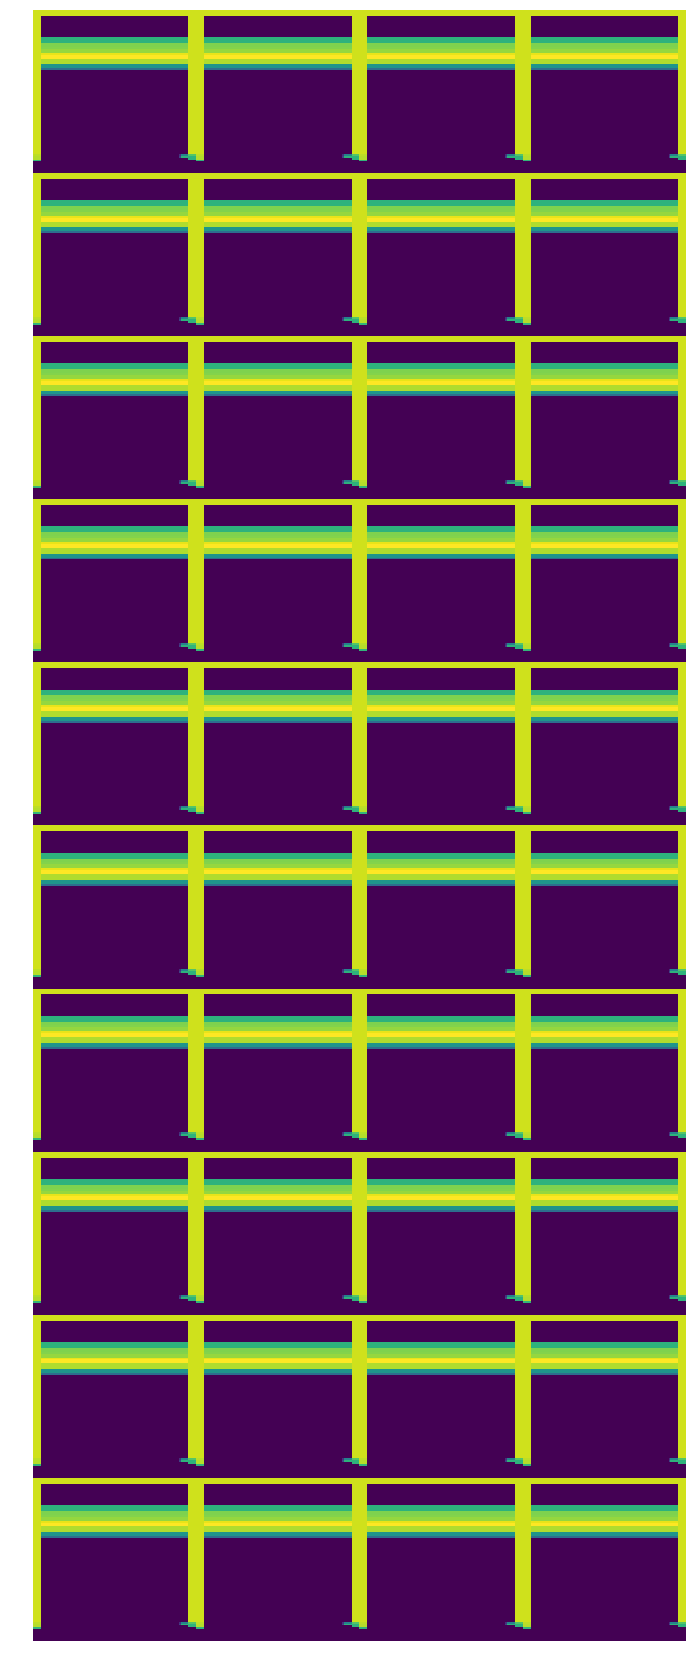

In [18]:
import matplotlib.pyplot as plt
concat_list=[]

x=gym
# concat_list.append(np.concatenate(env.reset(),axis=1))
# env.epoch()
# env.reset()
for _ in range(10):
    st,_,ter=env.step(0)
    print(env.lives)
    if ter:
        st=env.reset()
    concat_list.append(np.concatenate(st,axis=1))

plt.figure(figsize=(30,30))
plt.imshow(np.concatenate(concat_list,axis=0))
plt.axis("off")




In [5]:
from renom_rl.utility import ProbNodeChooser, MaxNodeChooser
from renom_rl.utility import GradientClipping

Env=Breakout()

opt=rm.Rmsprop(7e-4, g=0.99, epsilon=1e-10)

a2c=A2C(Env,
        model2,
        test_node_selector=MaxNodeChooser(),
        num_worker=16,
#         gradient_clipping=GradientClipping(),
        advantage=7,
        optimizer=opt,
        )


# model initiates when instance is made

if os.path.exists("./model1.h5"):
    print("exist")
    model2.load("./model1.h5")
else:
    print("initiate")
    model2.save("./model0.h5")

initiate


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



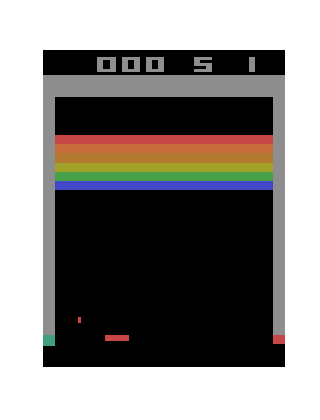
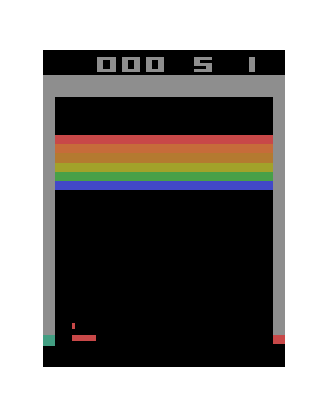
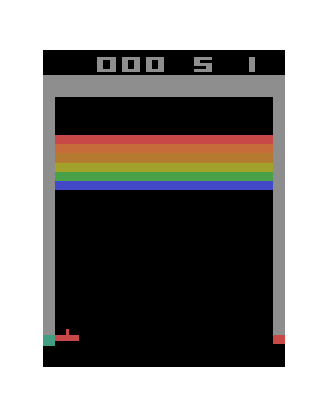
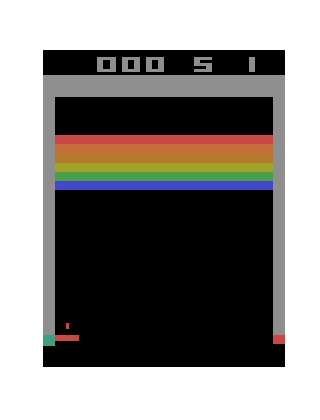
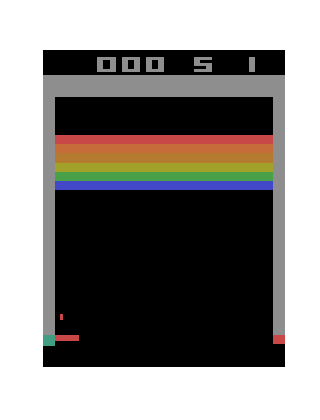
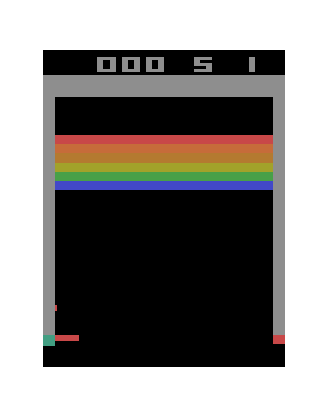
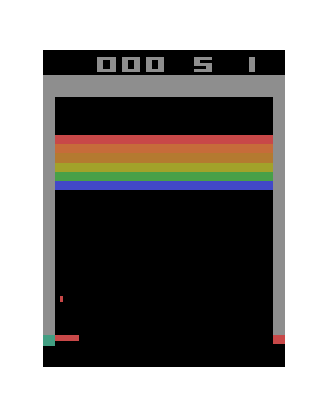
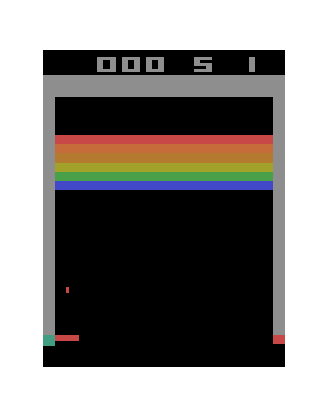
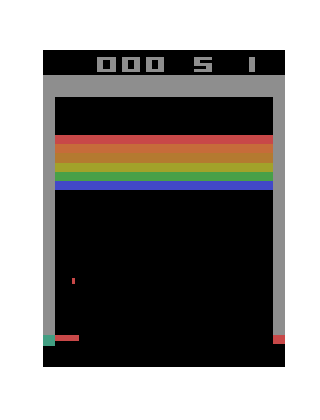
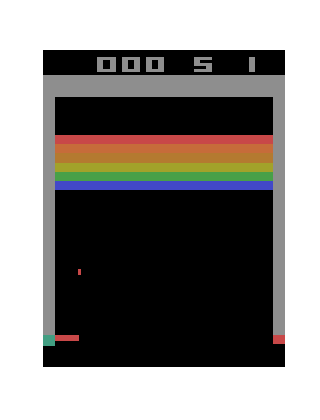
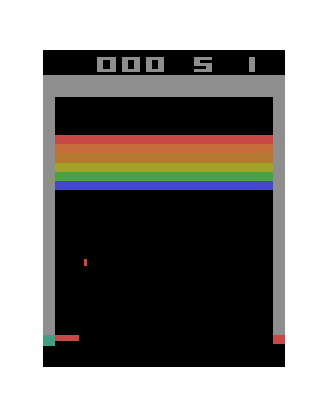
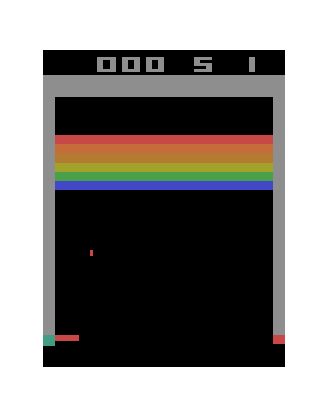
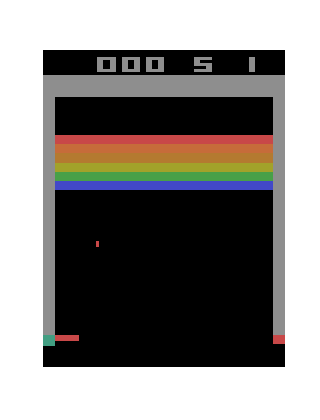
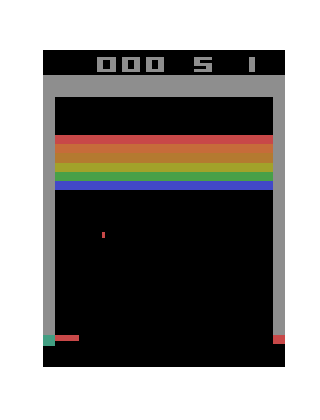
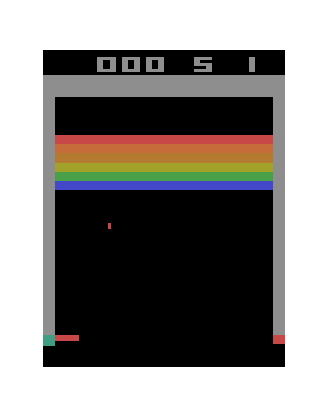
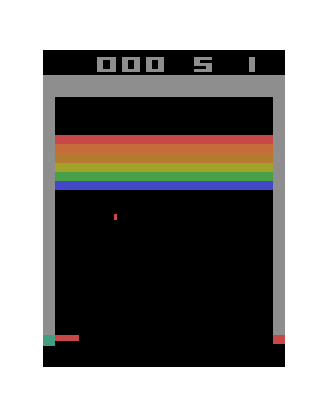
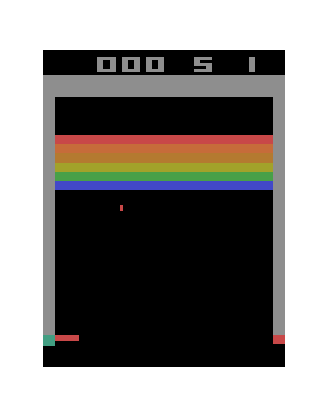
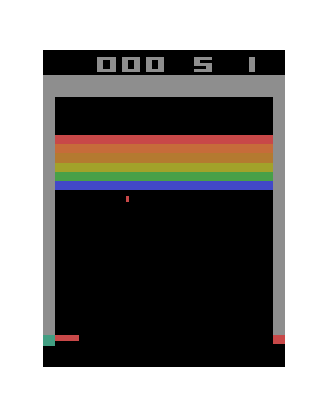
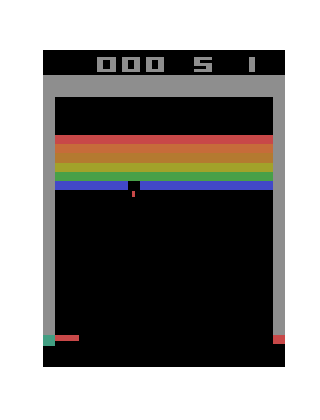
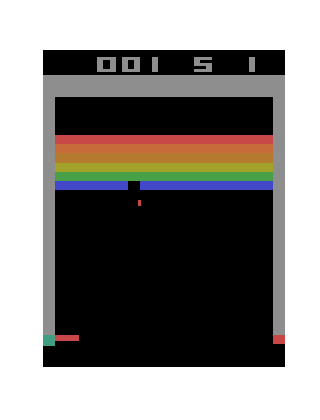
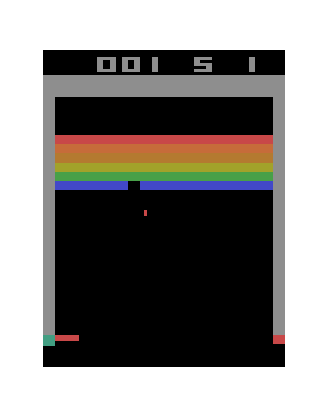
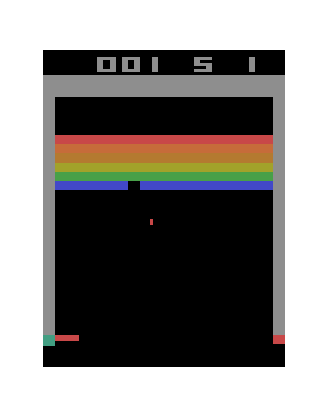
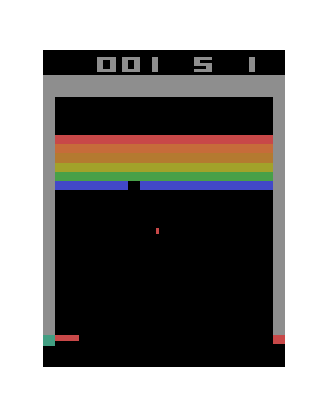
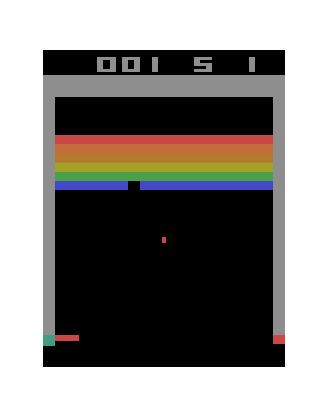
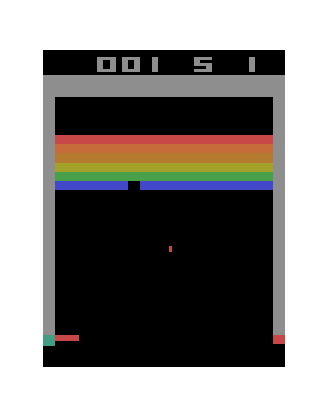
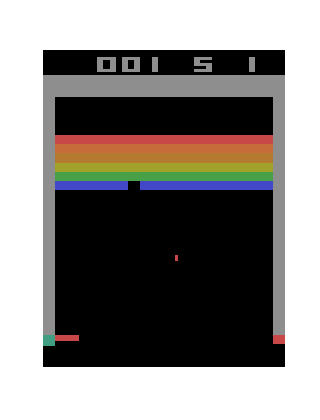
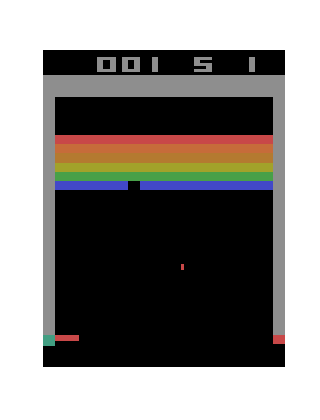
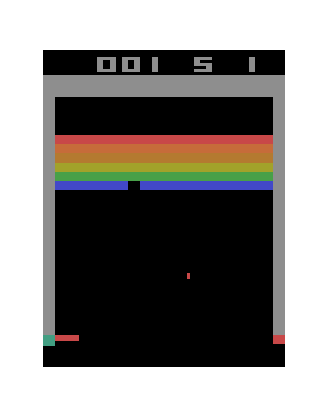
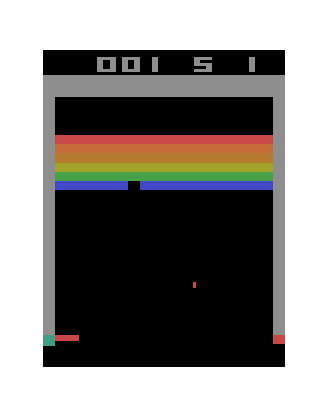
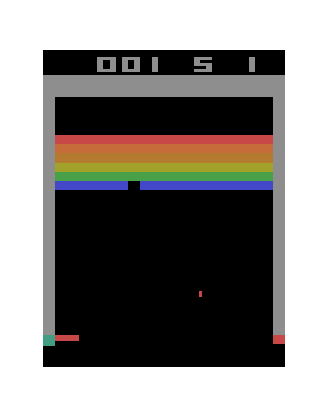
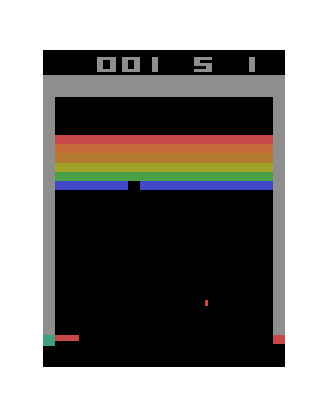
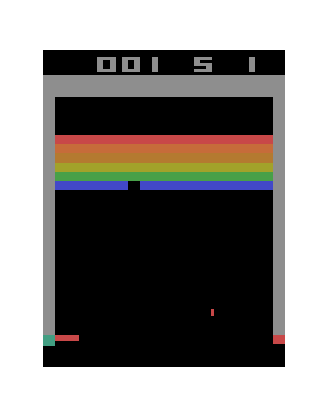
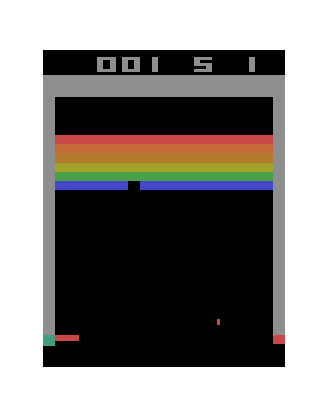
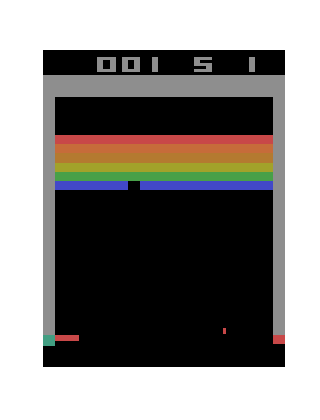
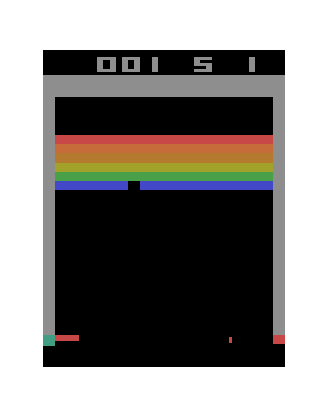
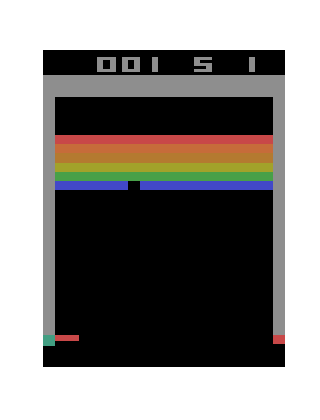
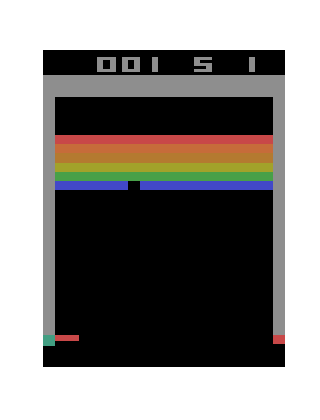
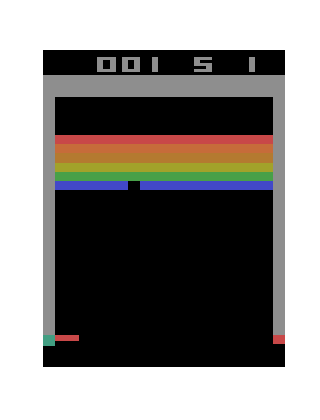
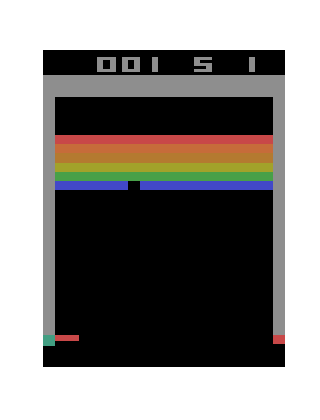
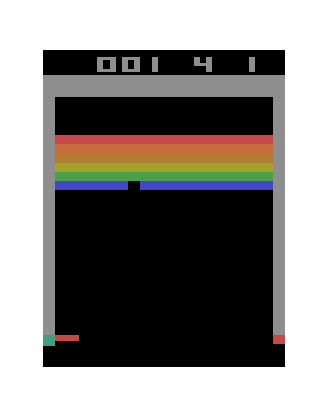
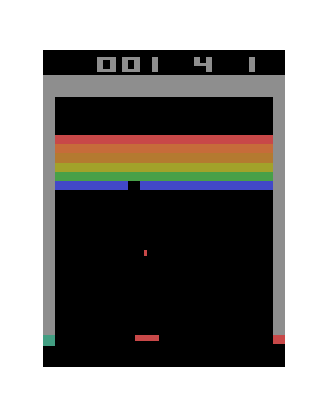
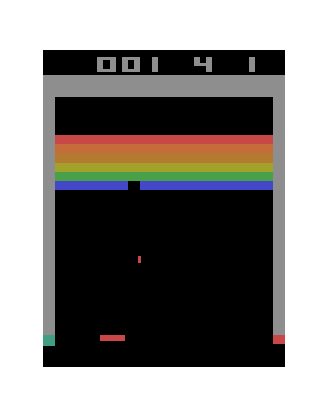
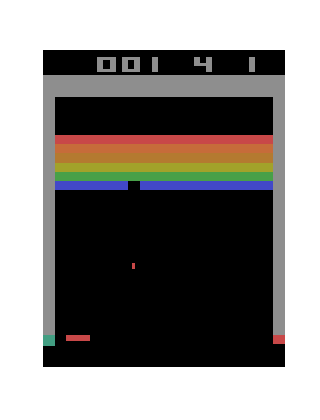
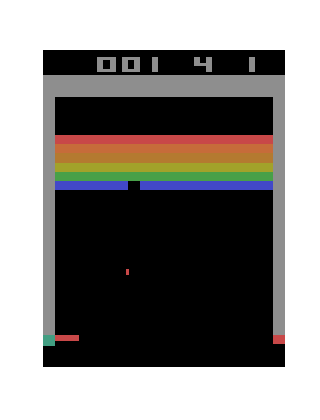
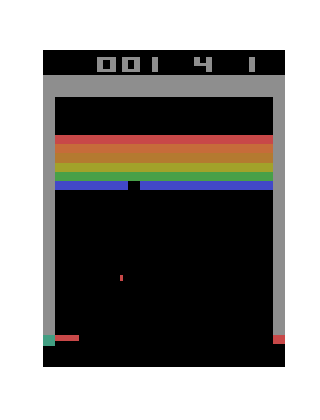
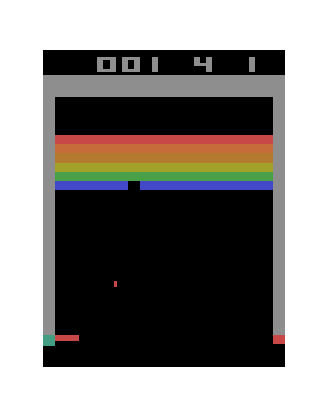
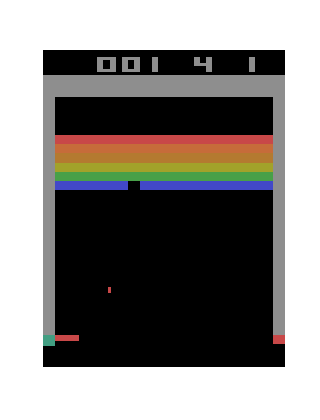
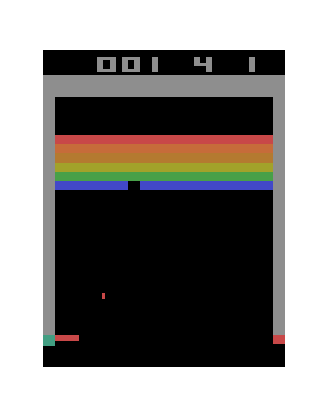
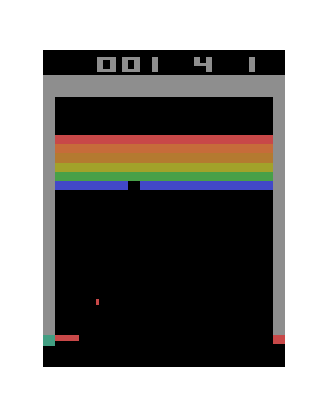
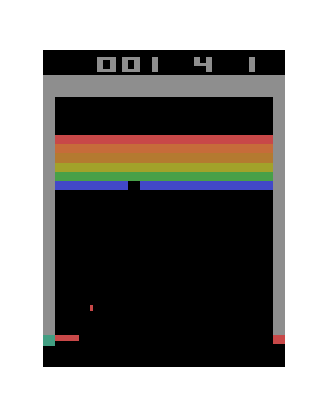
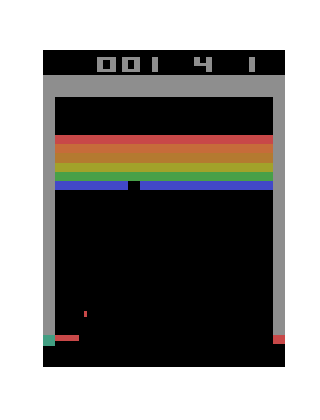
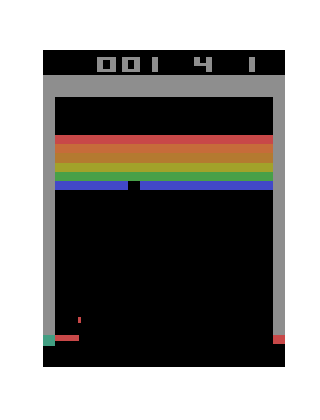
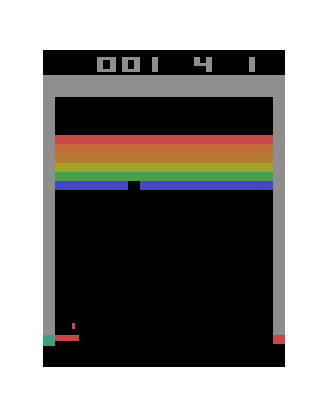
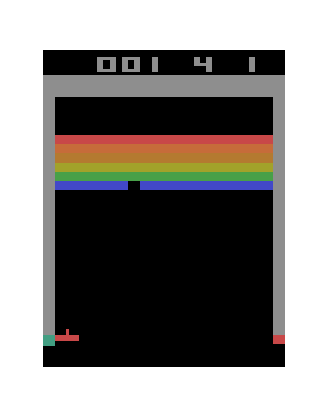
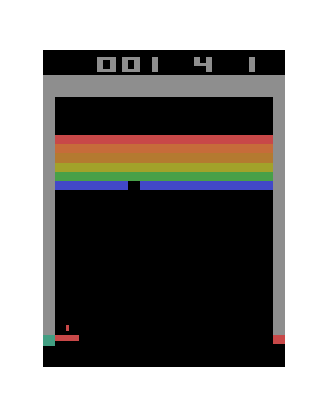
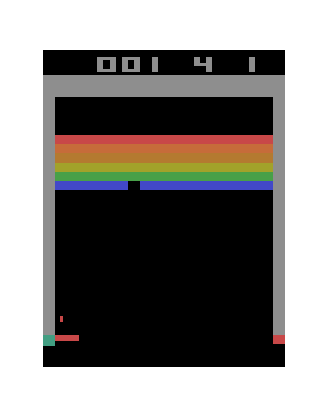
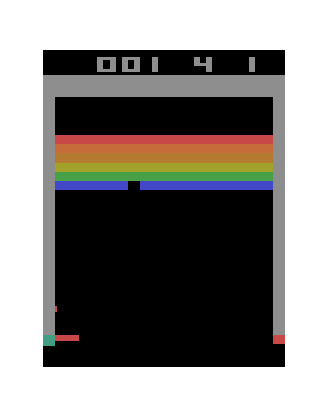
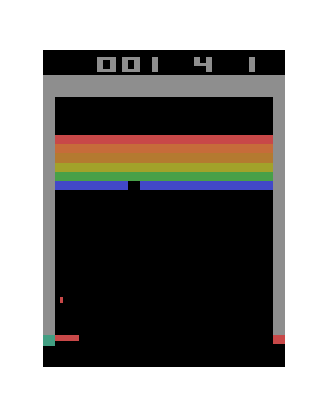
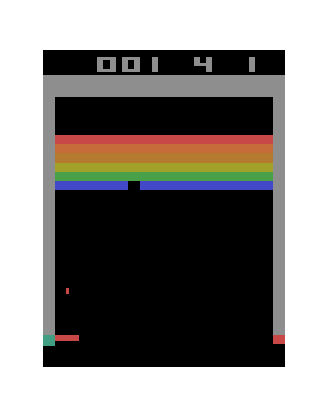
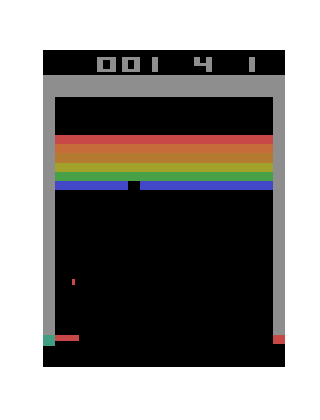
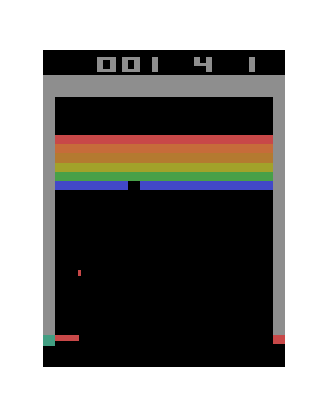
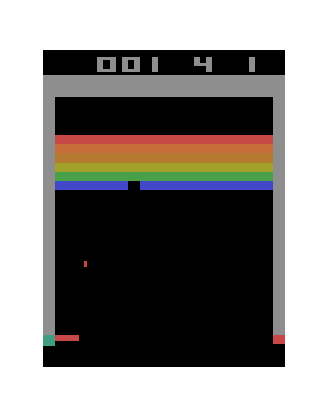
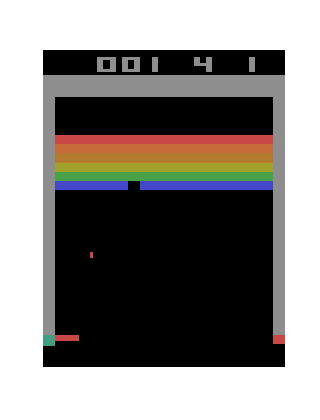
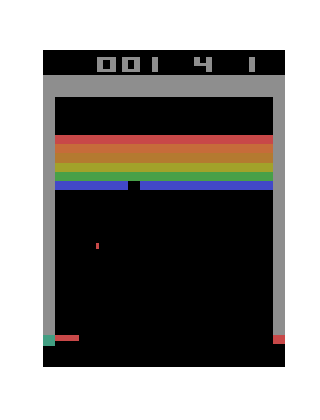
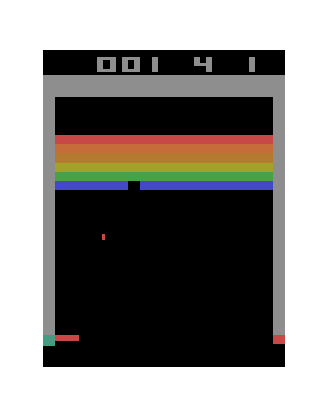
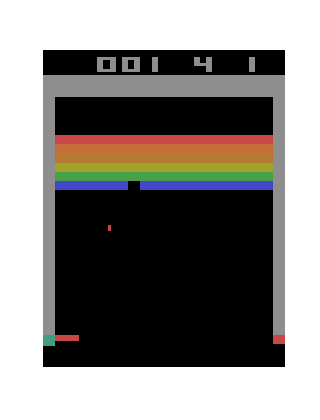
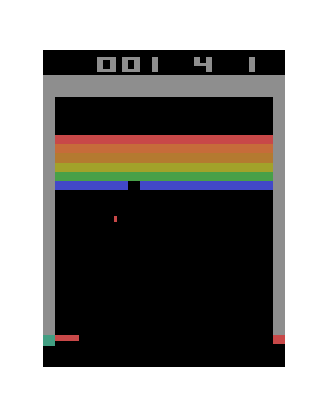
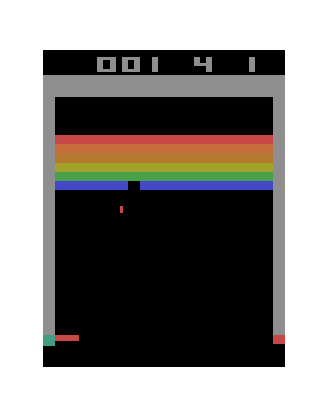
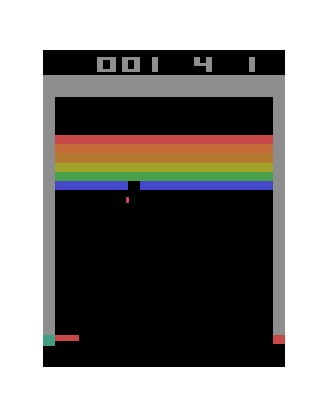
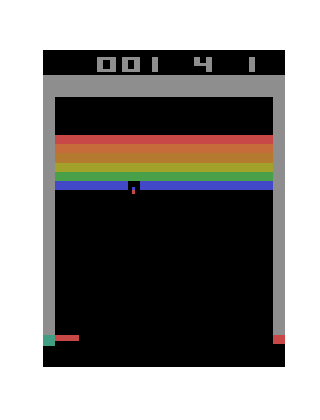
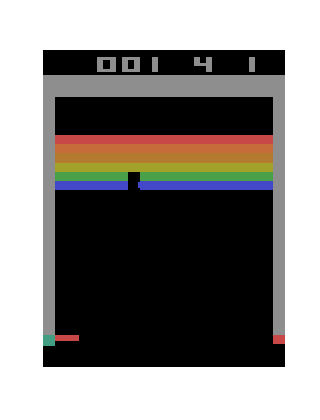
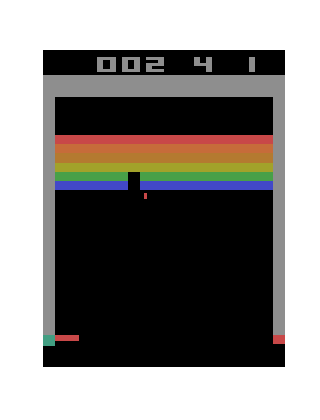
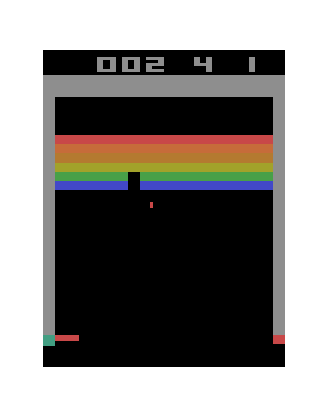
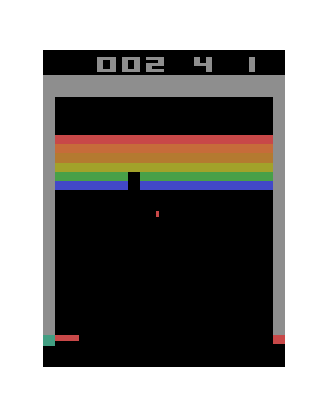
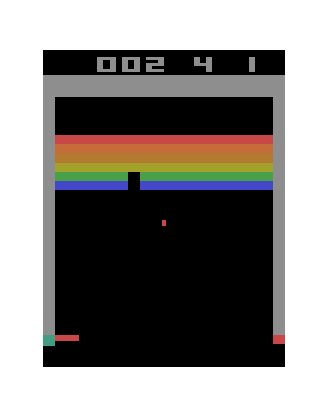
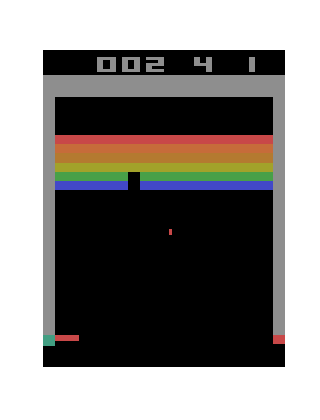
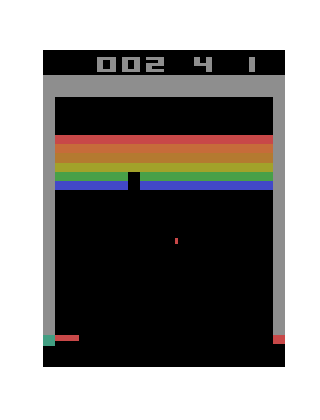
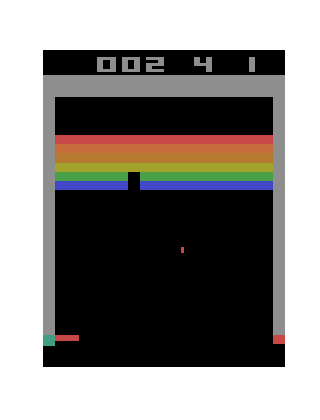
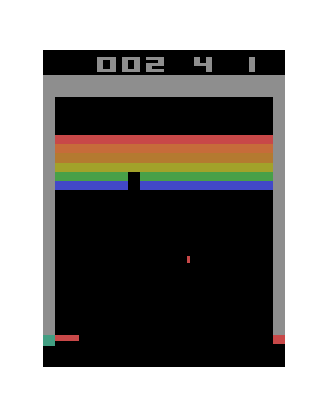
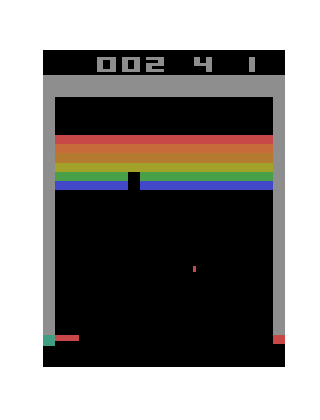
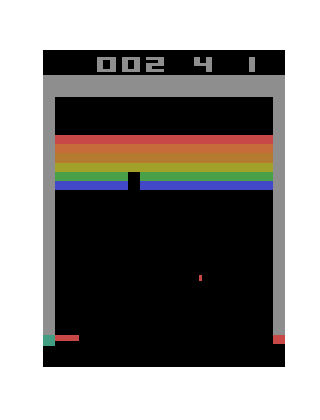
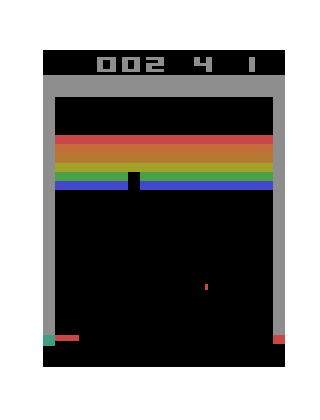
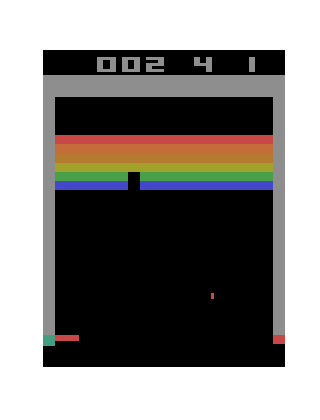
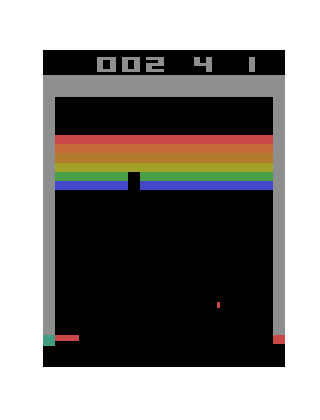
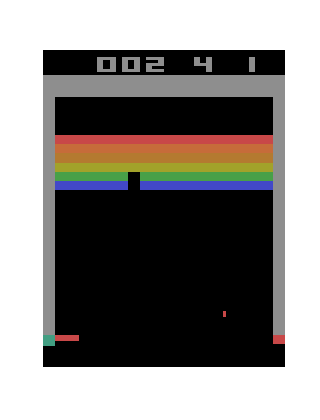
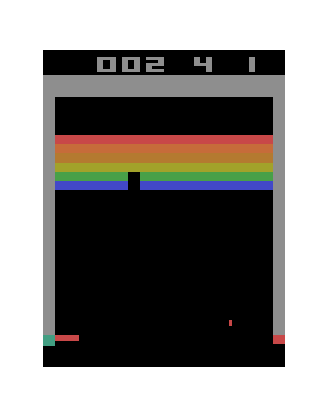
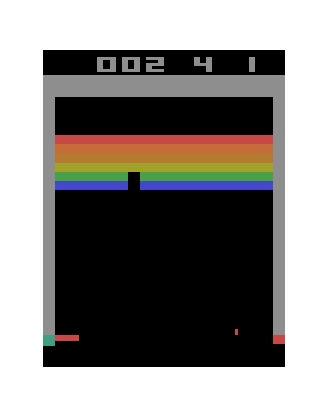
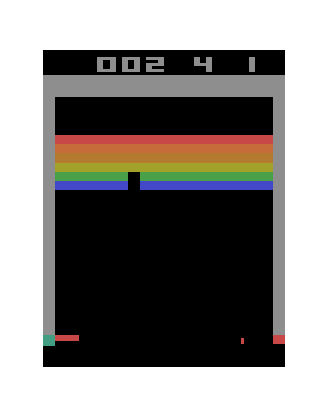
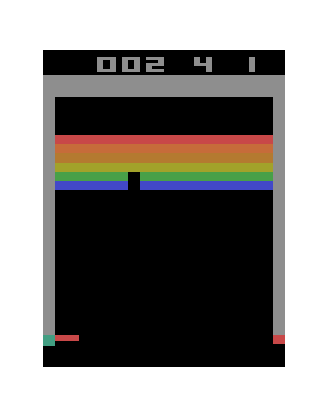
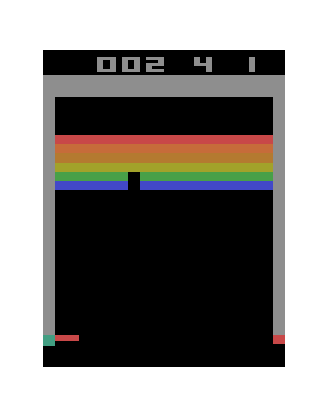
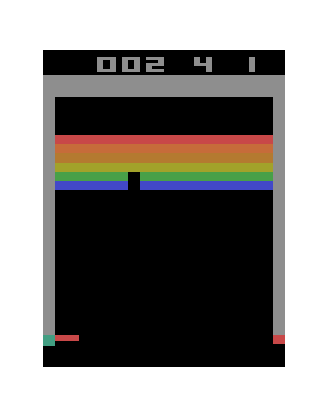
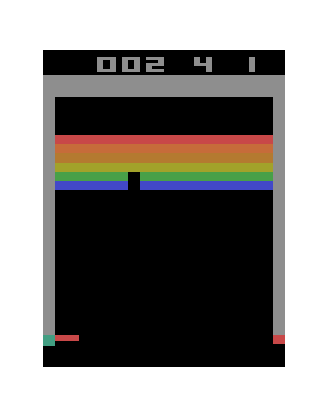
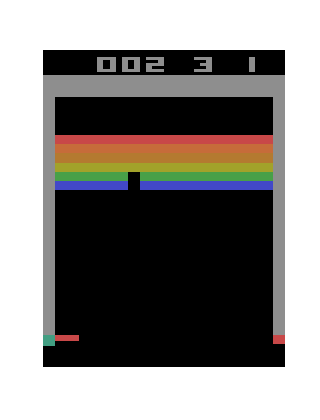
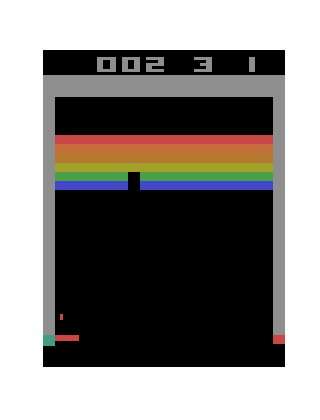
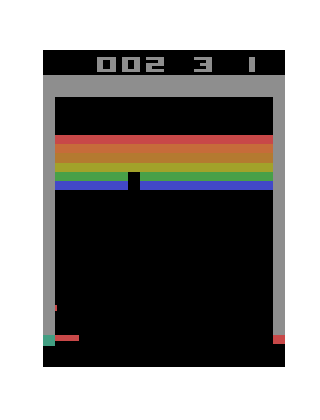
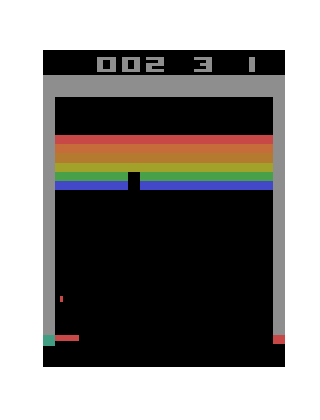
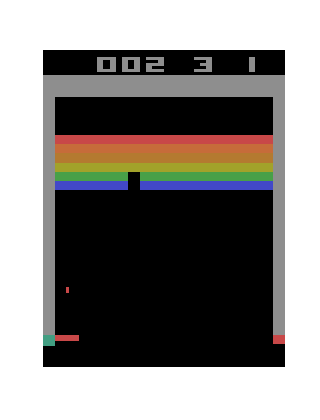
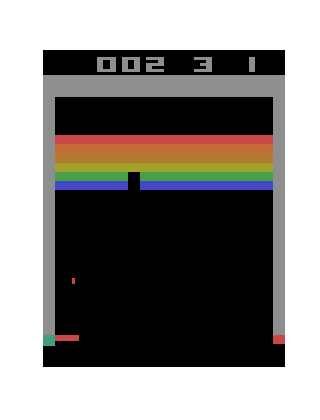
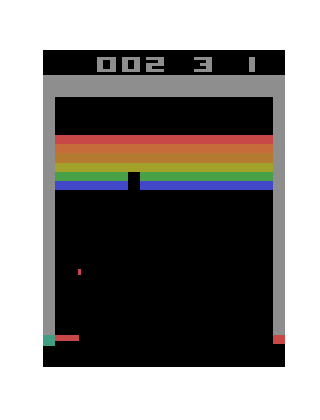
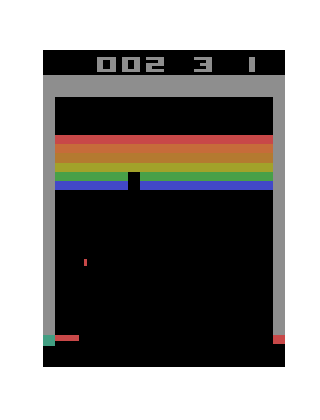
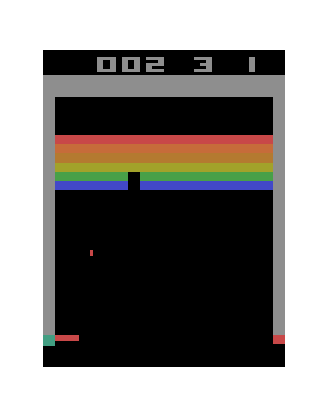
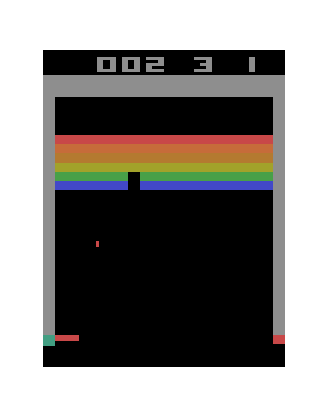
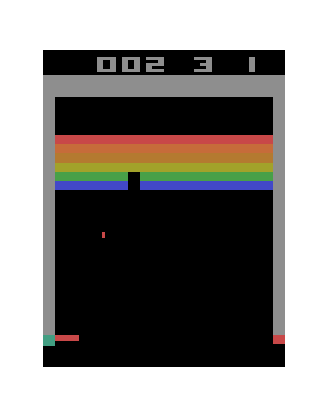
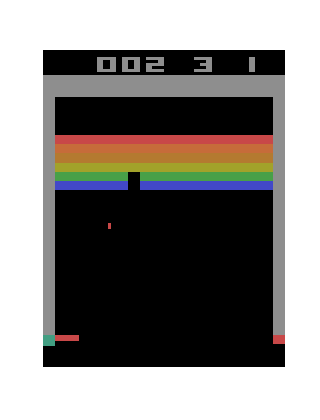
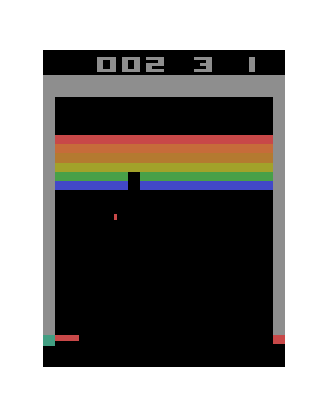
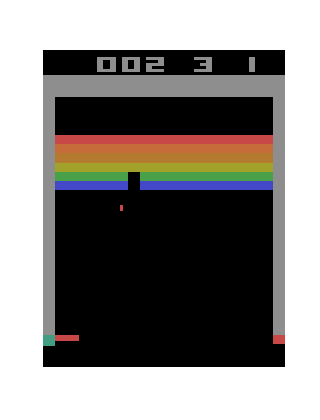
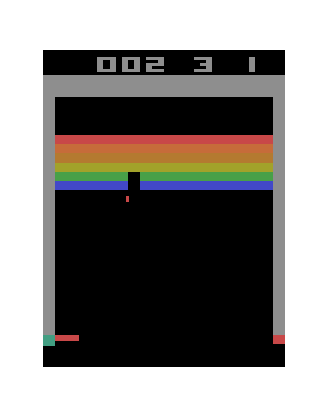
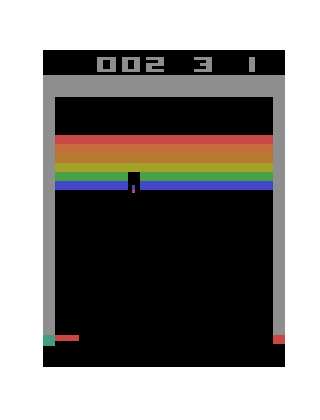
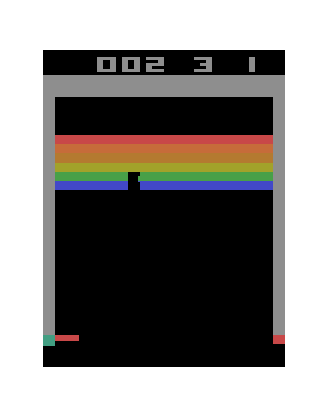
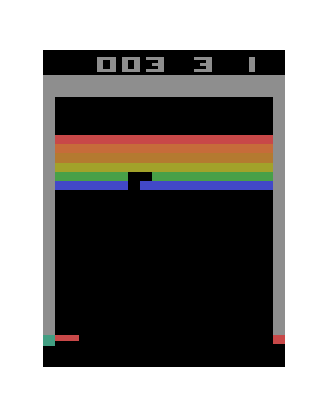
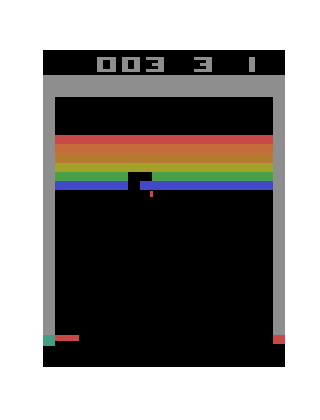
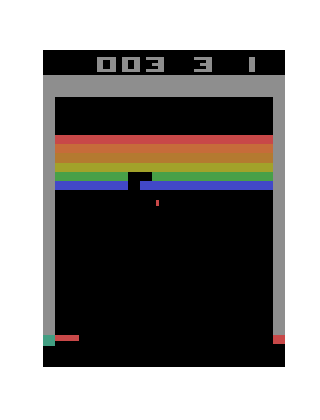
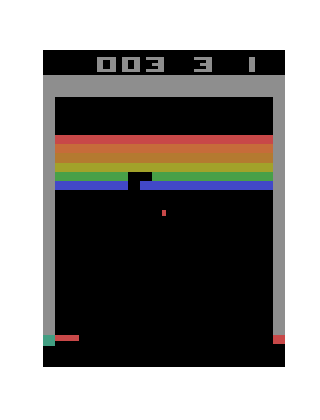
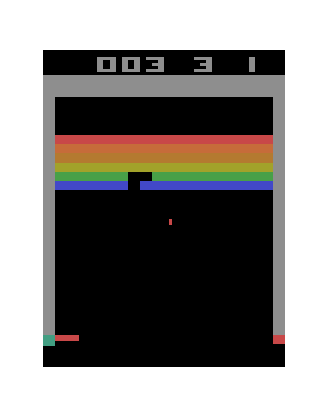
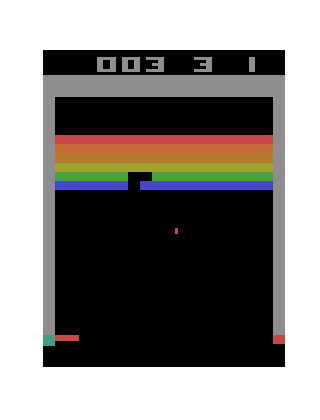
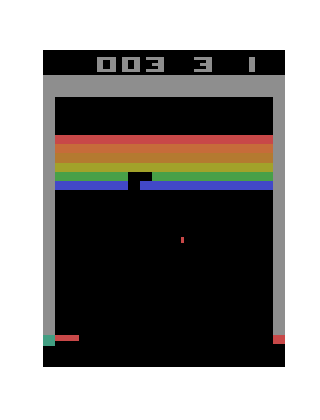
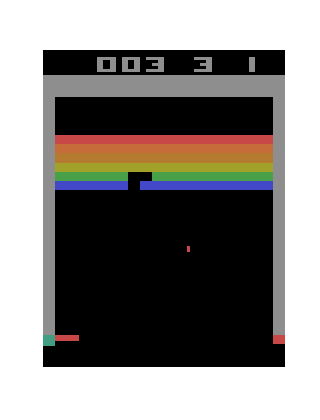
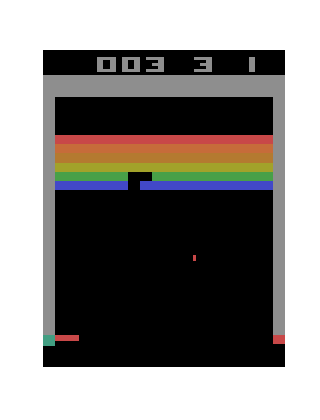
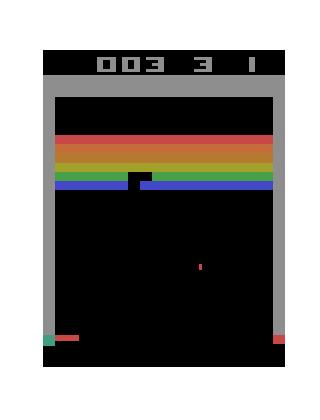
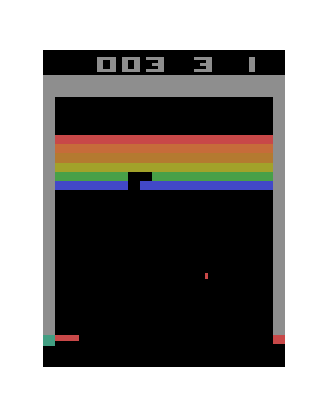
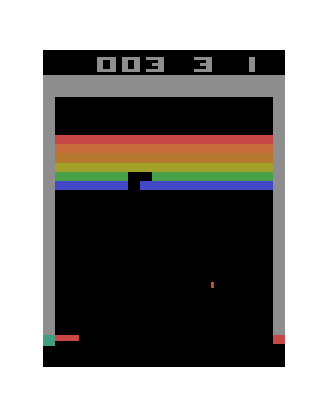
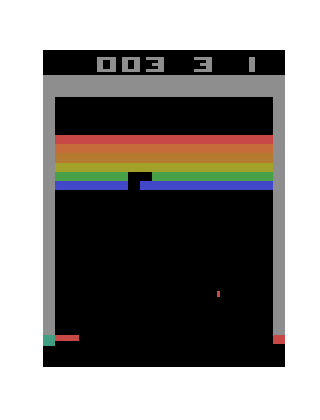
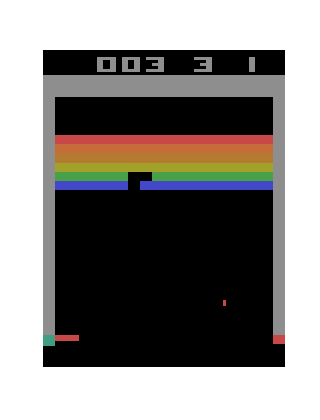
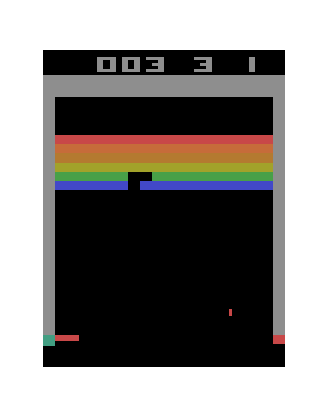
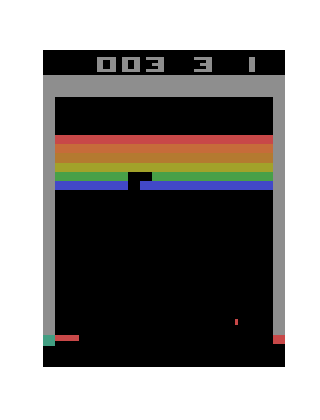
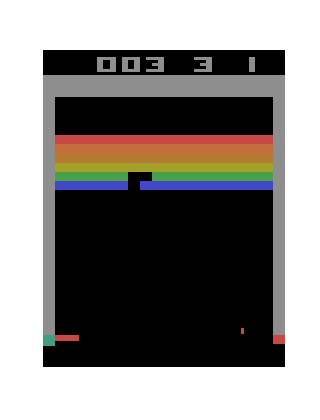
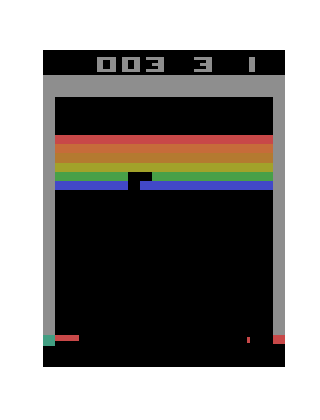
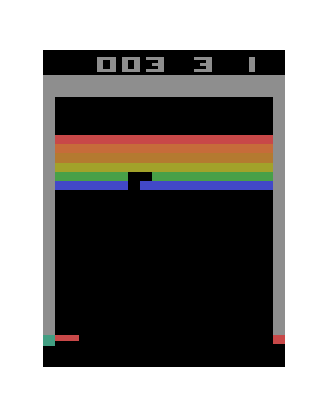
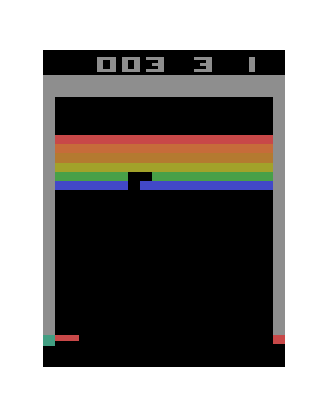
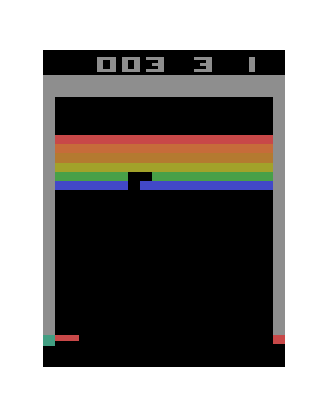
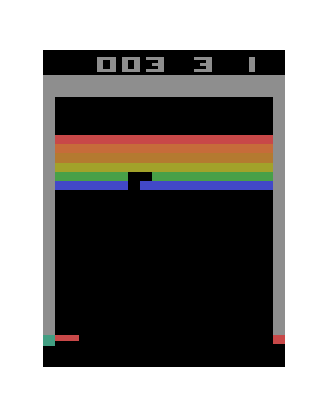
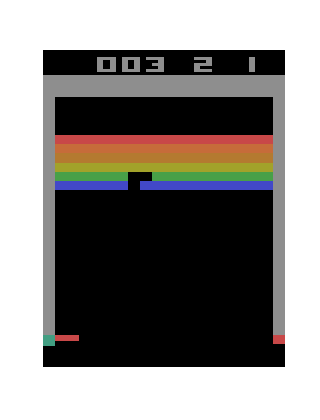
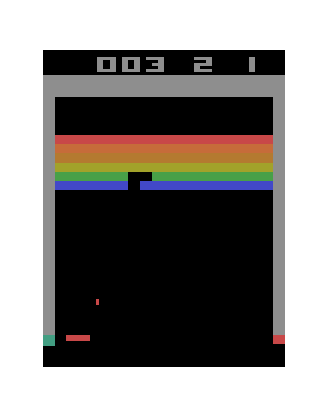
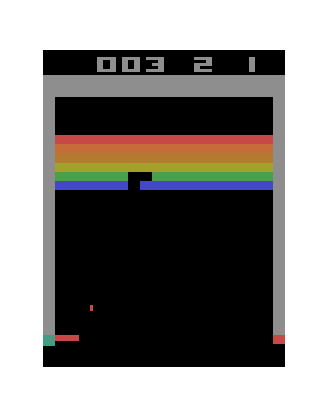
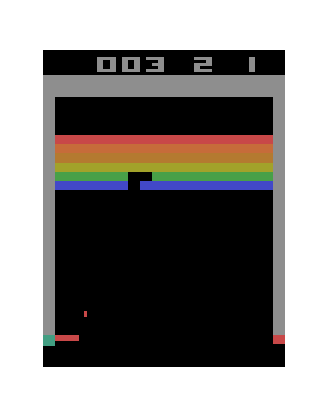
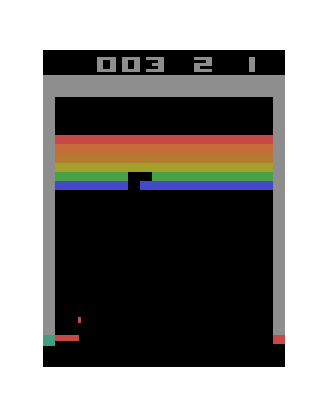
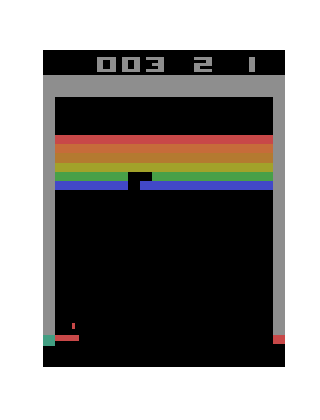
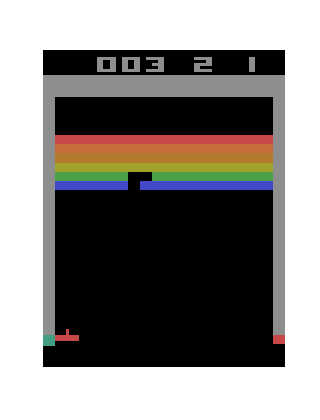
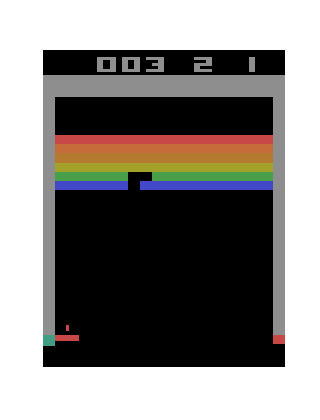
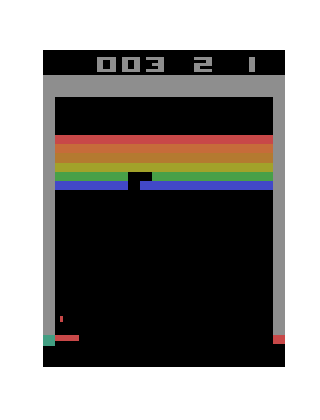
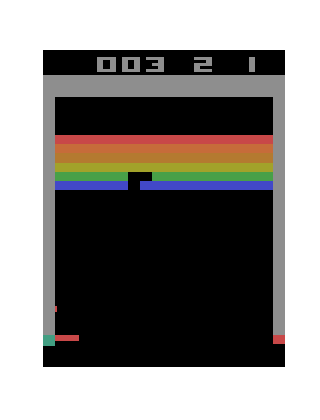
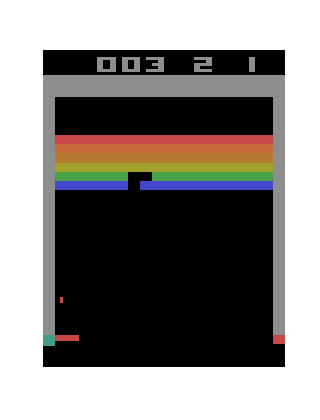
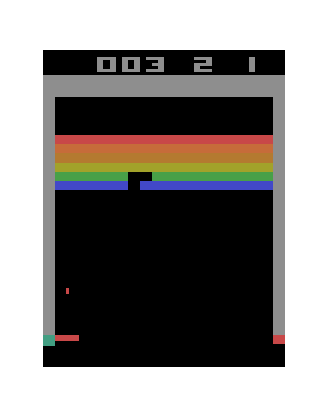
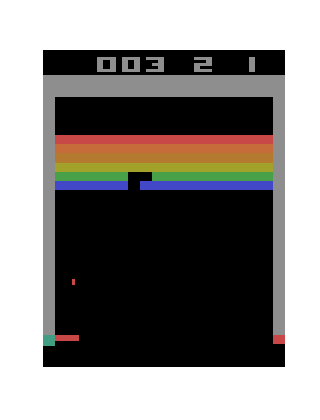
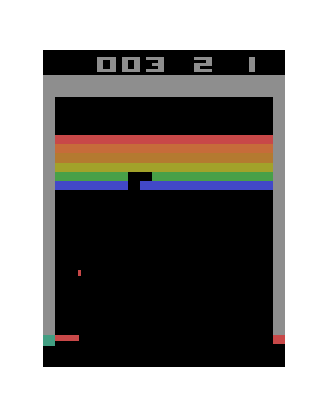
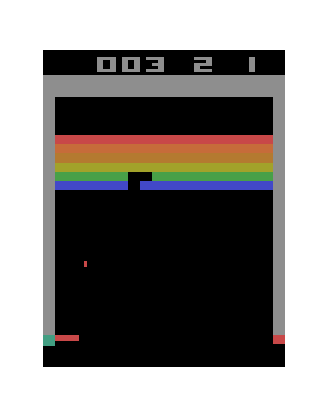
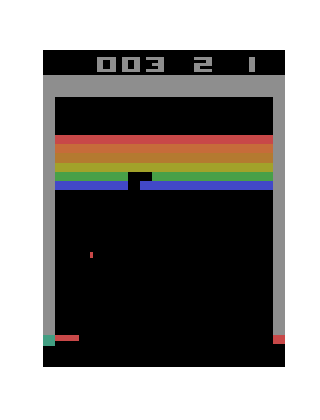
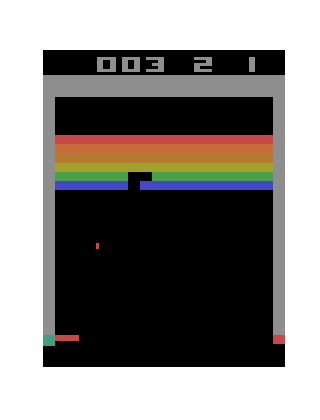
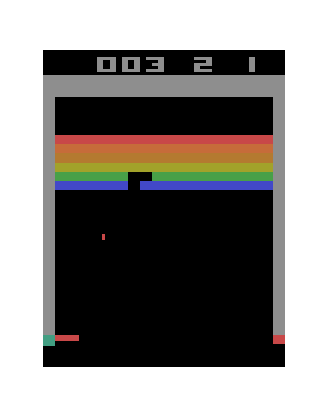
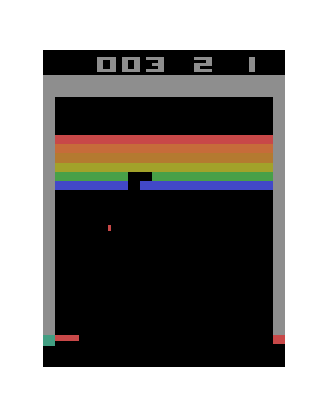
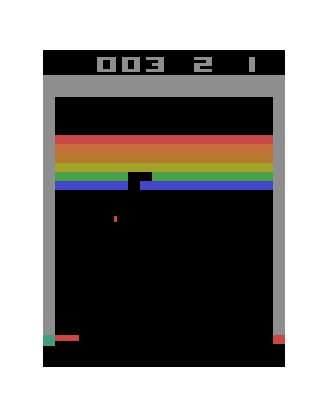
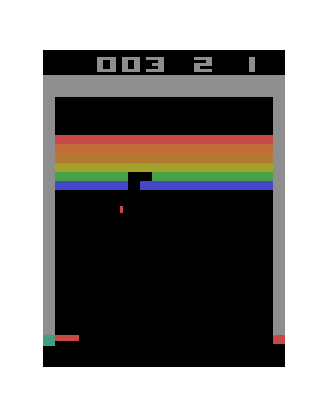
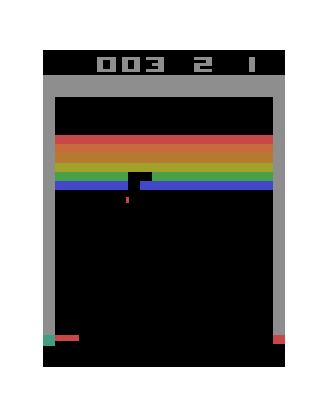
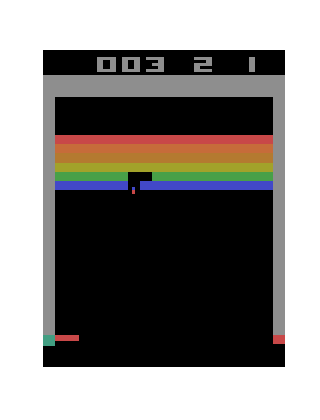
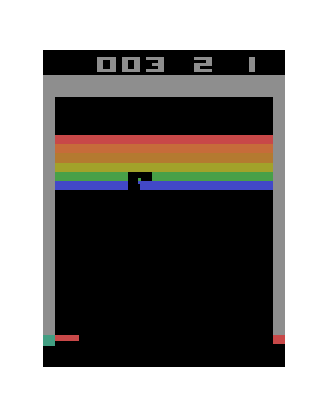
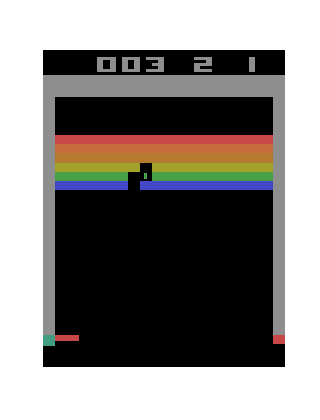
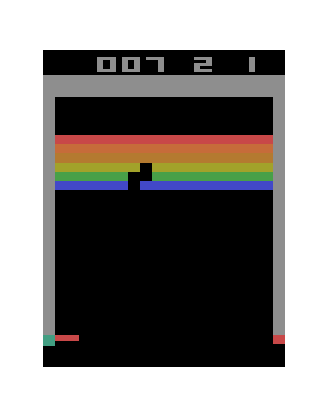
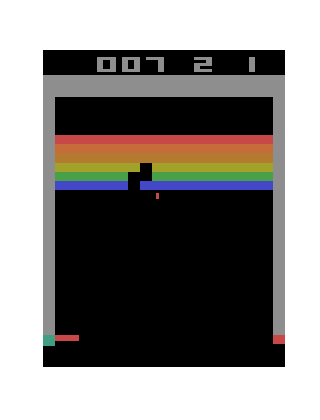
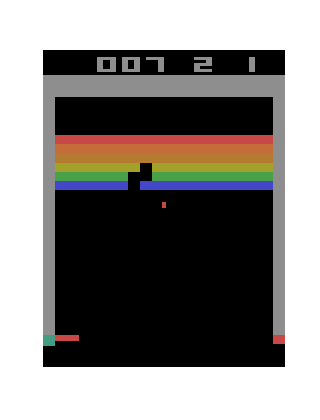
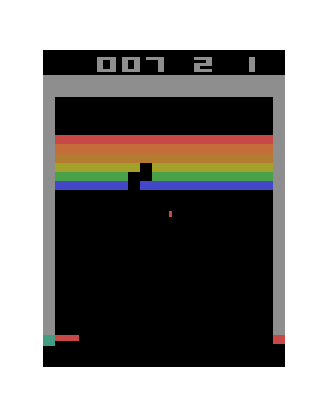
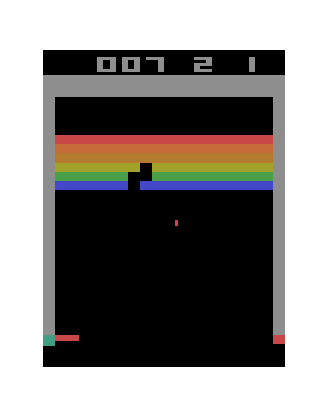
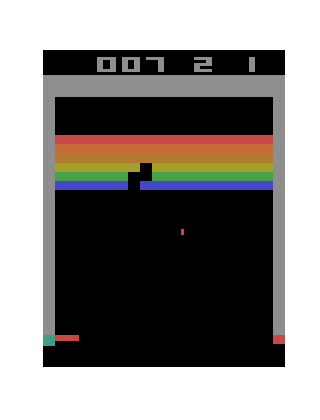
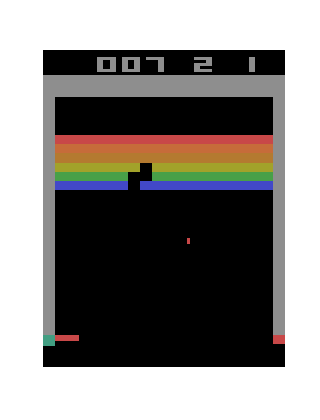
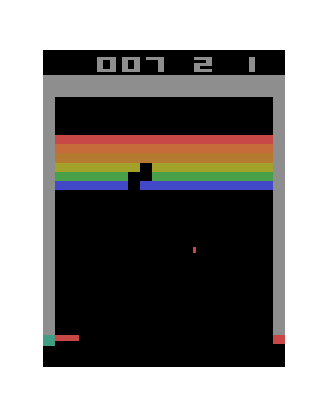
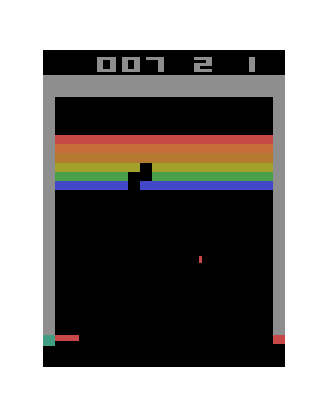
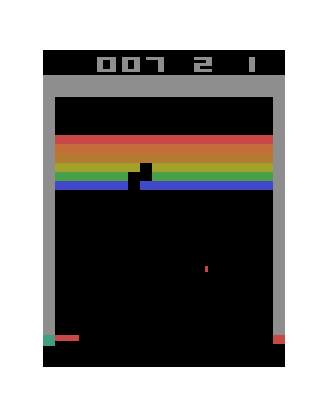
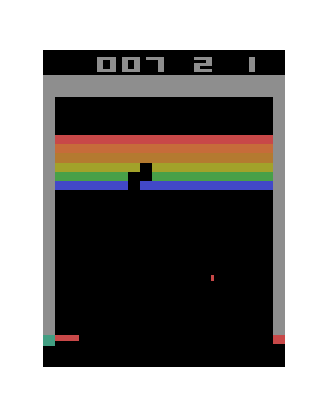
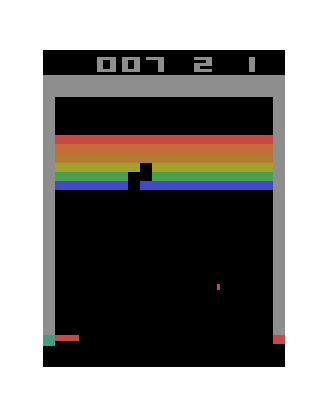
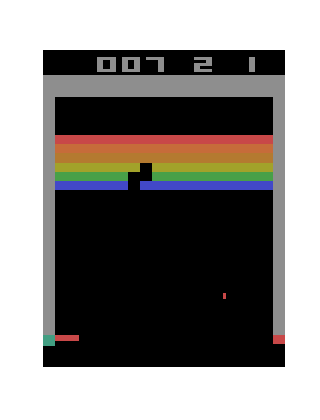
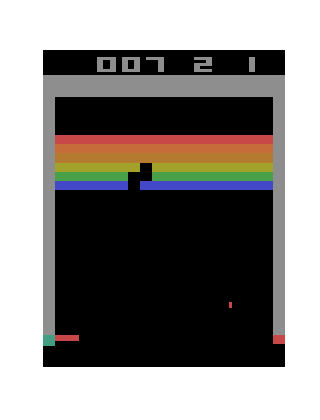
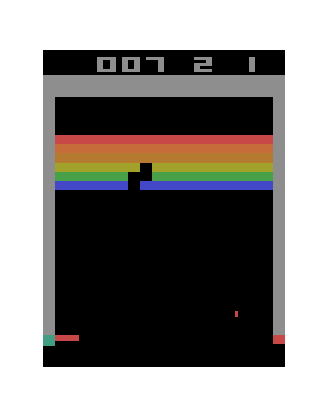
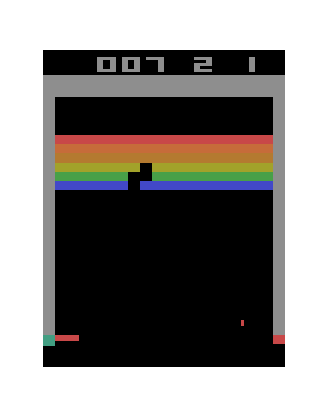
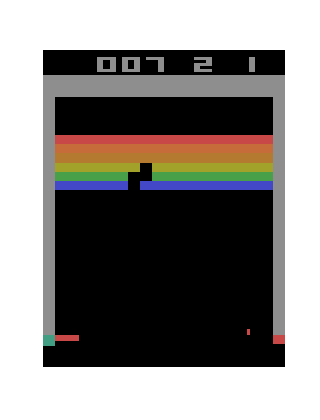
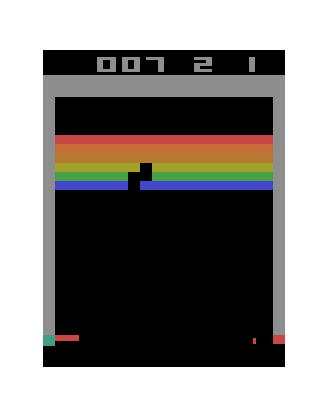
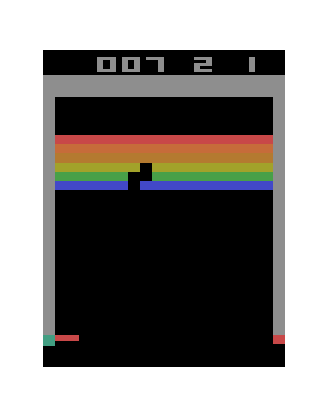
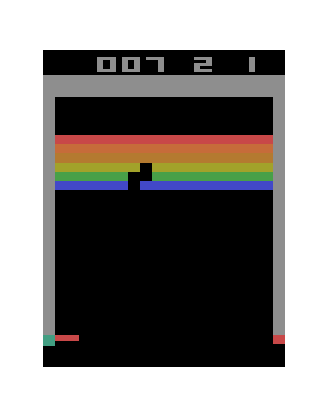
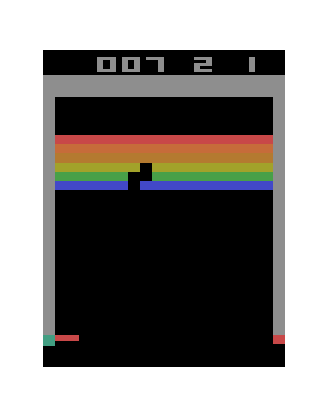
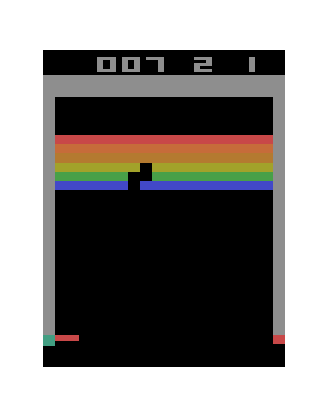
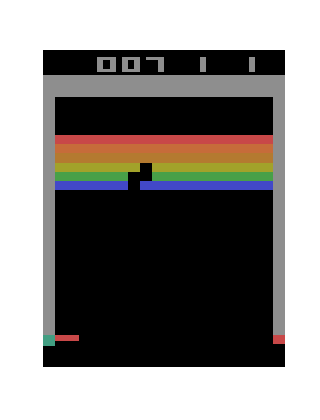
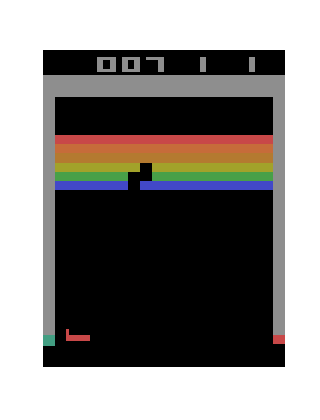
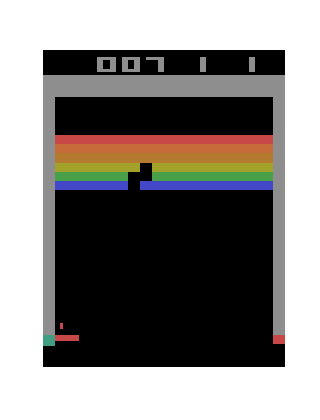
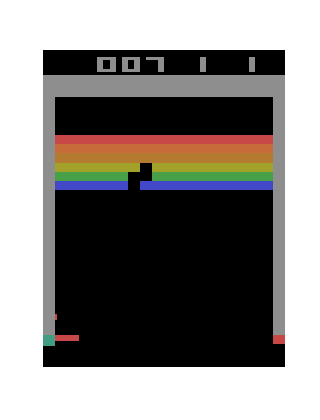
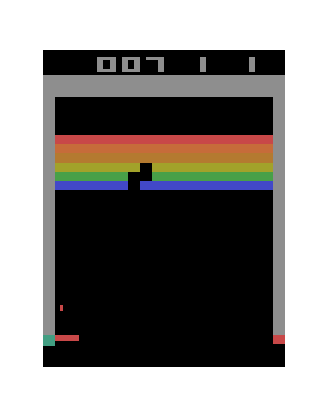
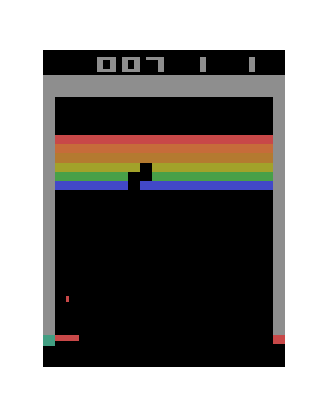
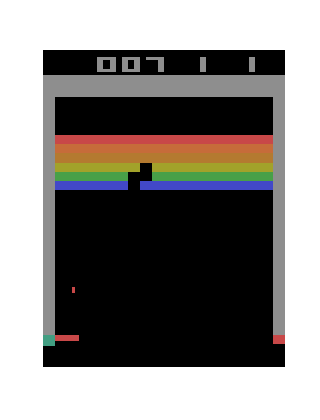
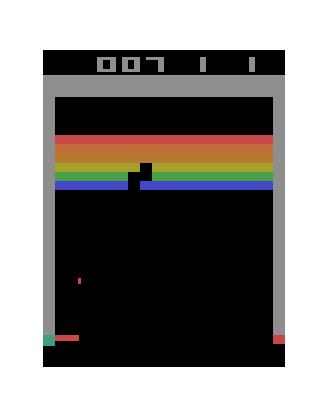
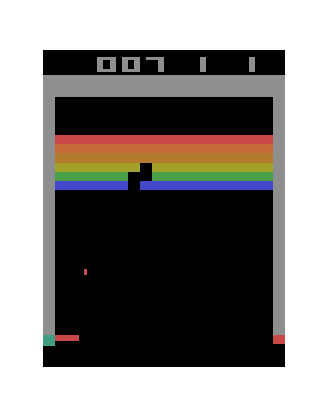
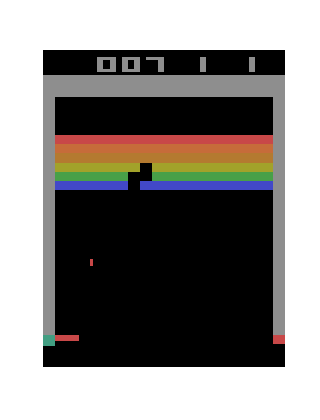
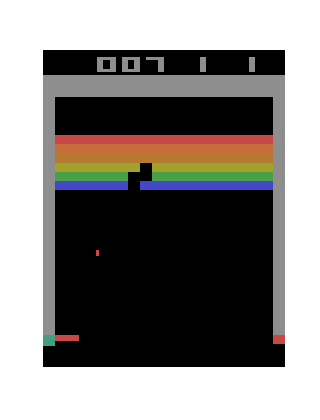
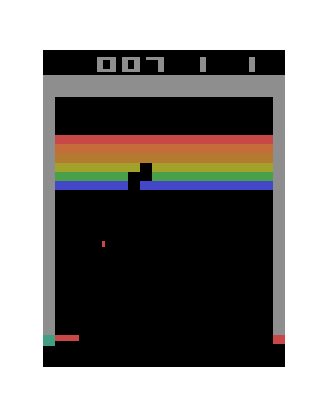
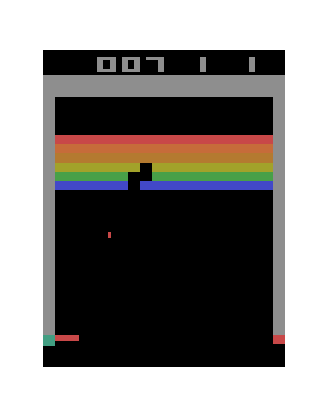
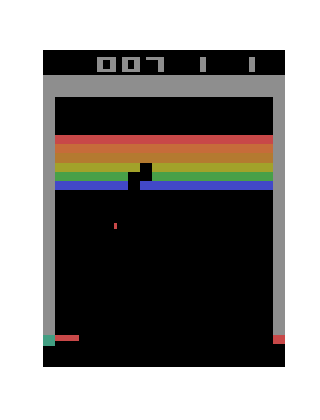
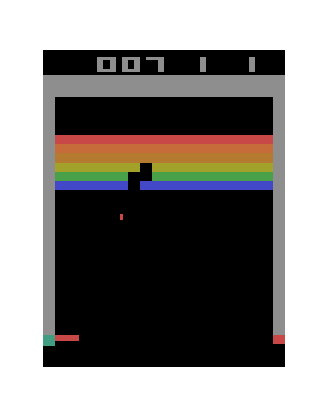
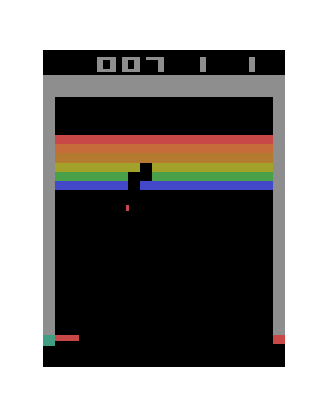
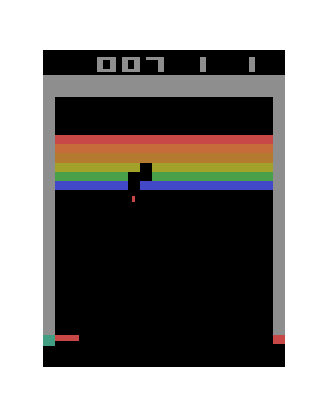
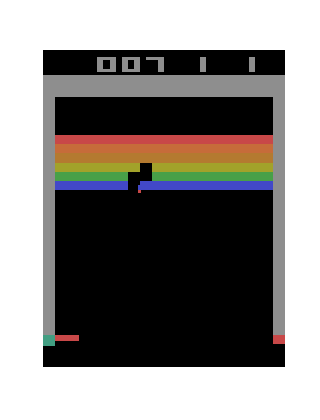
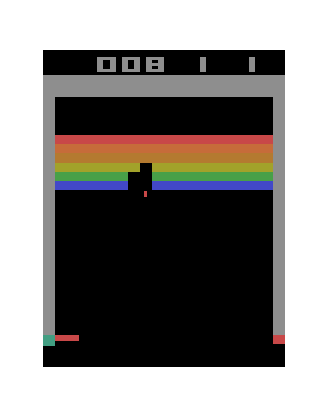
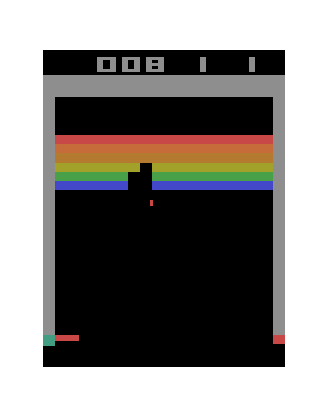
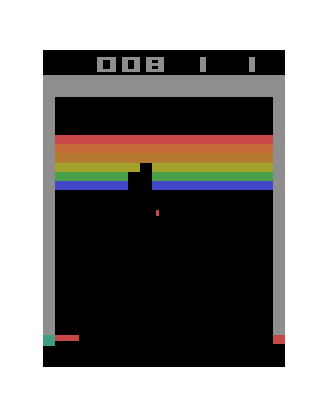
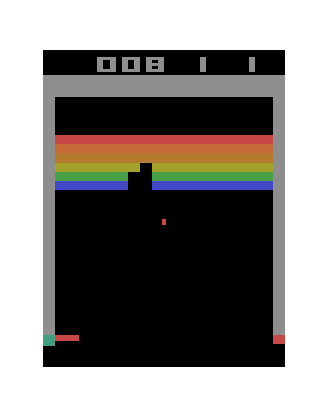
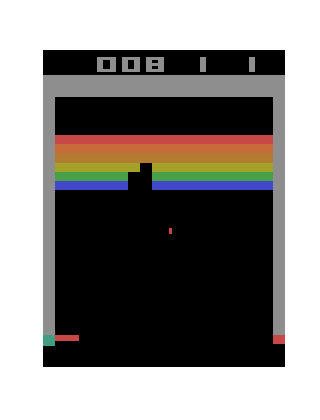
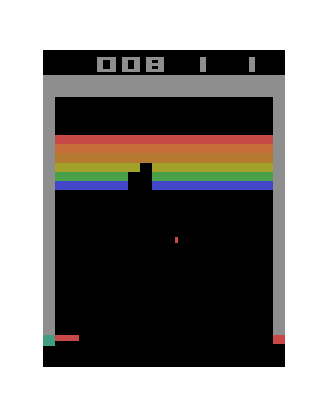
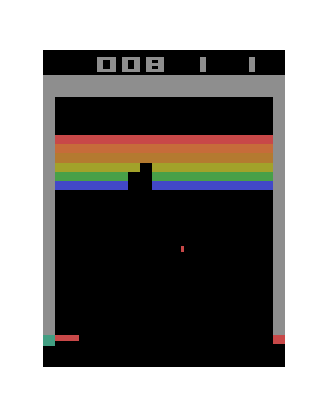
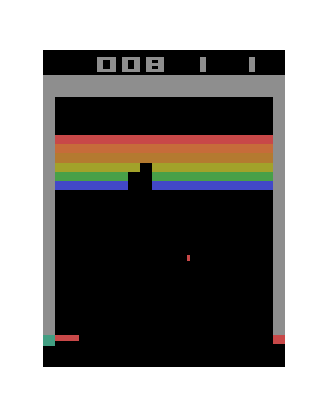
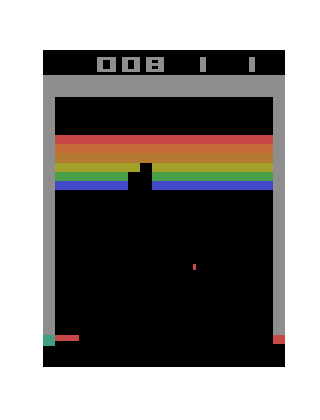
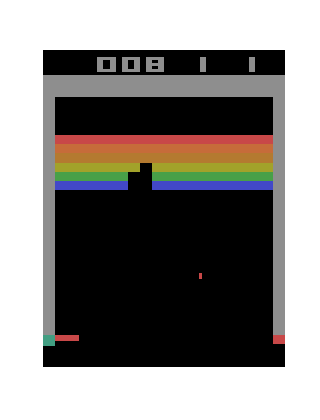
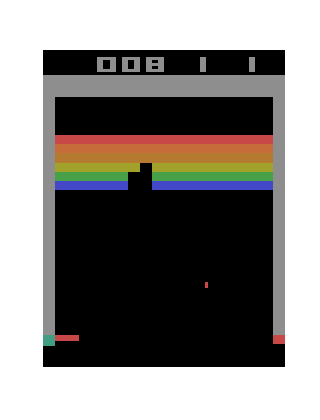
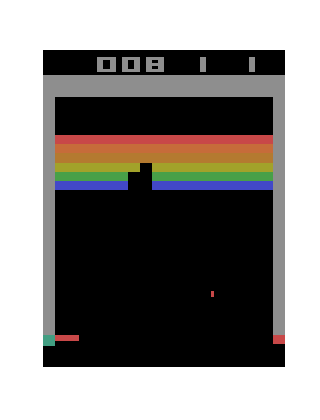
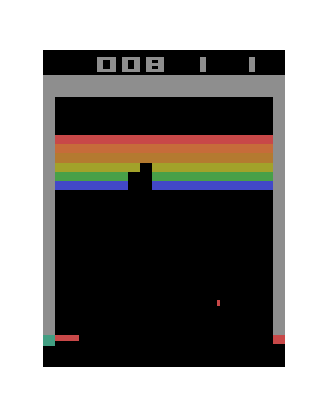
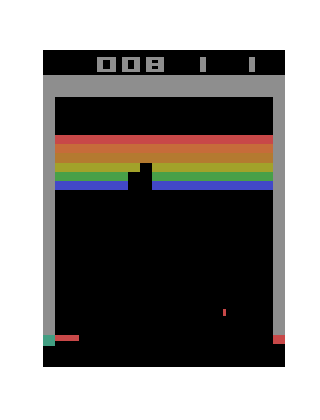
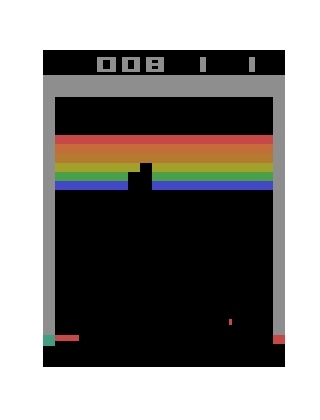
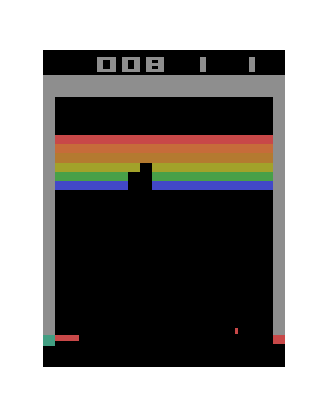
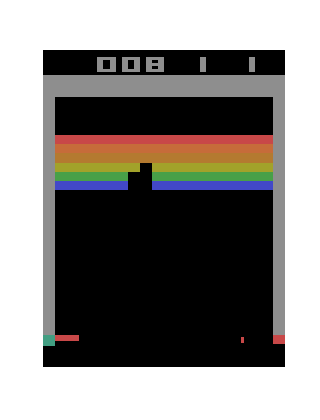
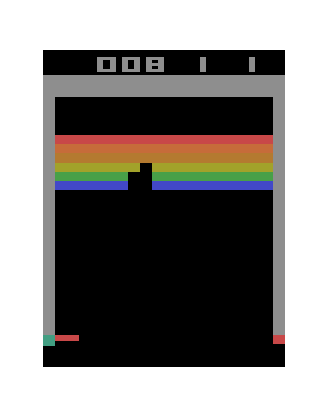
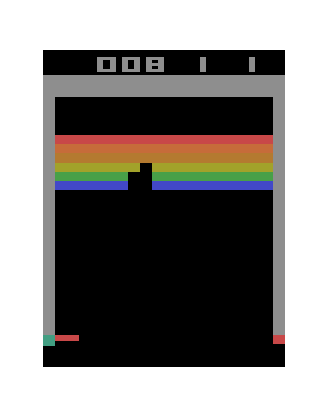
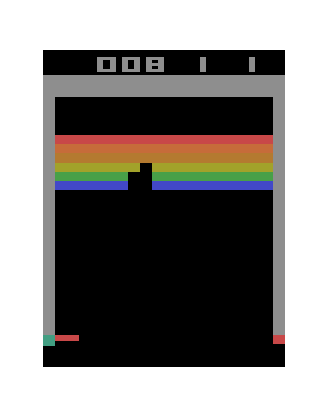
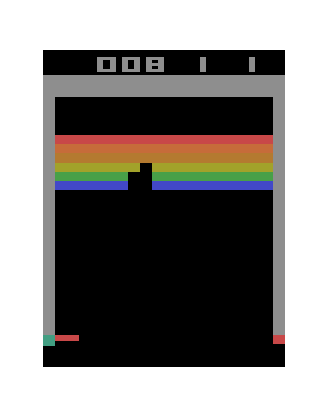
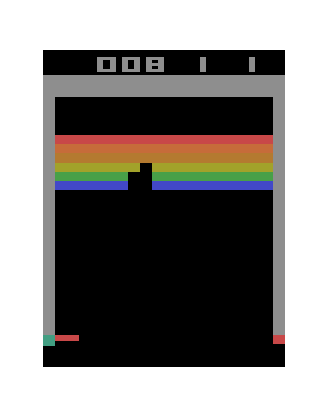
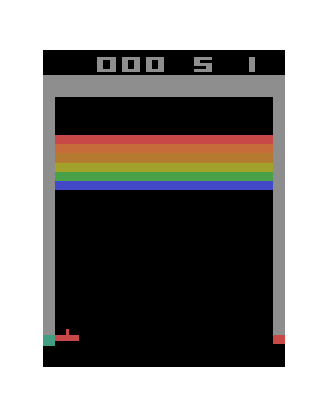
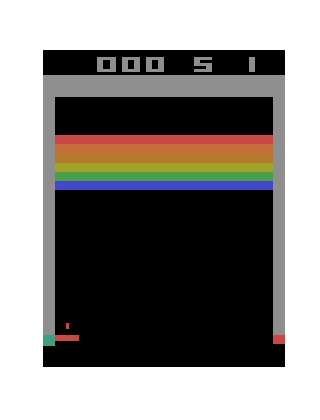
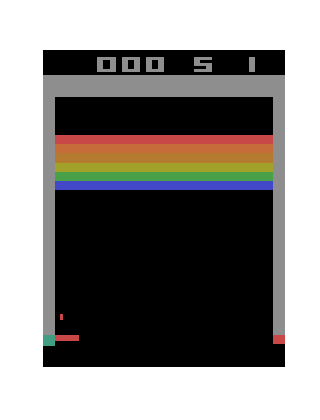
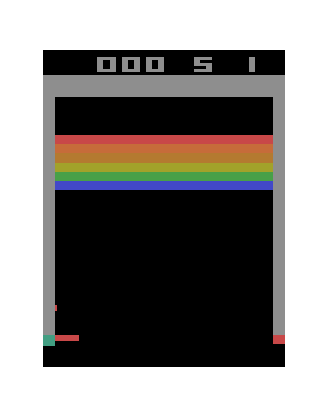
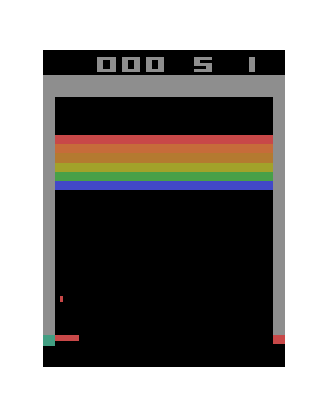
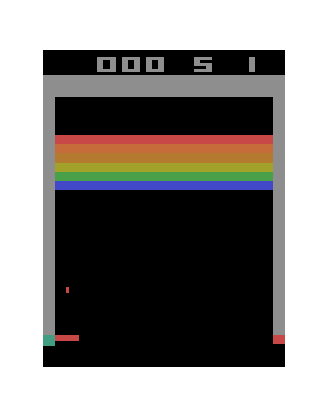
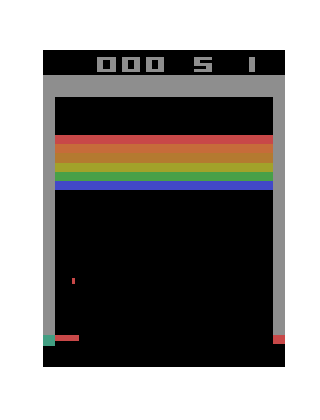
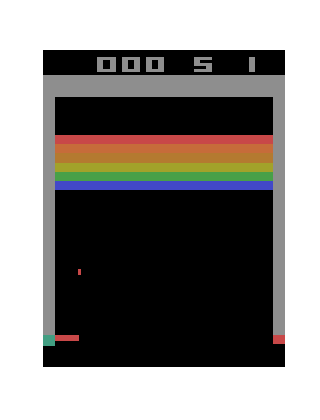
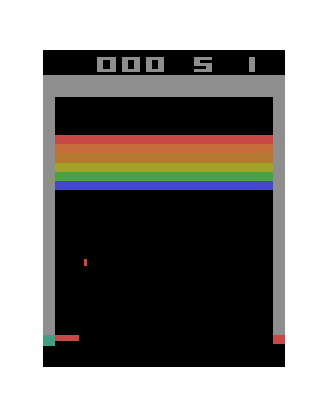
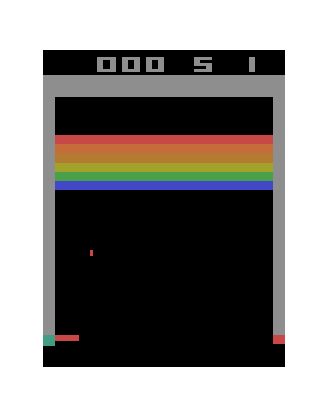
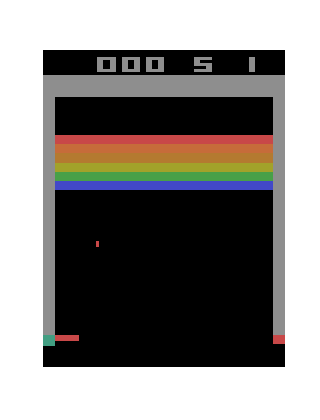
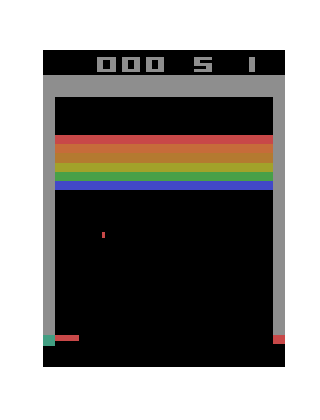
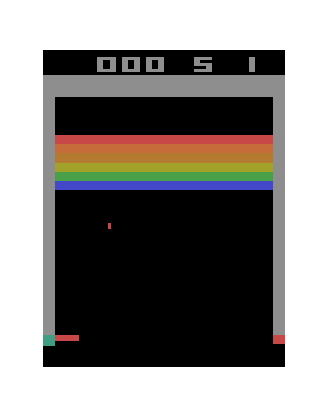
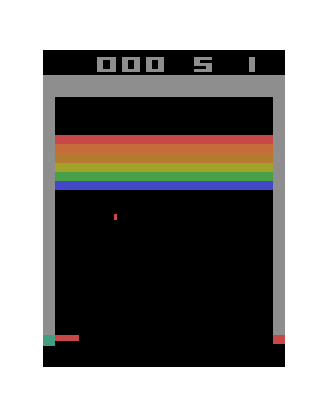
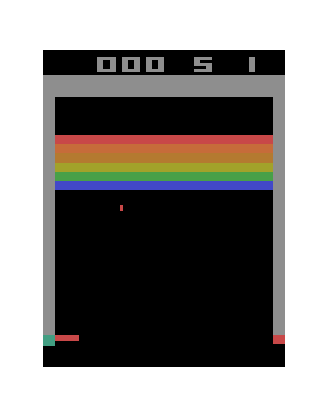
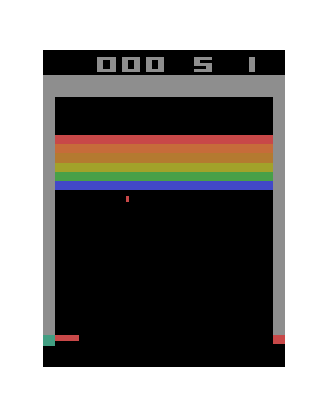
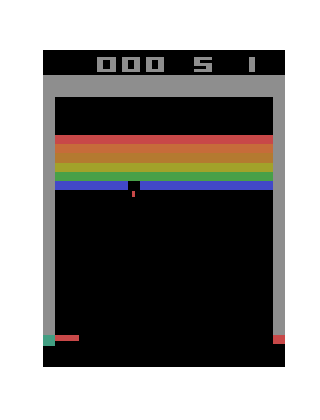
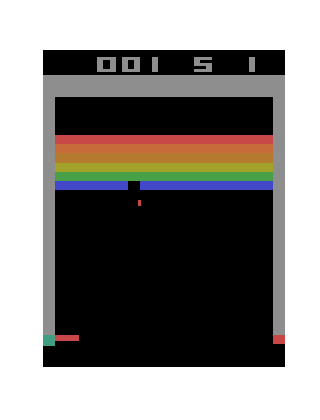
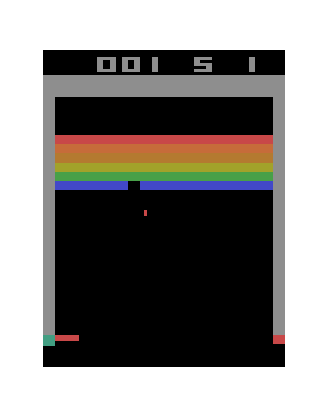
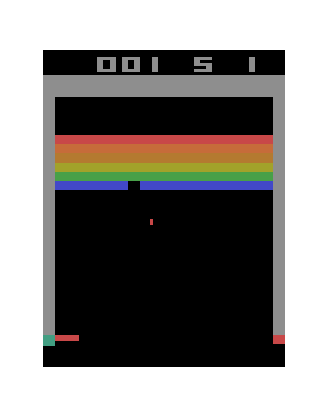
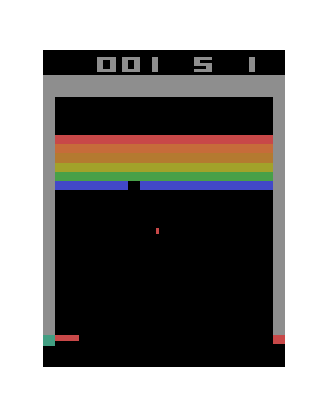
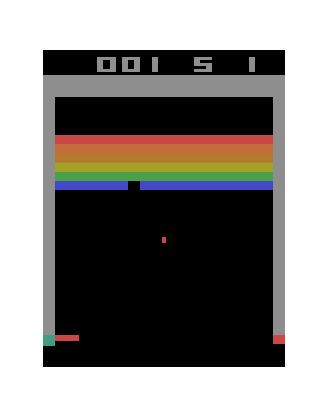
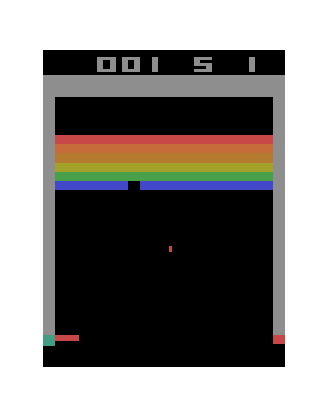
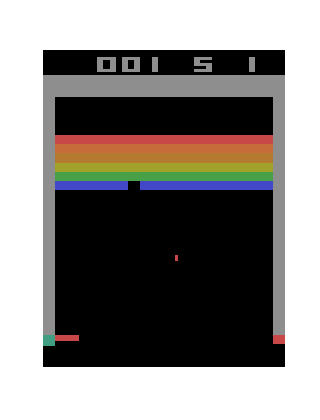
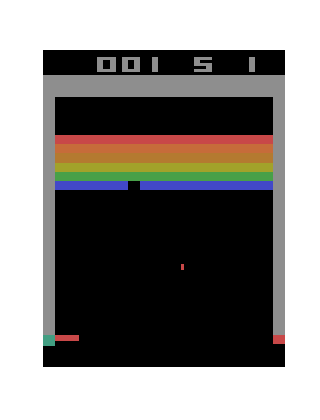
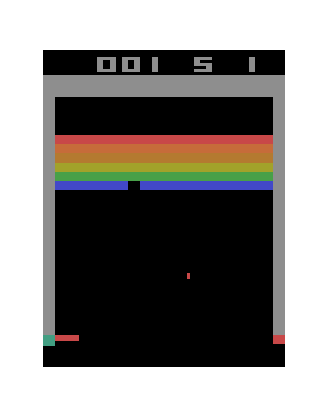
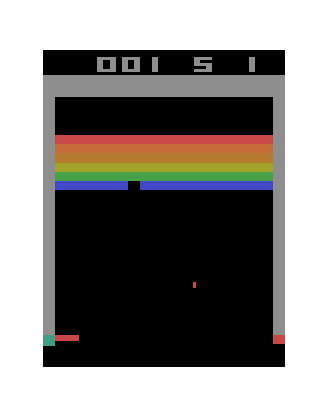
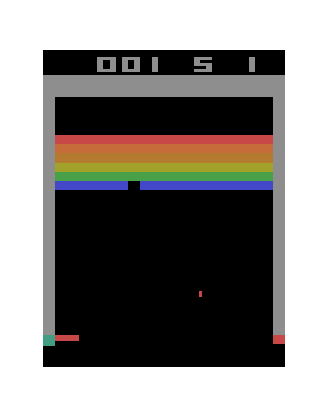
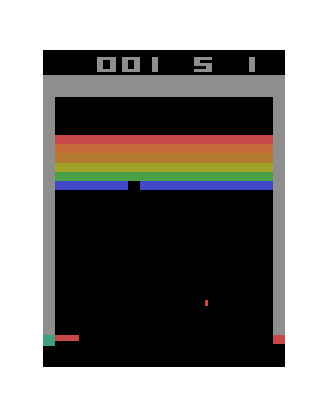
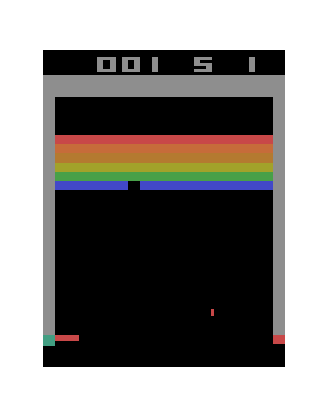
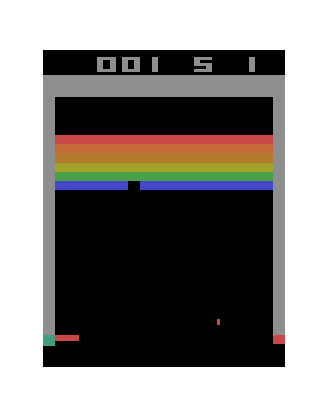
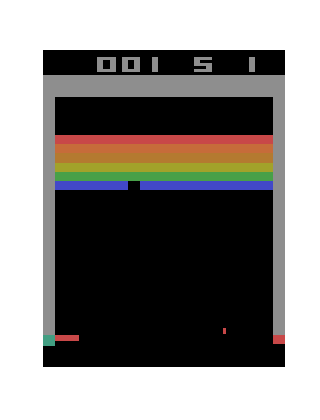
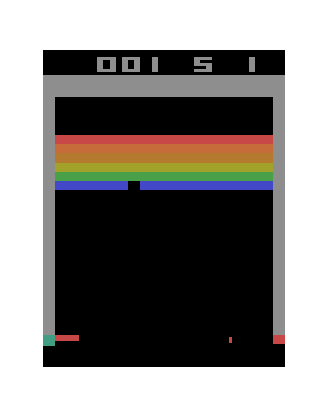
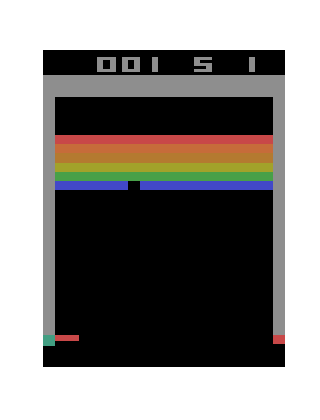
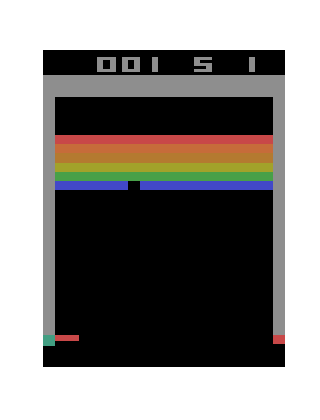
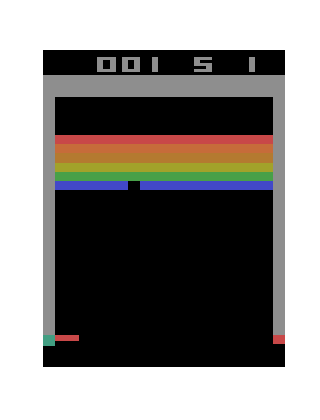
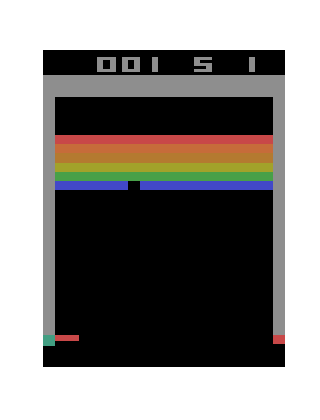
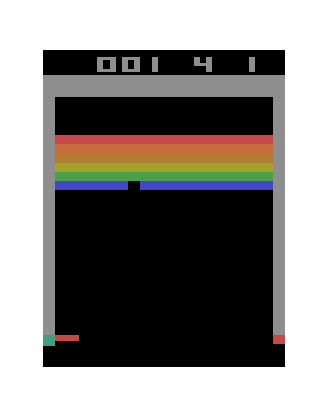
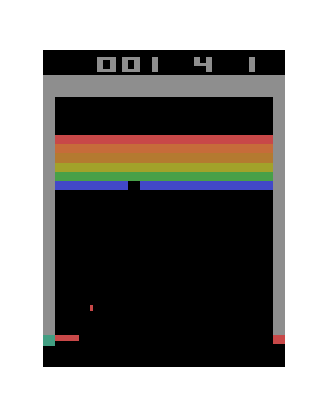
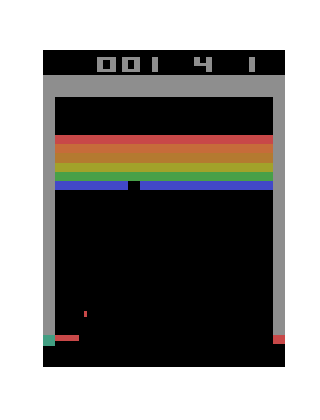
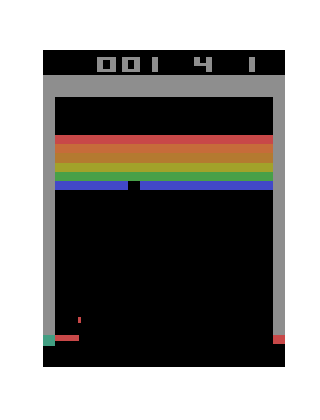
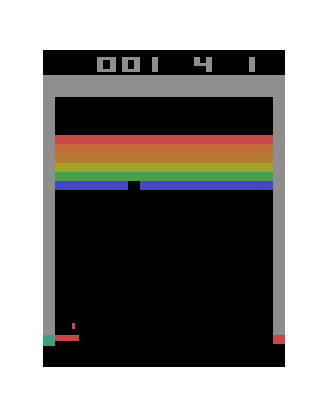
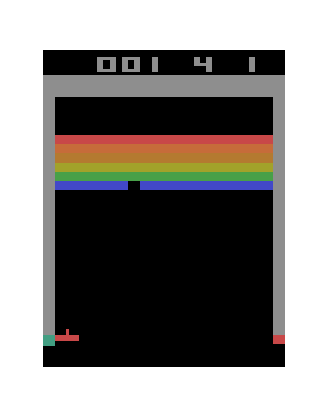
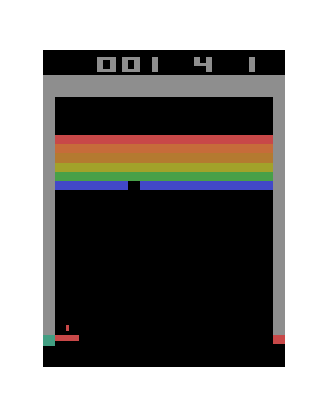
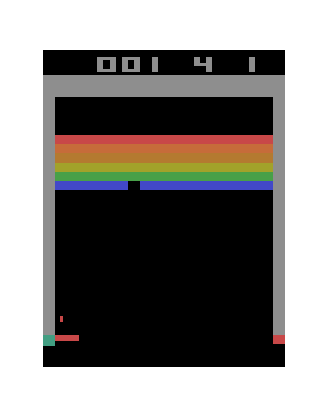
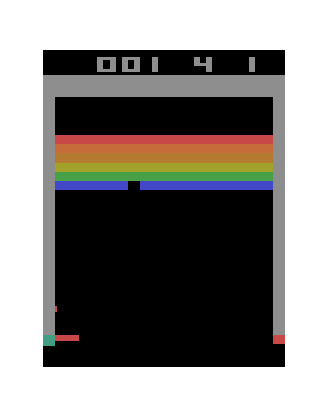
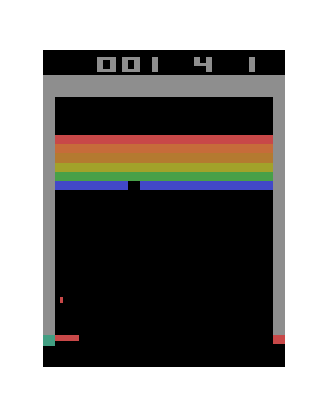
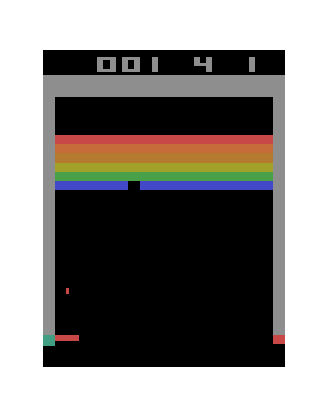
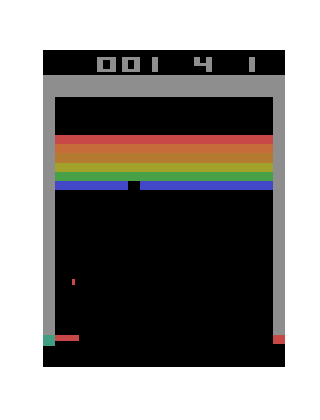
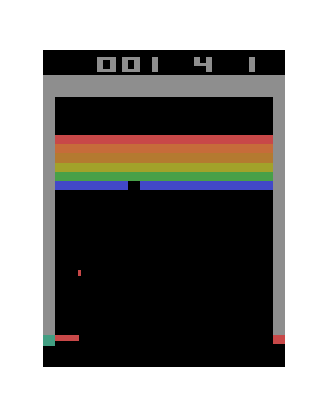
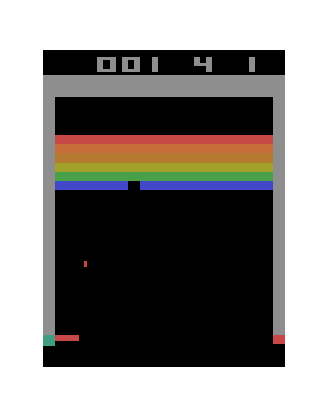
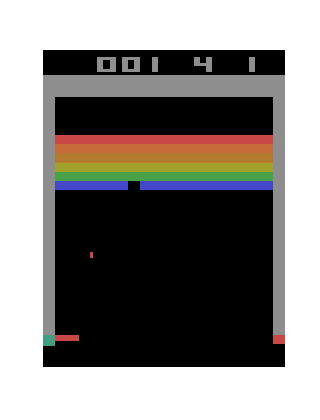
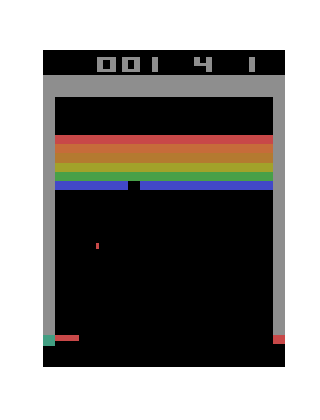
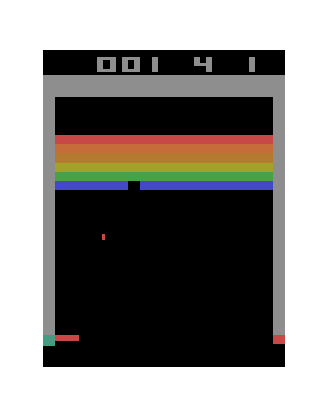
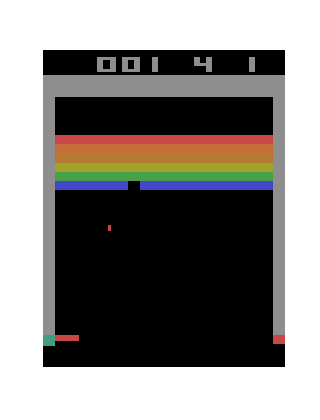
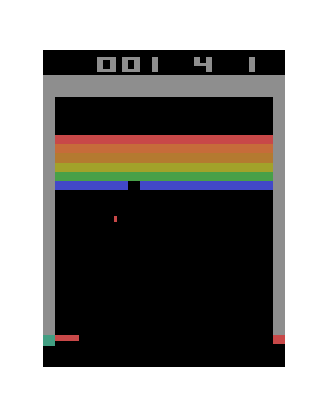
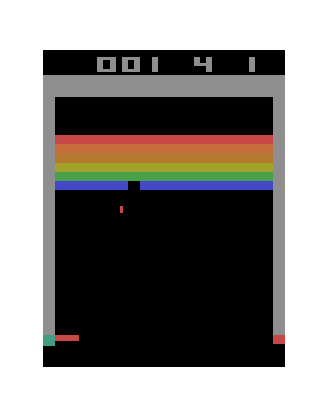
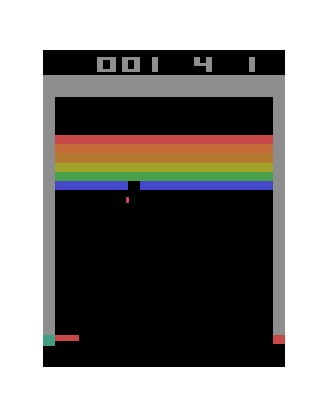
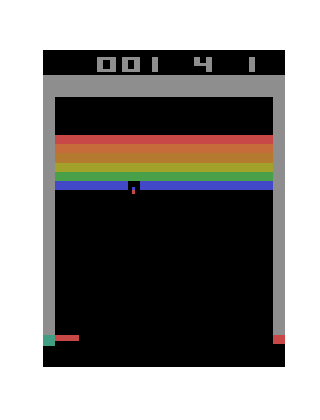
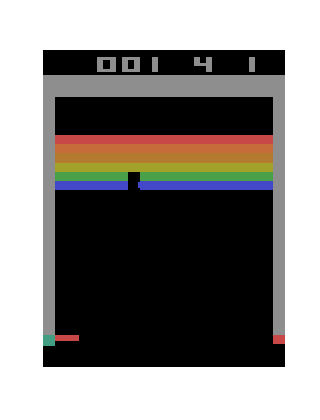
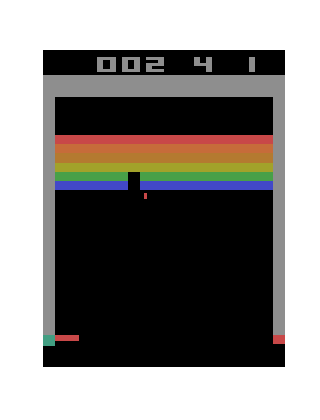
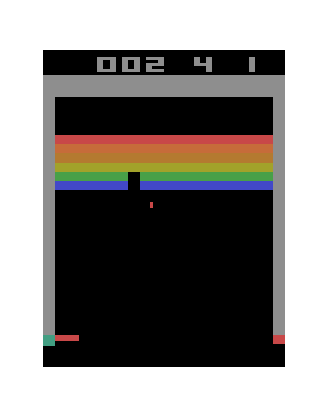
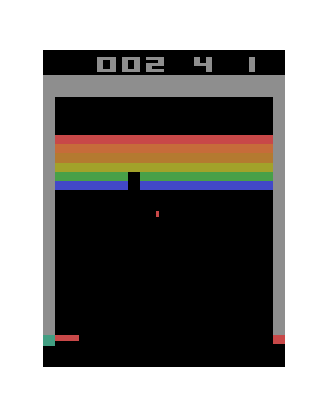
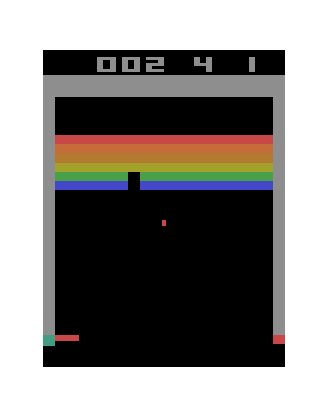
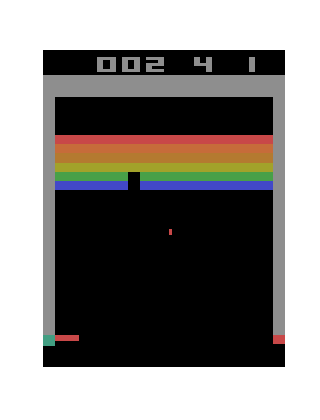
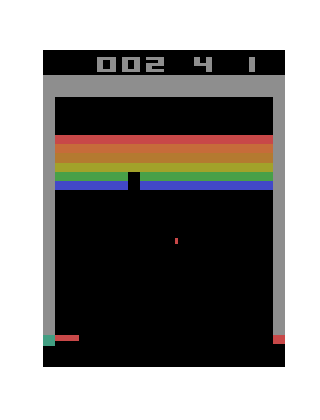
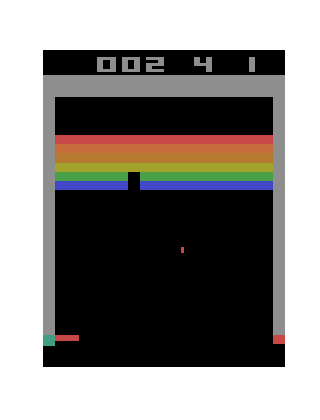
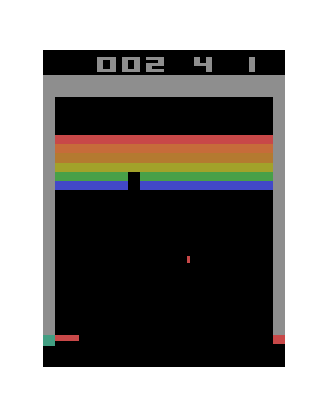
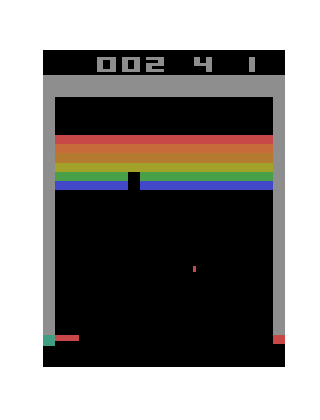
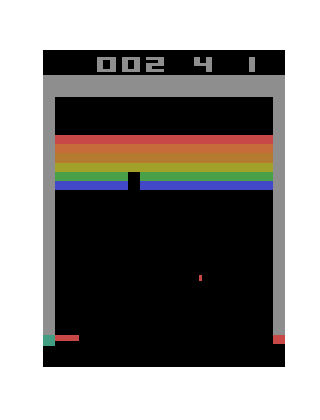
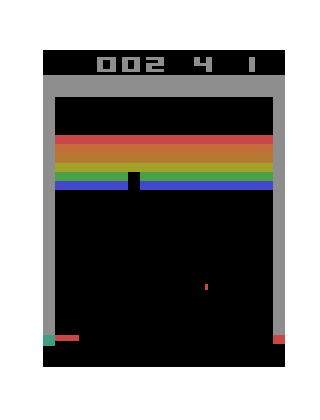
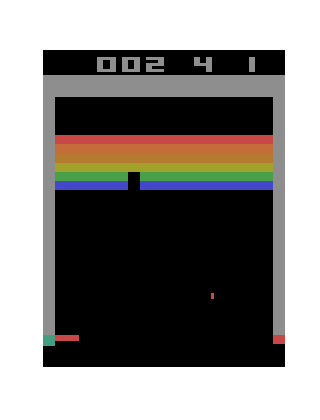
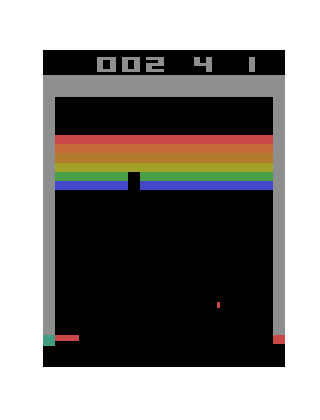
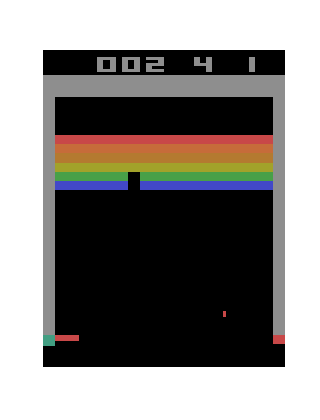
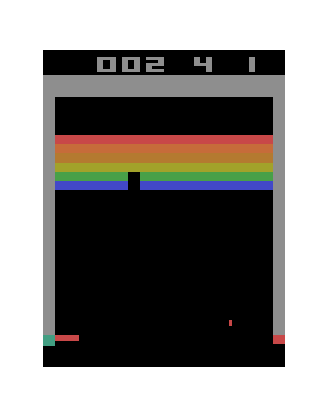
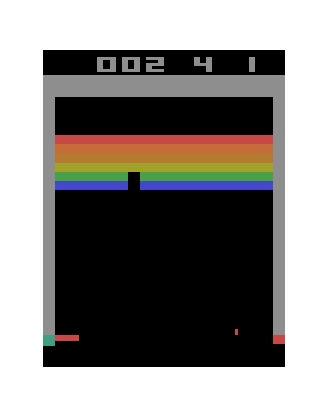
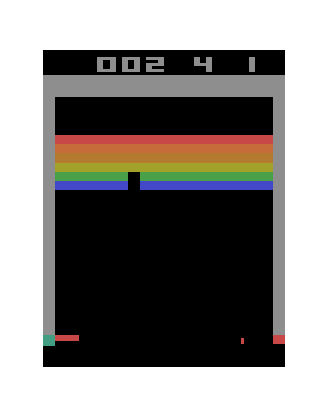
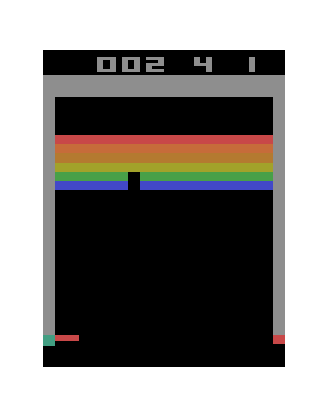
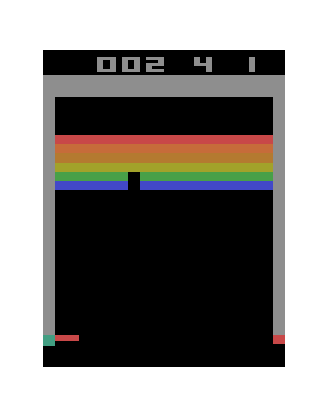
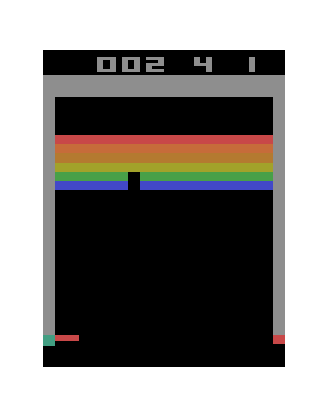
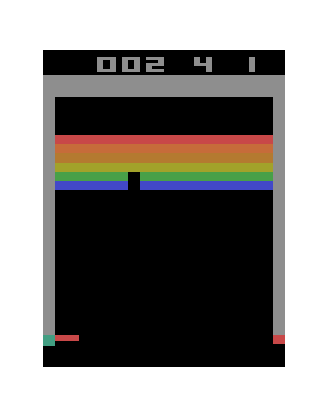
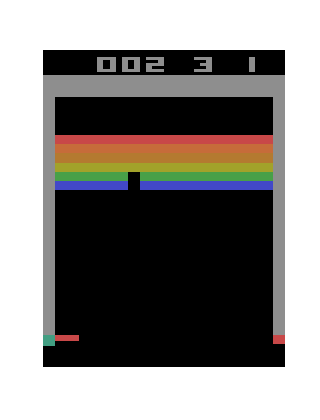

In [6]:
a2c.test_node_selector=MaxNodeChooser()
Env.test=True
a2c.test(test_step=300)
Env.test=False
Env.animation.run()
Env.animation.reset()


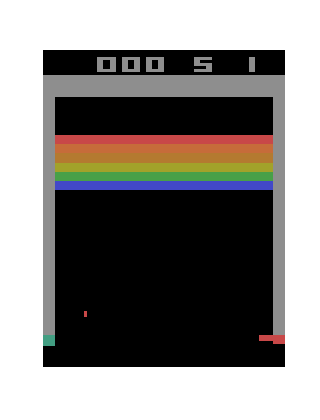
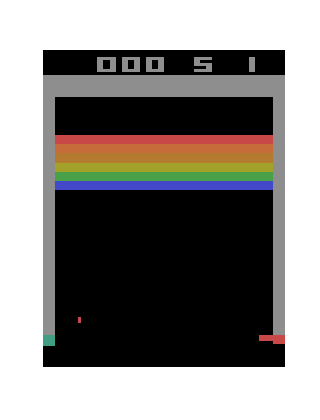
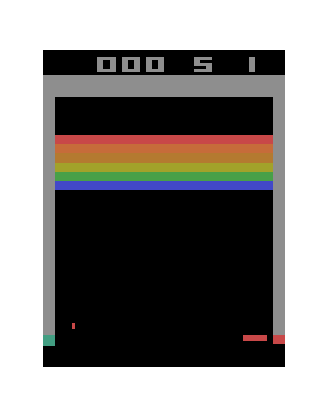
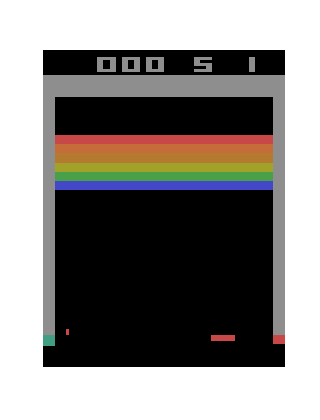
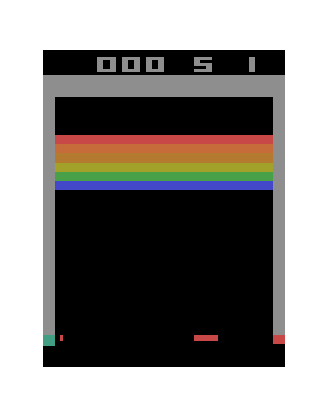
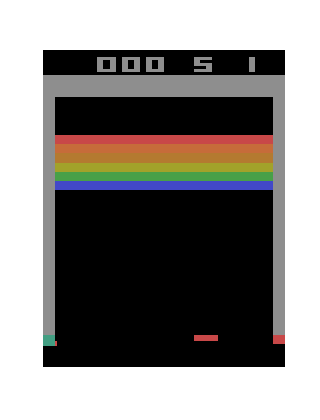
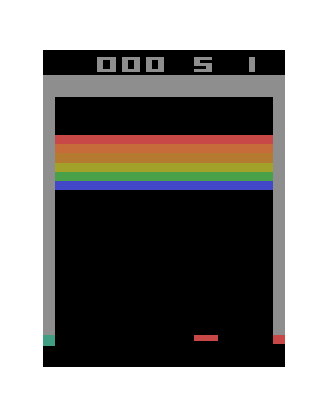
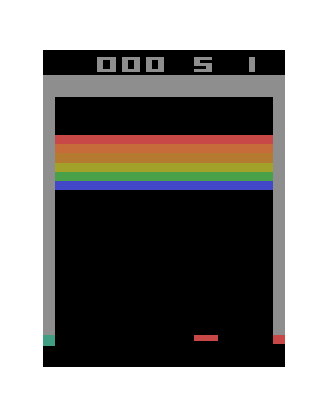
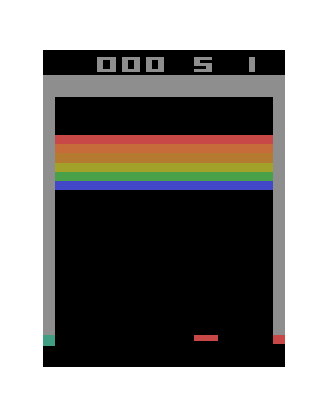
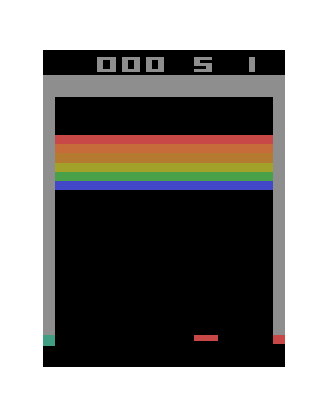
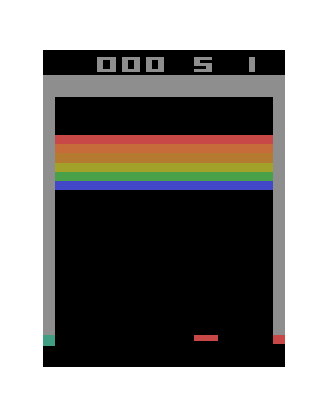
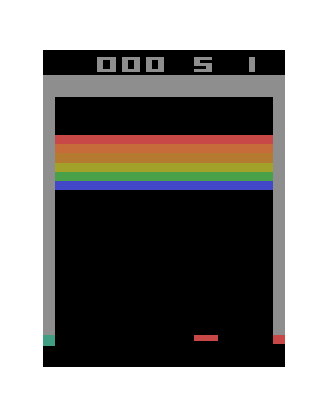
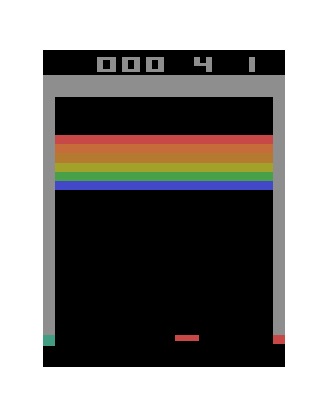
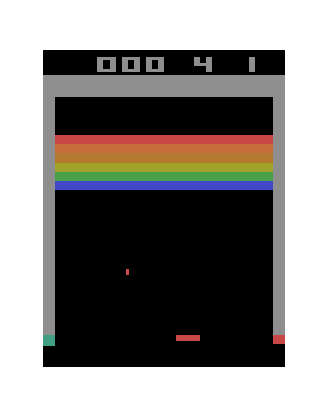
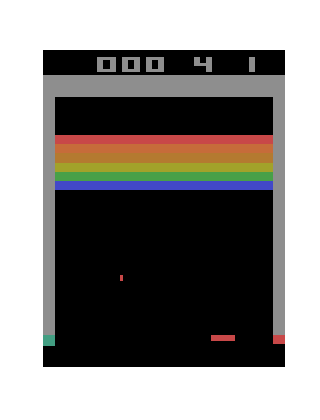
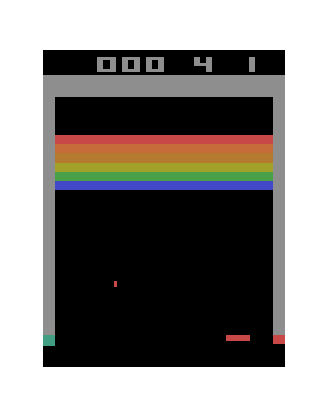
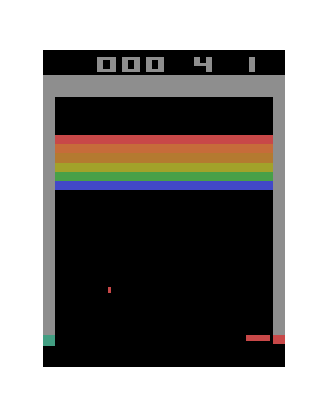
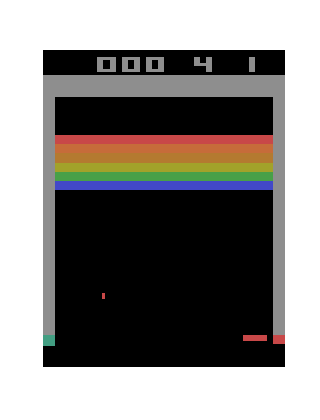
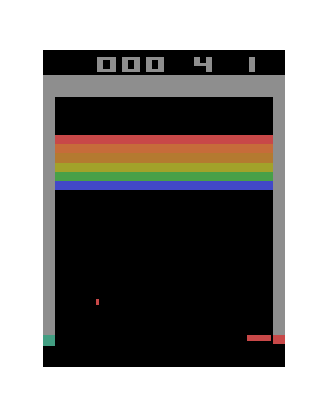
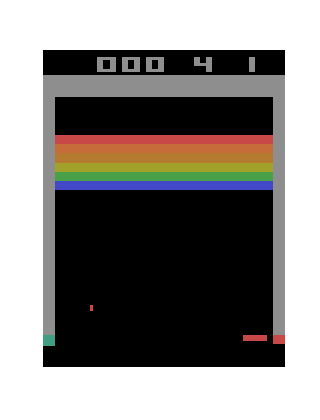
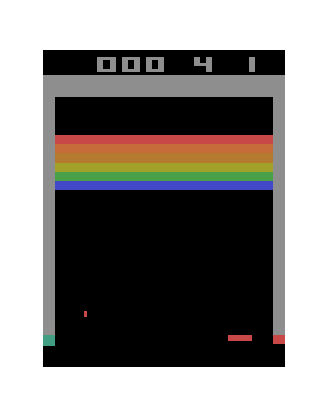
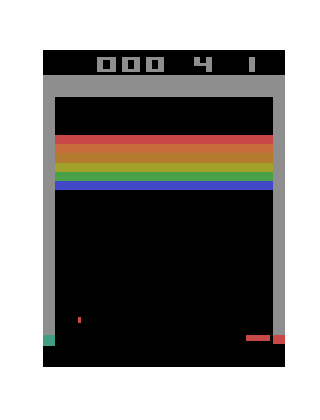
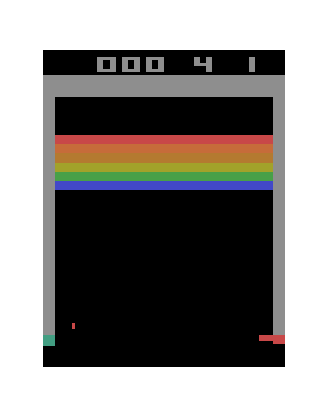
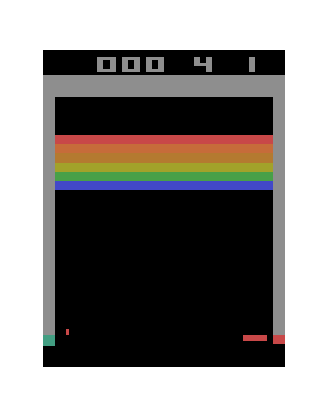
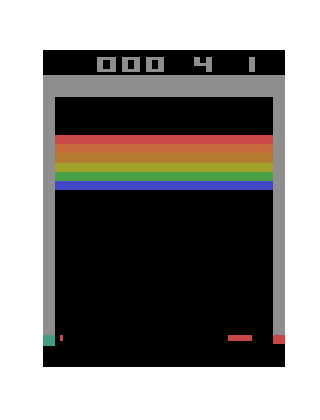
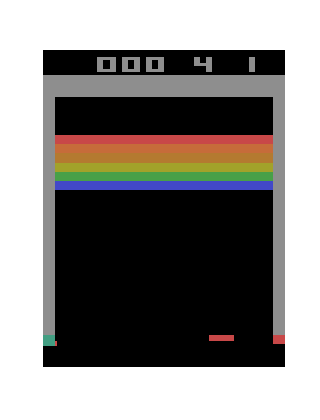
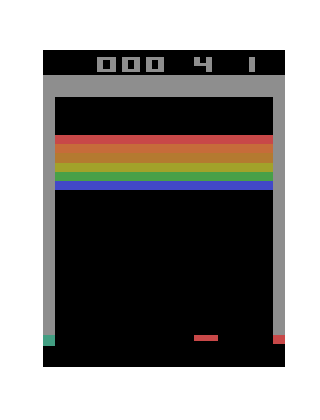
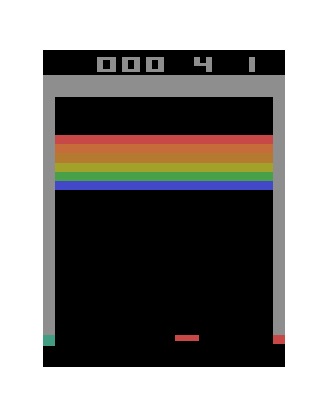
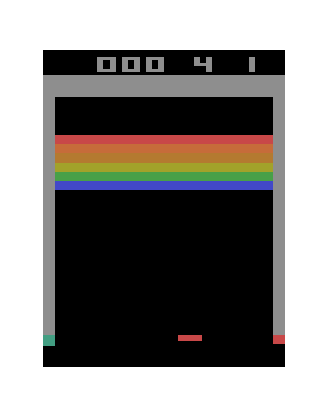
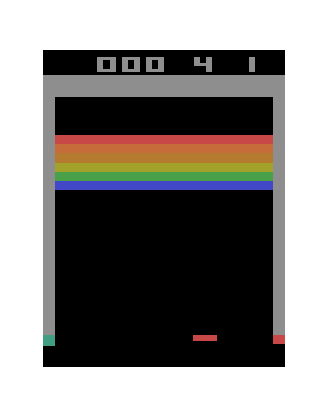
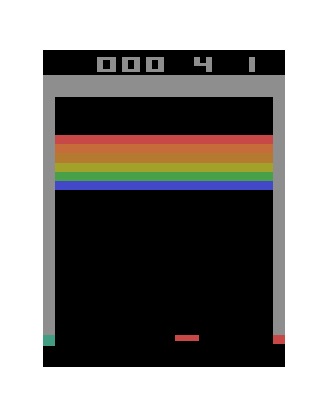
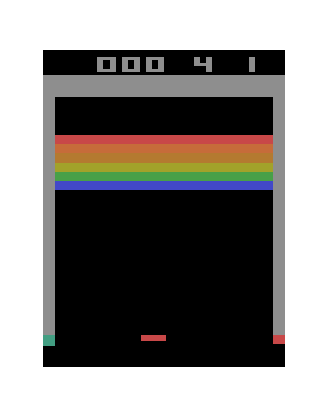
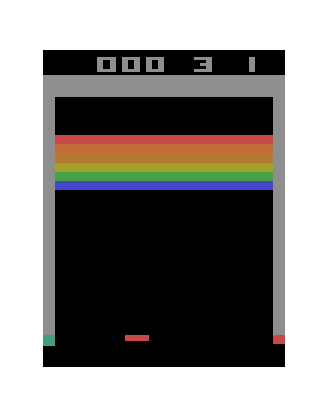
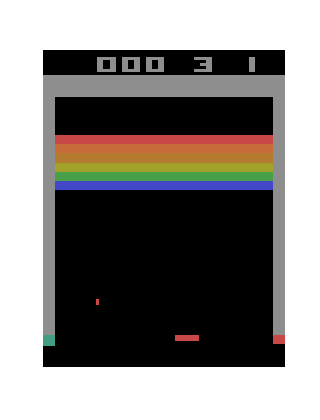
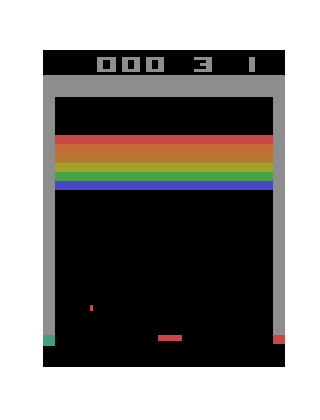
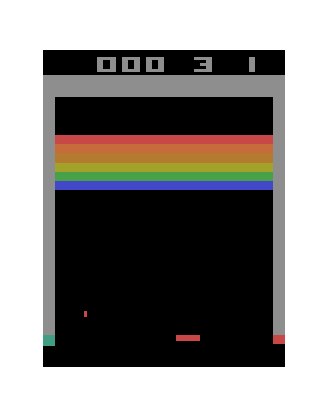
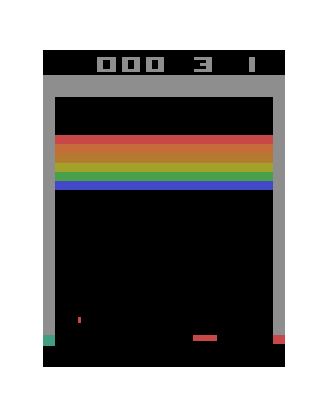
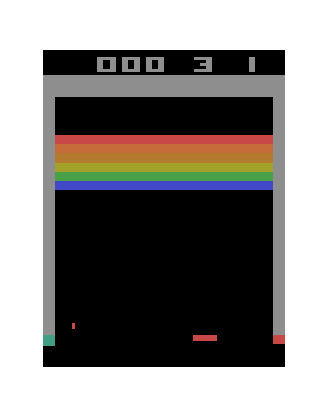
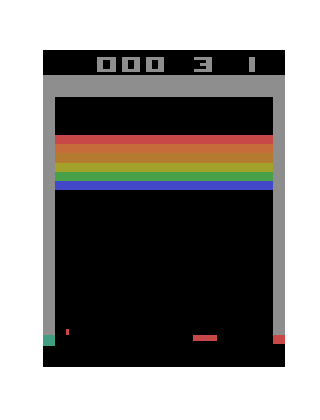
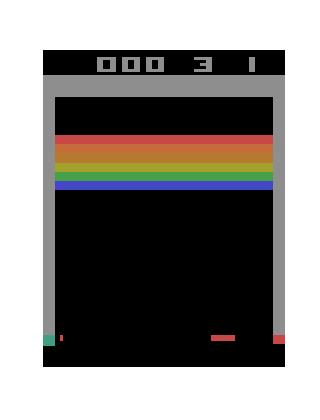
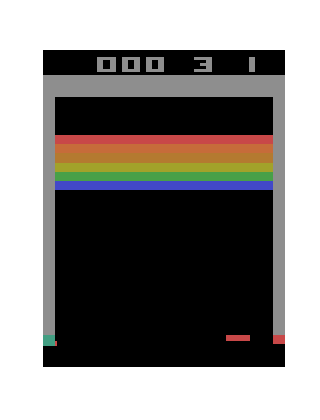
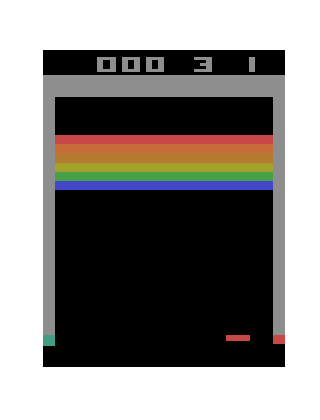
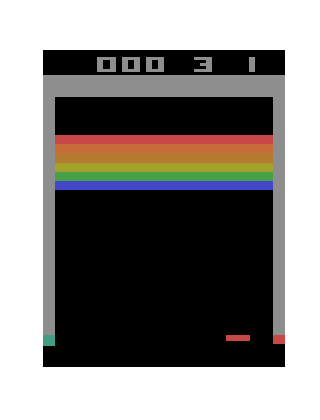
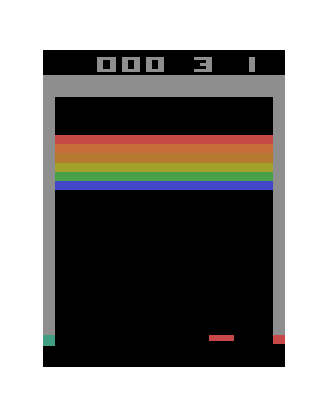
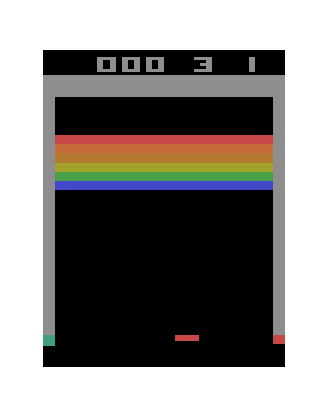
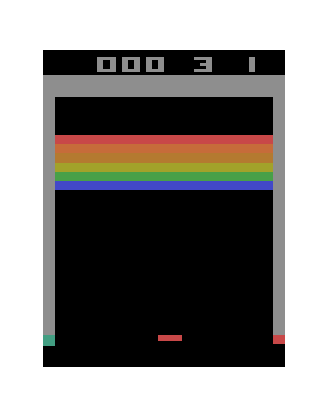
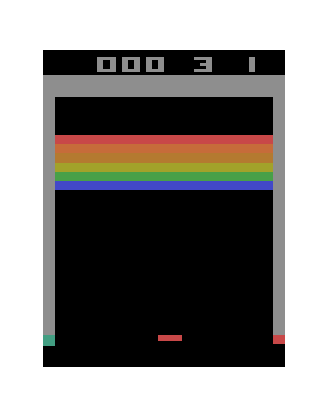
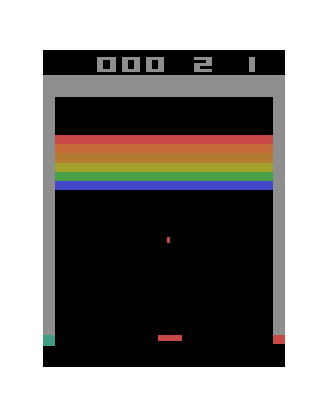
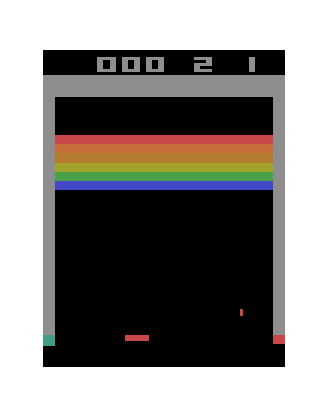
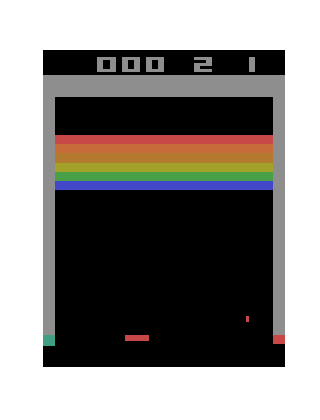
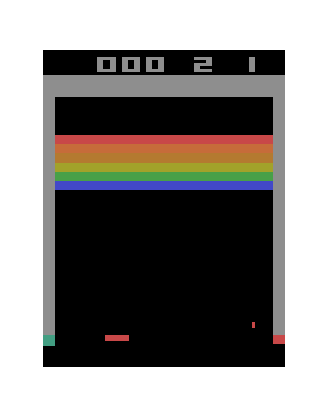
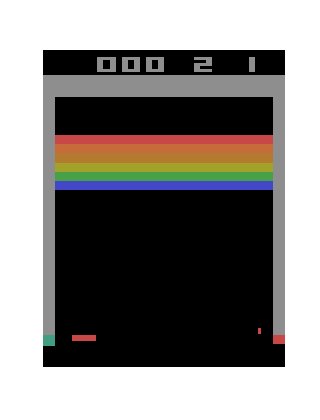
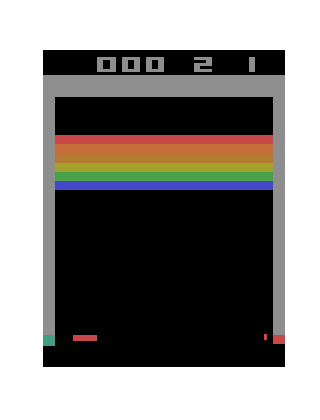
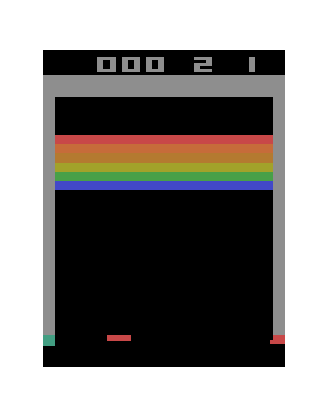
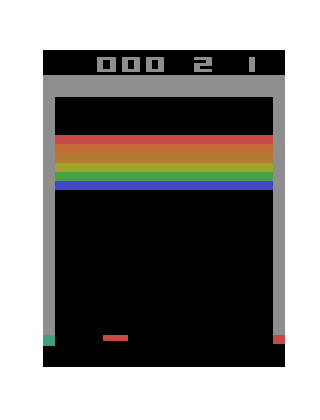
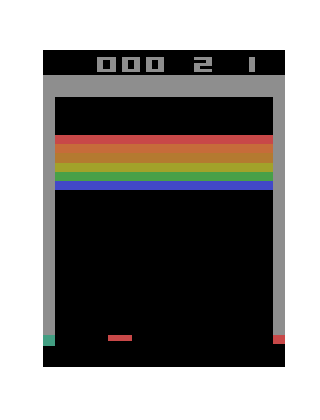
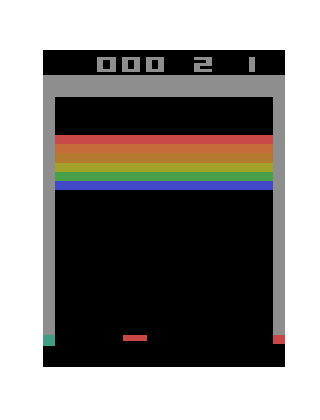
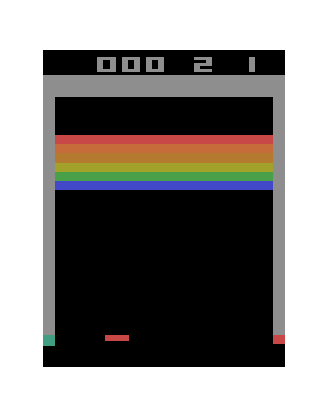
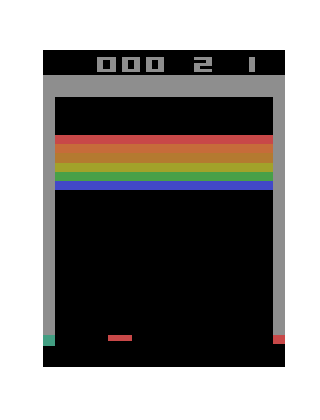
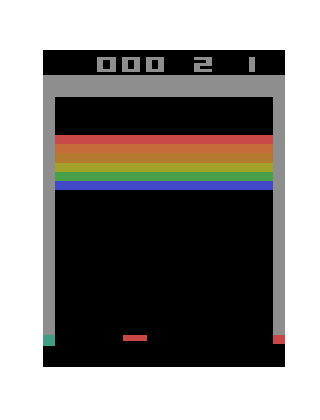
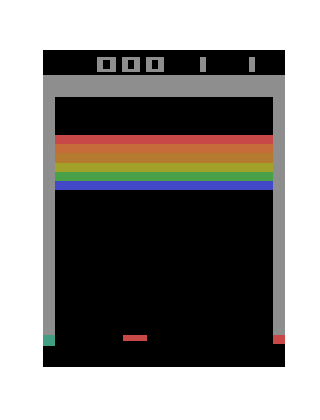
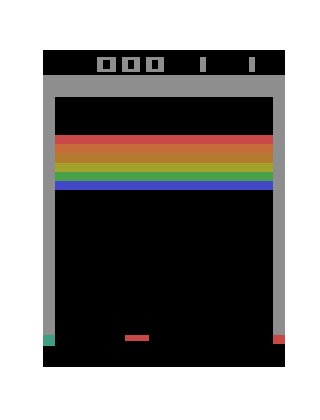
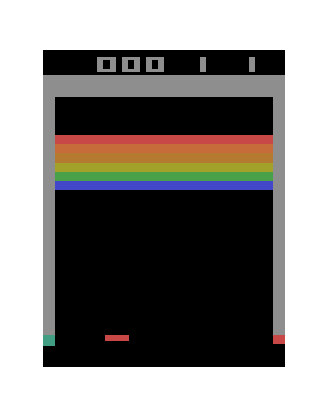
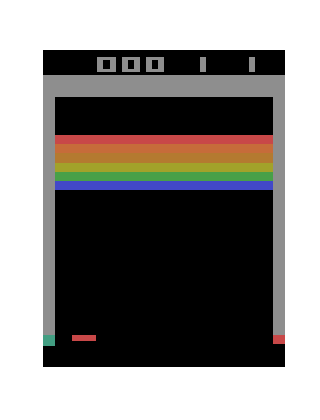
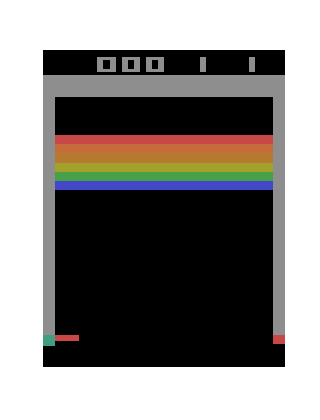
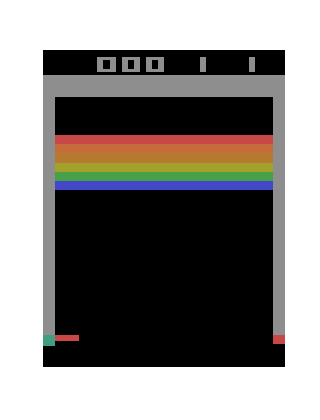
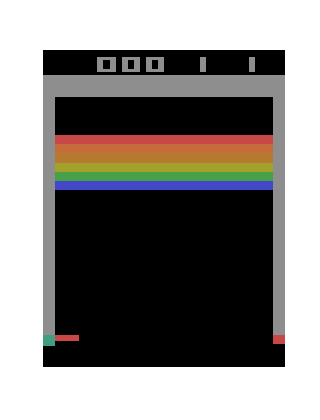
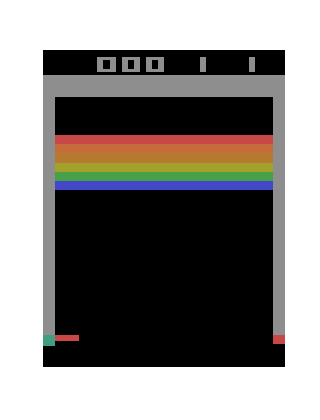
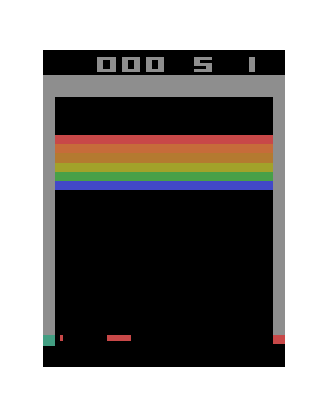
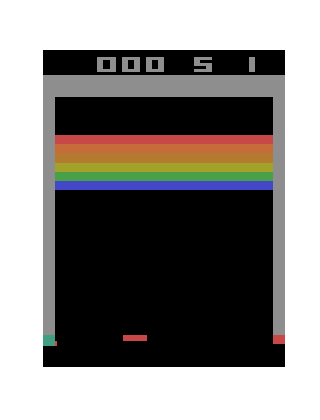
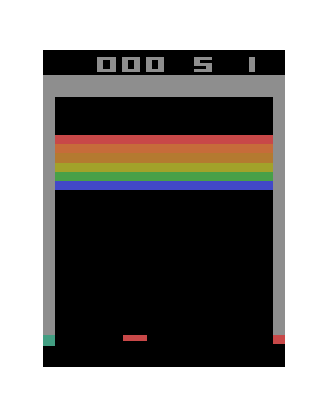
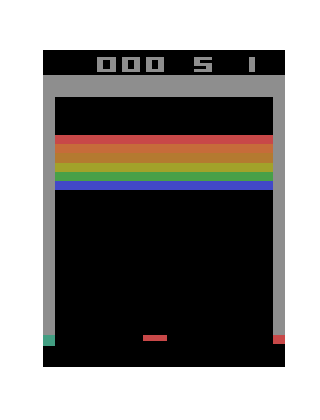
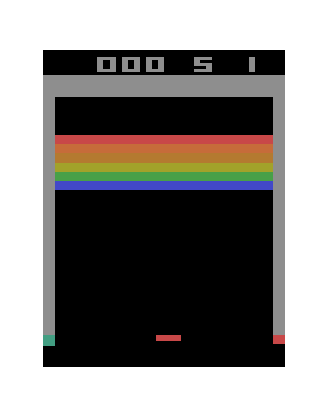
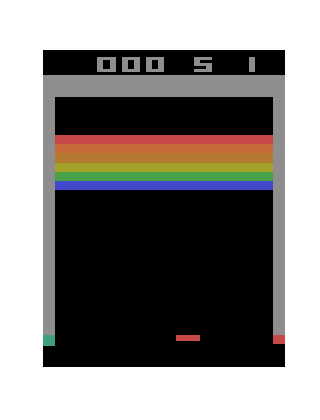
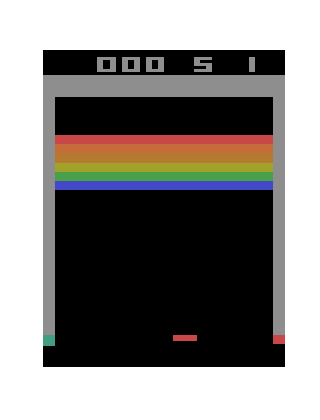
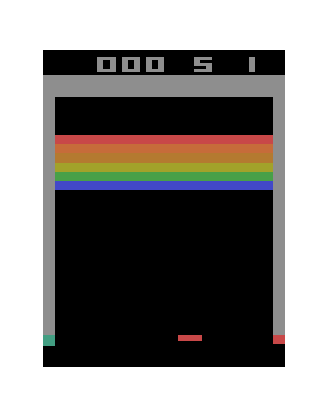
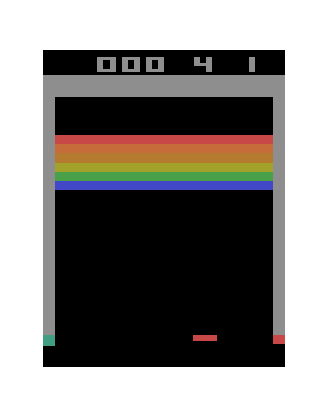
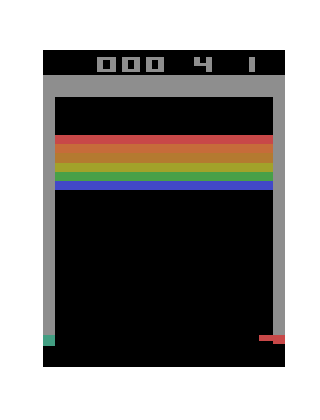
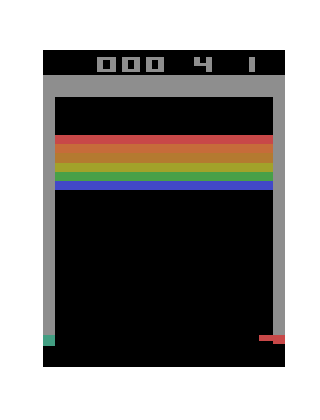
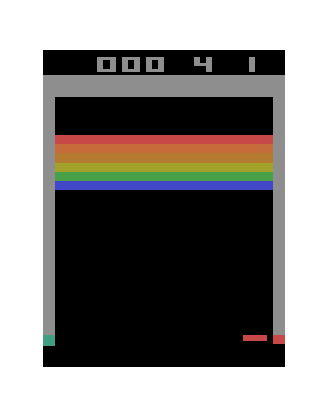
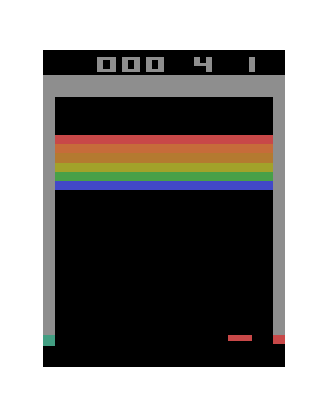
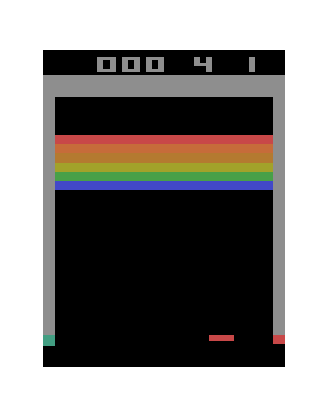
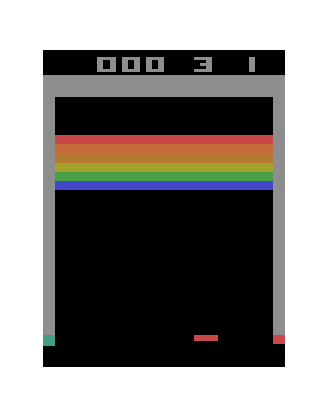
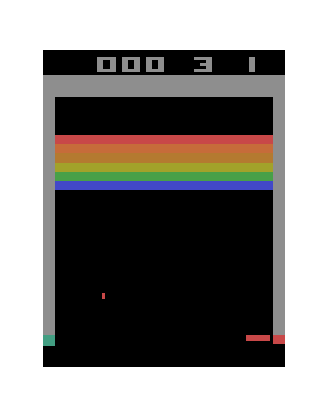
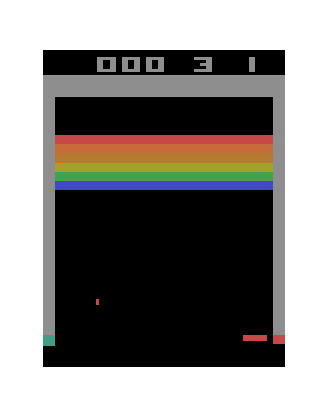
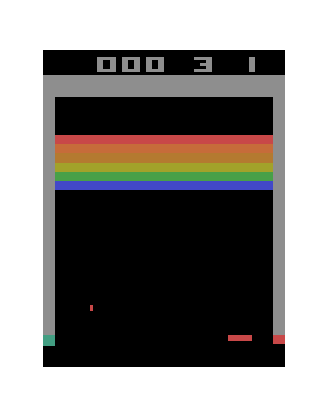
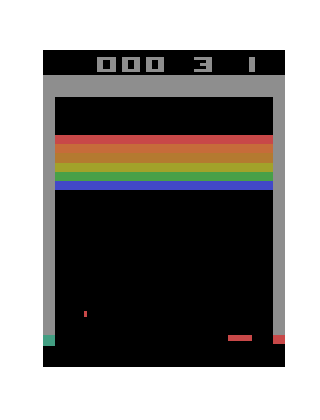
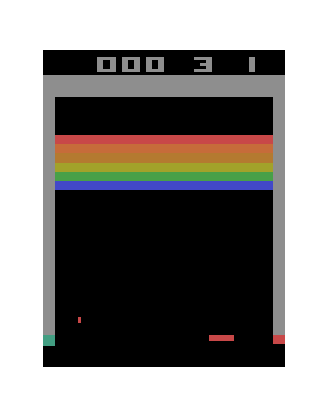
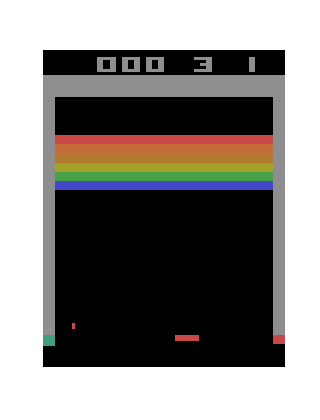
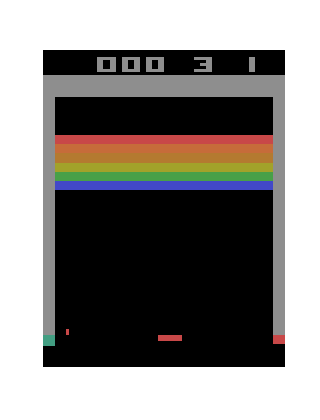
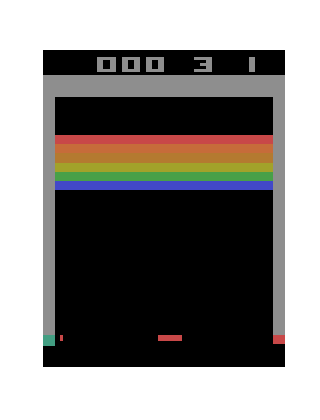
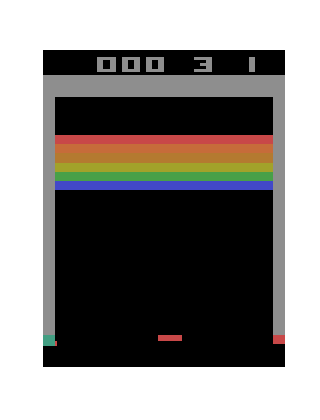
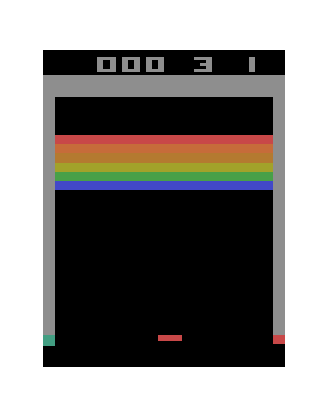
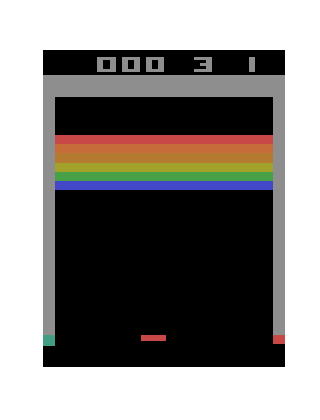
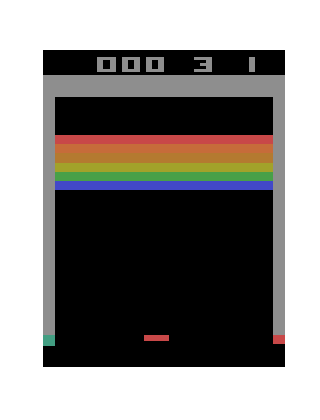
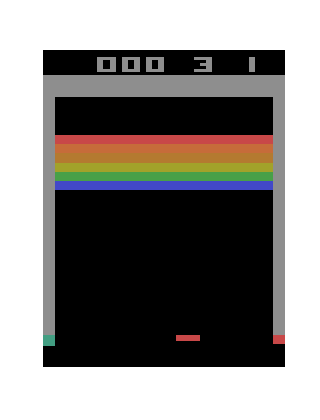
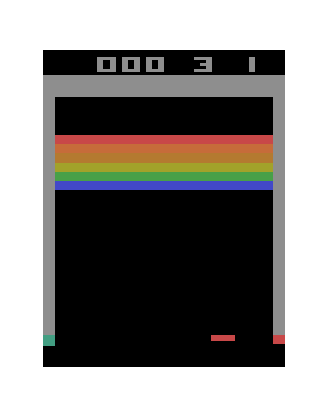
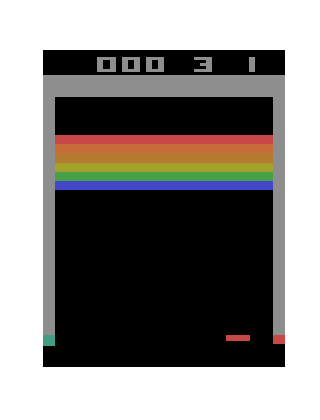
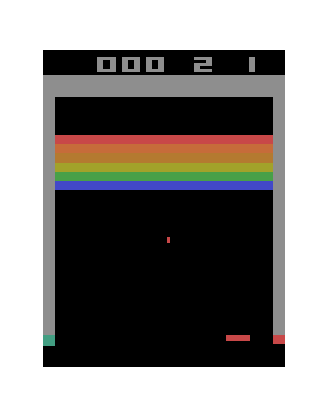
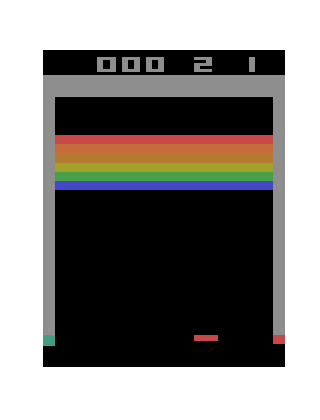
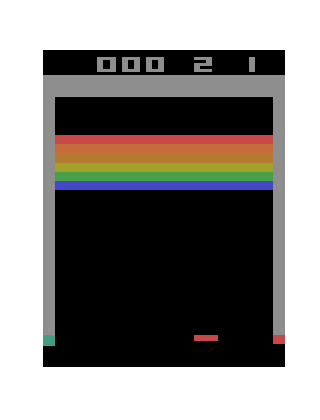
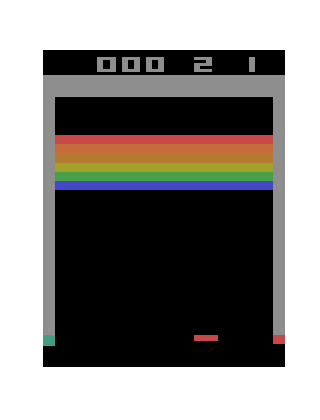
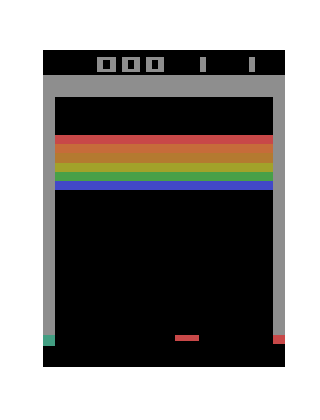
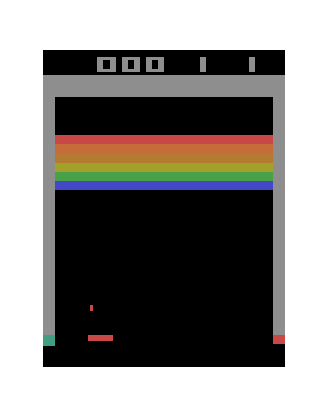
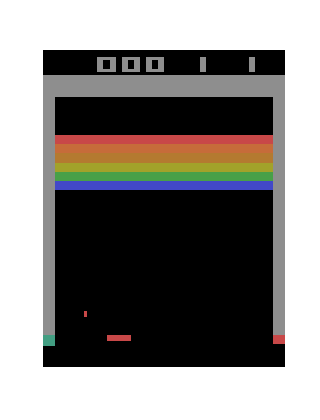
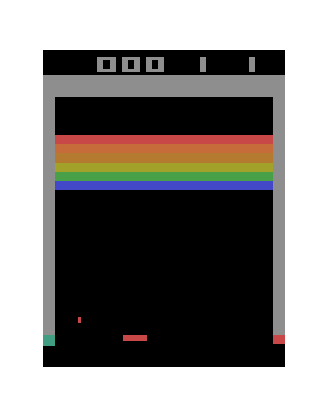
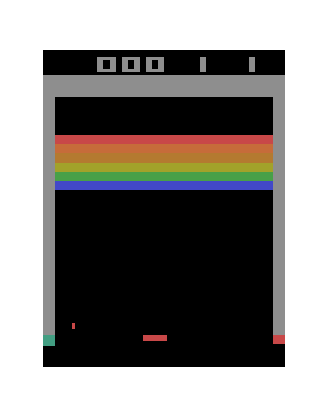
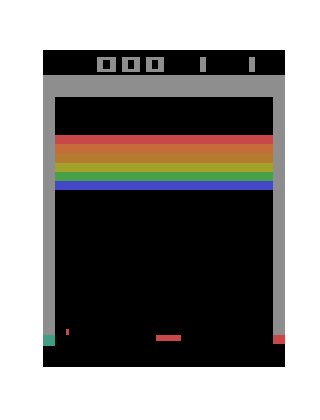
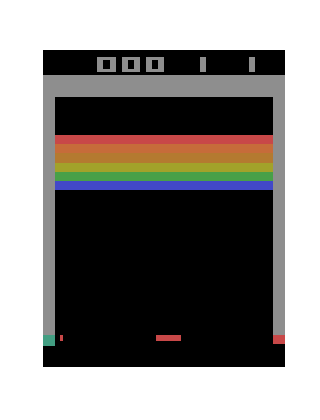
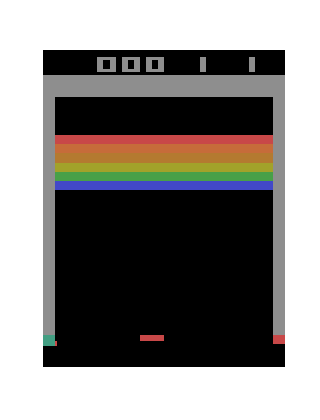
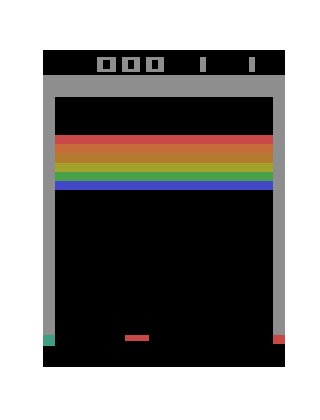
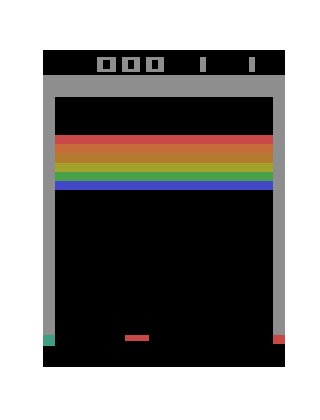
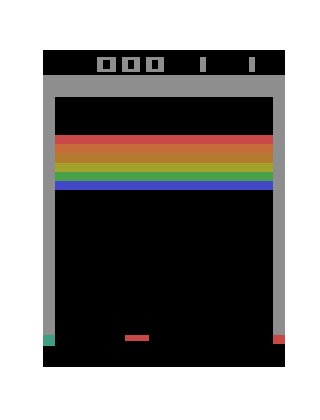
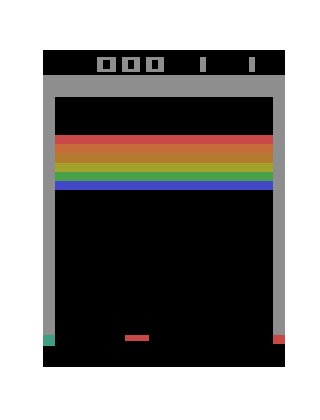
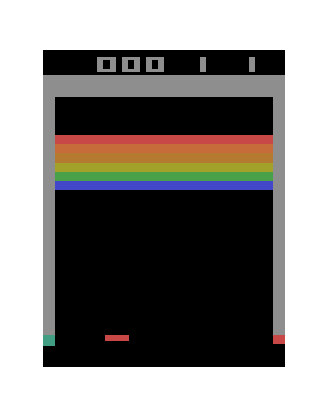
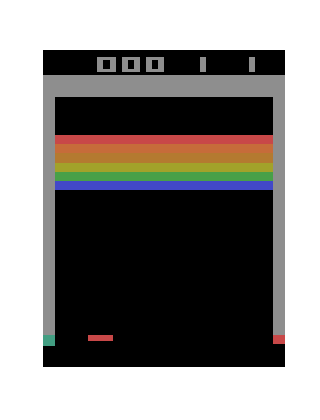
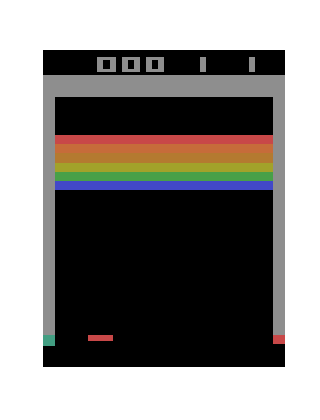
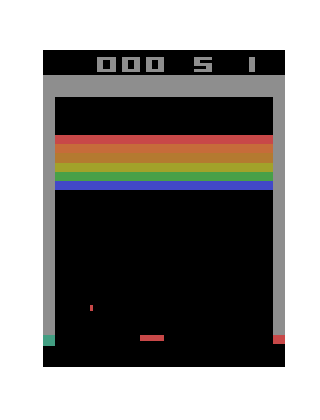
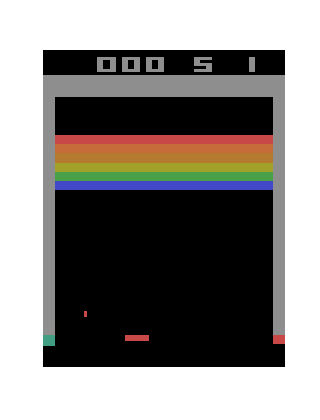
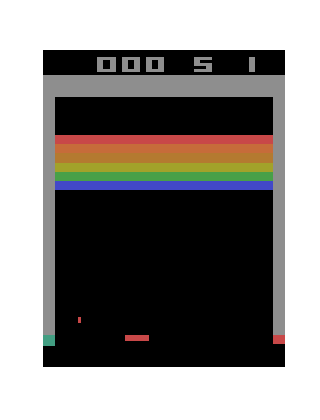
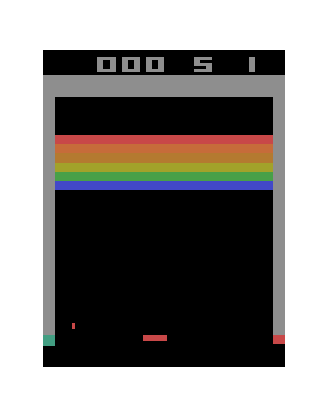
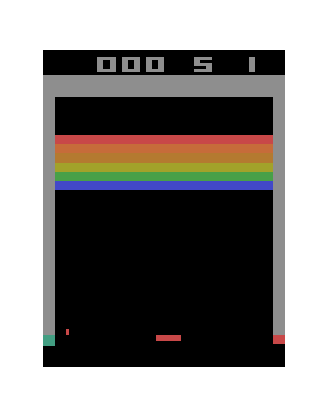
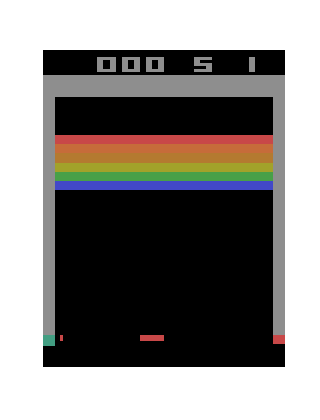
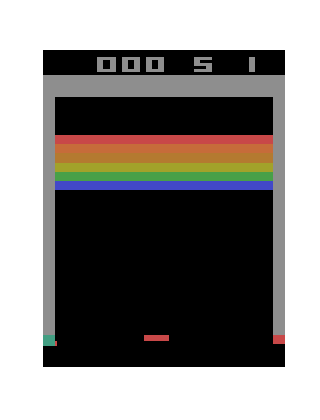
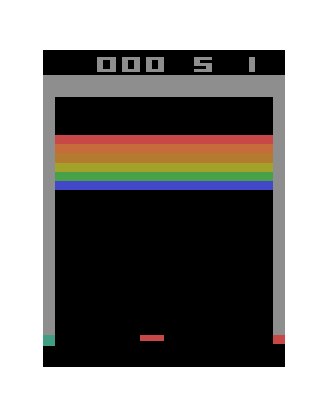
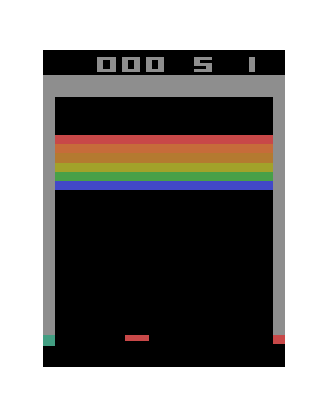
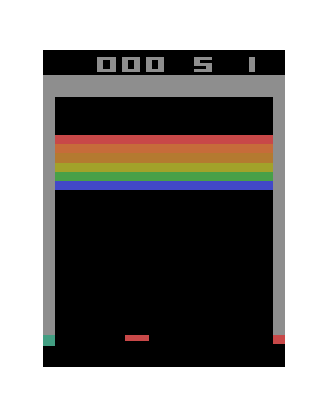
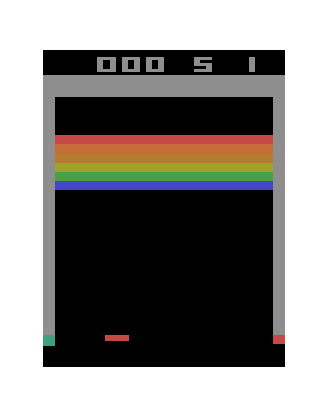
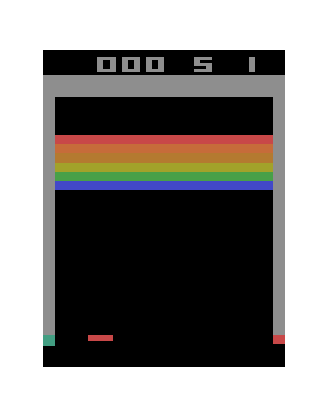
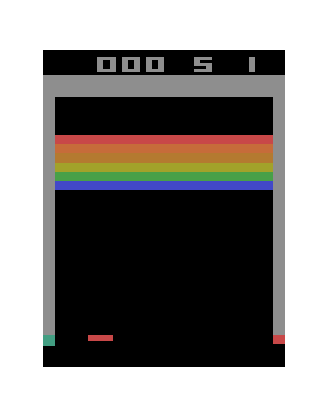
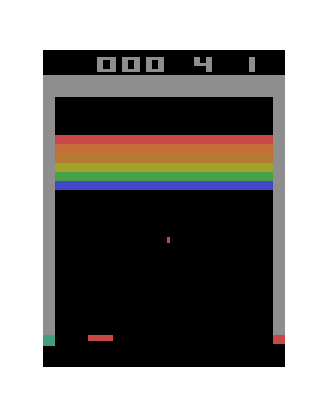
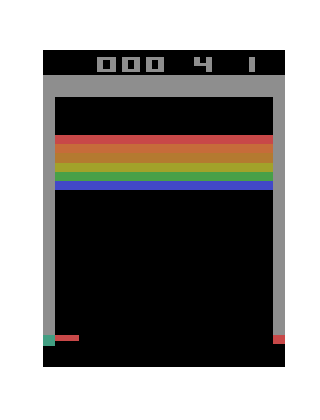
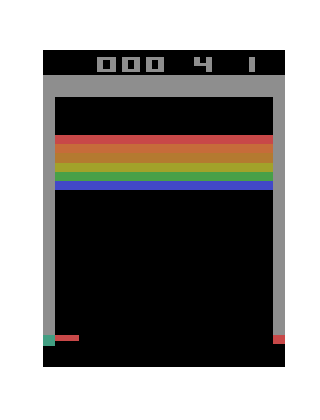
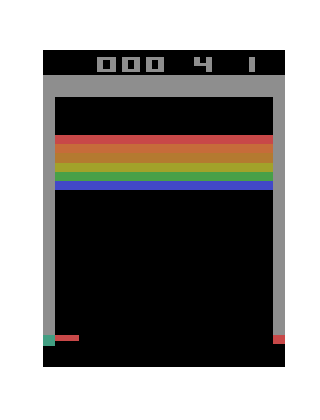
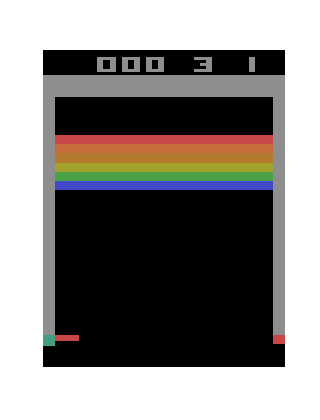
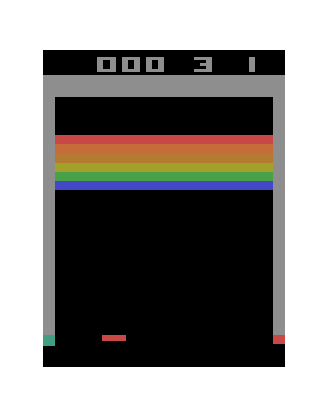
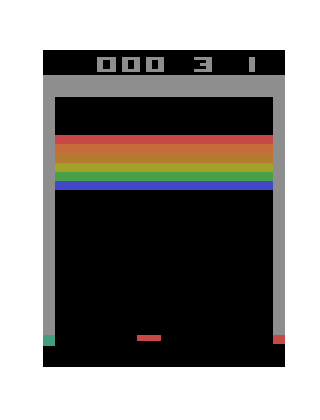
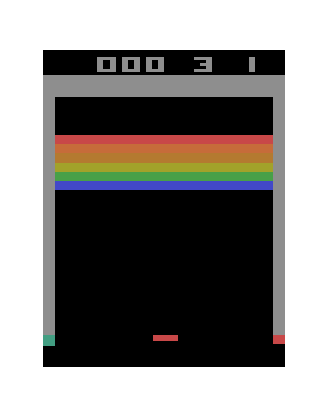
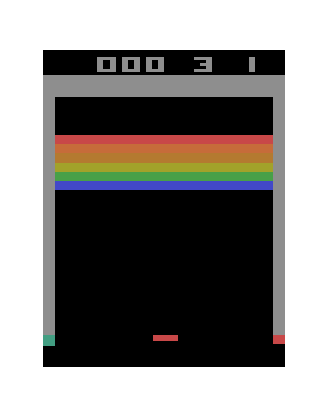
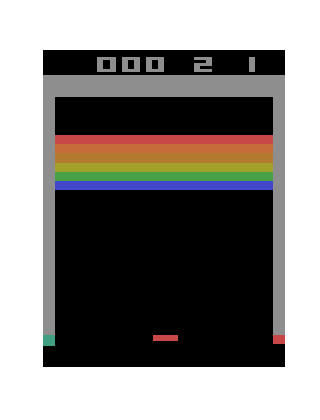
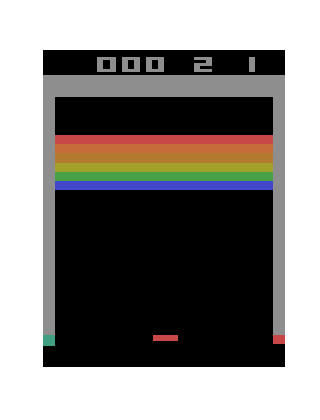
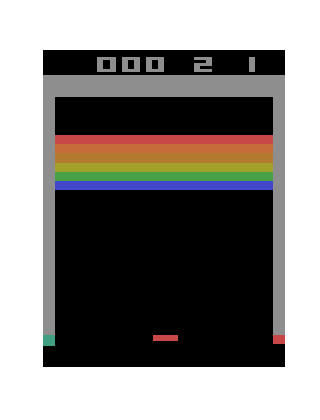
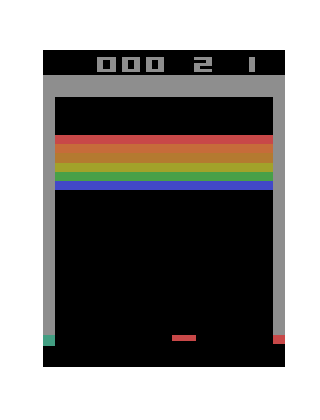
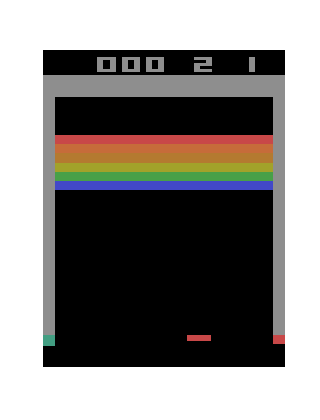
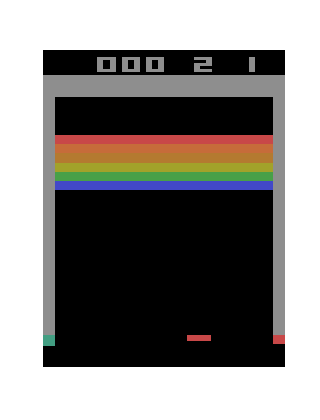
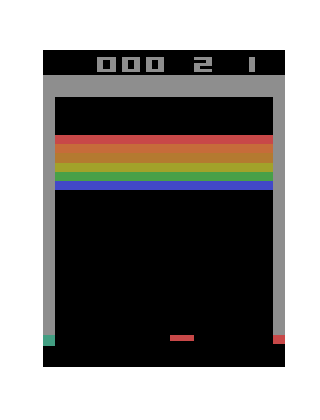
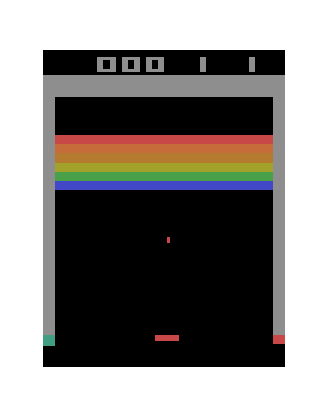
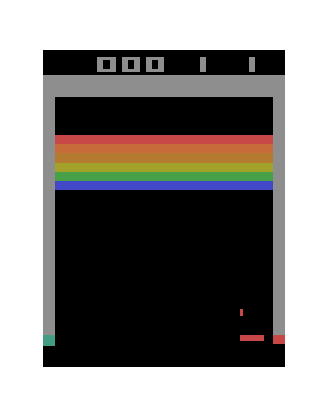
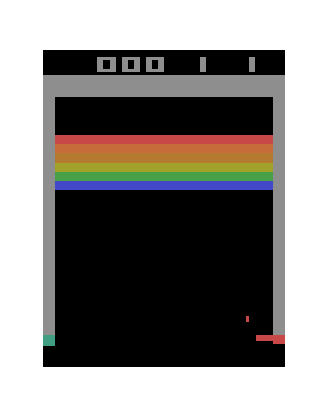
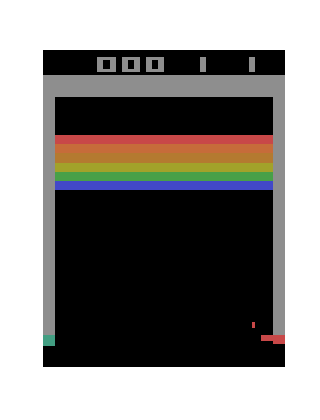
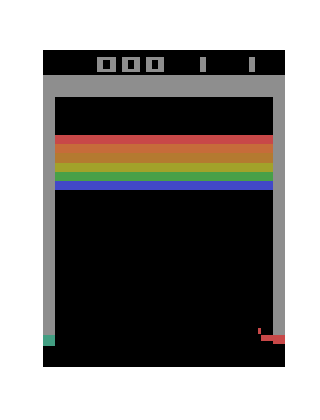
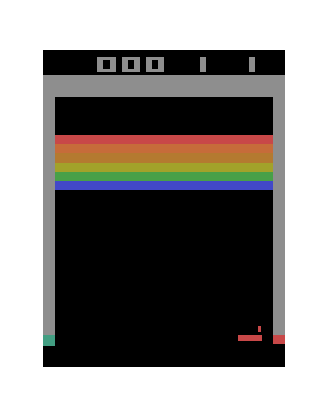
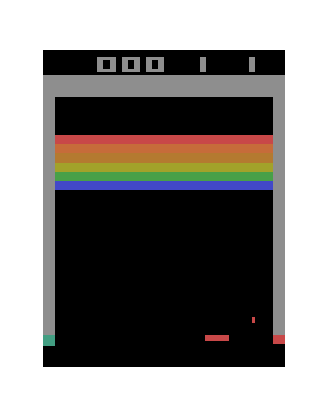
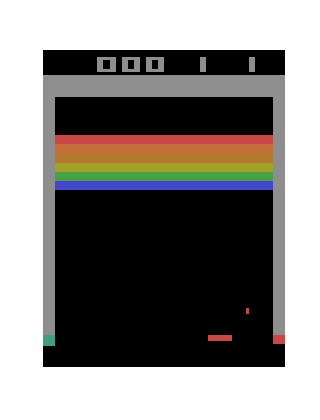
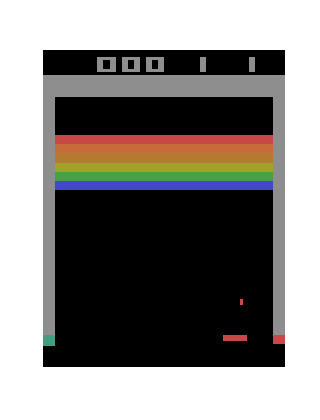
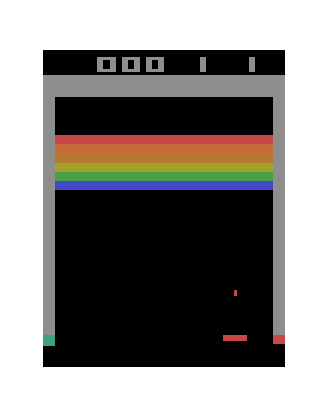
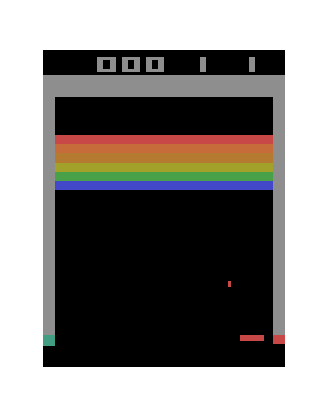
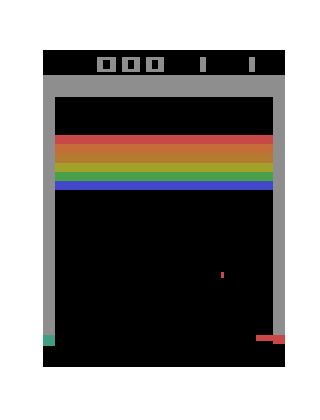
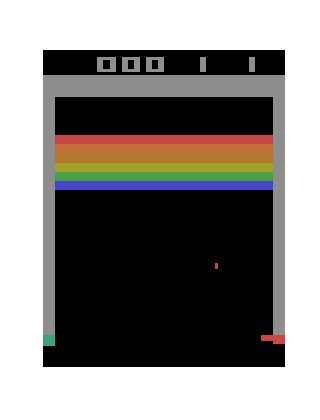
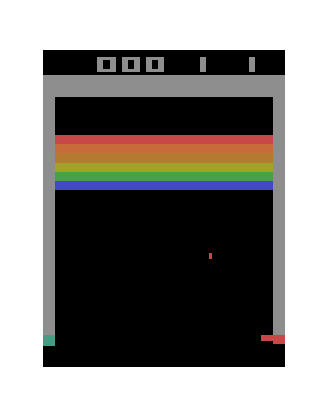
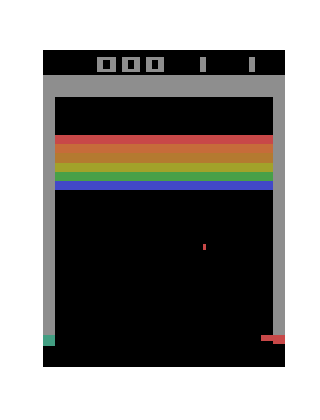
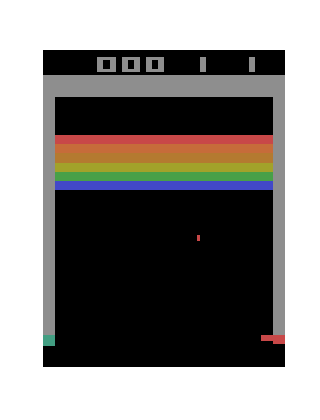
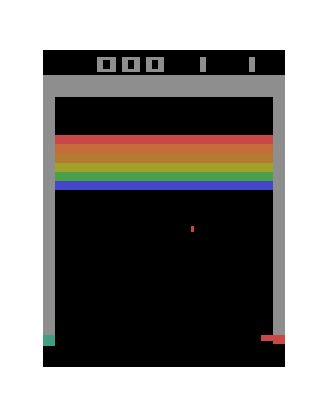
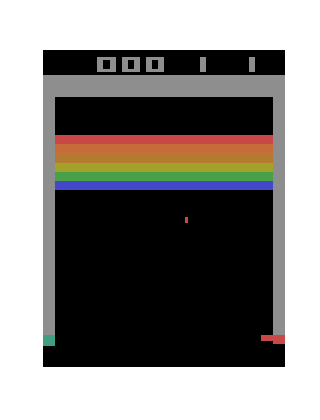
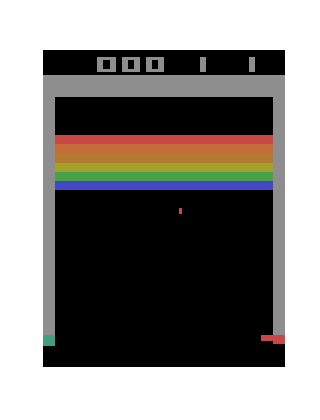
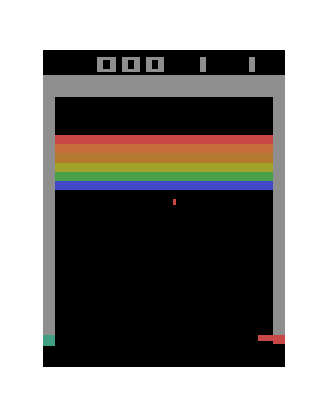
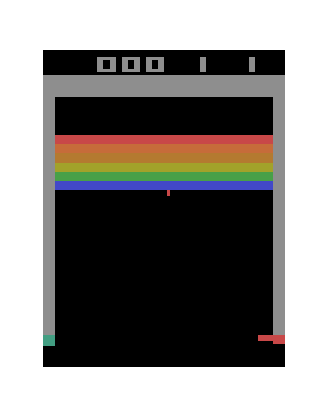
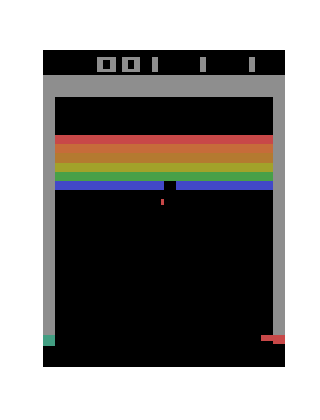
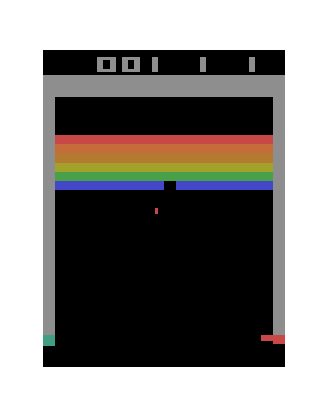
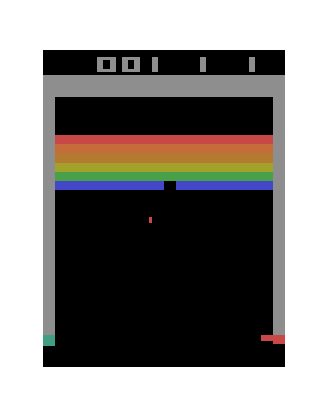
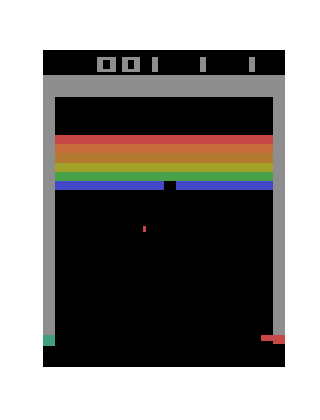
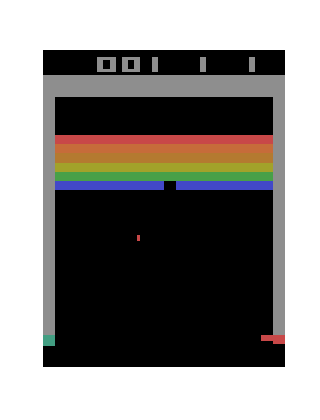
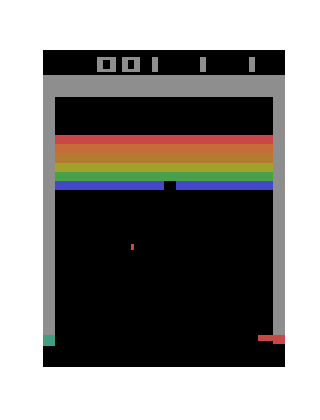
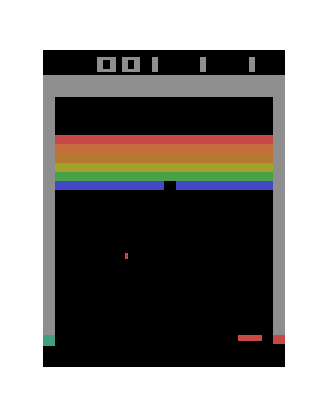
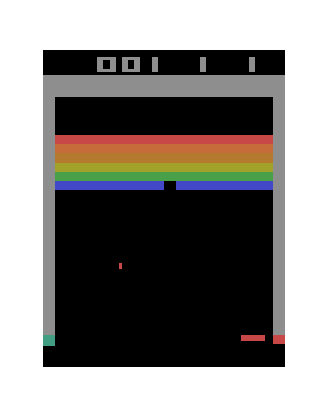
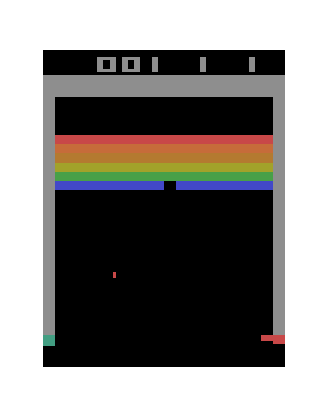
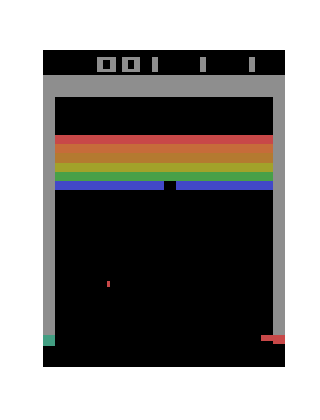
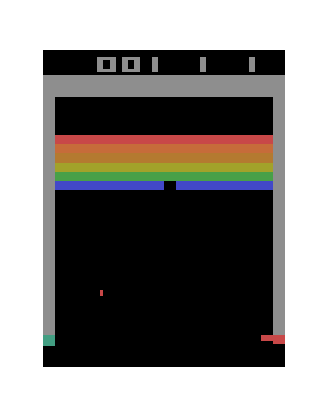
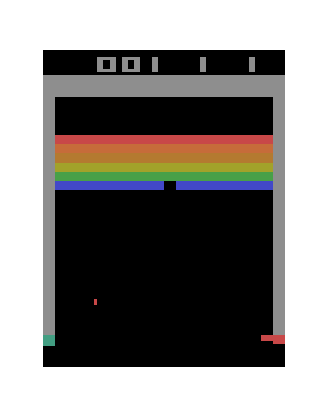
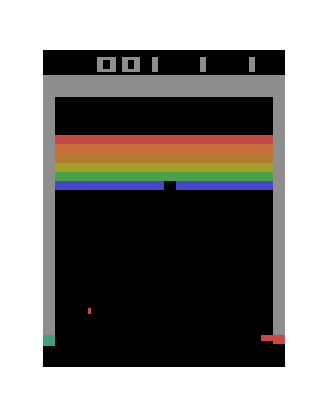
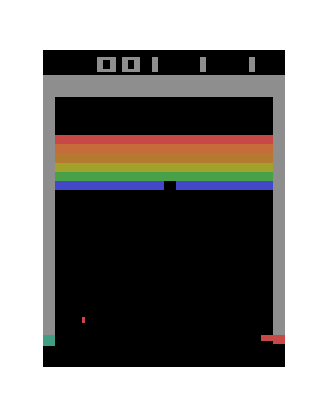
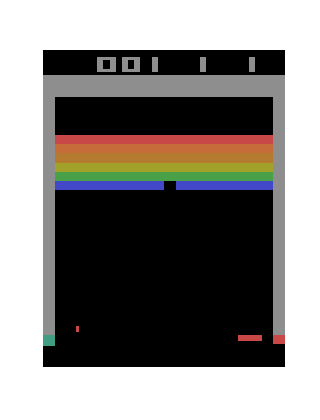
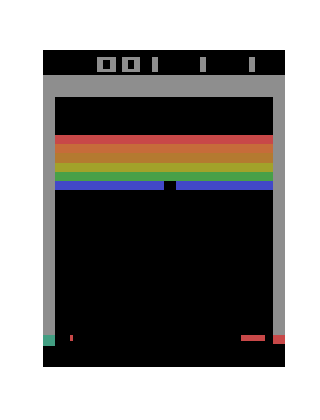
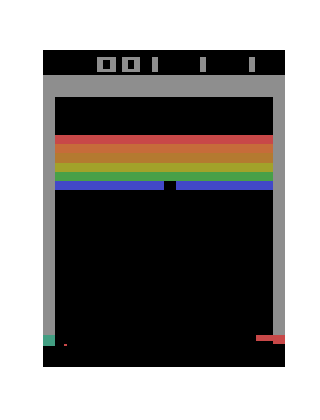
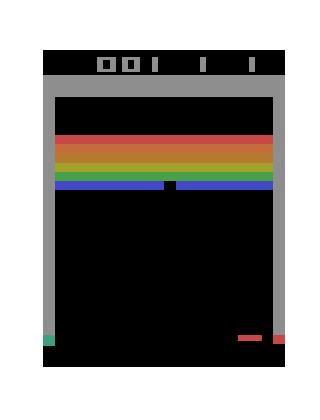
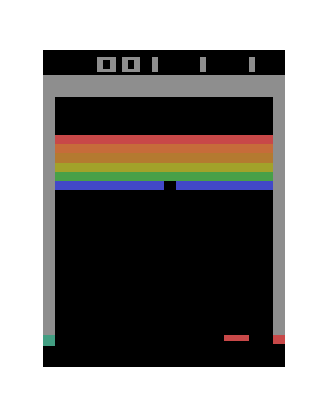
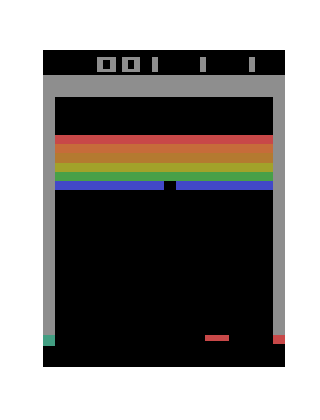
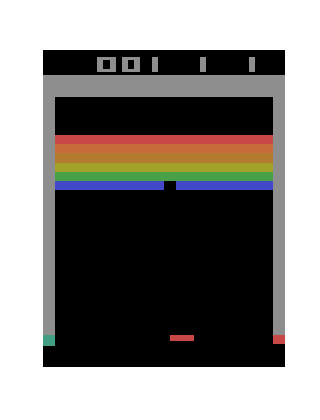
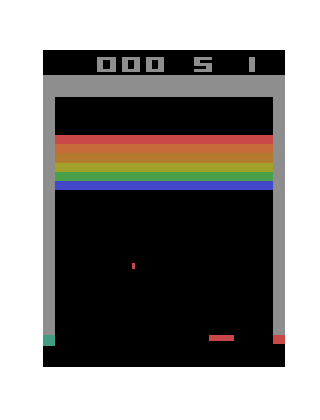
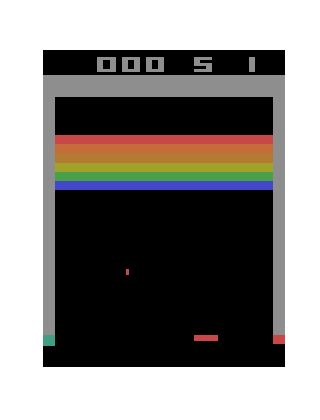
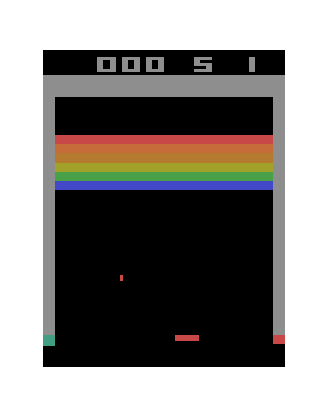
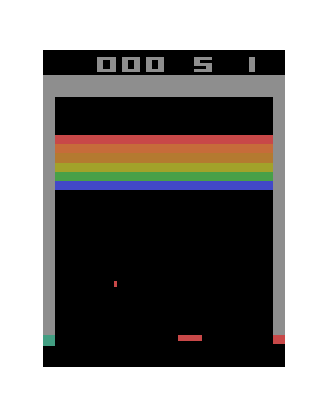
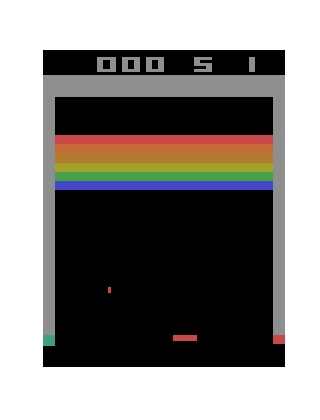
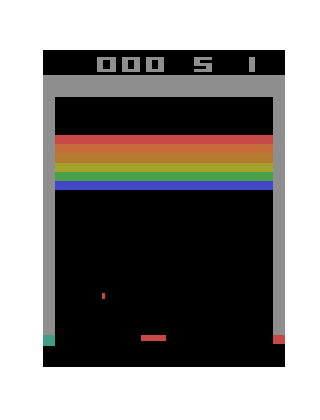
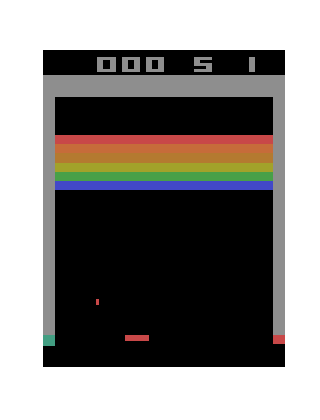
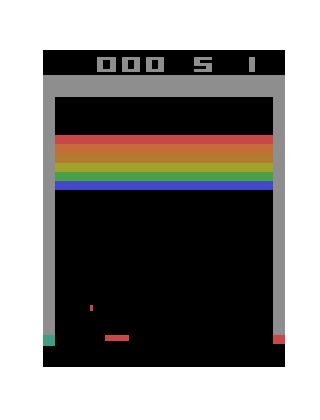
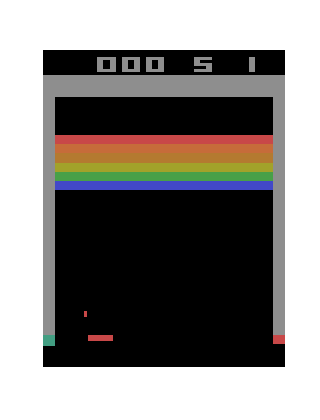
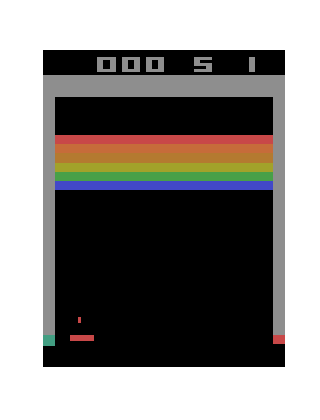
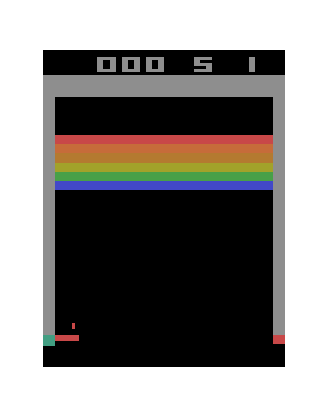
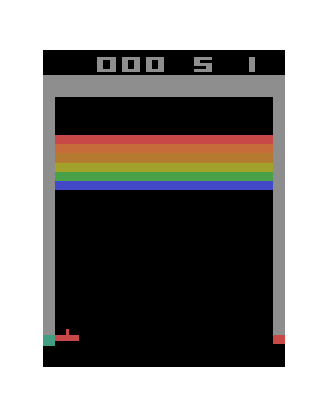
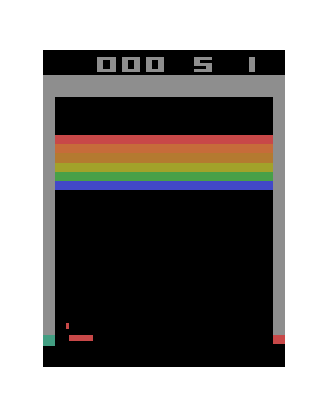
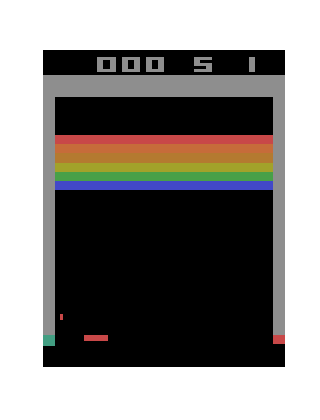
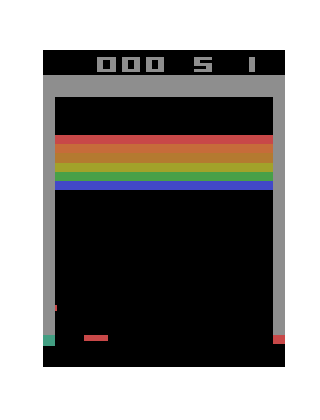
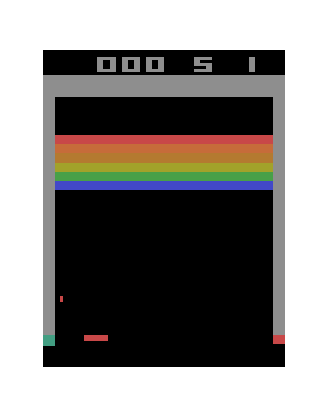
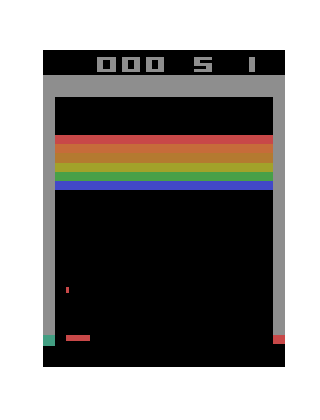
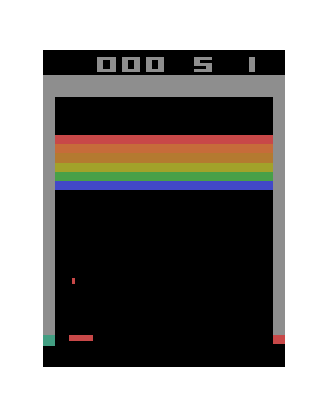
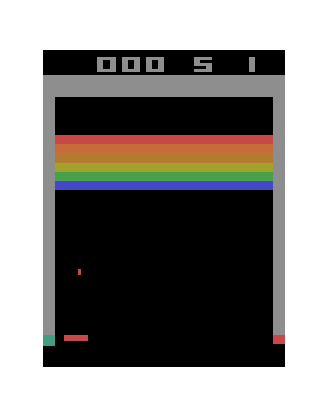
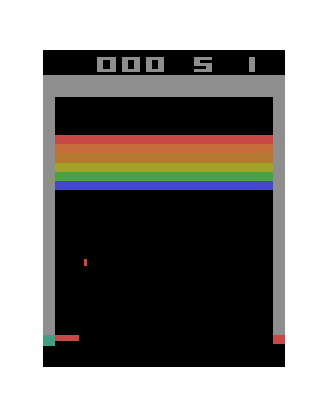
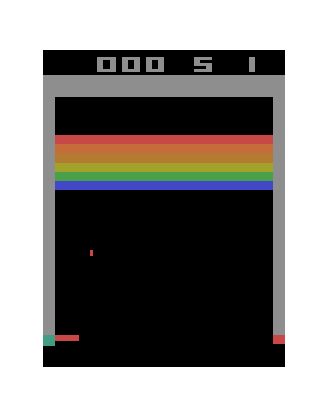
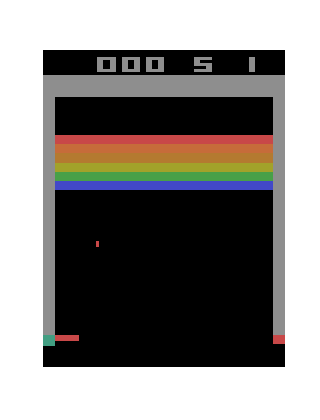
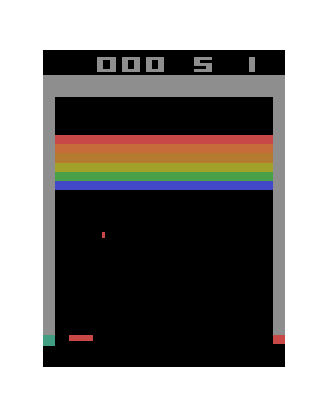
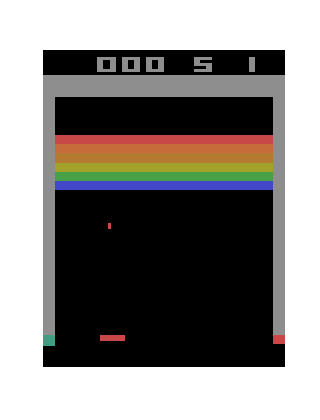
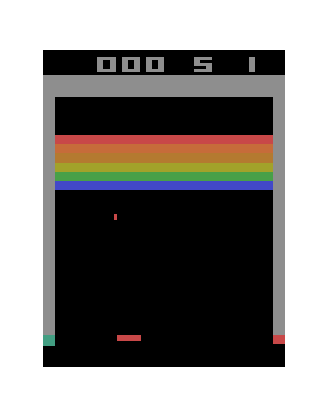
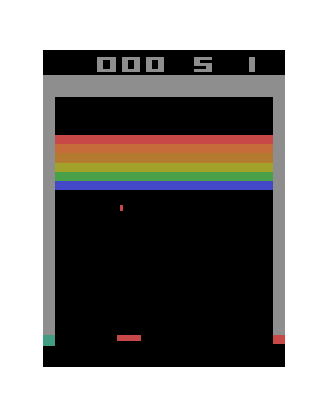
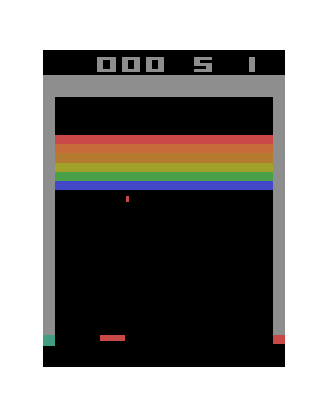
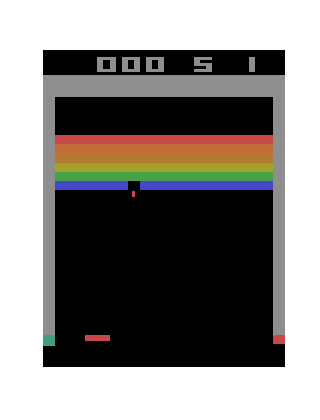
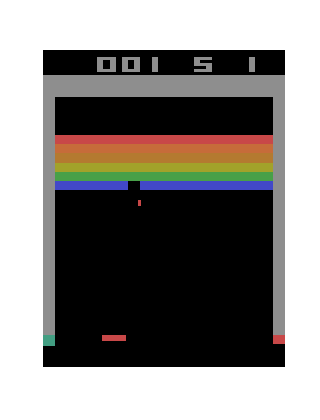
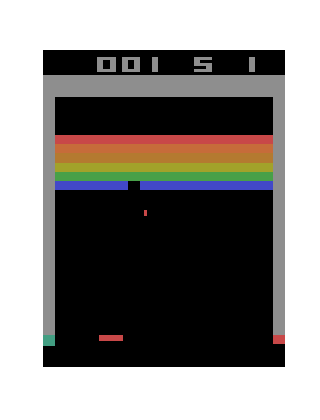
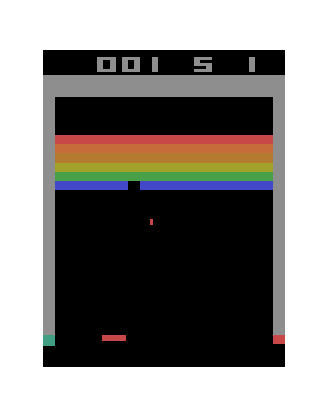
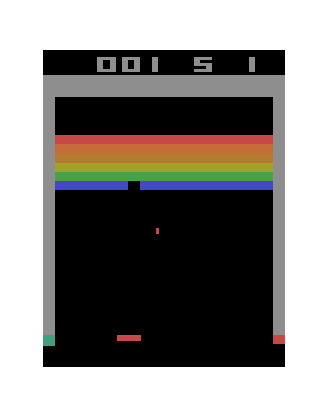
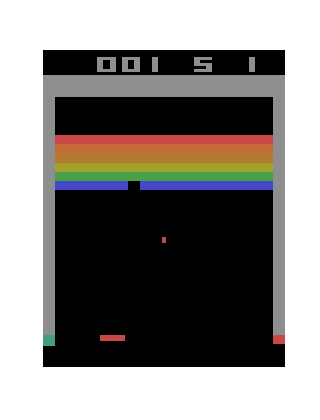
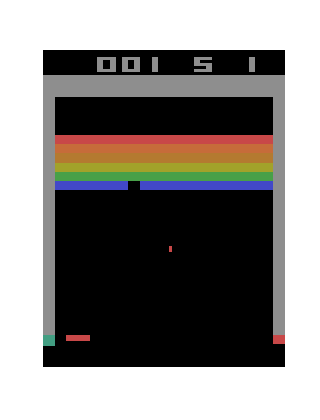
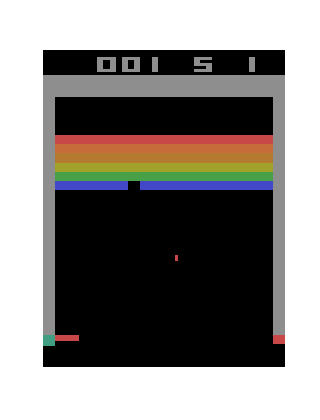
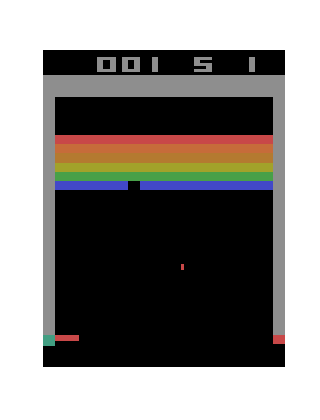
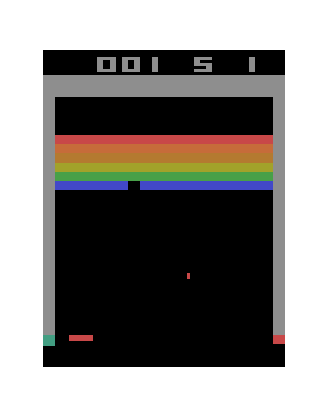
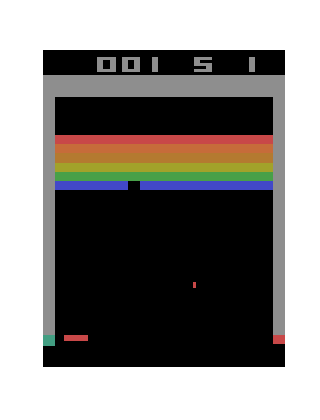
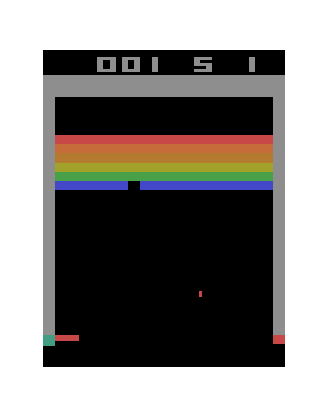
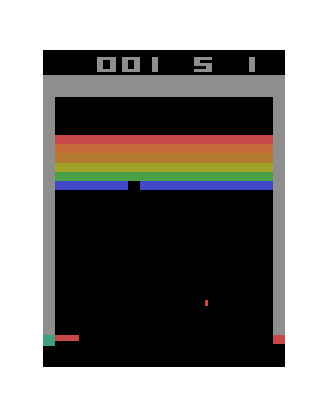
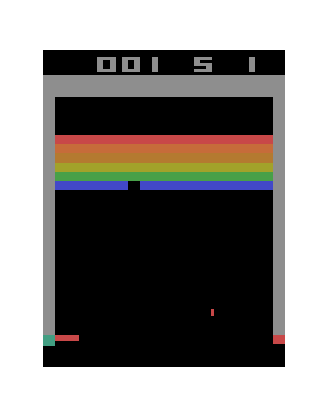
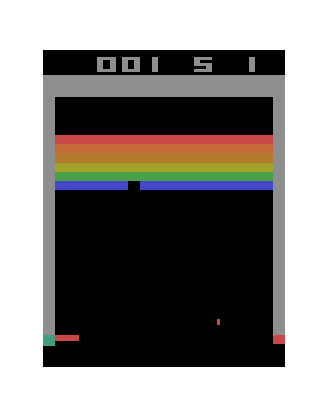
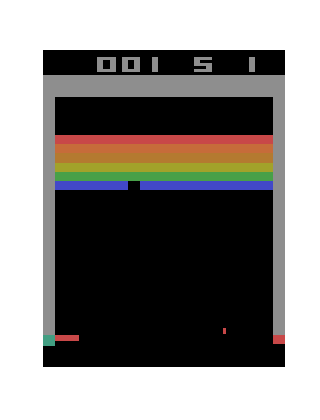
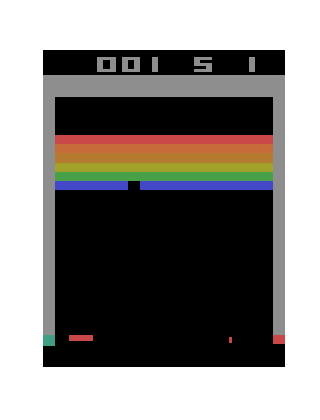
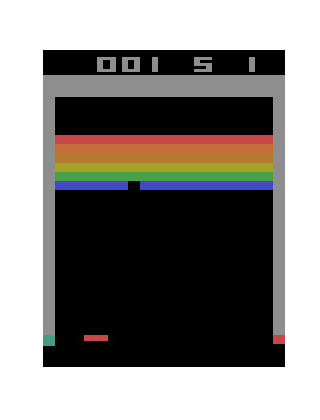
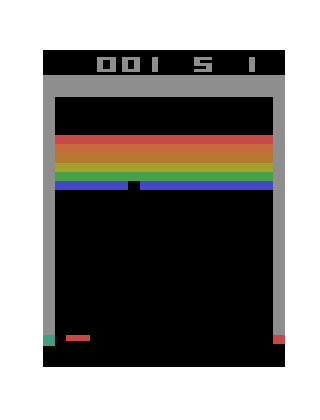
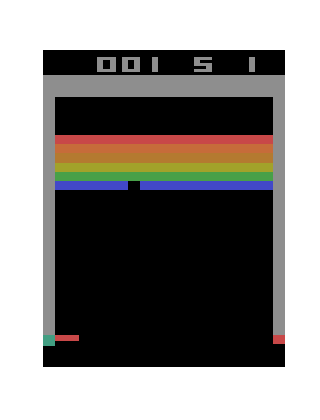
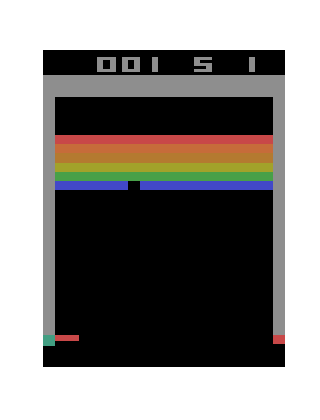
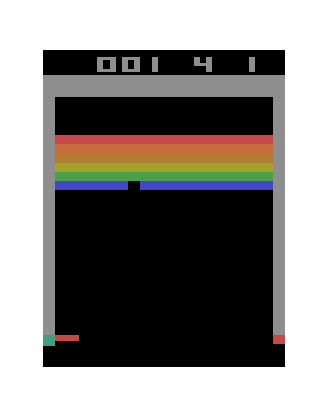
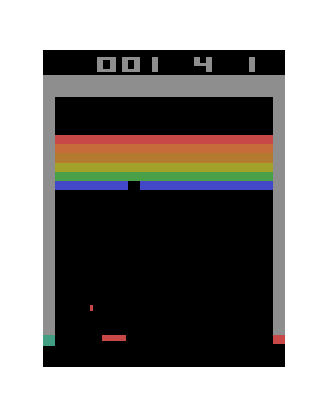
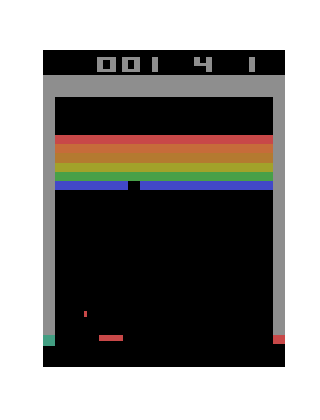
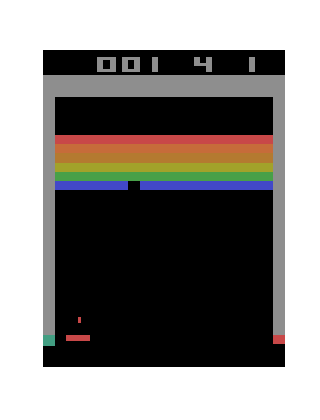
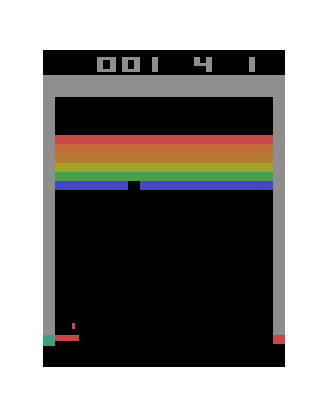
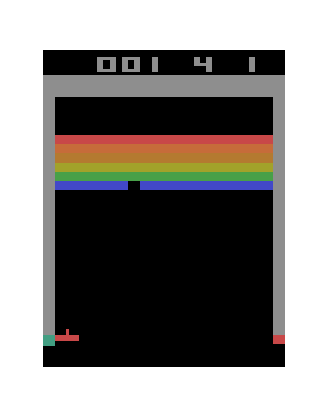
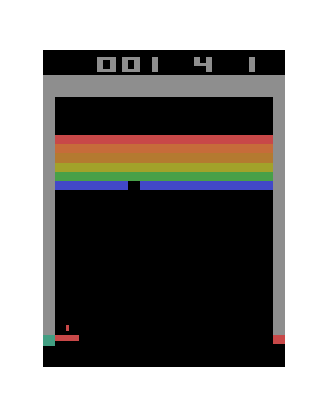
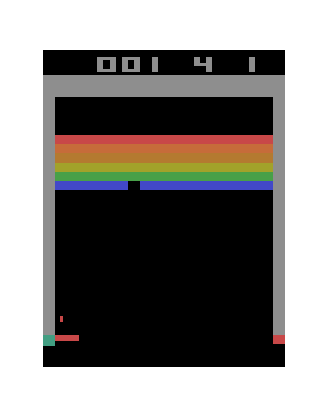
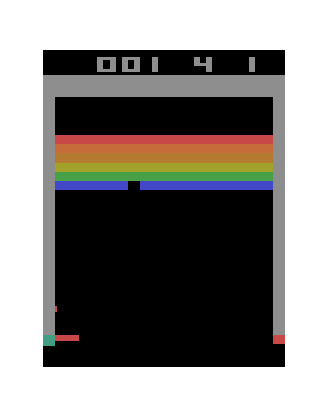
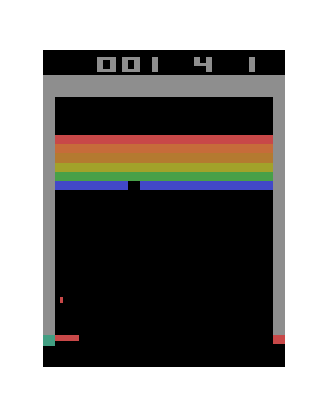
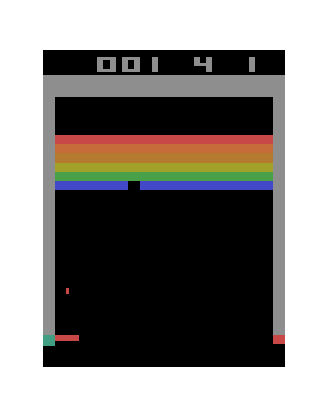
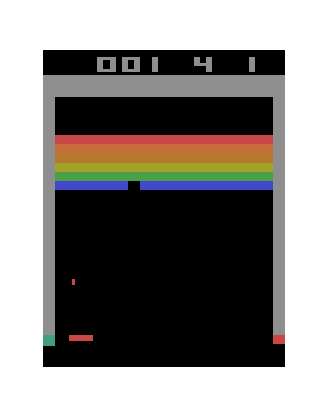
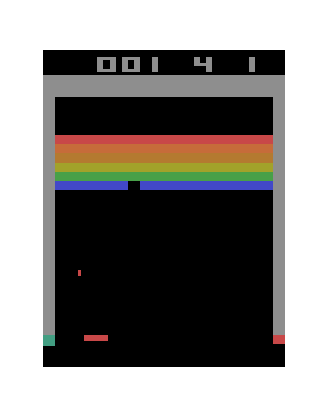
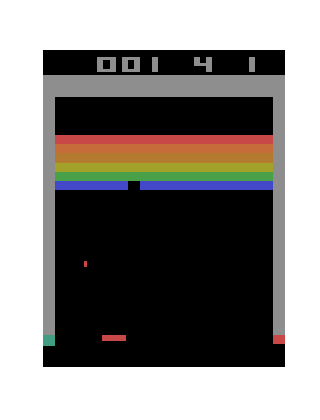
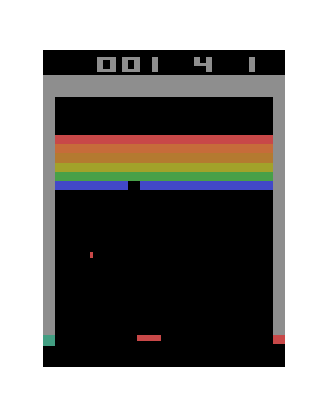
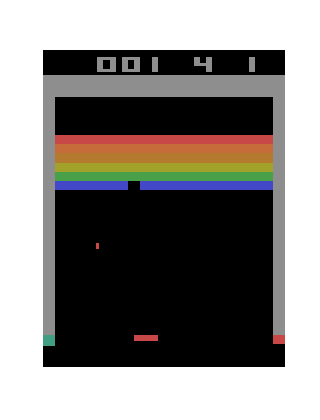
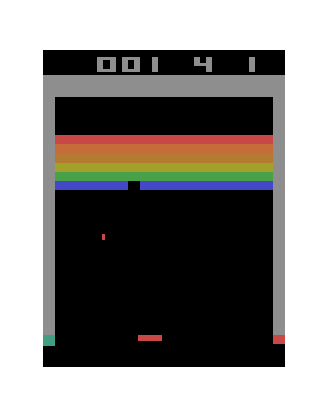
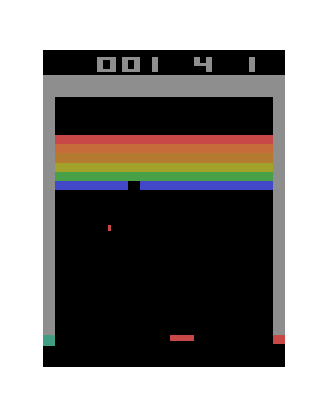
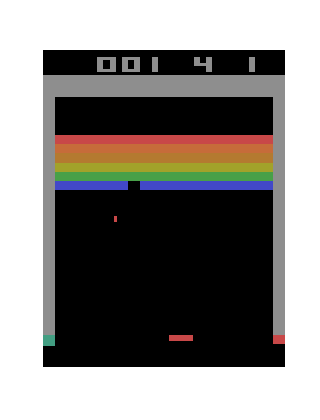
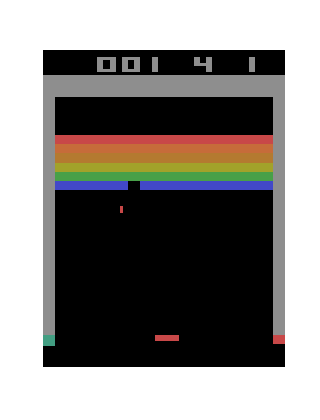
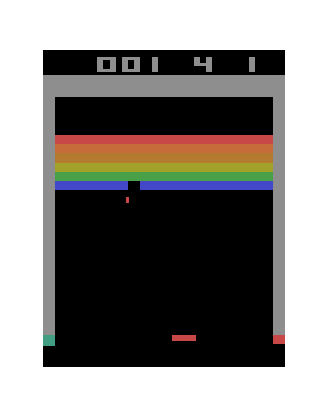
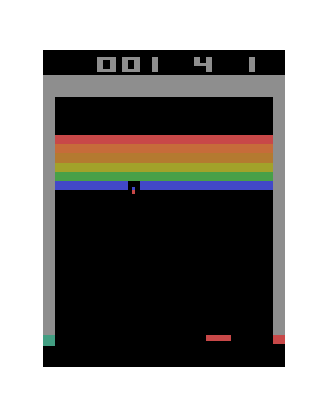
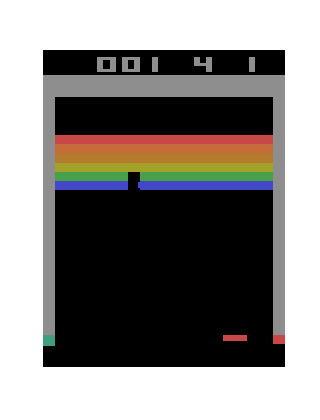
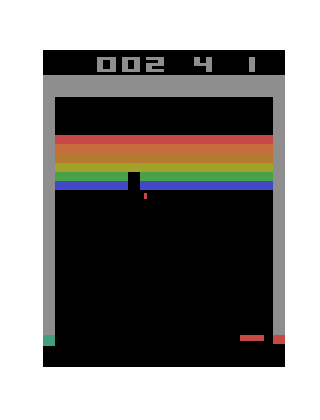
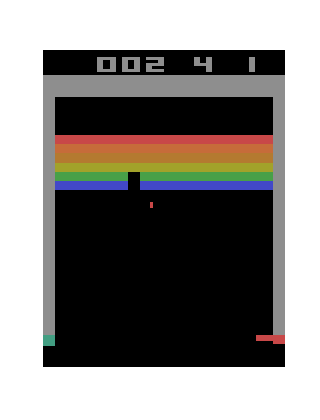
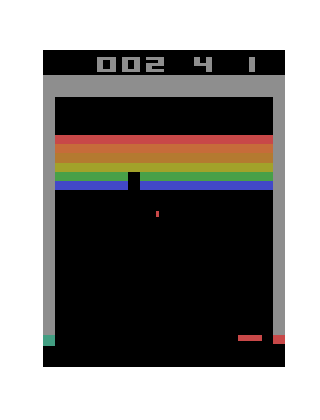
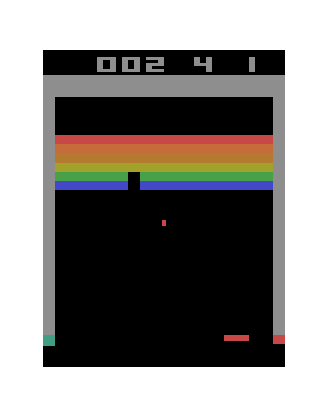
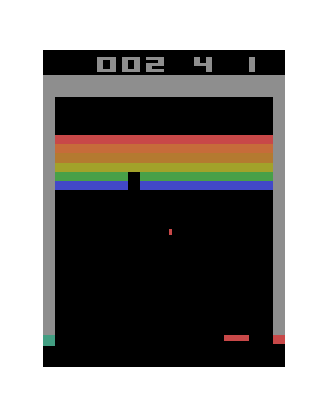
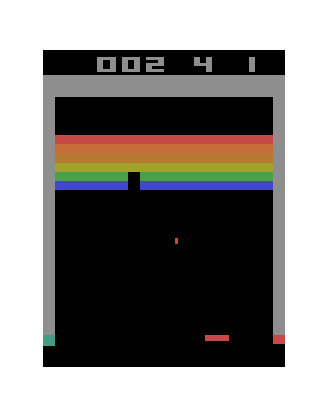
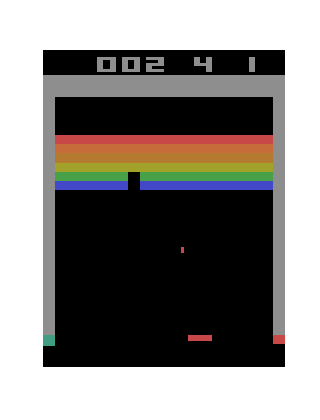
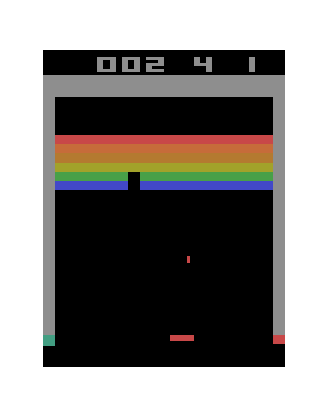
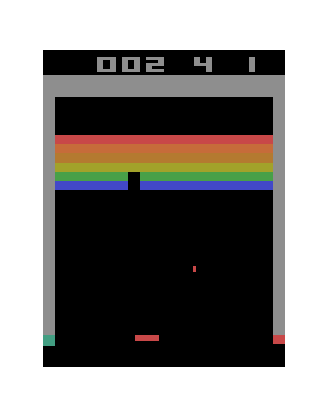
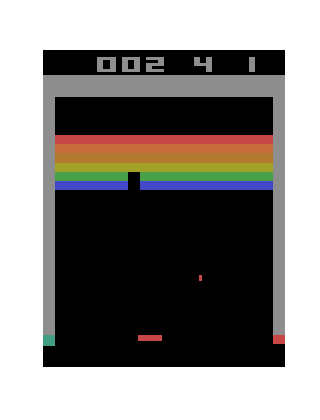
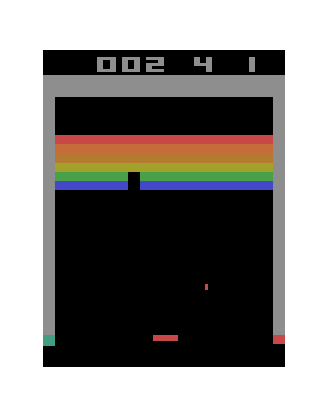
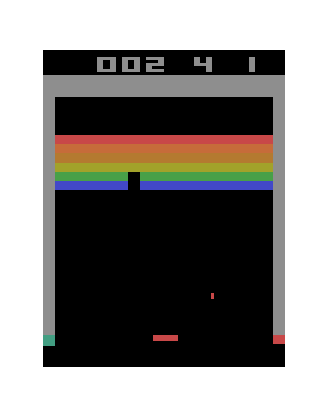
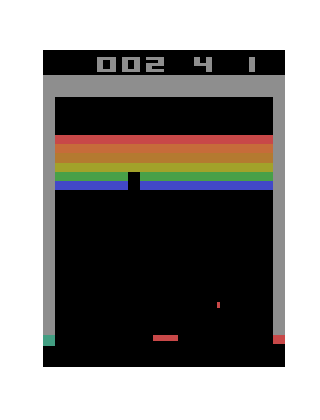
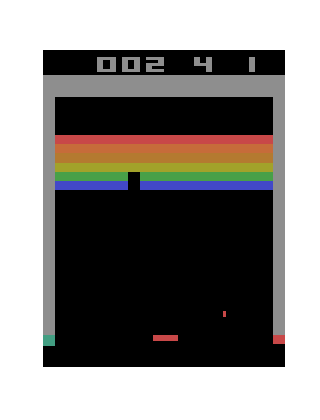
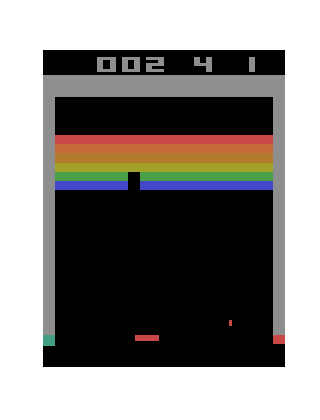
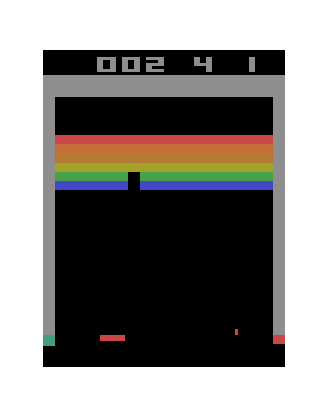
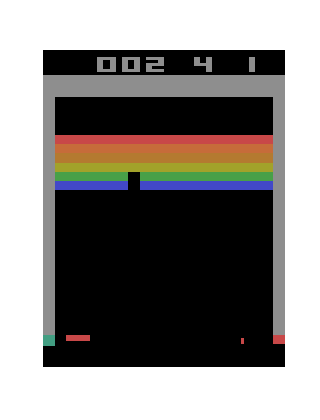
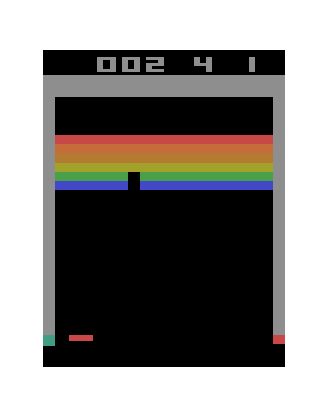
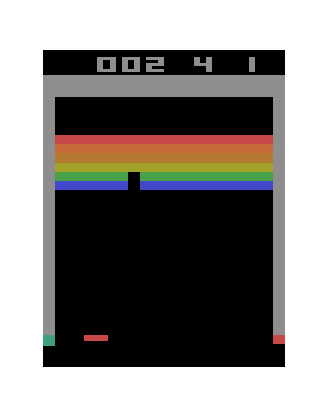
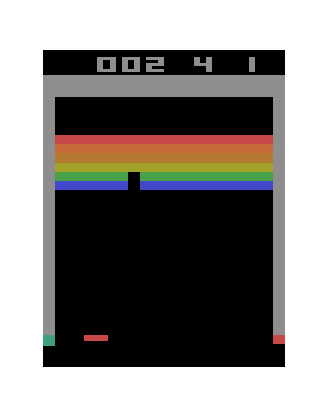
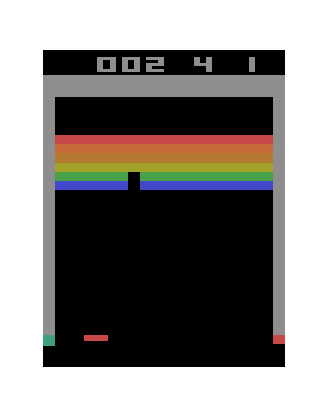
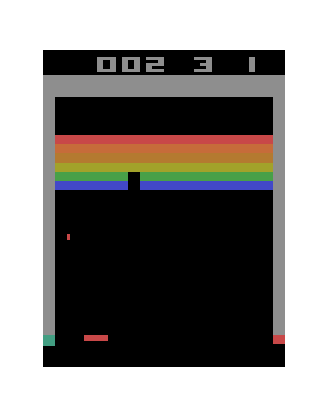
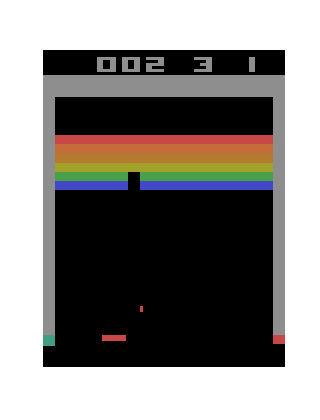
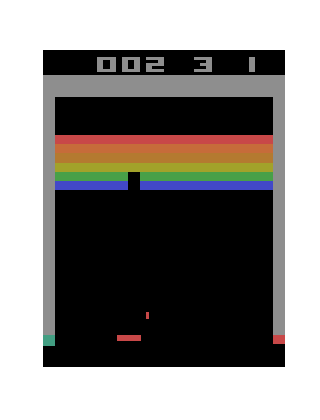
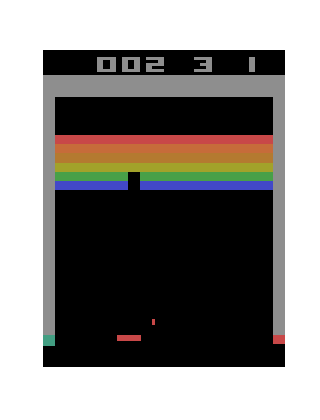
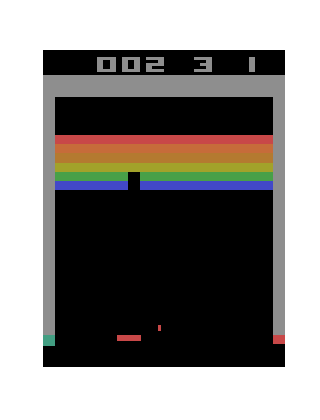
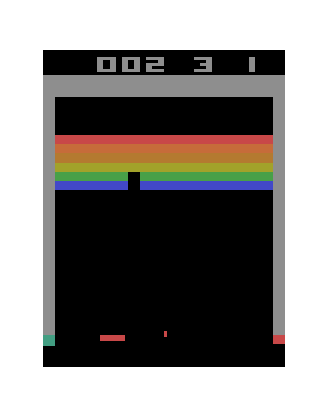
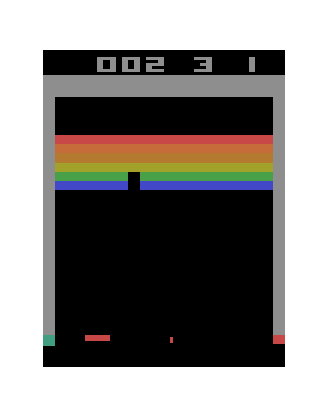
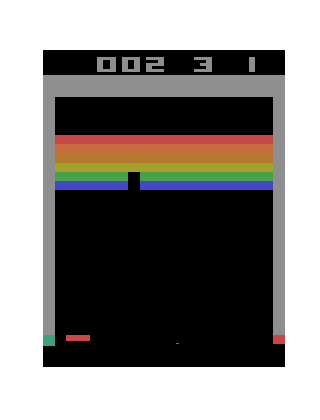
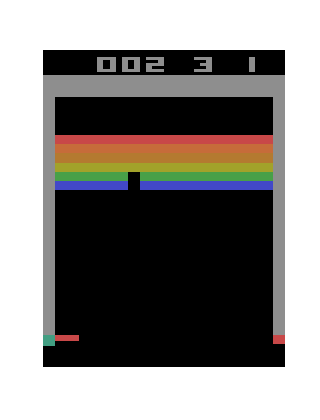
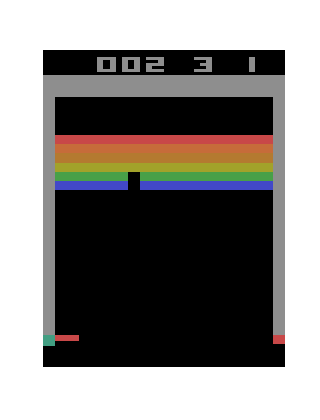
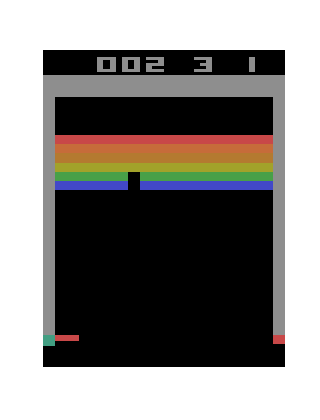
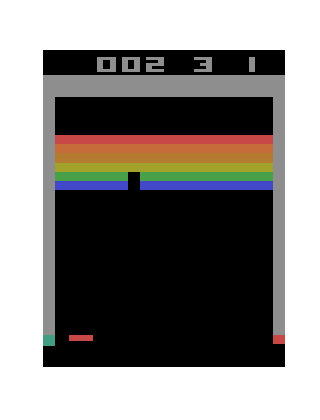
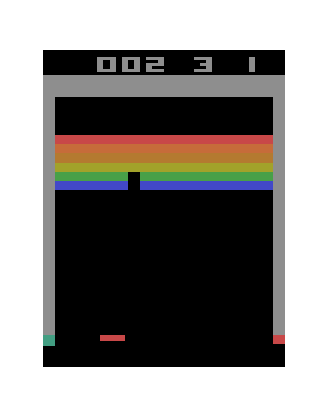
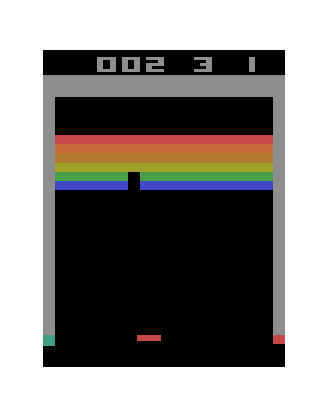
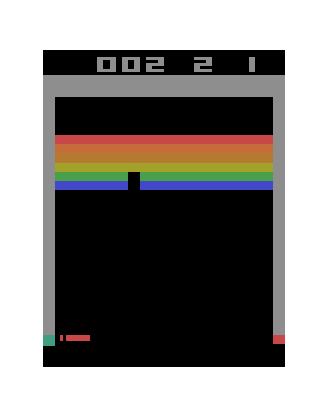
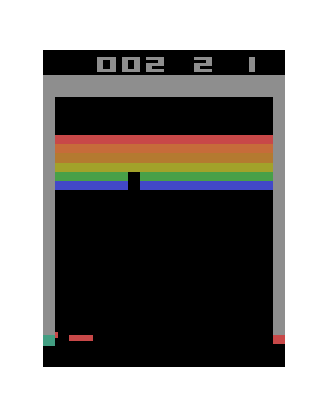
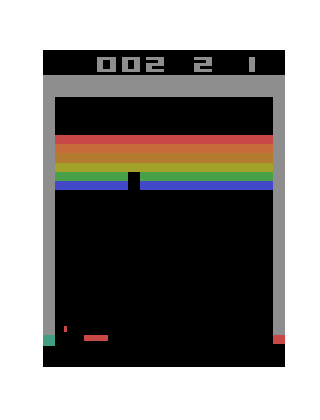
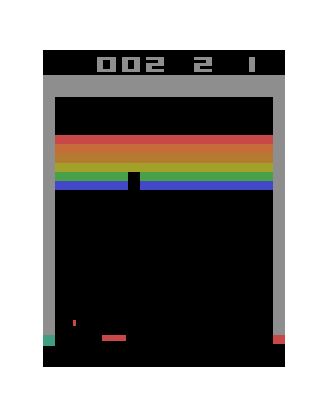
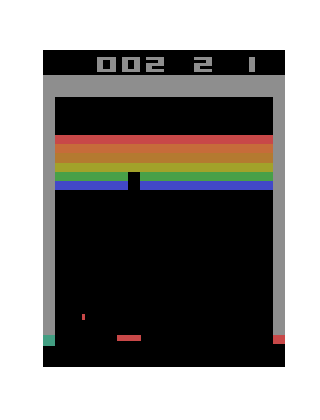
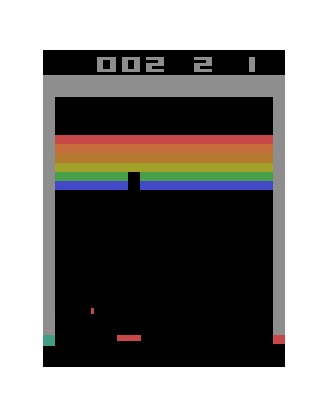

In [7]:
a2c.test_node_selector=ProbNodeChooser()
Env.test=True
a2c.test(test_step=300)
Env.test=False
Env.animation.run()
Env.animation.reset()

In [8]:
a2c.fit(epoch=50,epoch_step=10000,test_step=300)

epoch 001 avg_loss:-0.0450 total reward in epoch: [train:1665.000 test: 3.0] avg train reward in episode:104.062: 100%|██████████| 9996/9996 [10:54<00:00, 13.95it/s]
epoch 002 avg_loss:-0.0448 total reward in epoch: [train:1714.000 test: 2.0] avg train reward in episode:107.125: 100%|██████████| 9996/9996 [11:51<00:00, 13.29it/s]
epoch 003 avg_loss:-0.0453 total reward in epoch: [train:1717.000 test: 5.0] avg train reward in episode:107.312: 100%|██████████| 9996/9996 [11:54<00:00, 14.56it/s]
epoch 004 avg_loss:-0.0446 total reward in epoch: [train:1745.000 test: 2.0] avg train reward in episode:109.062: 100%|██████████| 9996/9996 [10:57<00:00, 13.76it/s]
epoch 005 avg_loss:-0.0448 total reward in epoch: [train:1678.000 test: 3.0] avg train reward in episode:104.875: 100%|██████████| 9996/9996 [11:23<00:00, 14.36it/s]
epoch 006 avg_loss:-0.0454 total reward in epoch: [train:1692.000 test: 2.0] avg train reward in episode:105.750: 100%|██████████| 9996/9996 [11:01<00:00, 17.40it/s]
epoc

epoch 050 avg_loss:-0.0454 total reward in epoch: [train:1698.000 test: 2.0] avg train reward in episode:106.125: 100%|██████████| 9996/9996 [10:49<00:00, 18.06it/s]


In [9]:
Env.test=True
a2c.test_node_selector=MaxNodeChooser()
a2c.test(test_step=300)
Env.test=False


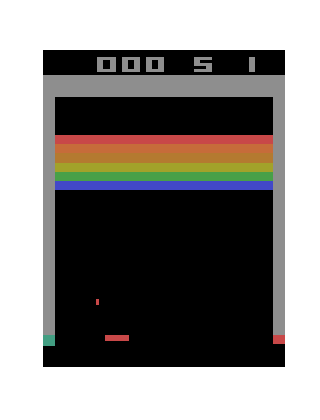
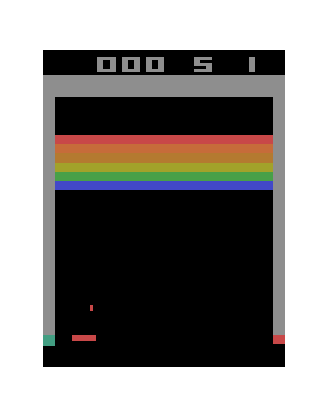
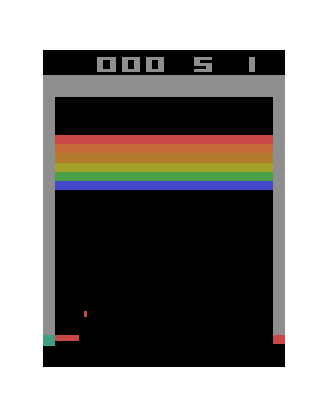
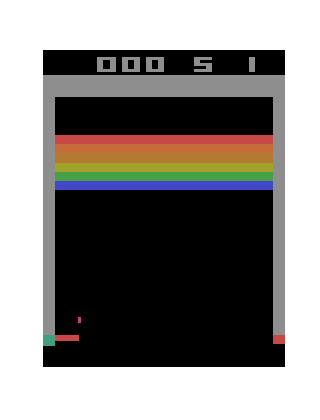
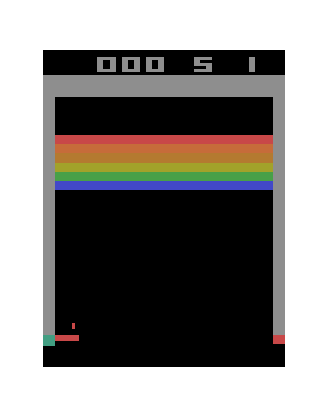
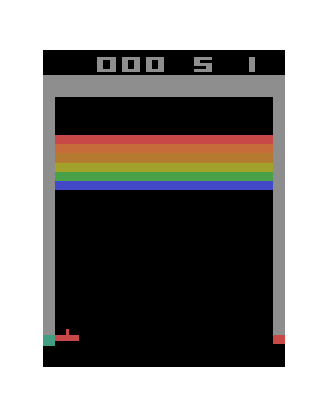
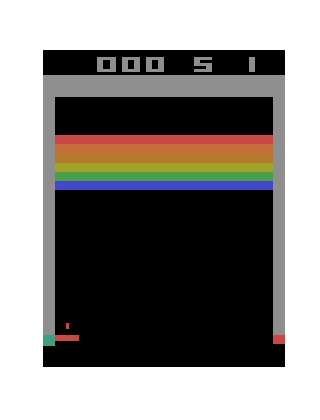
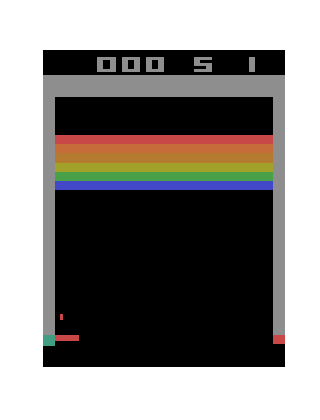
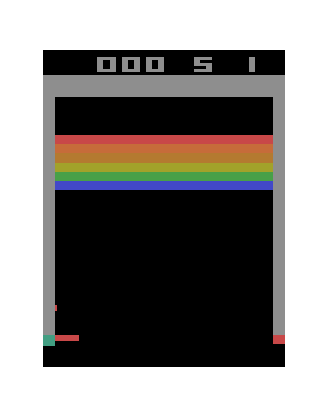
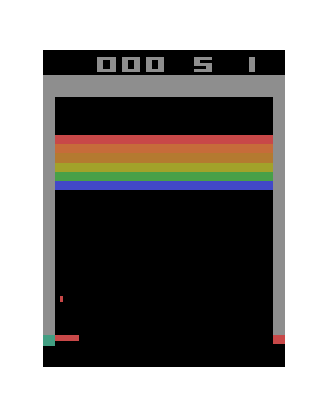
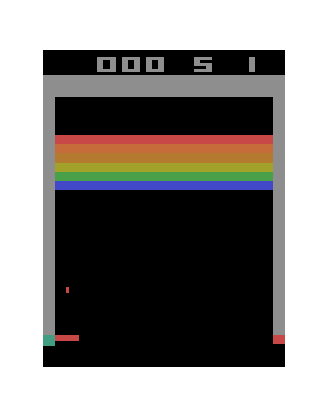
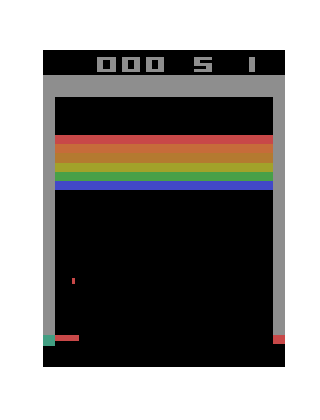
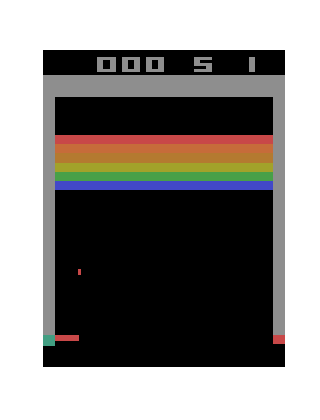
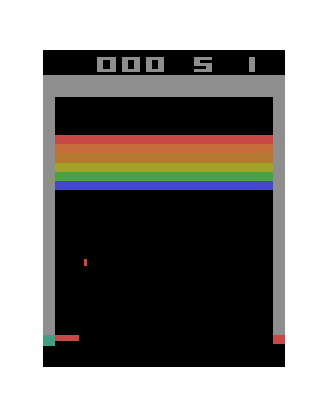
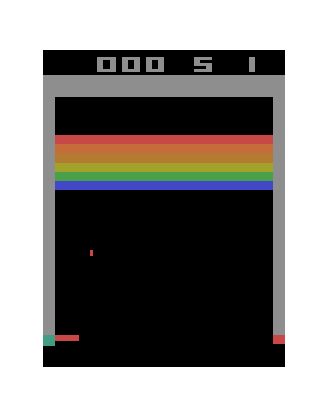
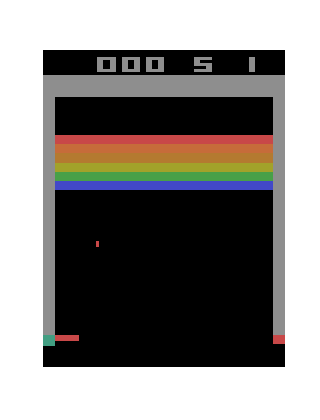
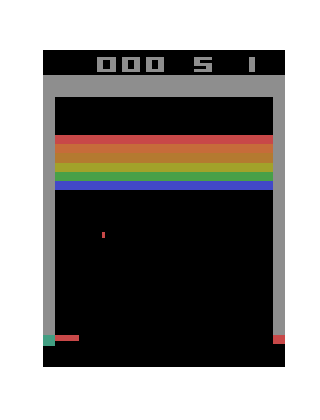
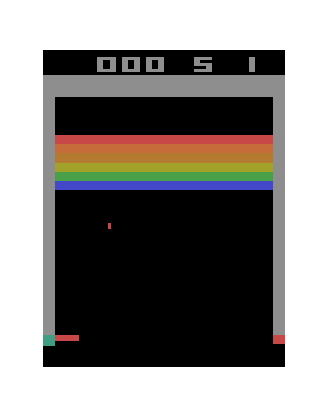
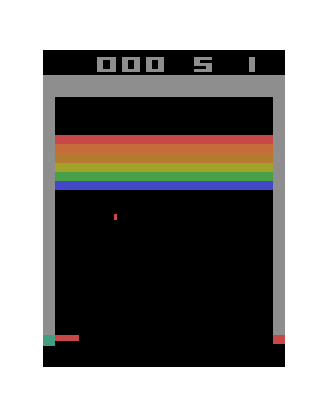
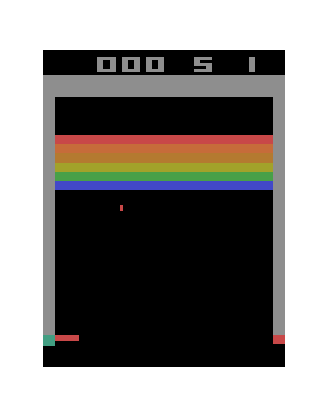
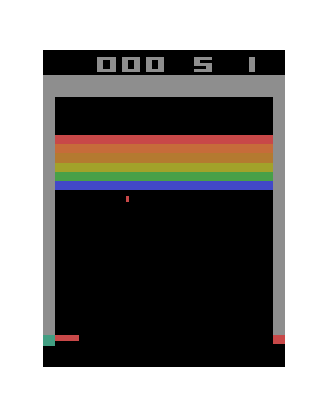
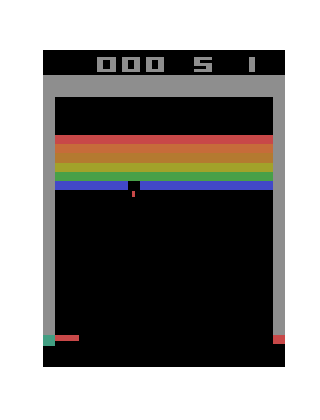
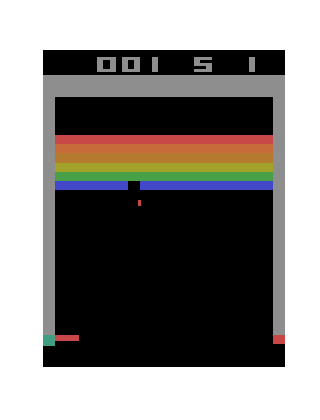
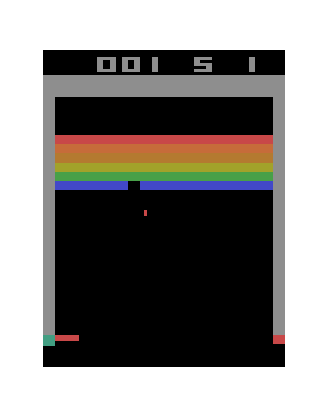
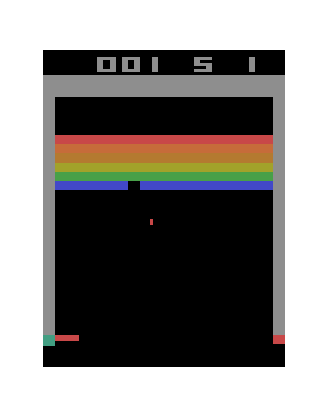
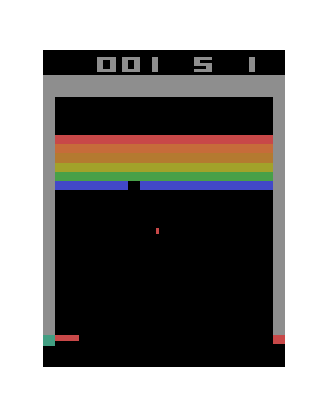
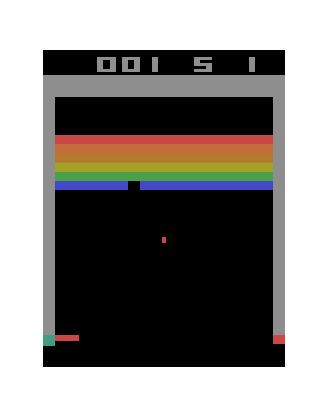
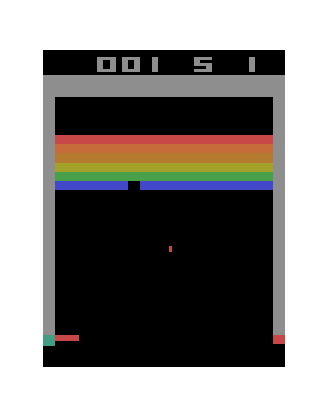
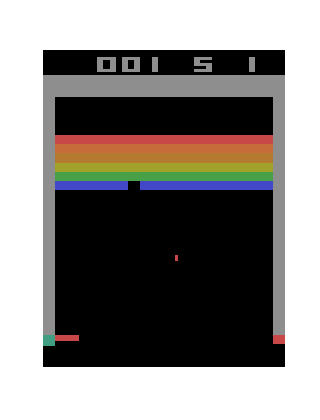
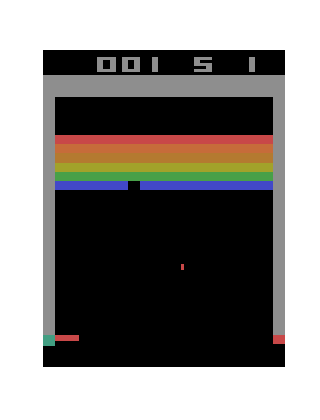
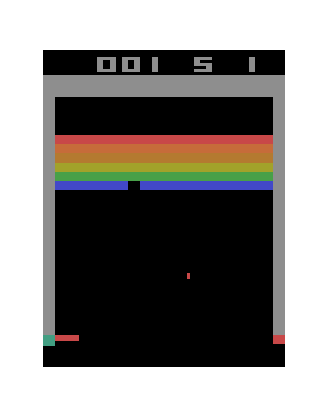
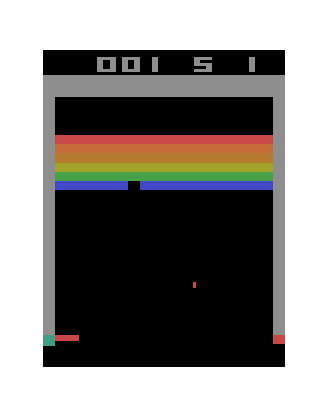
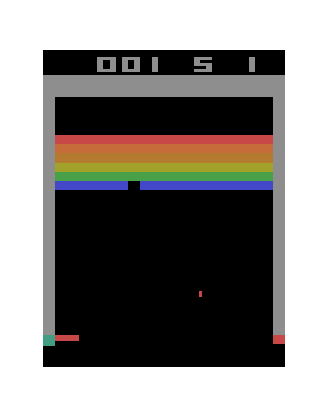
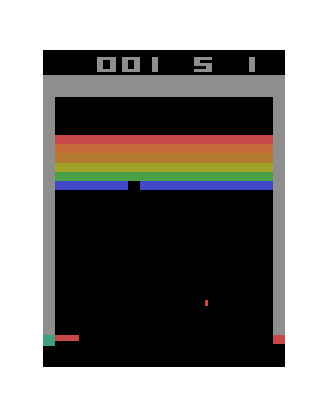
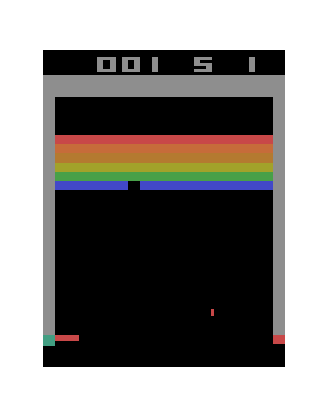
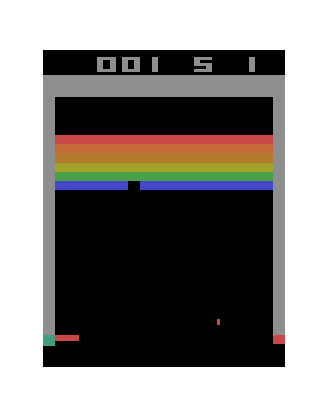
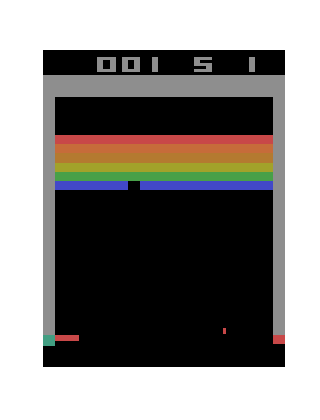
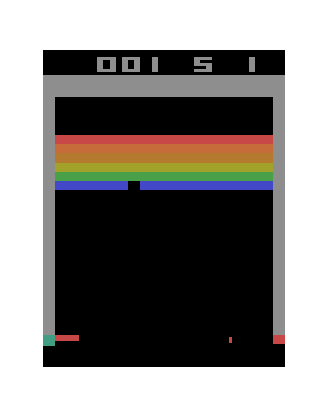
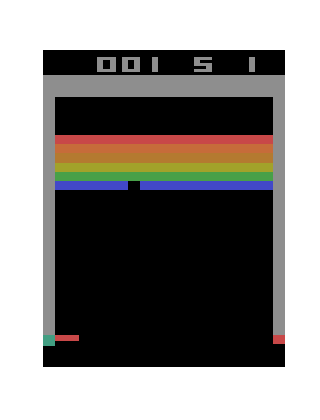
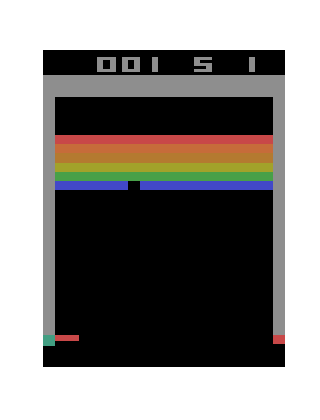
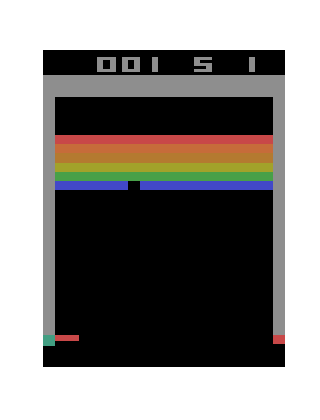
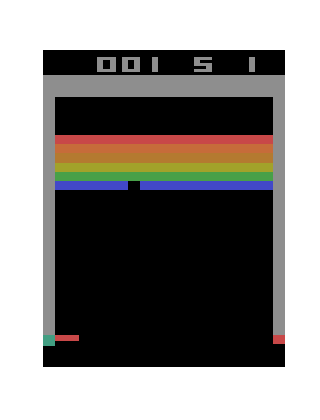
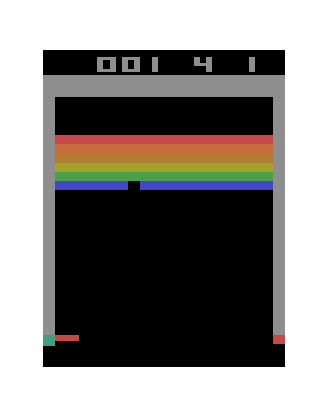
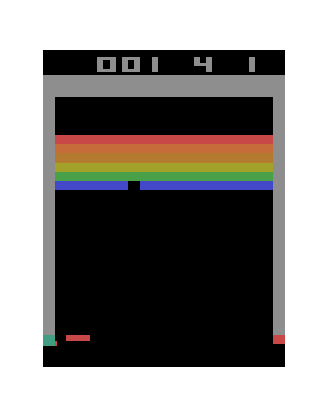
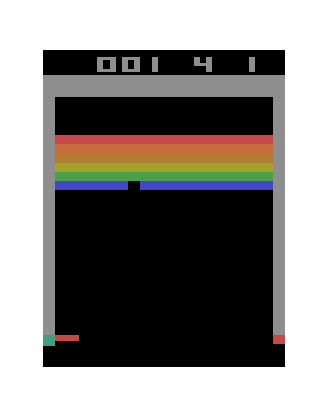
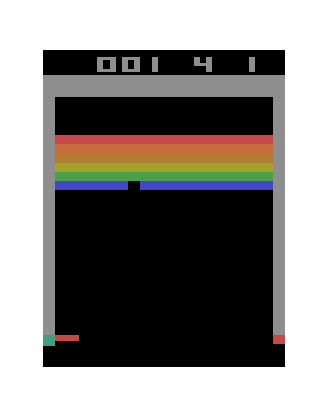
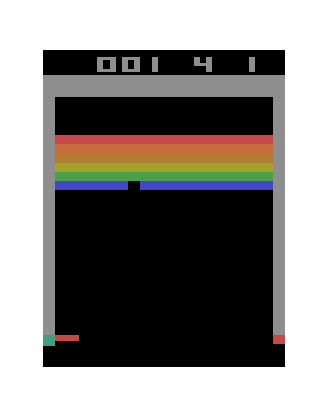
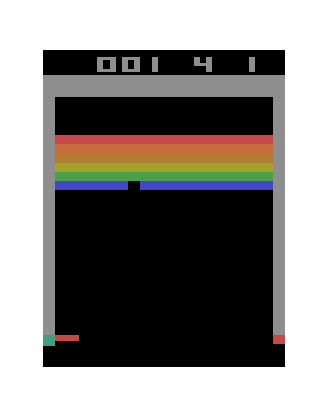
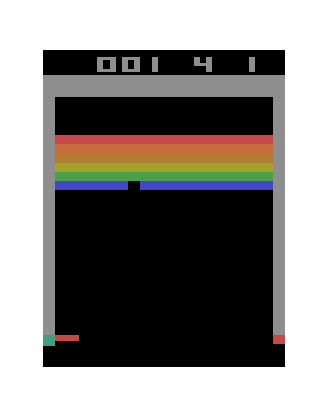
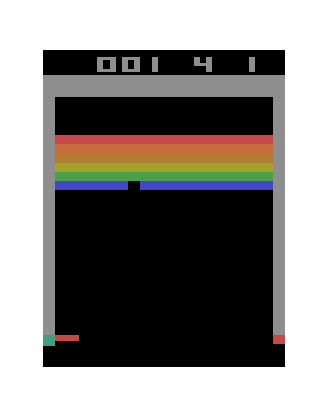
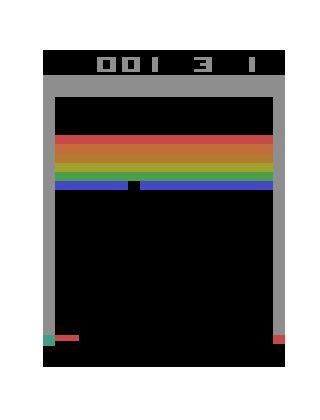
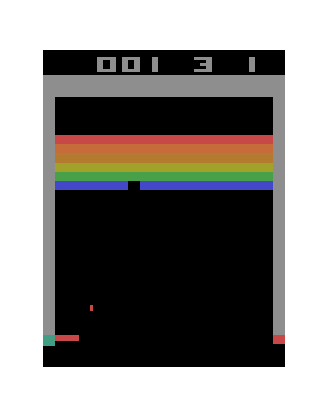
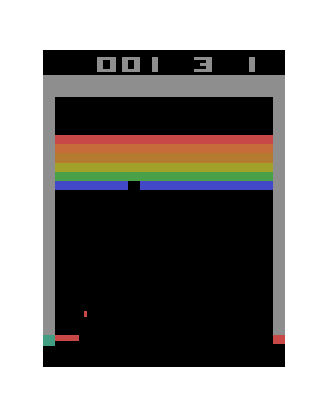
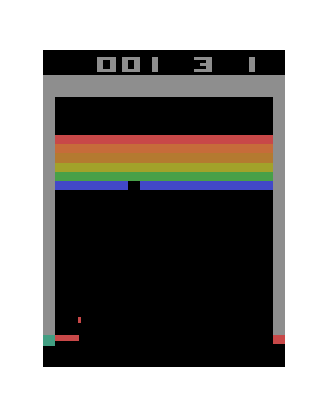
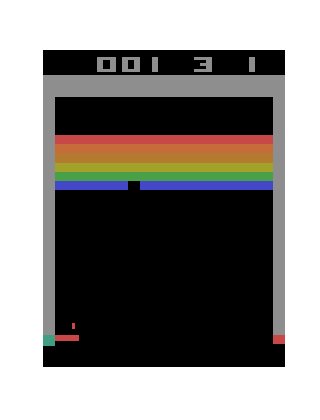
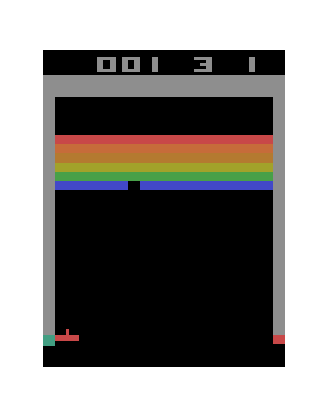
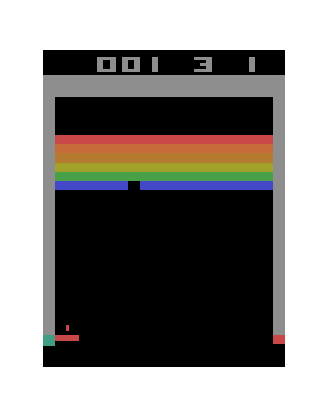
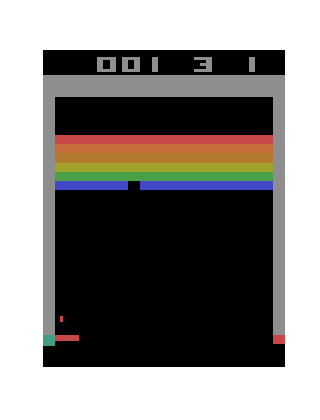
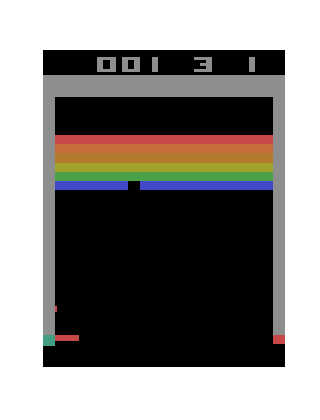
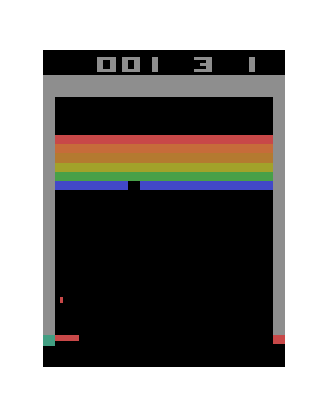
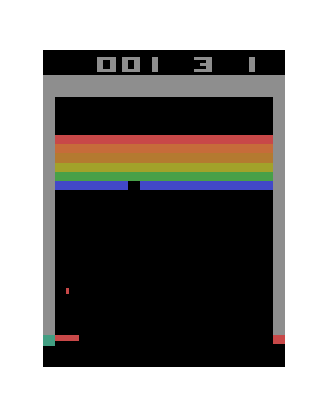
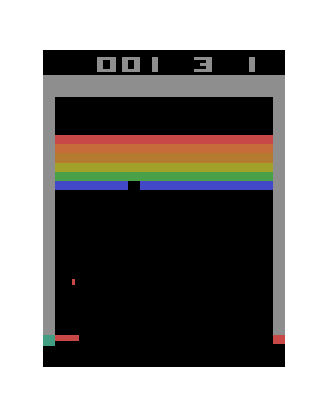
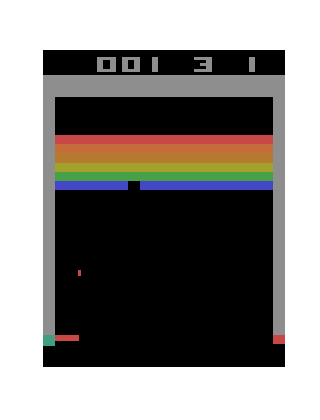
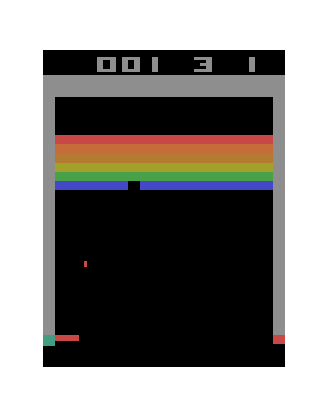
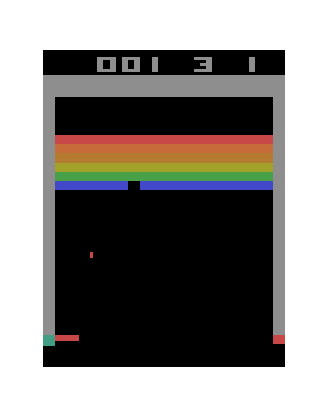
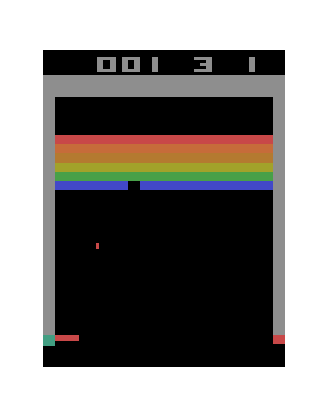
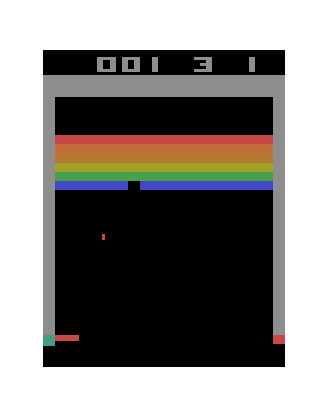
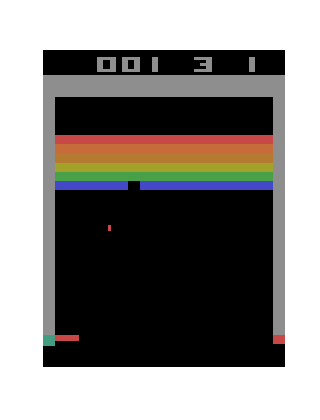
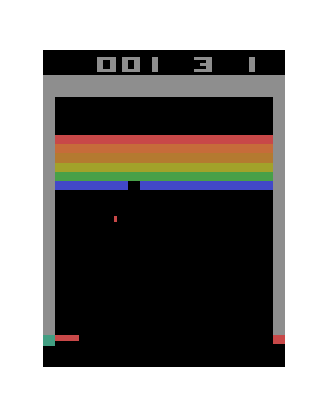
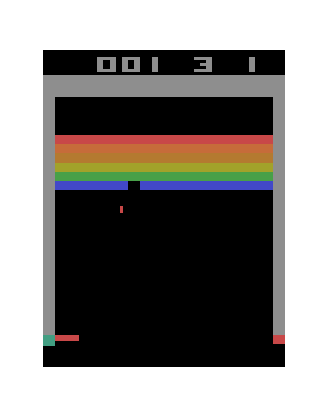
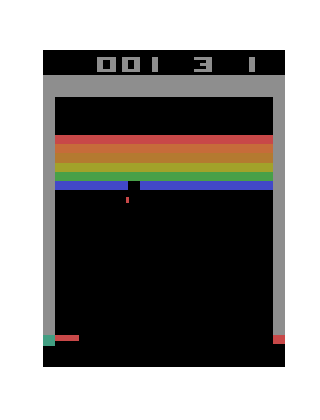
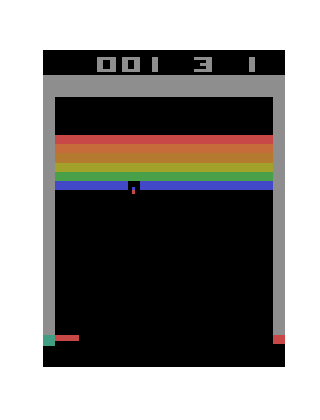
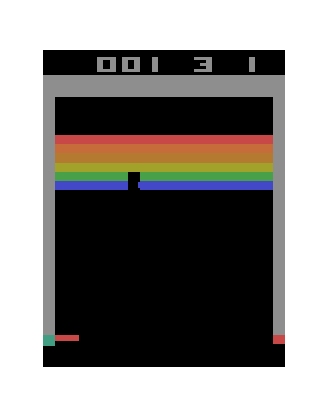
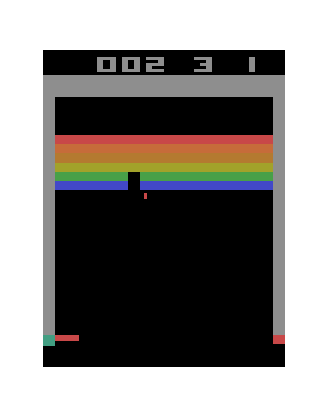
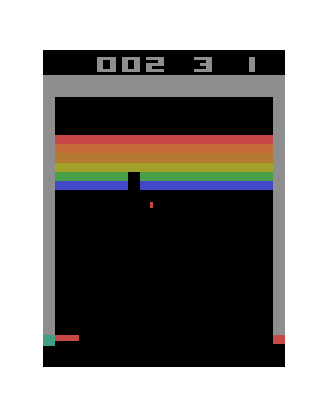
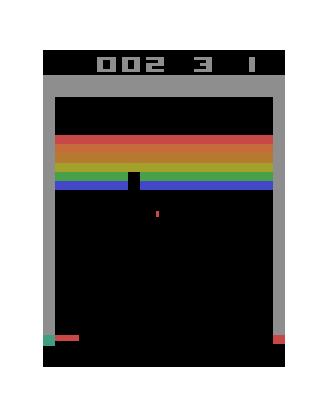
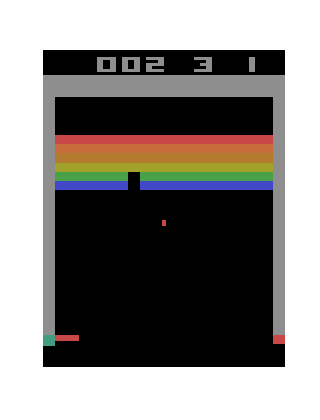
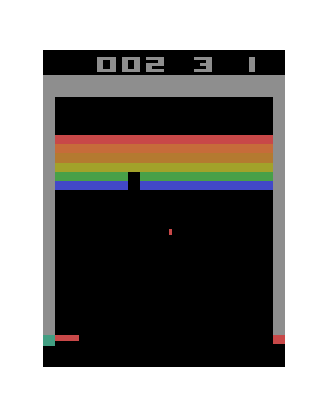
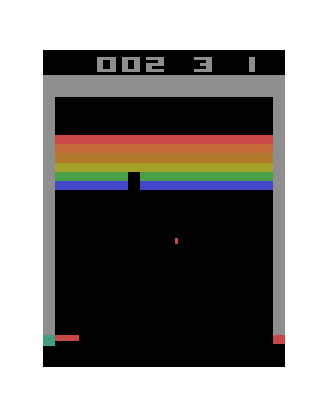
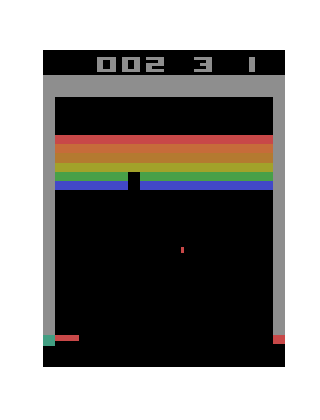
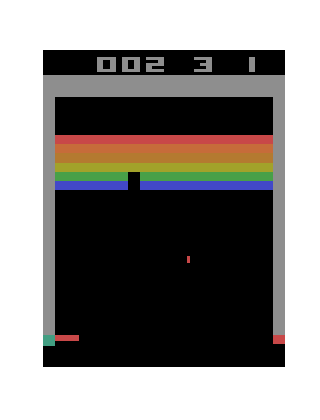
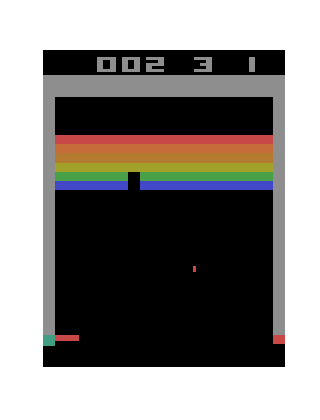
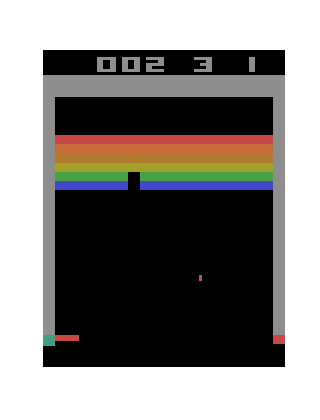
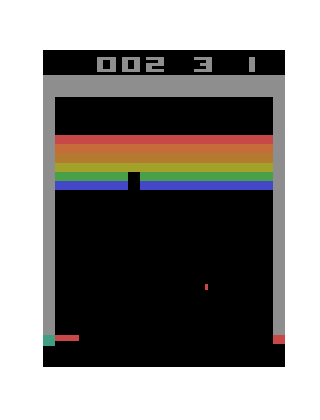
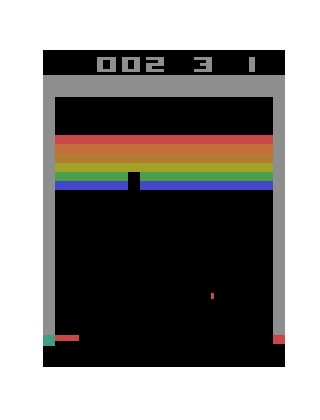
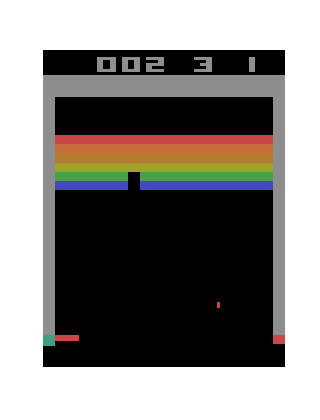
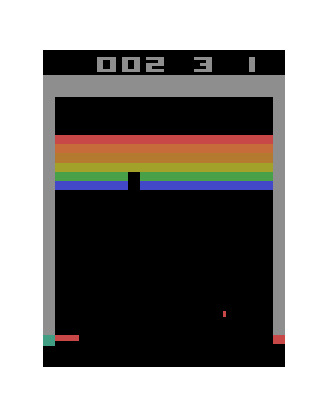
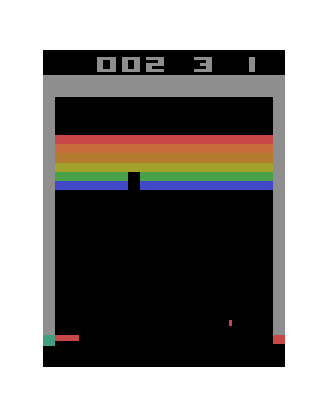
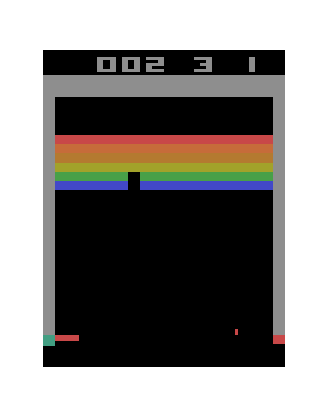
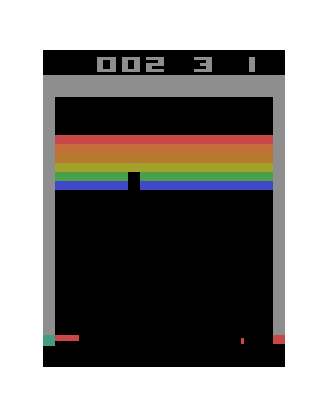
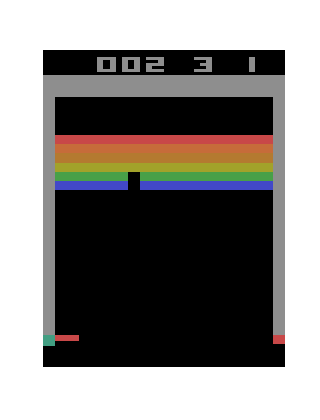
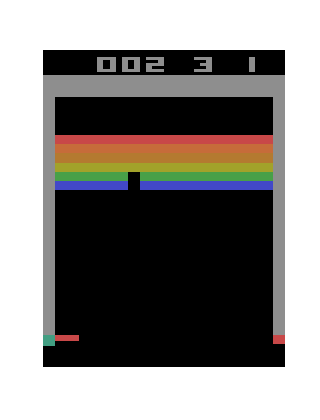
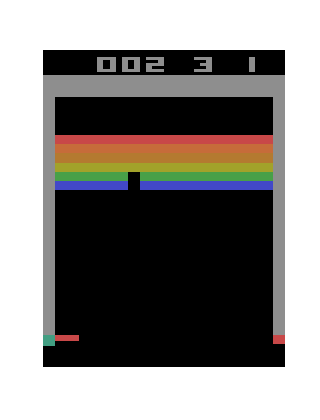
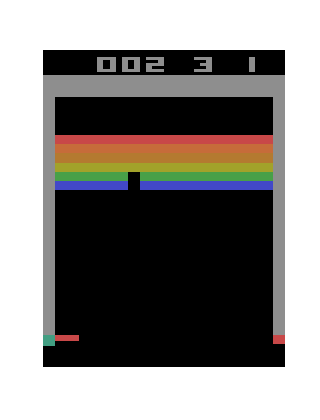
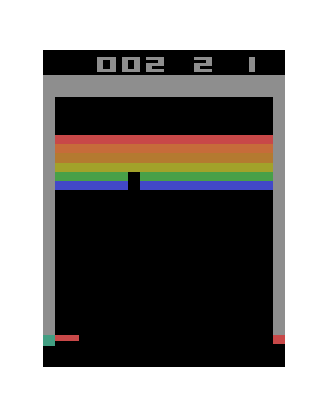
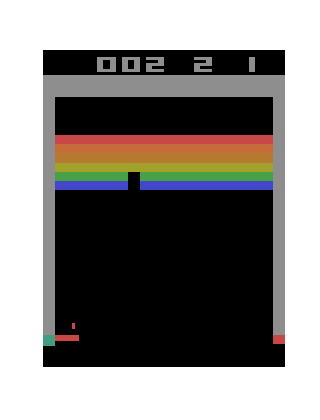
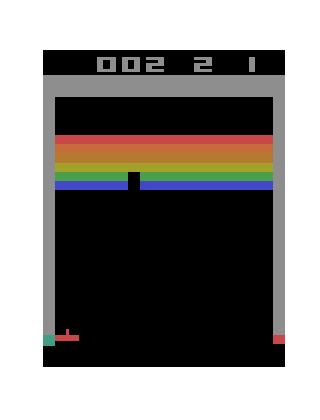
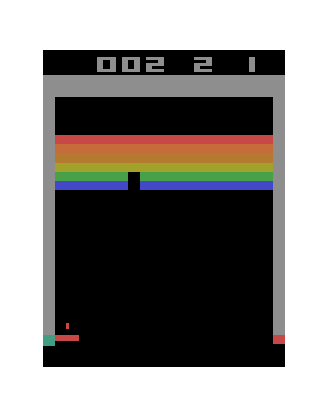
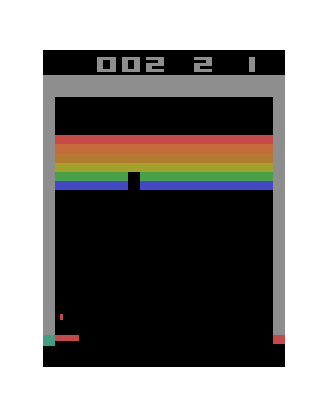
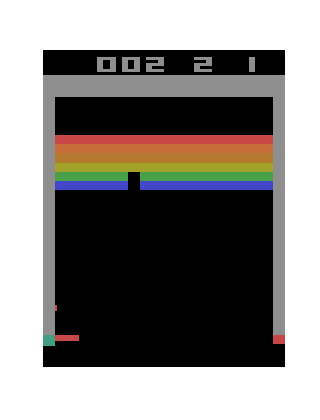
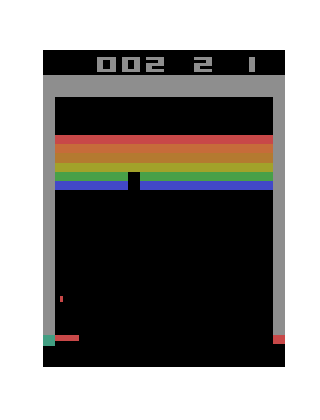
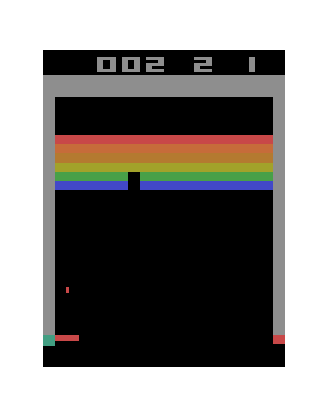
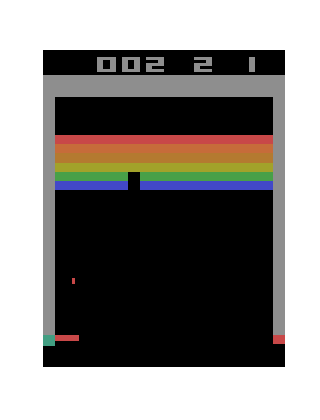
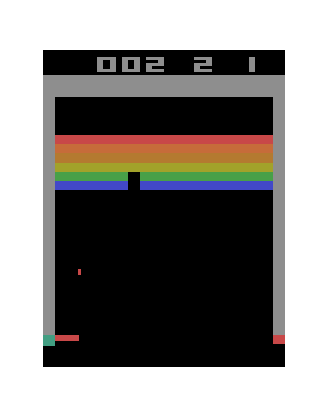
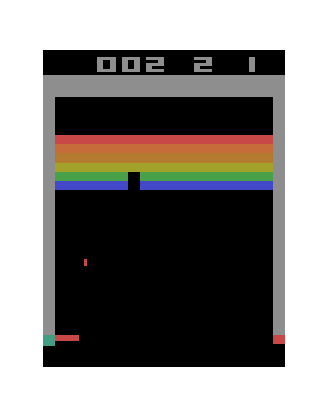
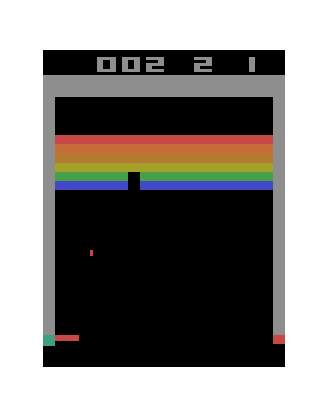
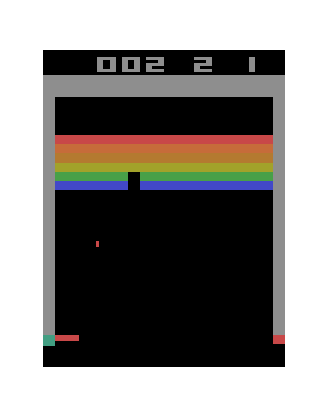
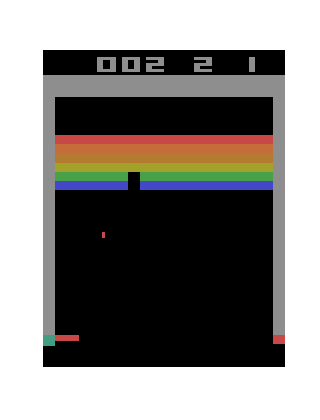
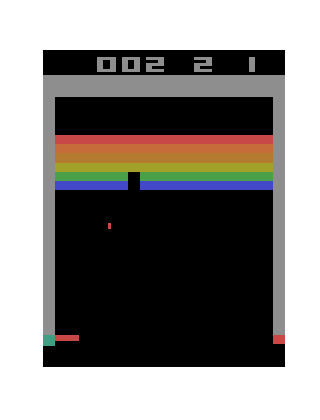
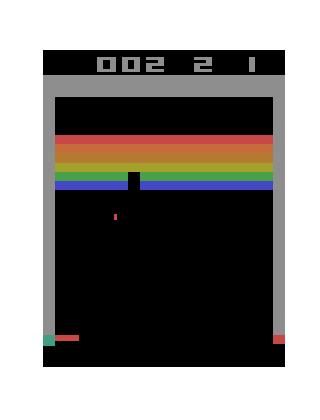
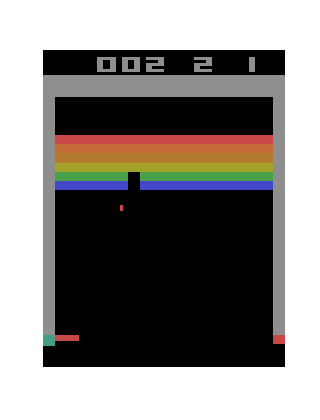
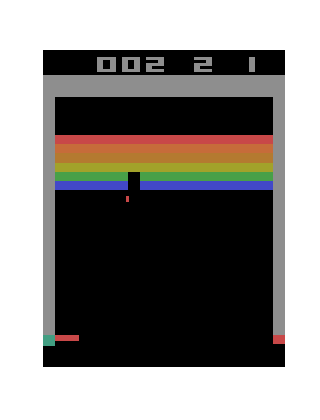
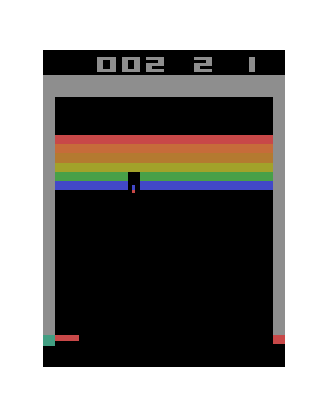
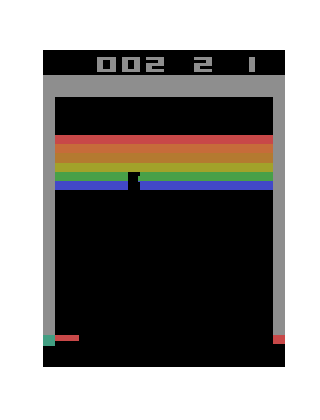
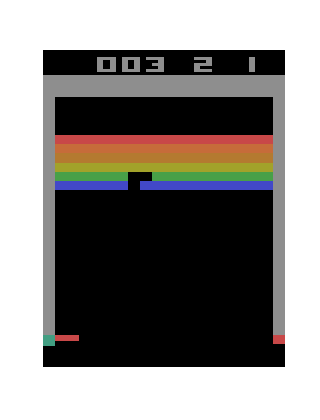
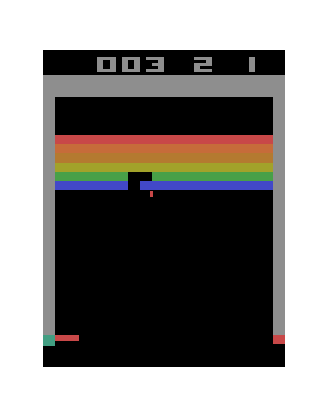
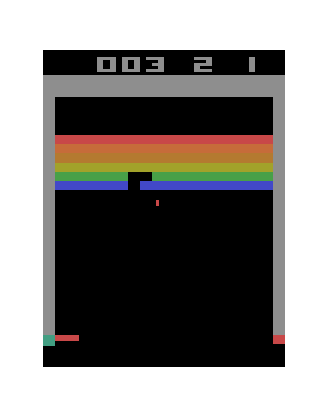
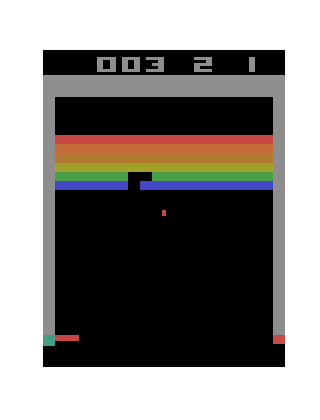
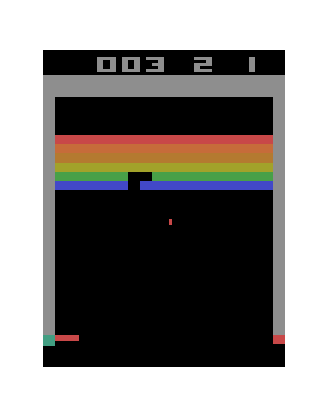
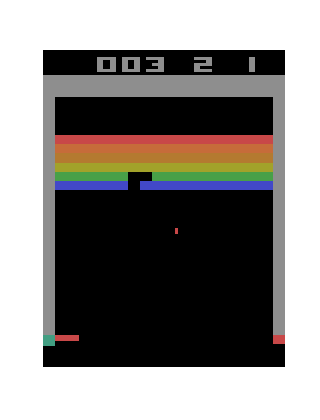
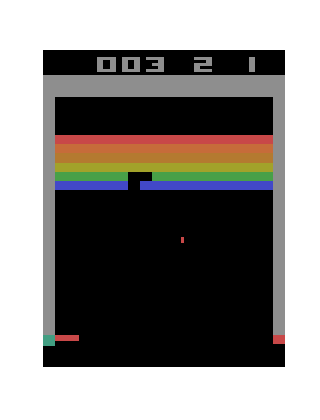
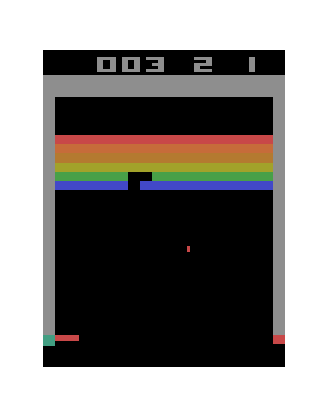
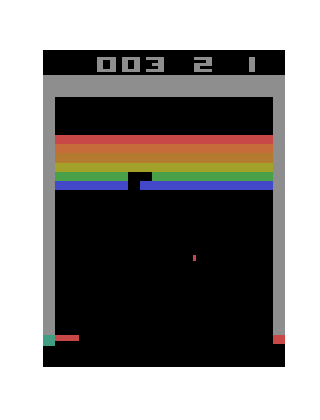
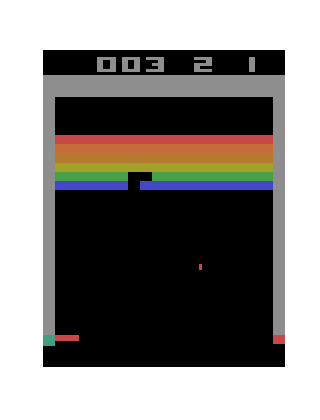
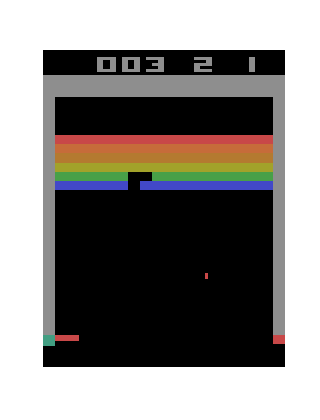
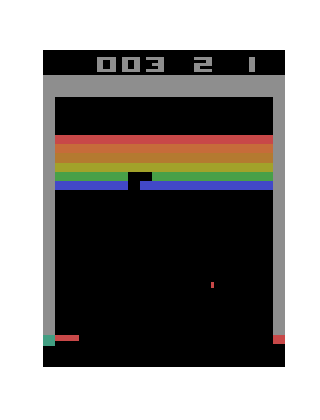
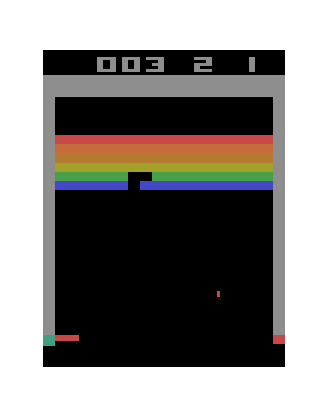
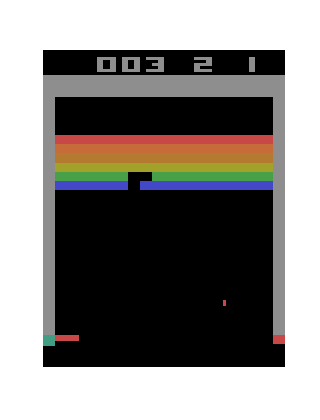
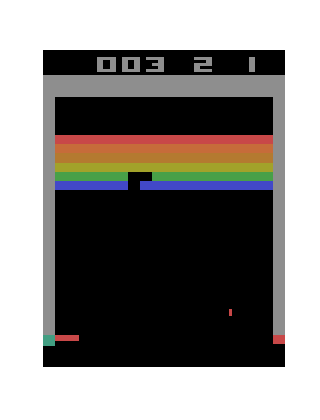
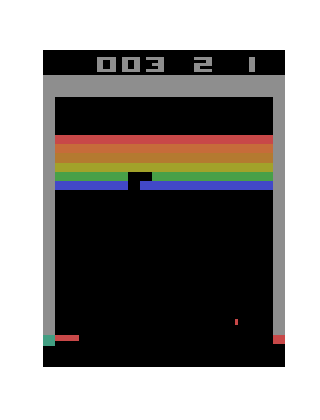
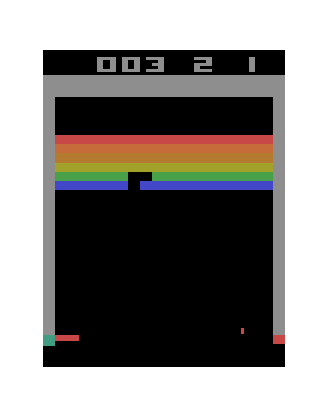
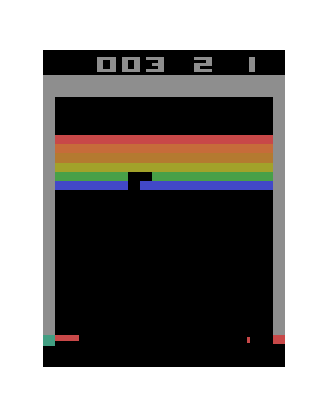
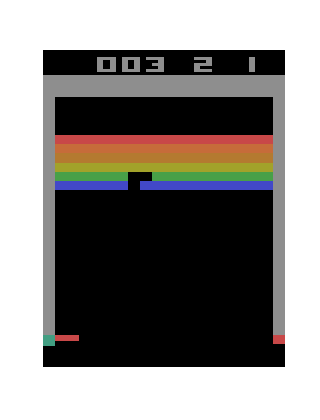
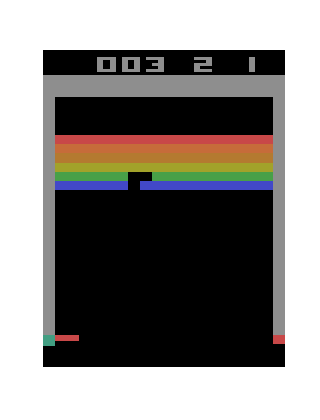
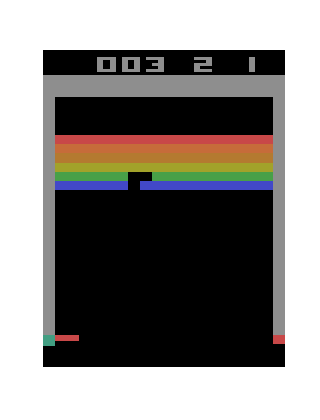
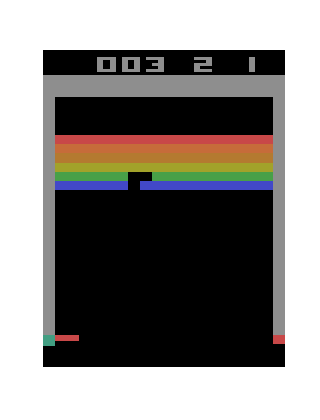
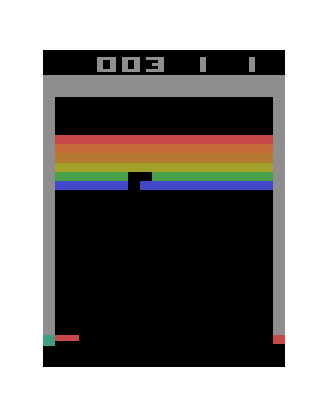
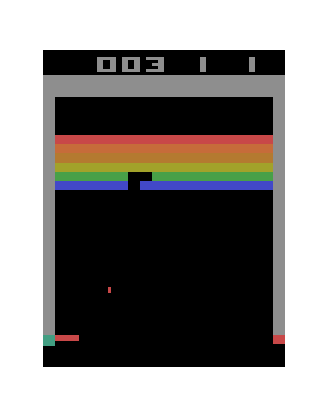
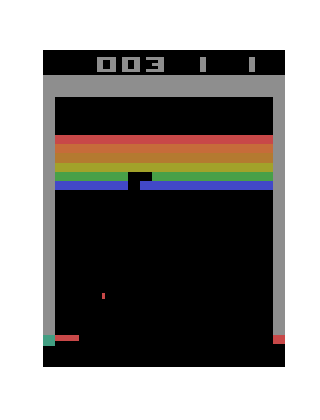
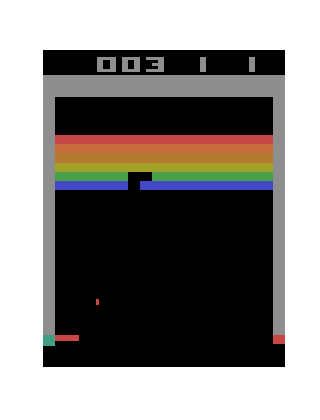
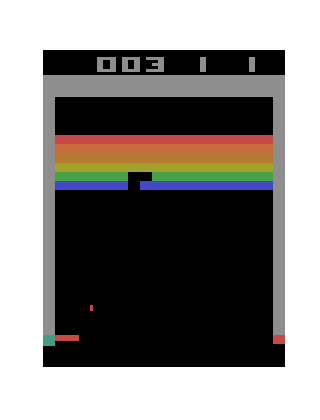
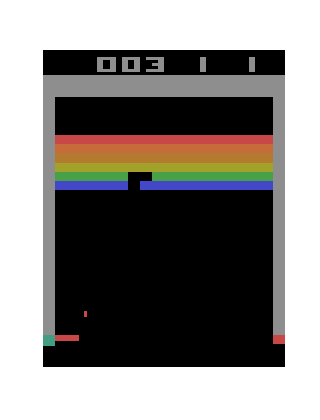
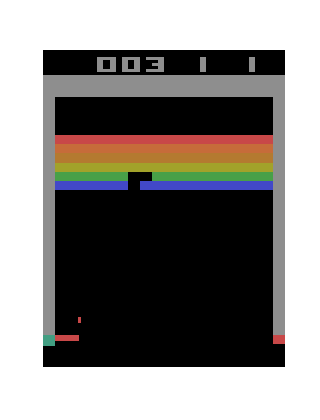
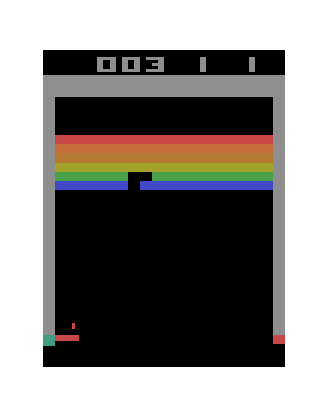
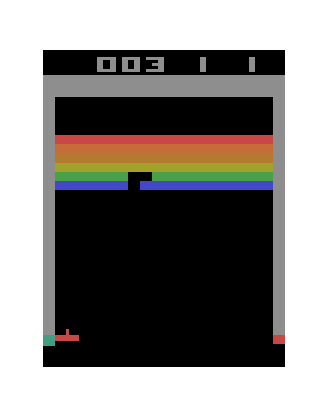
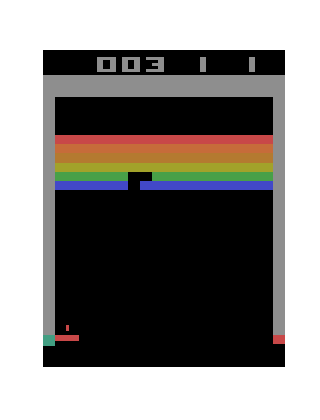
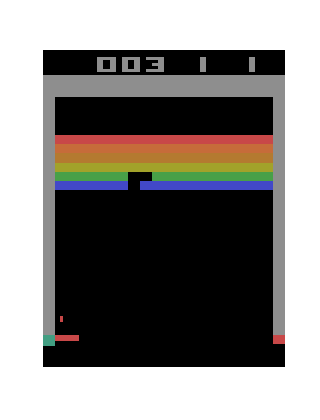
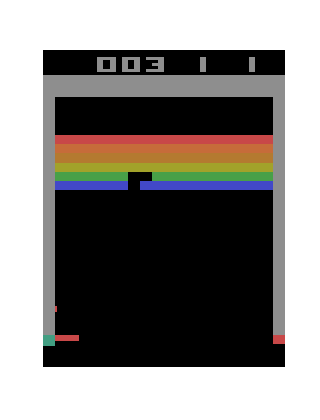
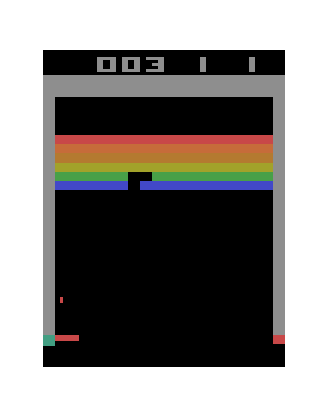
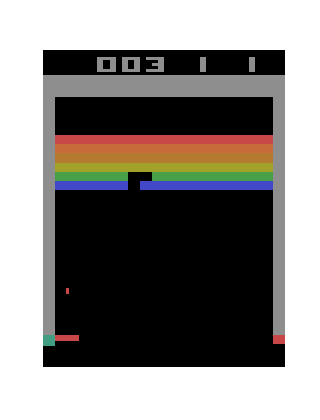
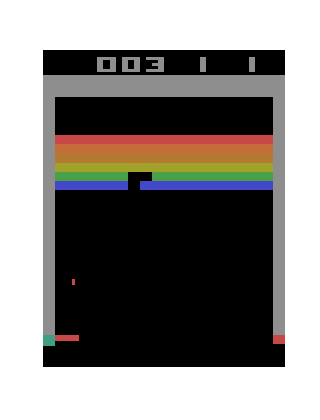
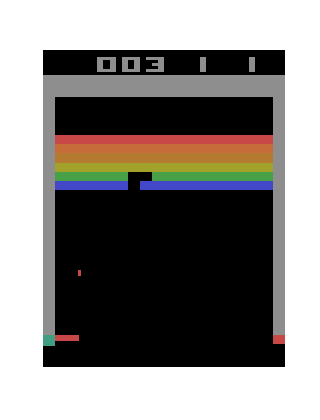
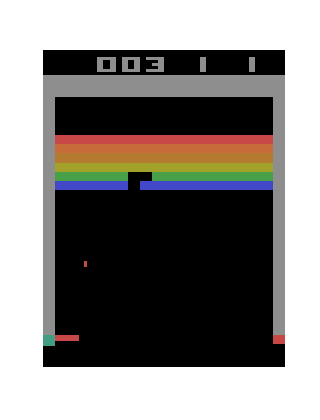
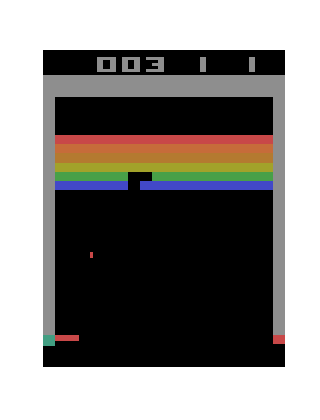
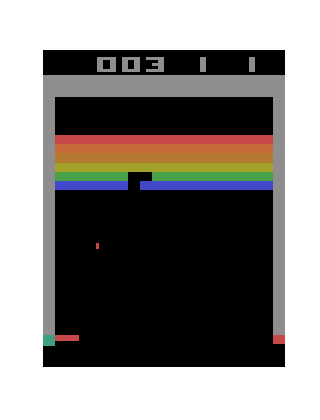
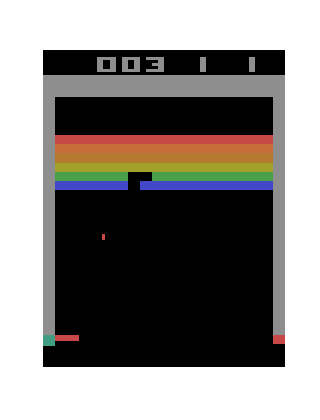
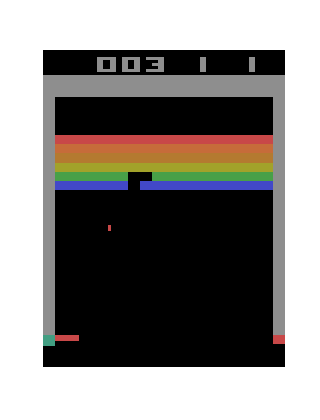
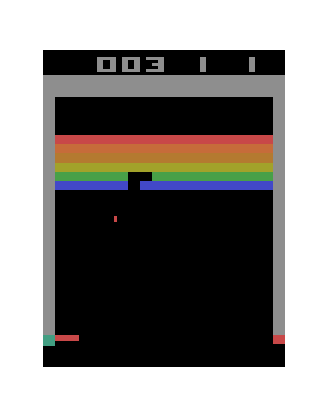
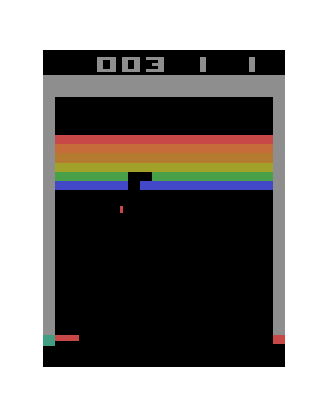
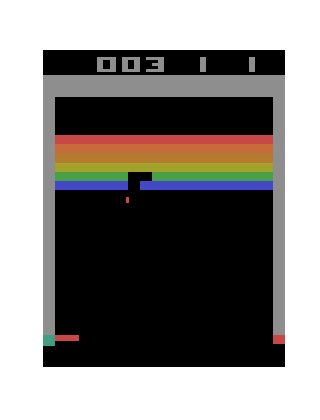
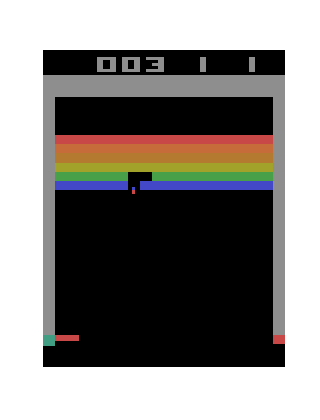
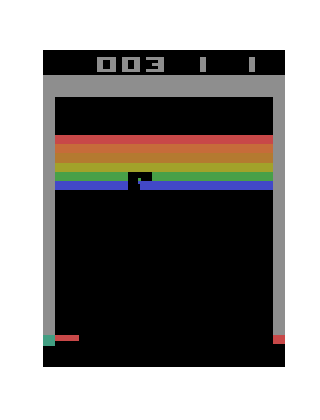
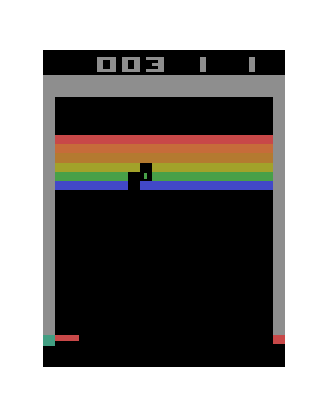
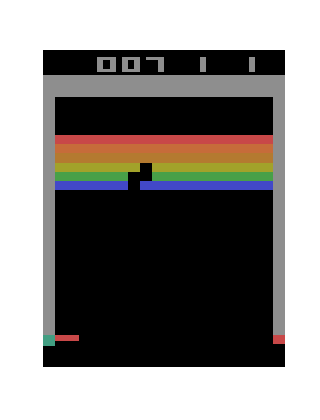
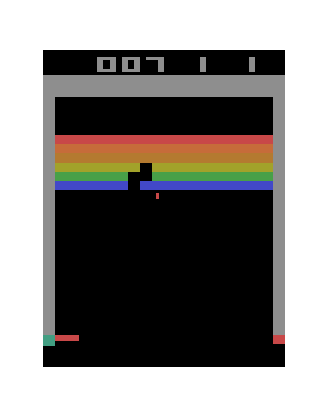
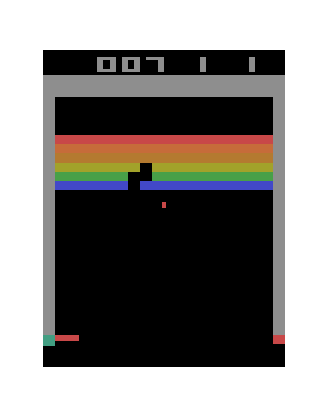
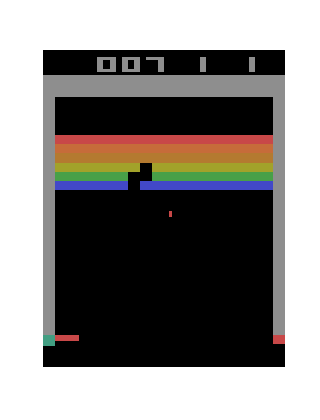
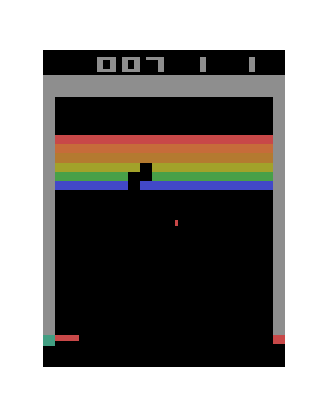
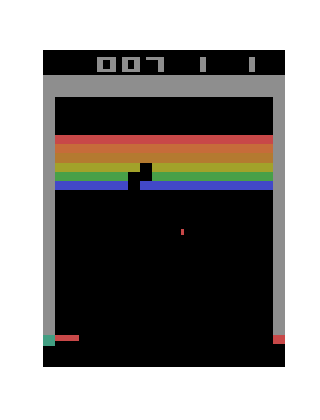
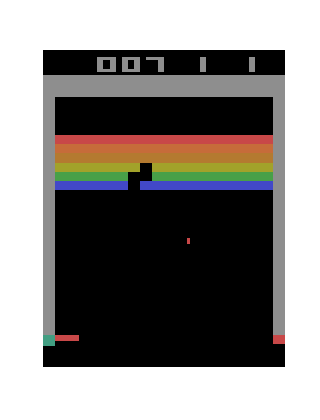
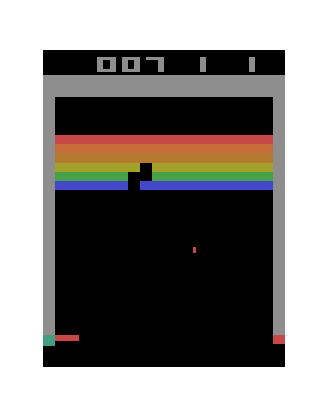
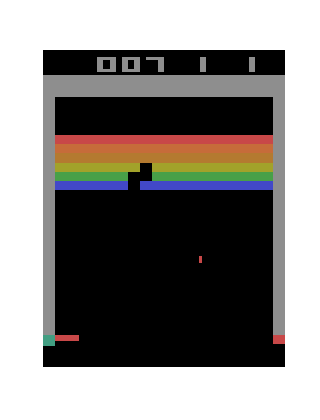
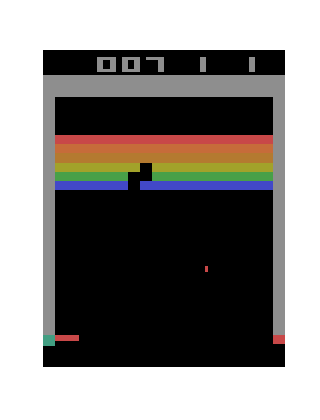
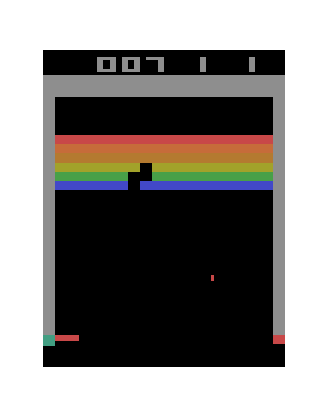
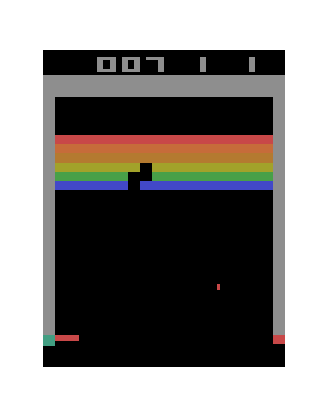
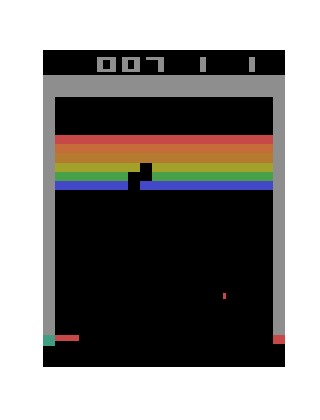
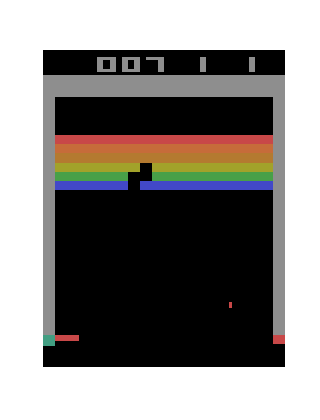
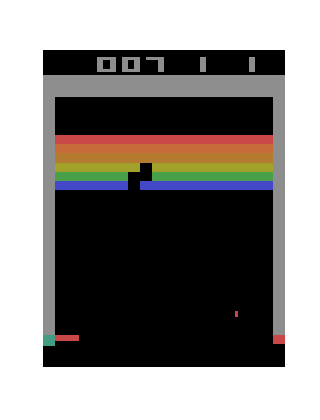
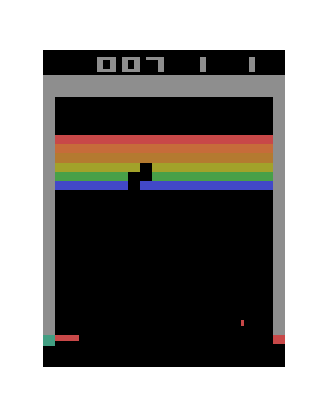
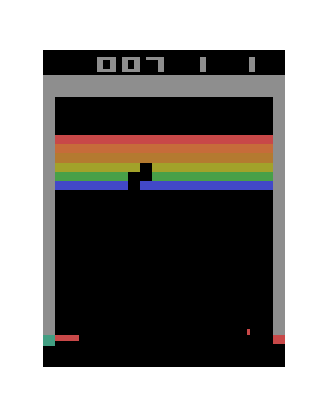
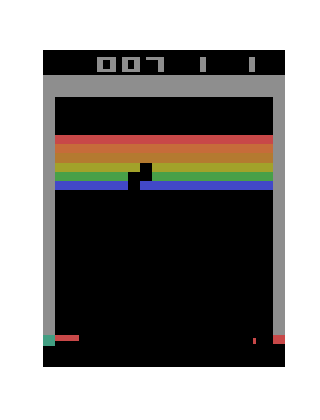
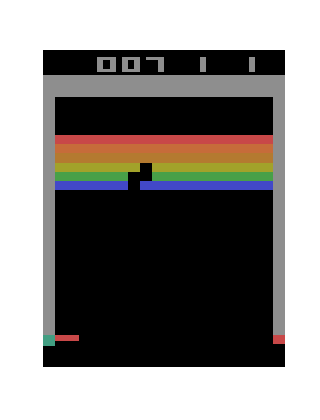
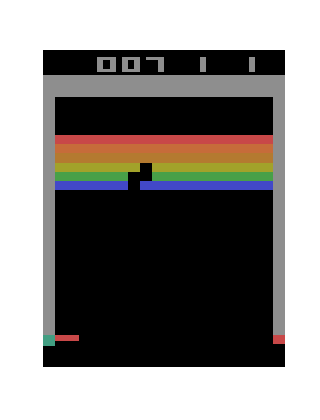
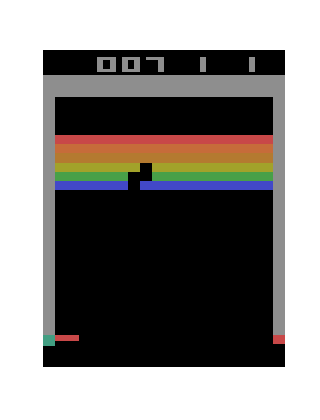
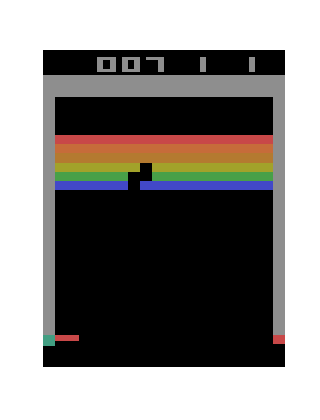
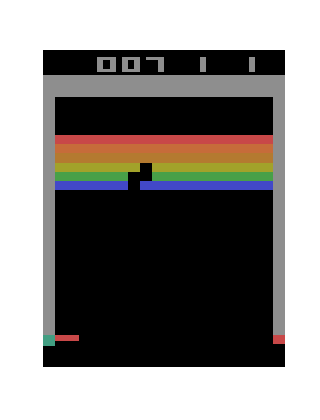
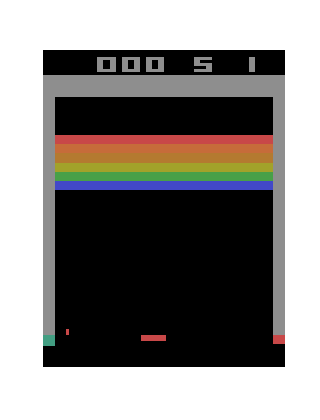
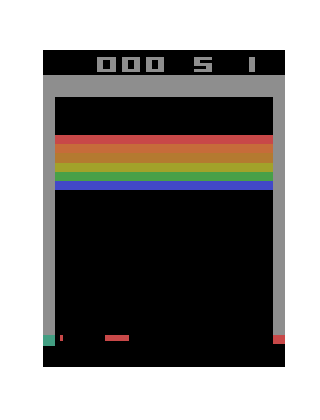
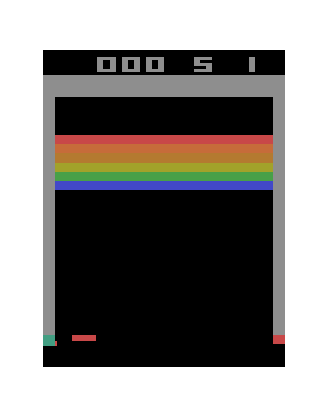
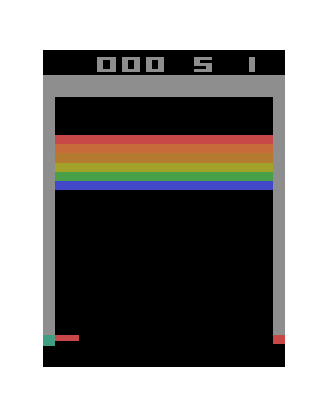
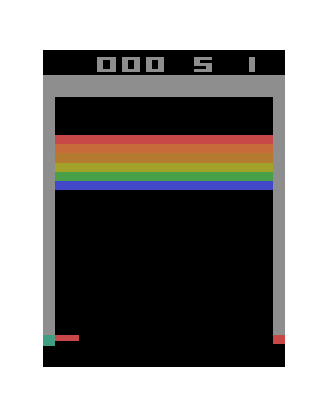
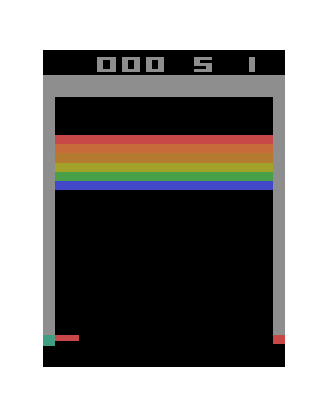
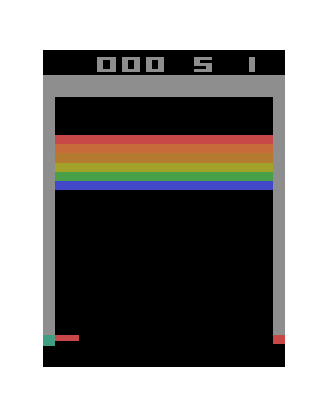
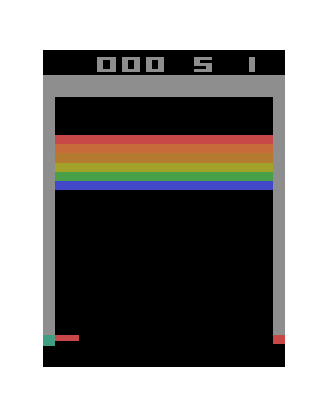
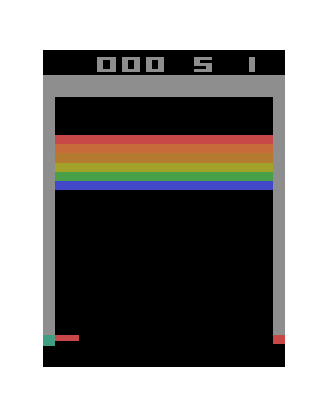
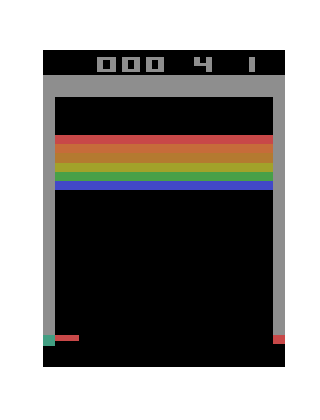
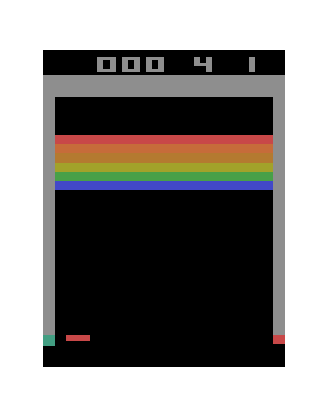
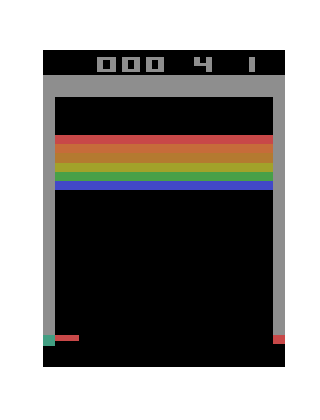
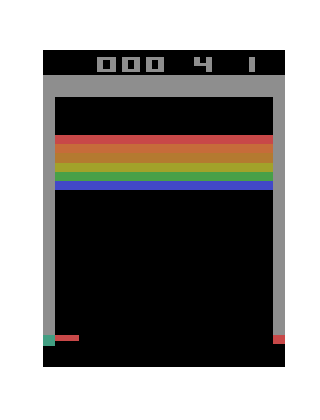
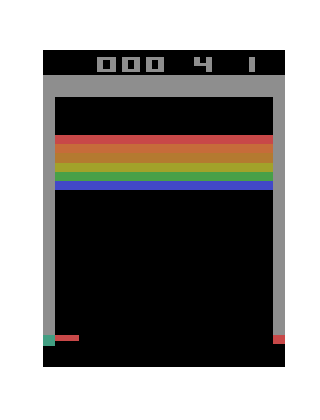
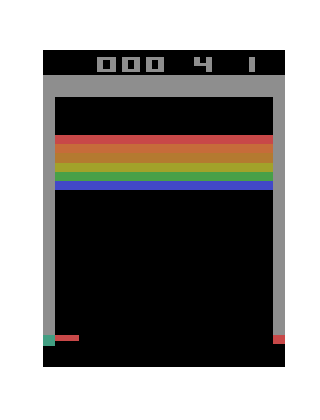
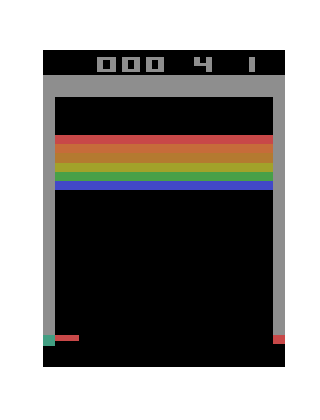
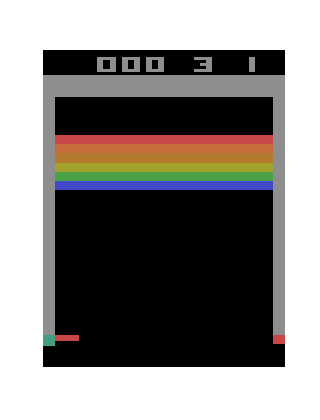
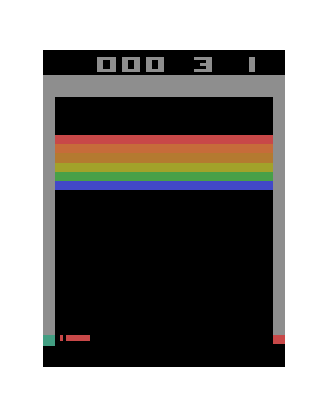
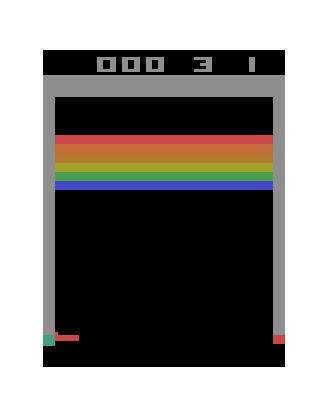
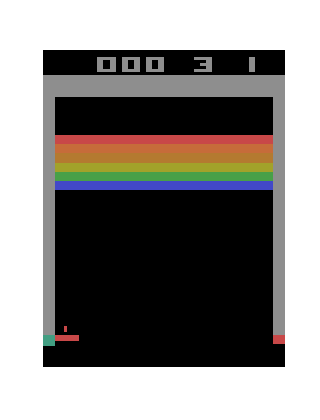
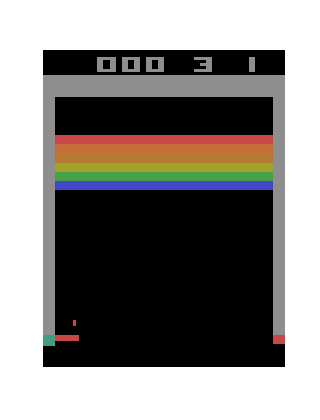
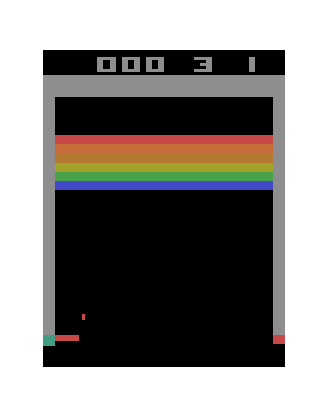
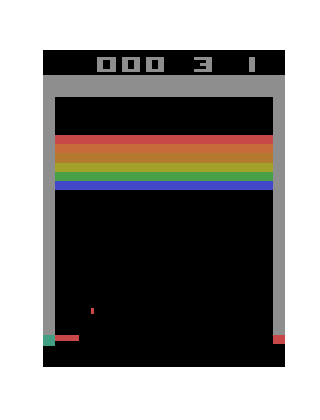
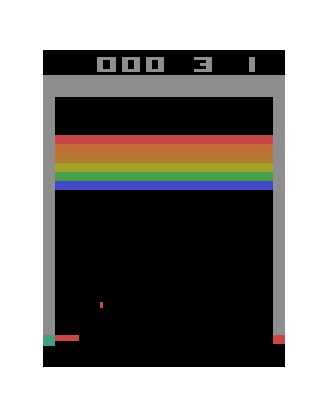
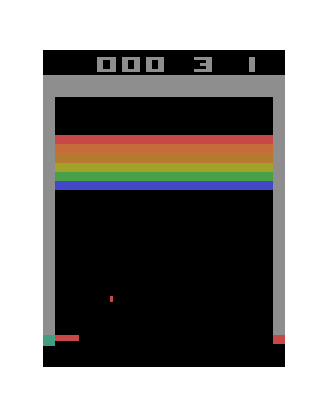
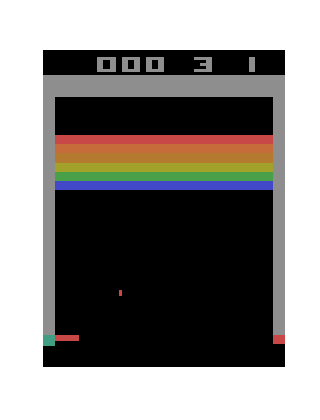
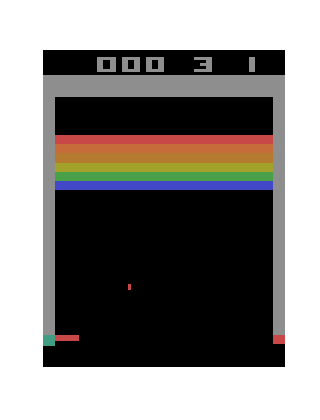
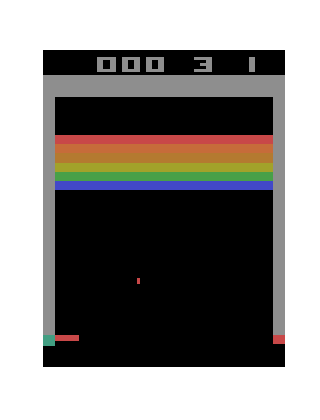
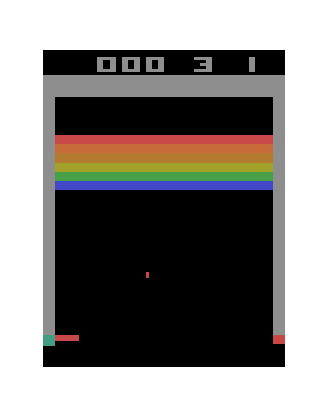
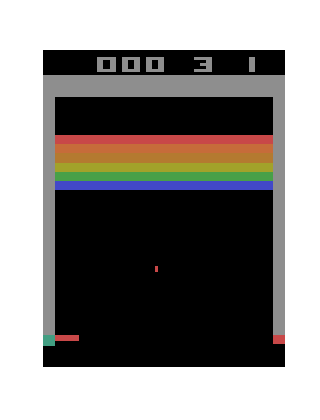
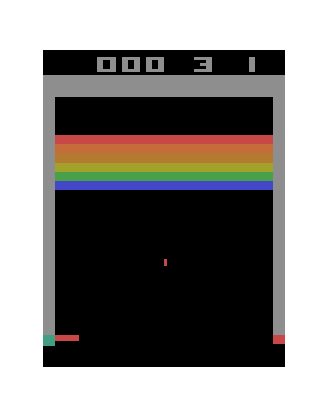
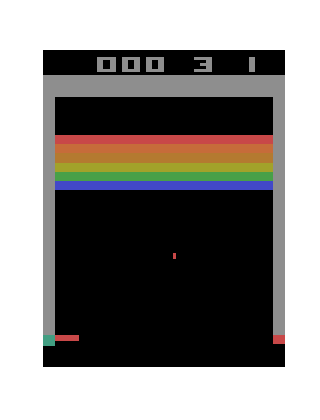
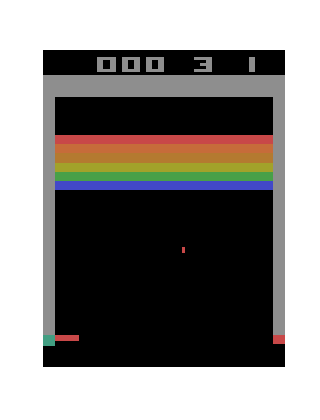
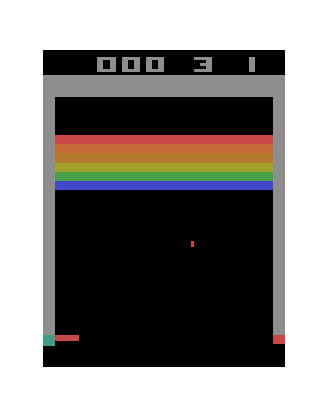
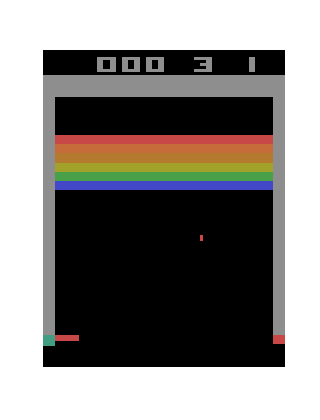
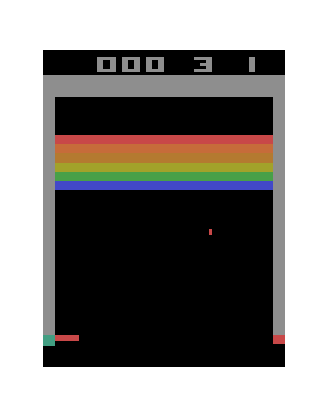
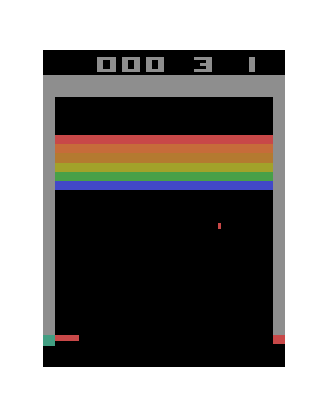
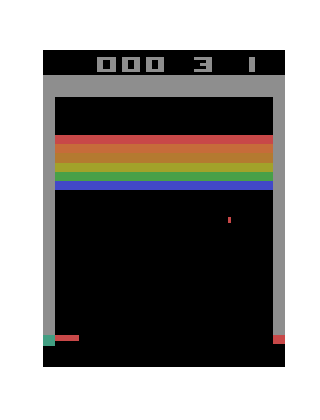
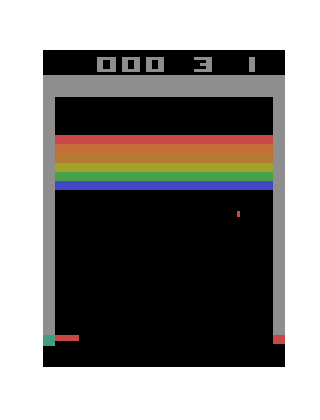
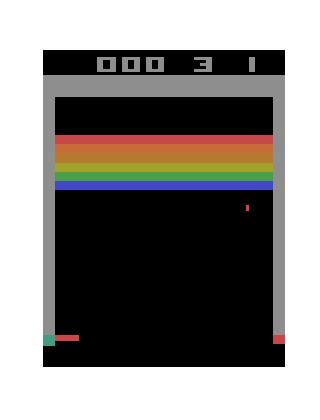
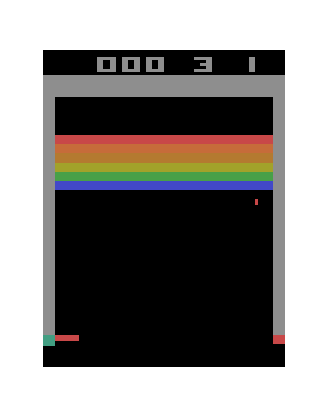
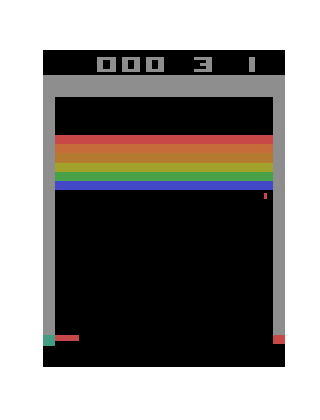
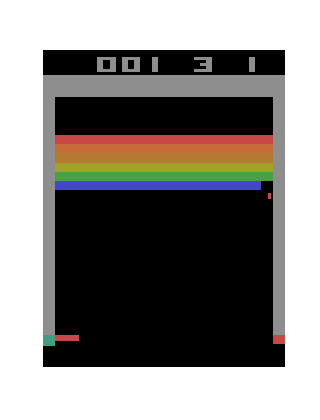
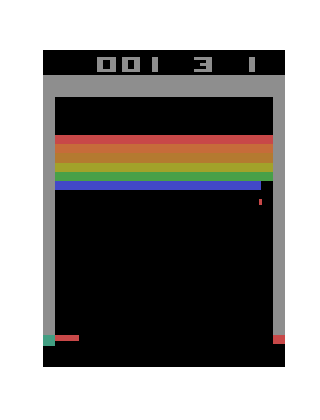
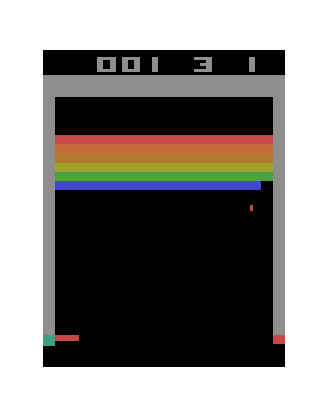
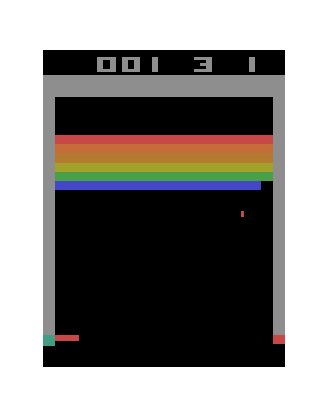
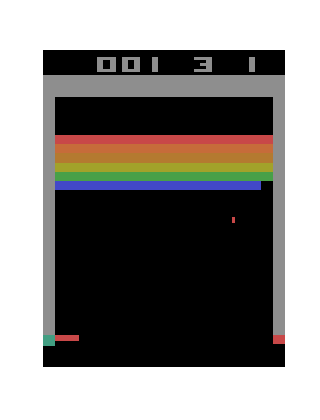
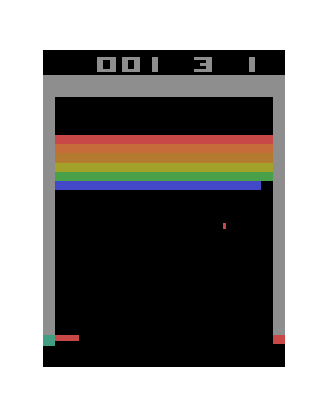
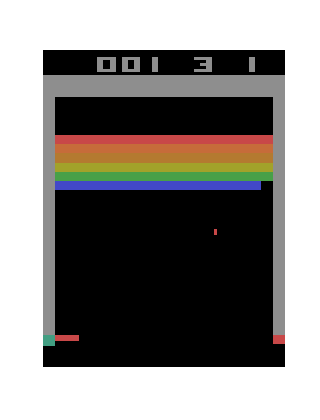
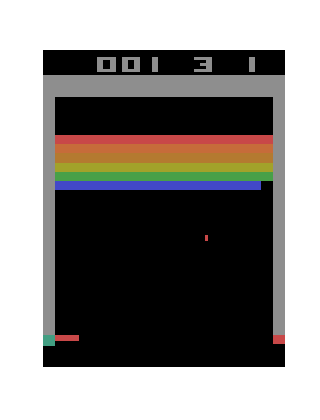
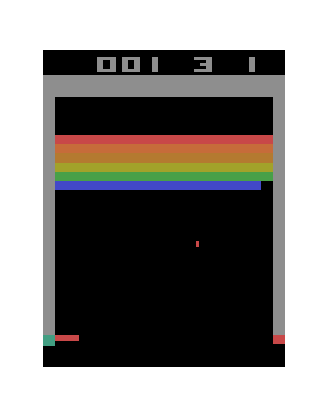
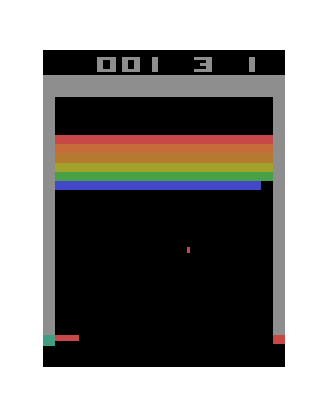
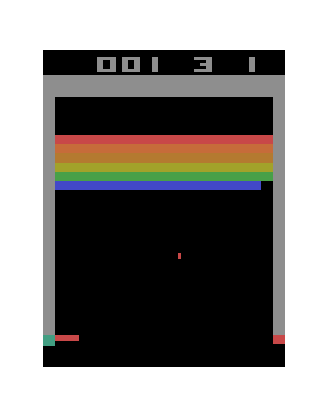
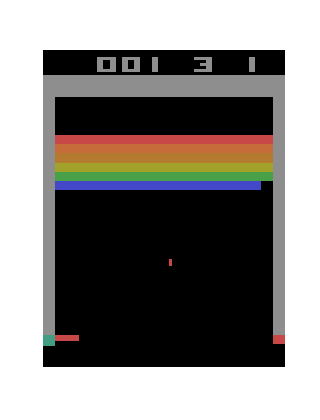
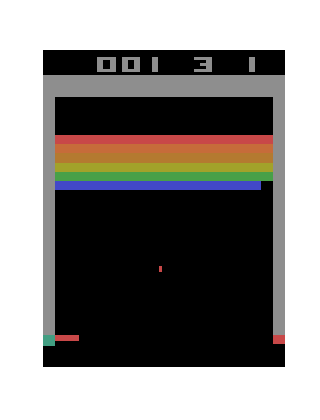
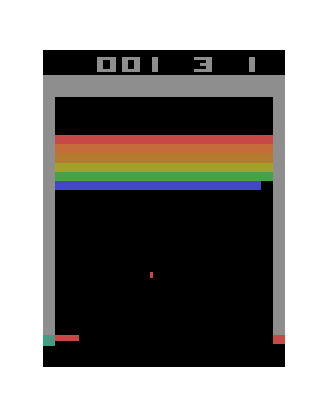
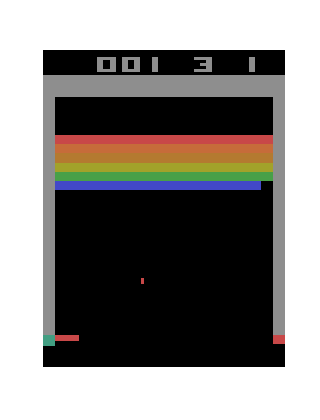
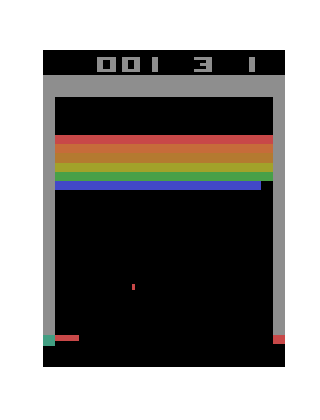
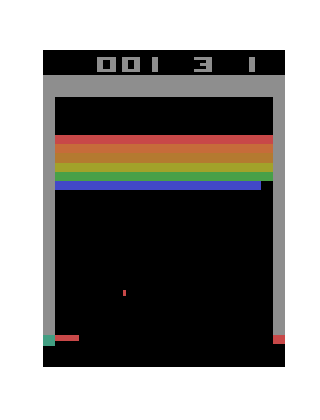
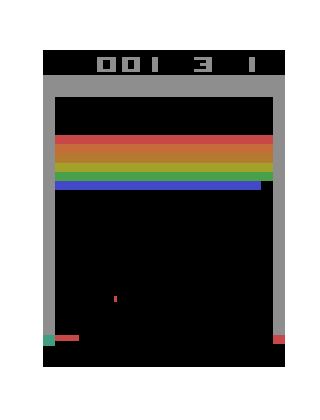
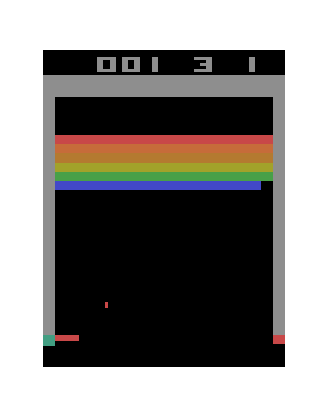
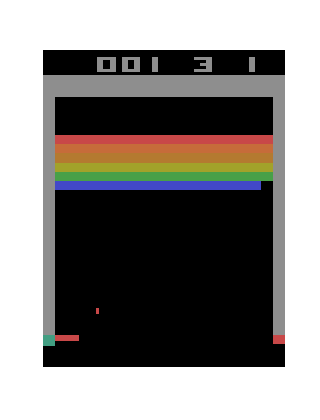
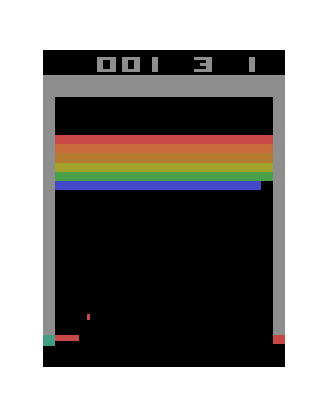
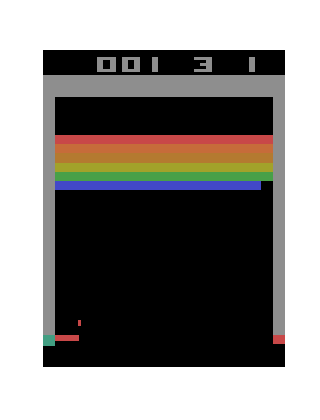
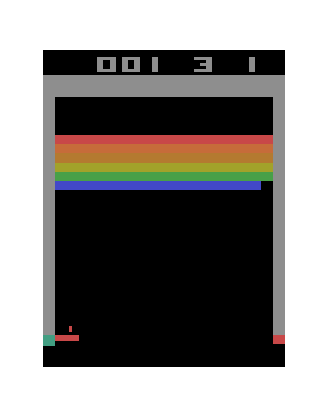
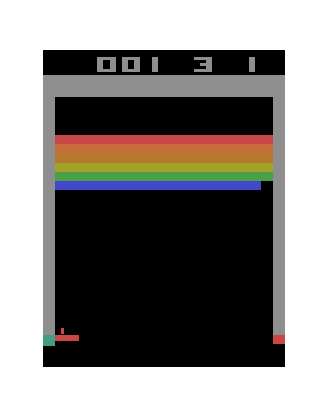
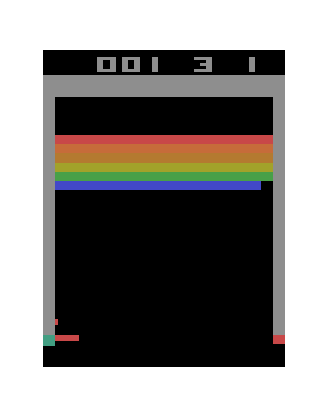
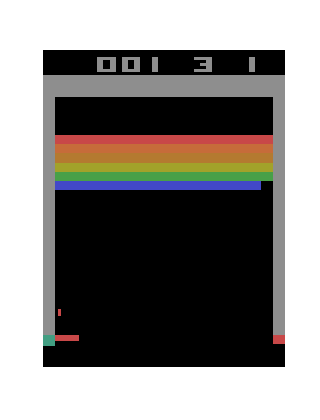
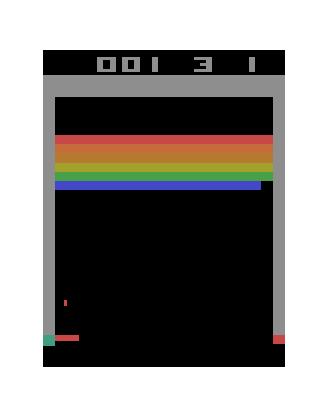
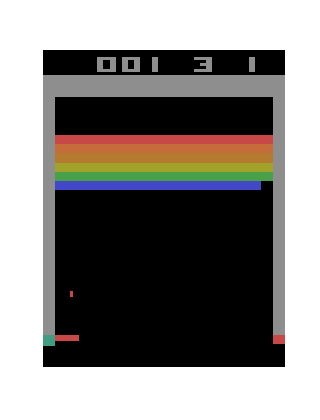
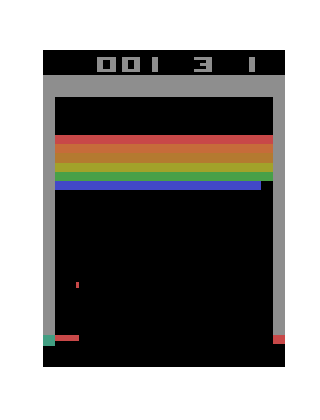
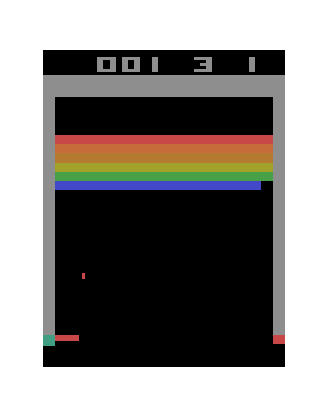
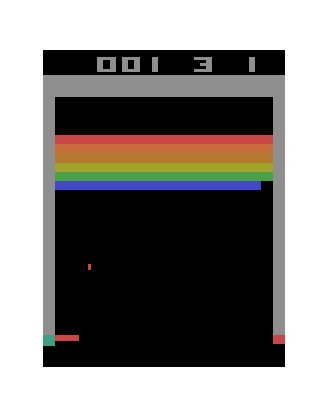
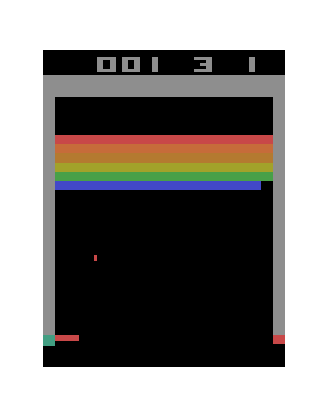
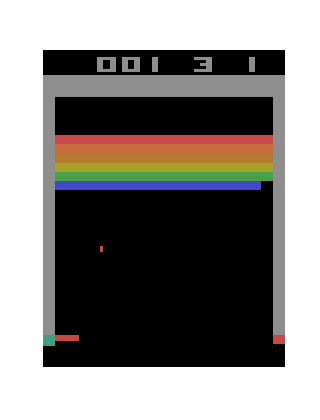
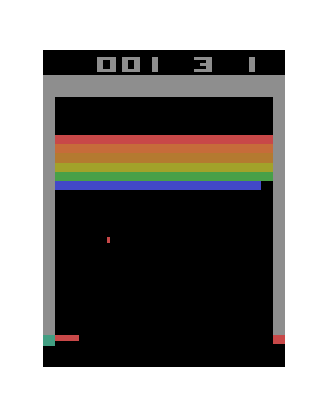
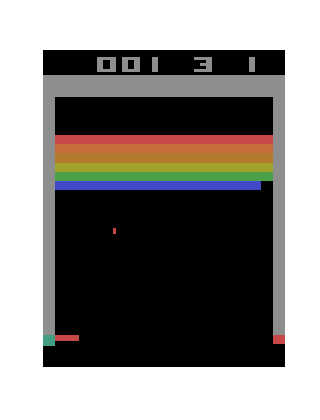
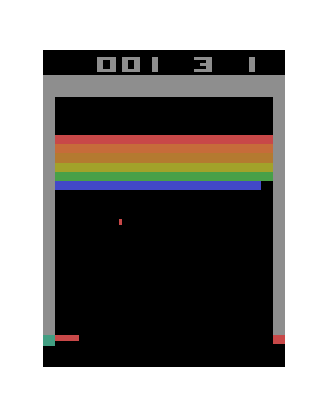
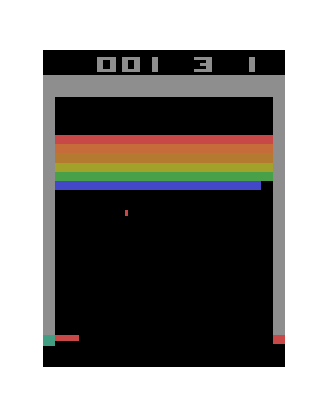
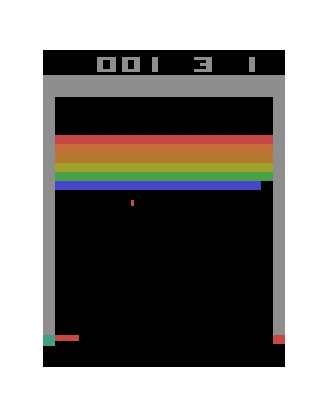
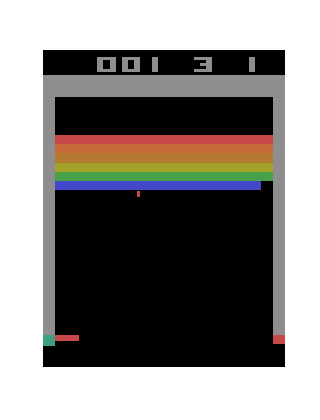
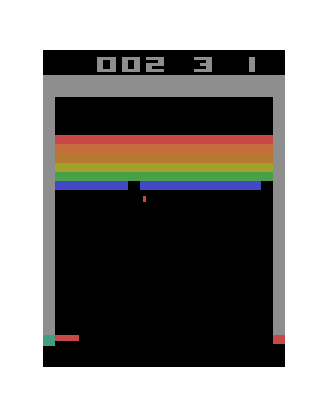
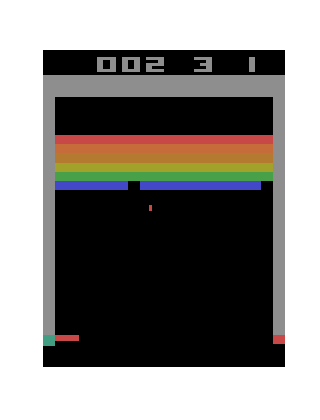
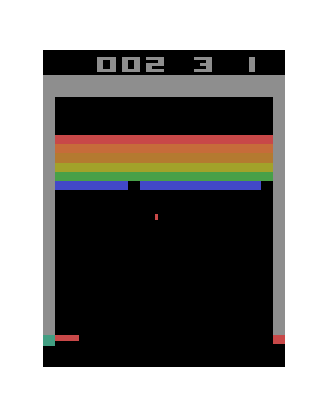
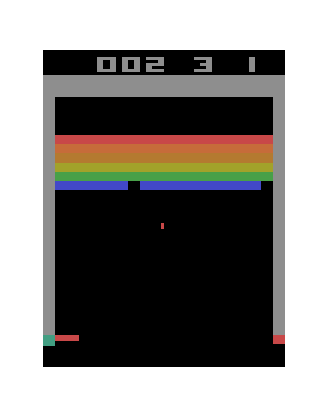
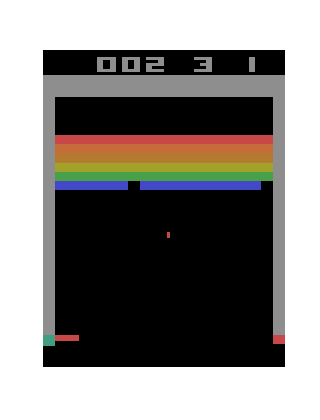
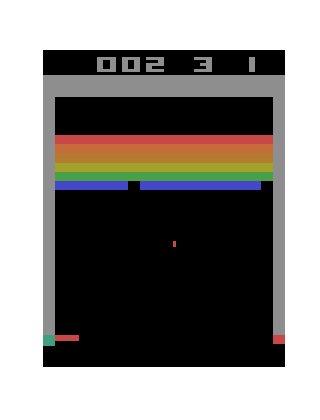
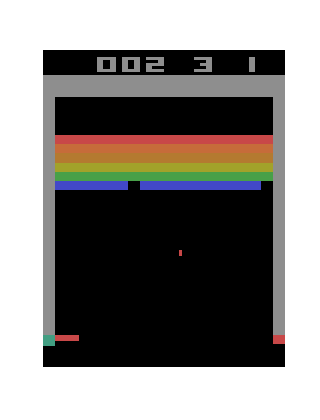
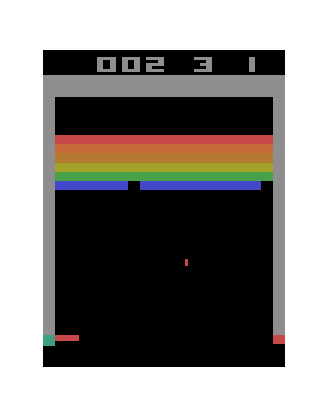
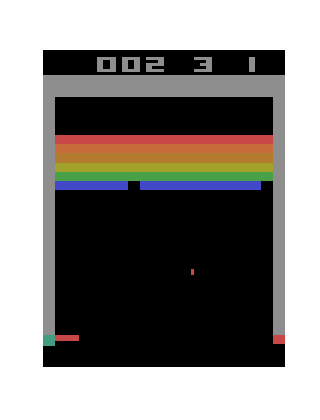
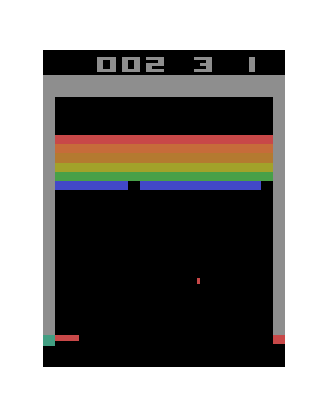
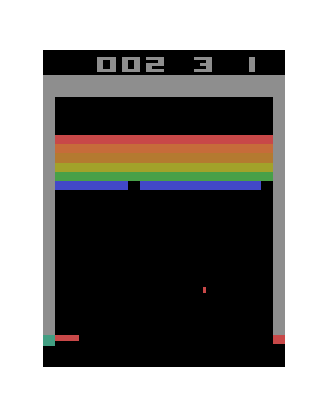
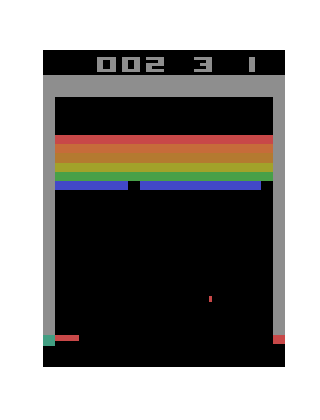
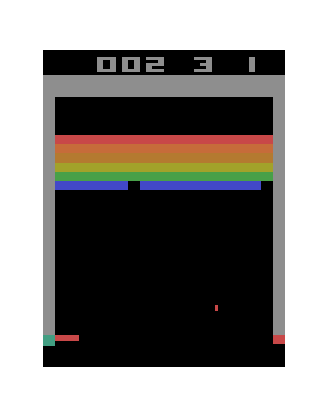
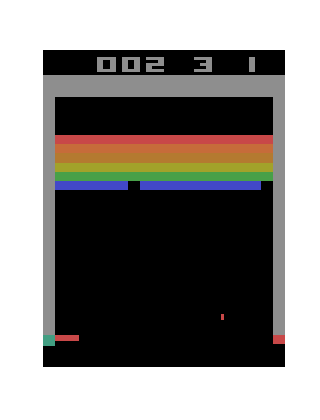
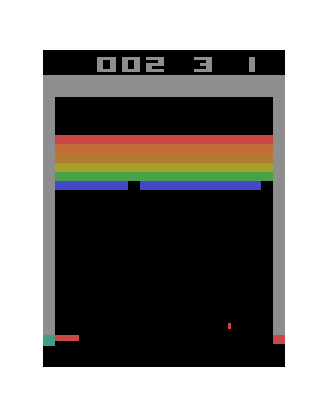
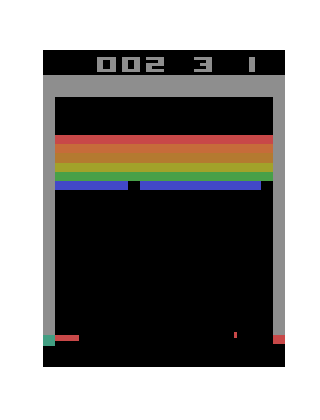
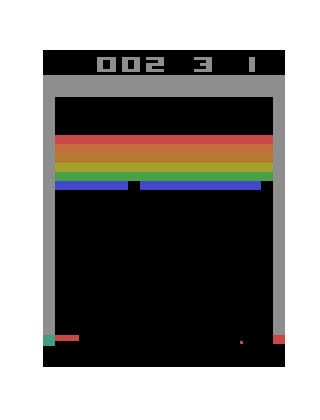
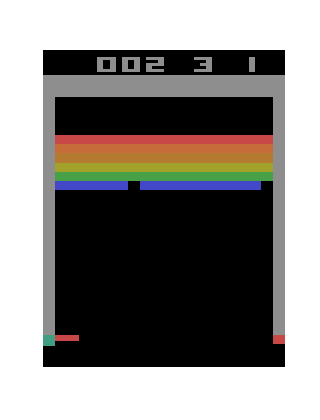
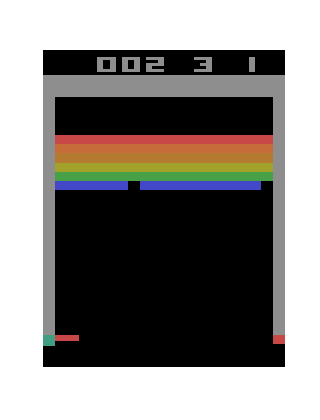
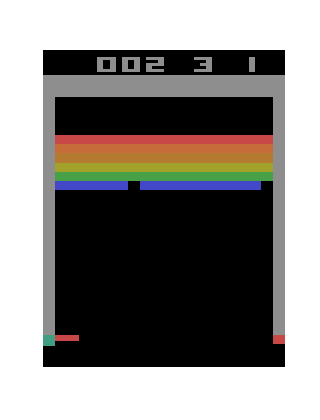
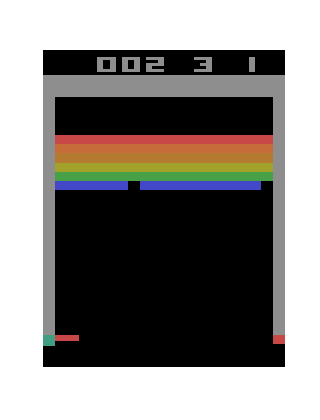
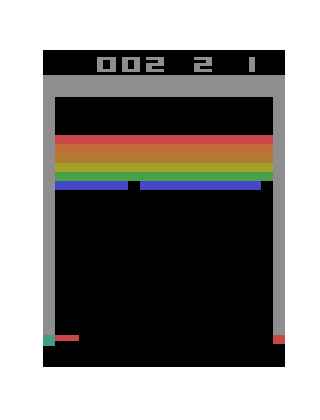
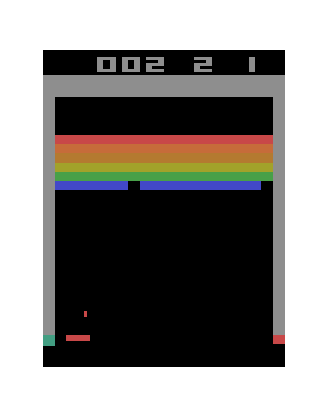
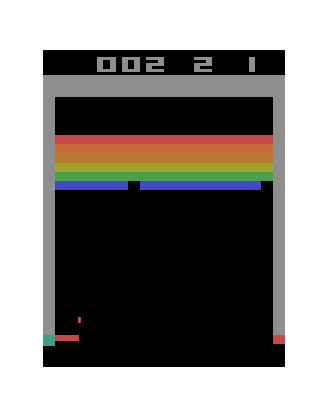
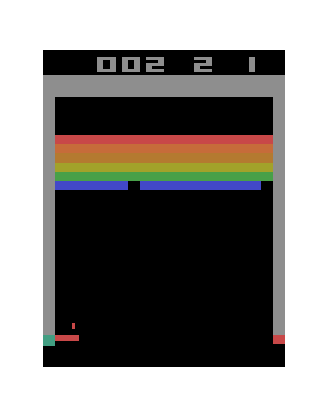
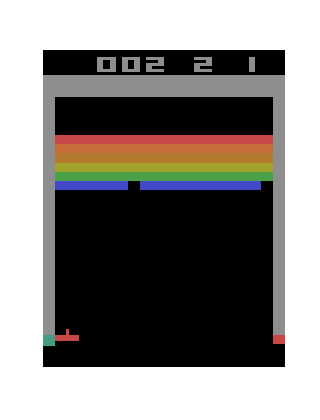
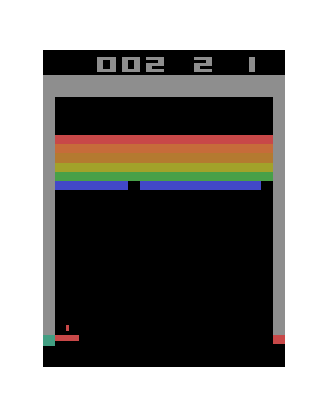
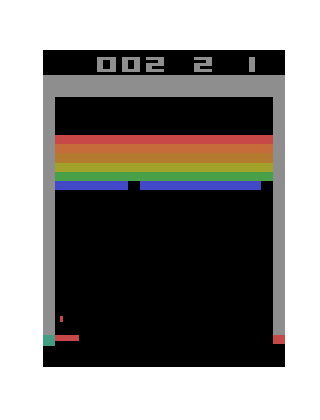
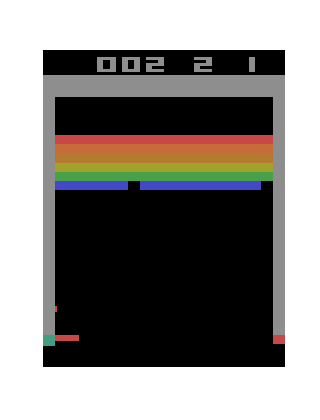
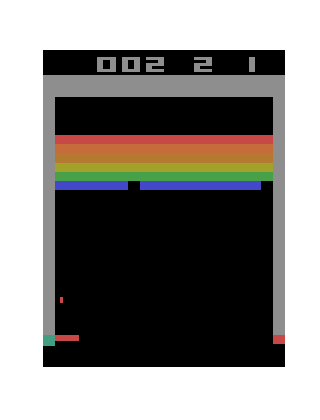
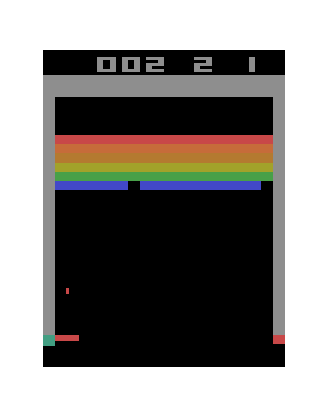
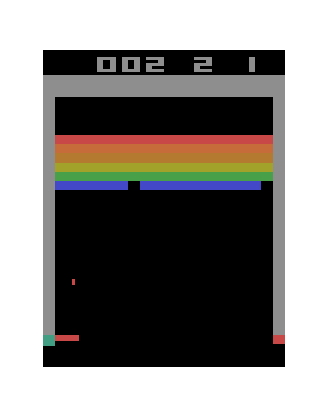
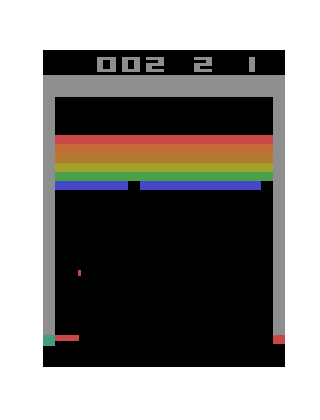

In [10]:
Env.animation.run()
Env.animation.reset()


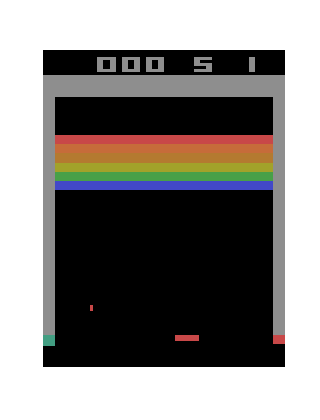
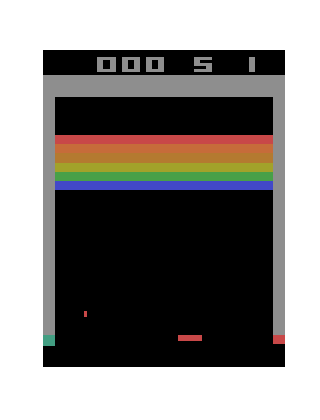
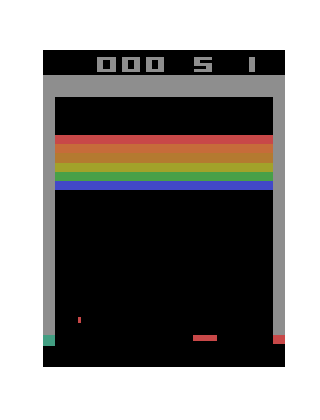
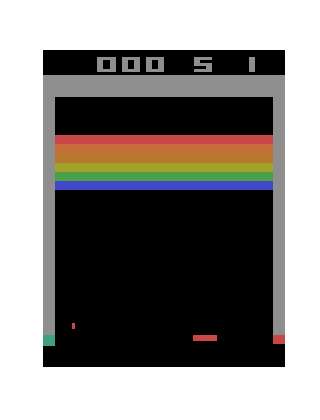
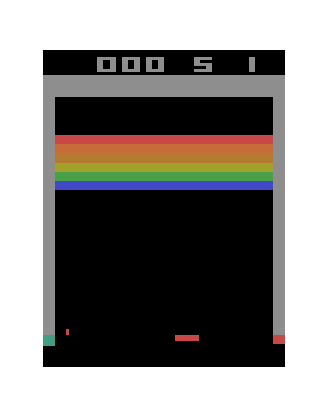
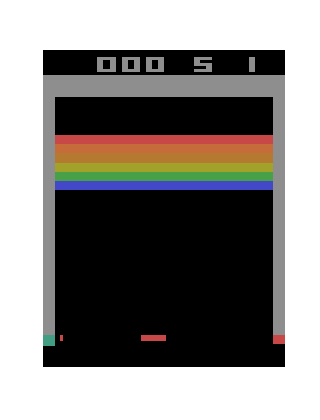
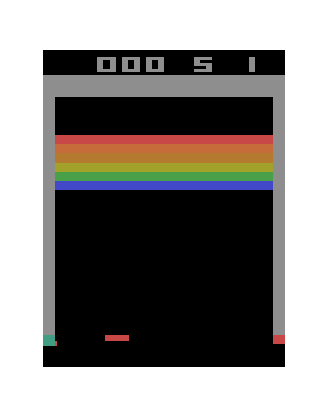
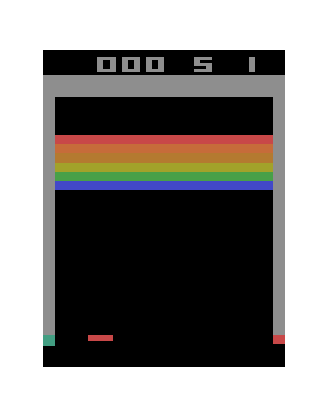
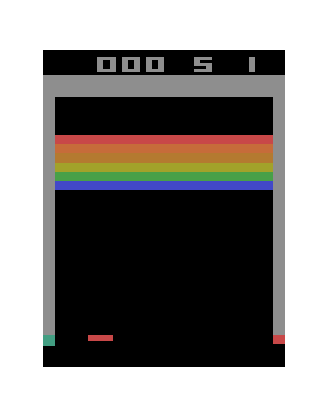
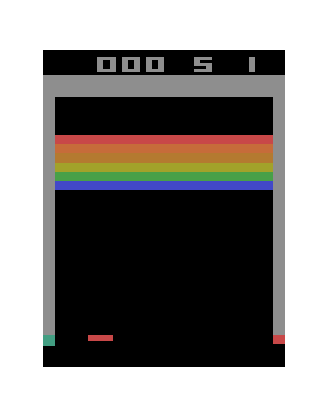
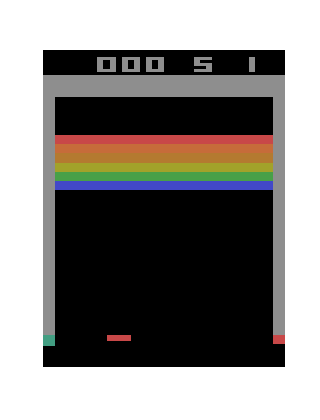
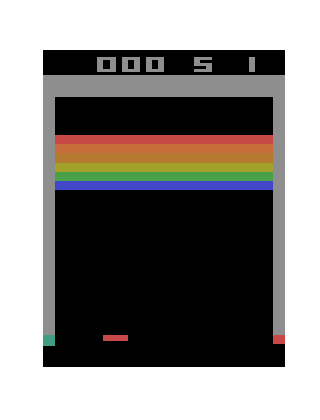
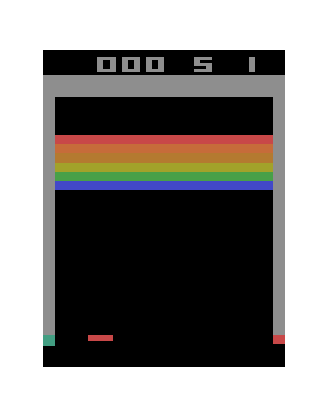
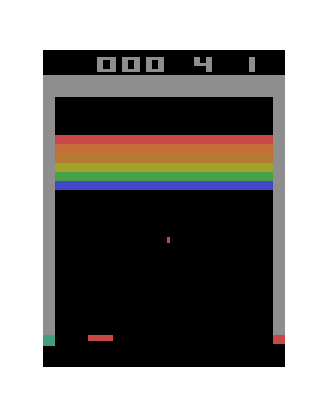
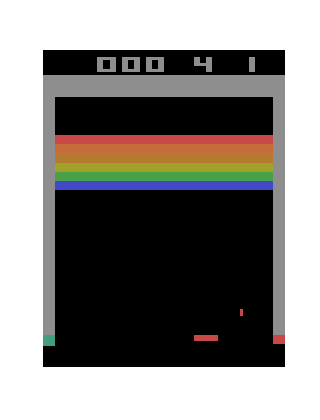
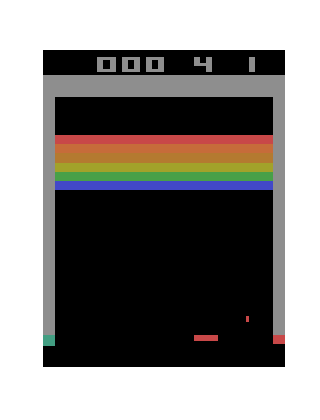
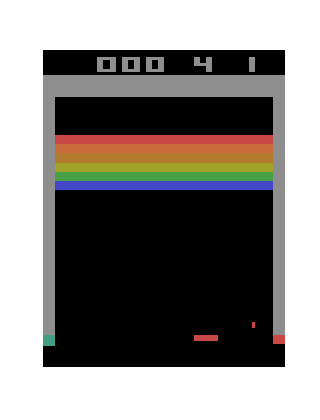
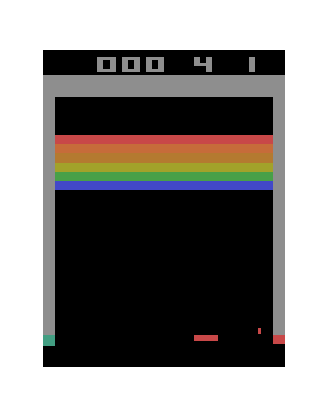
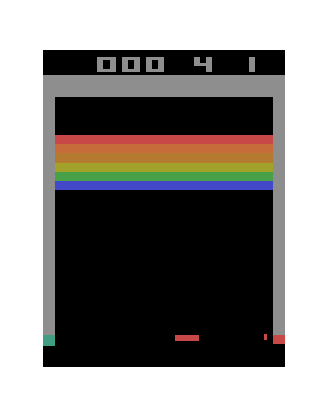
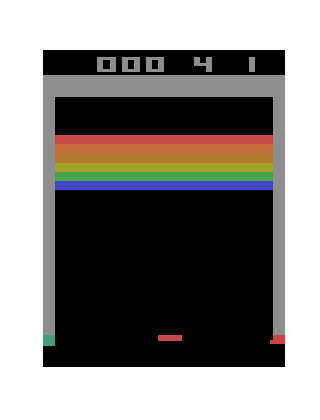
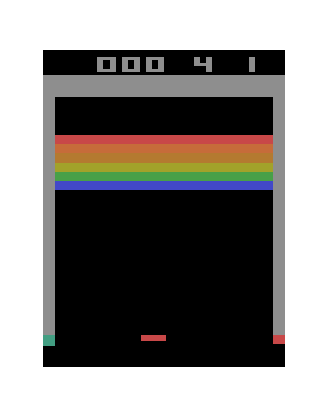
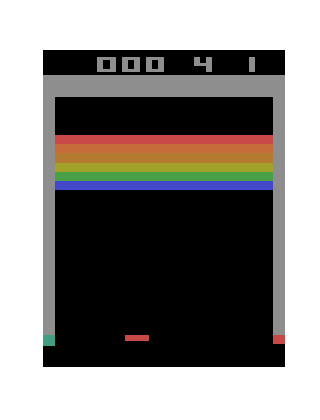
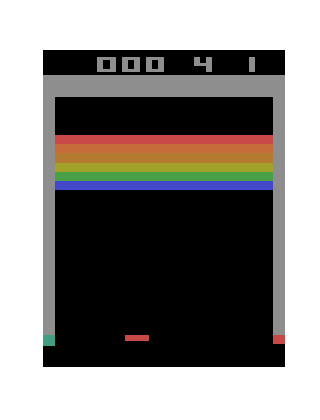
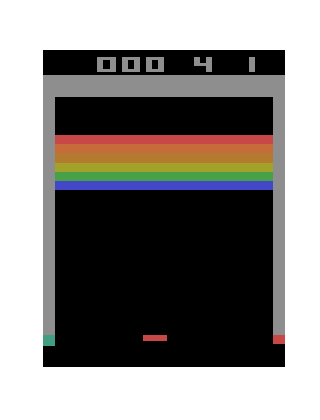
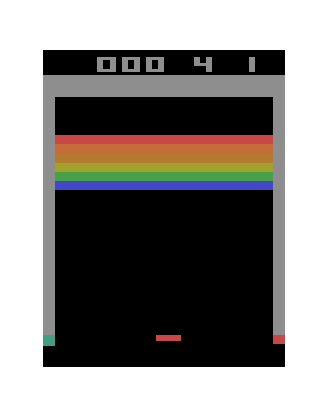
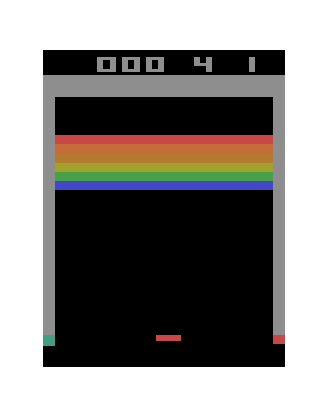
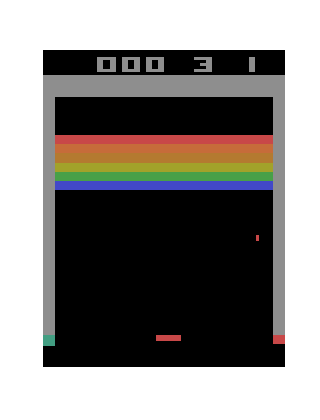
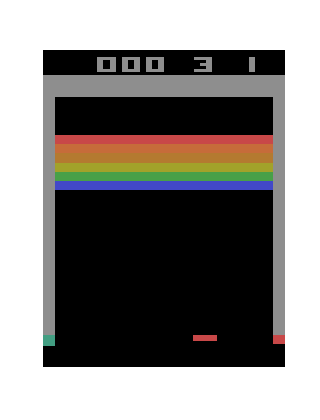
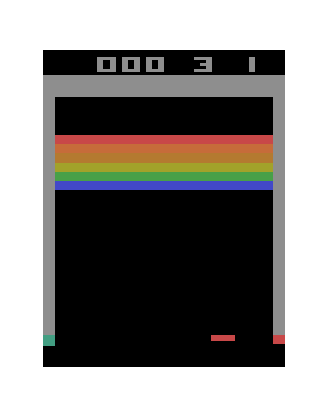
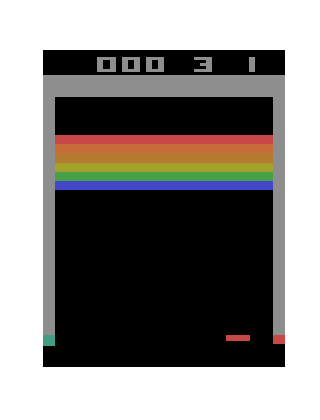
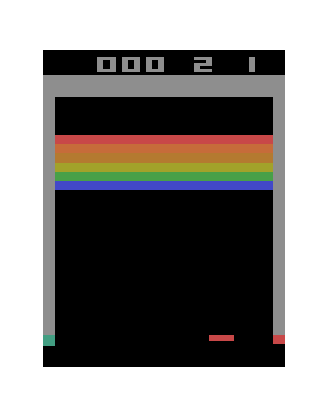
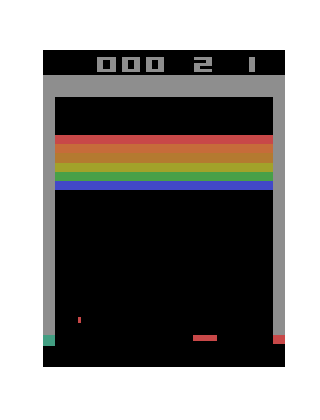
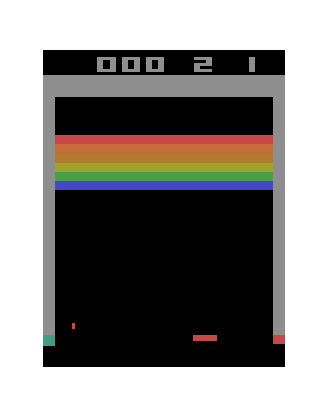
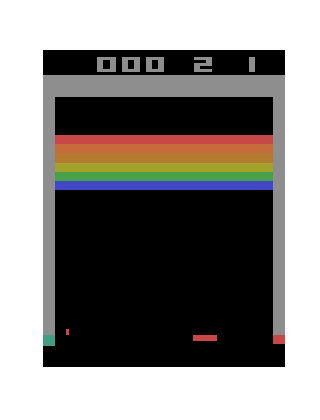
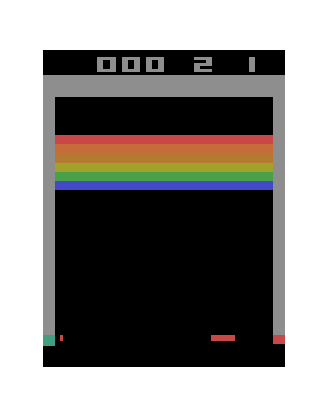
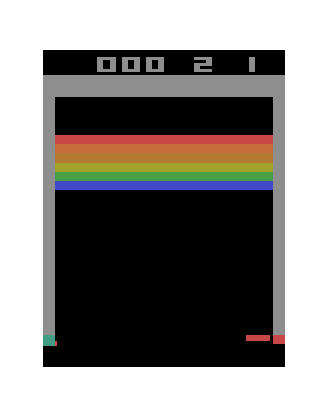
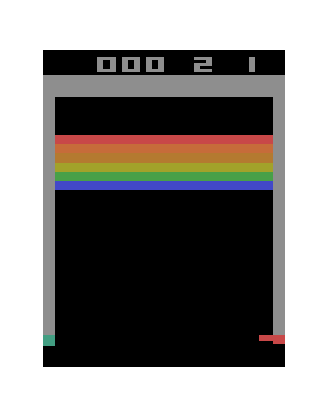
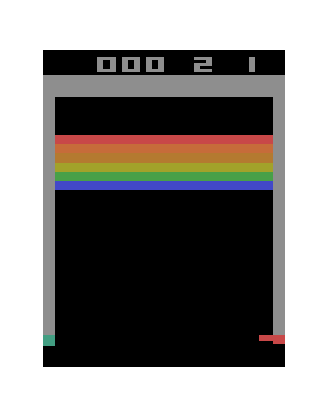
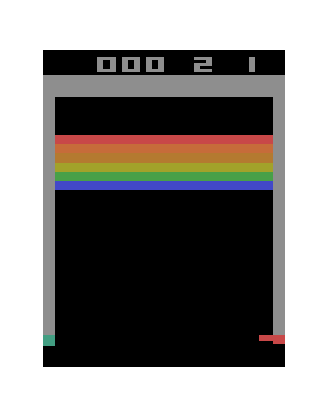
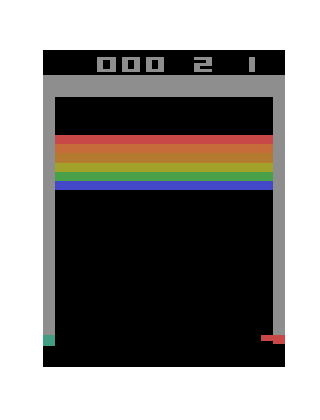
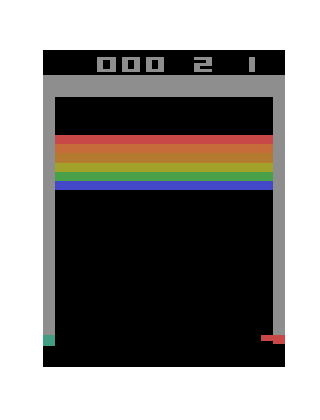
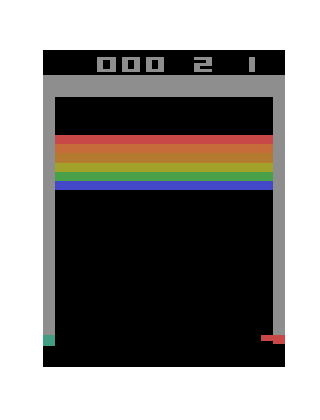
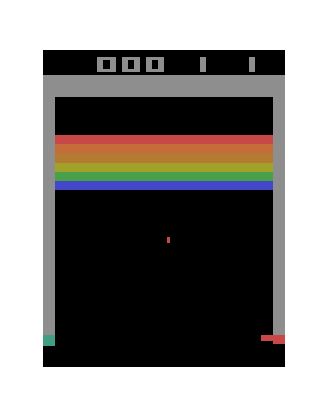
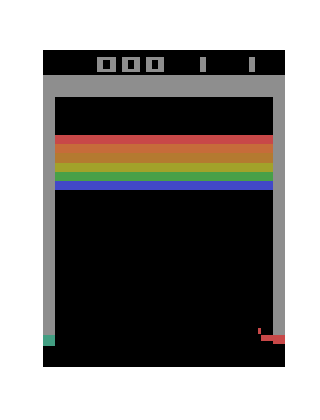
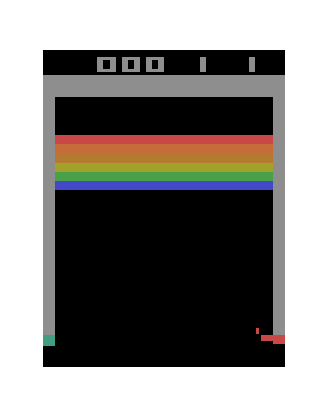
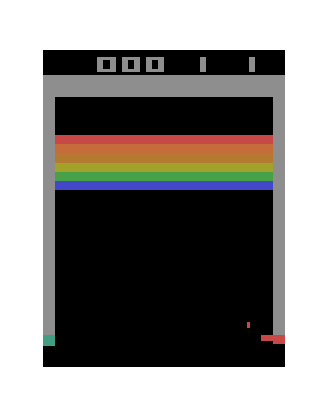
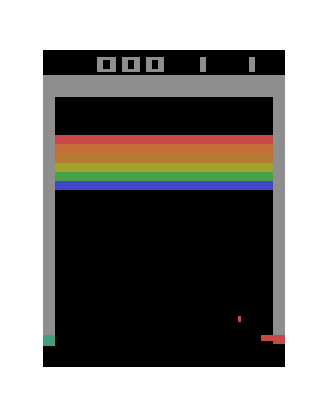
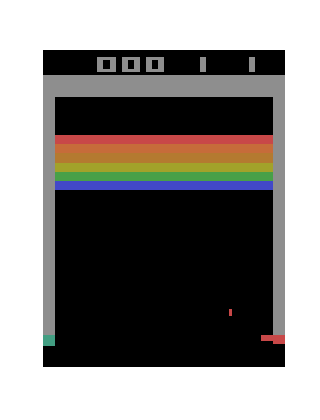
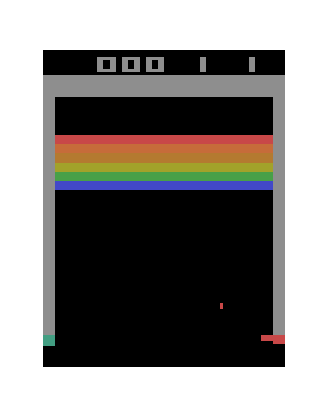
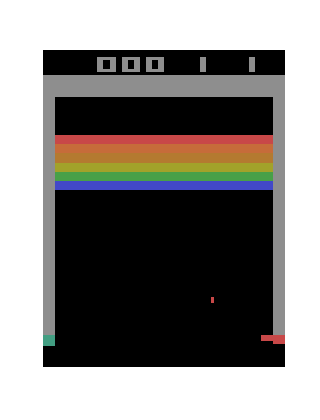
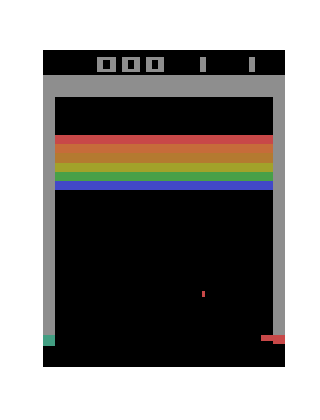
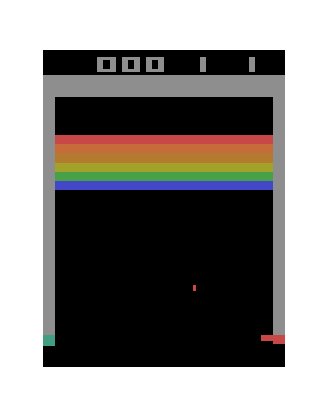
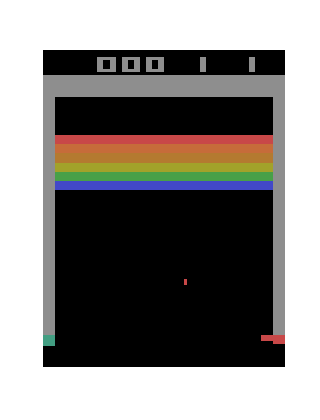
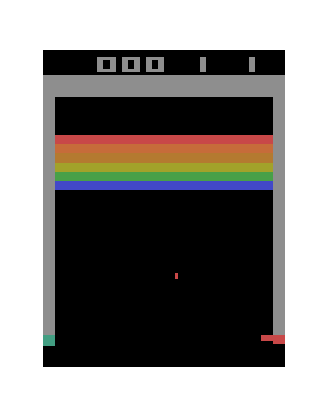
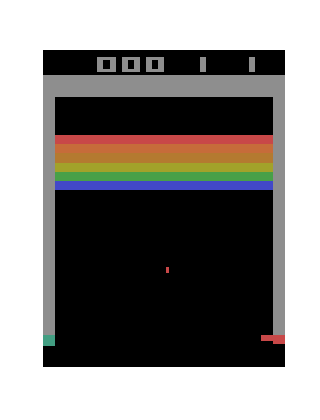
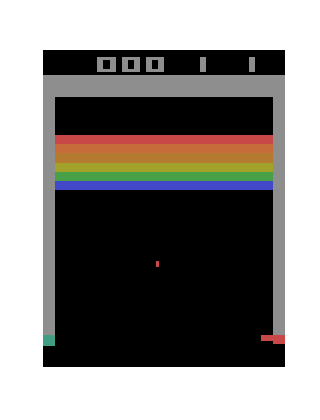
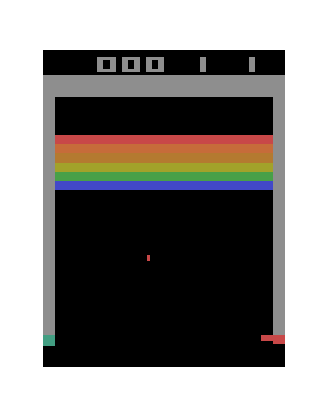
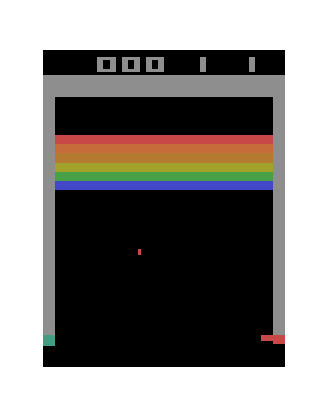
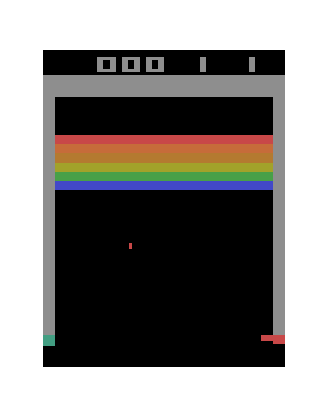
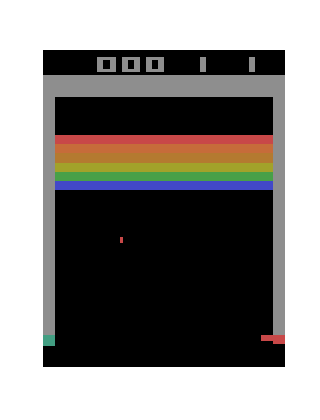
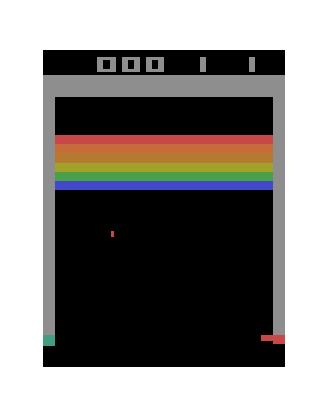
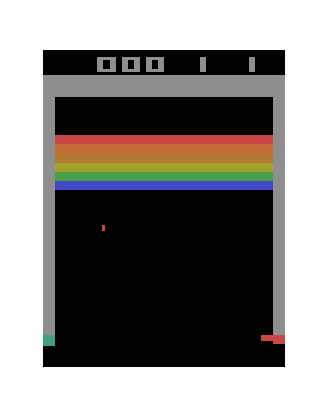
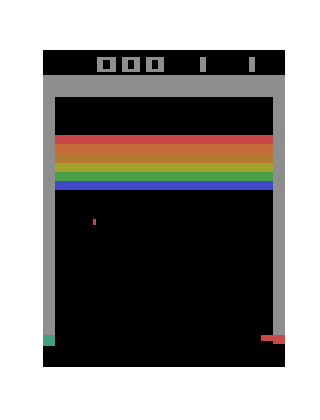
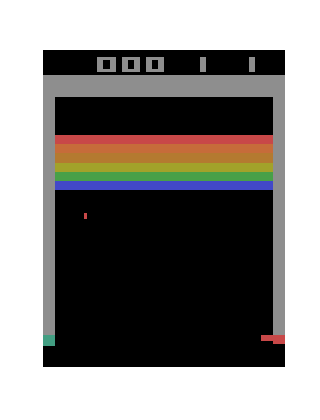
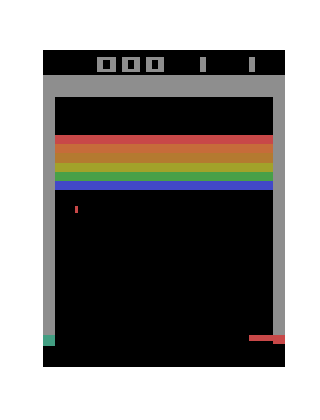
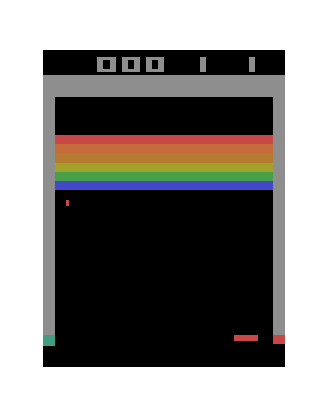
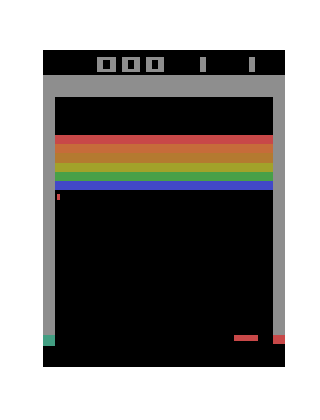
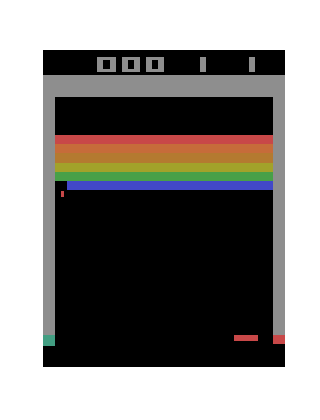
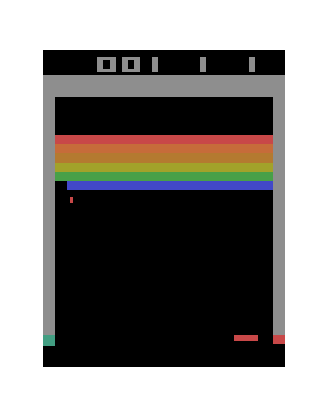
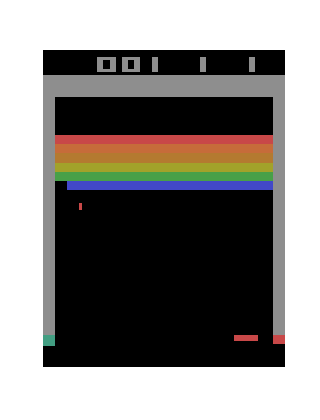
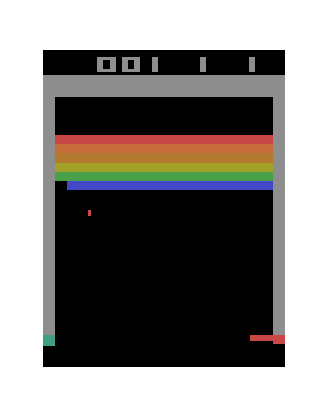
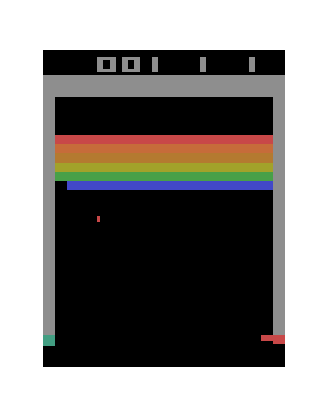
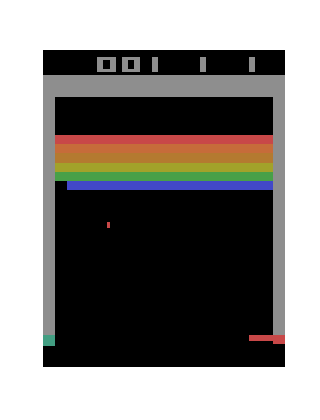
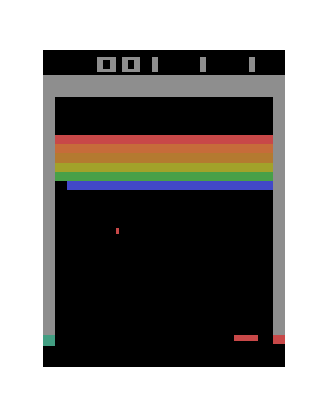
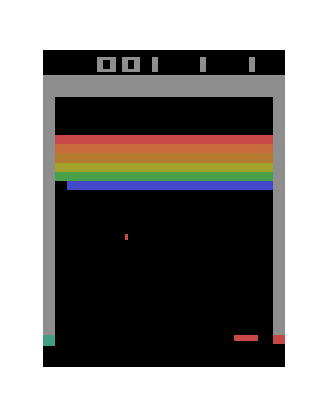
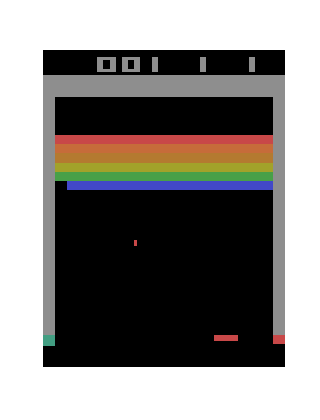
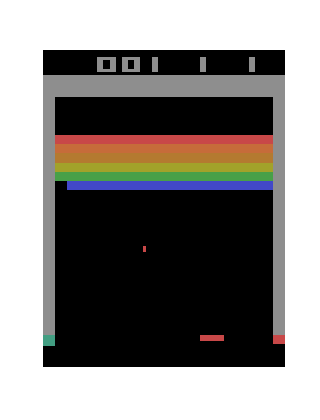
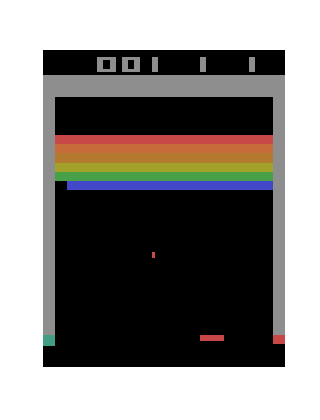
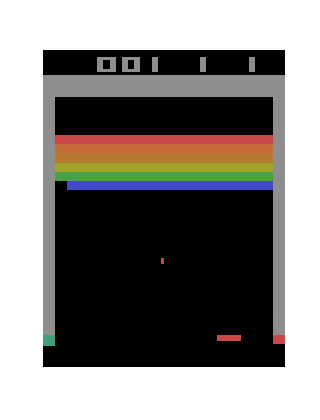
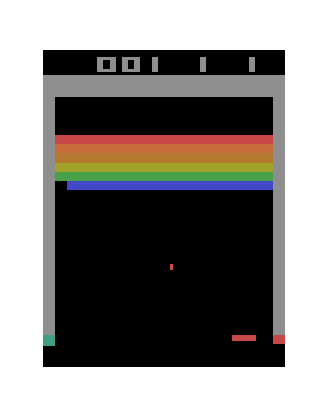
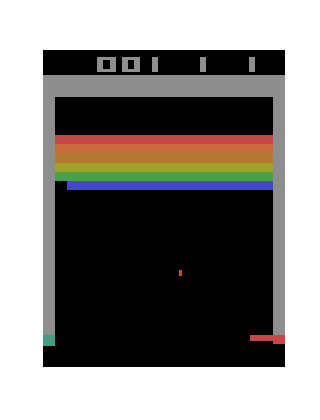
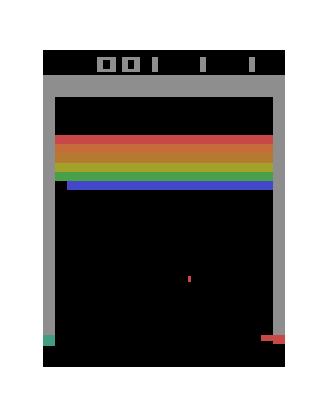
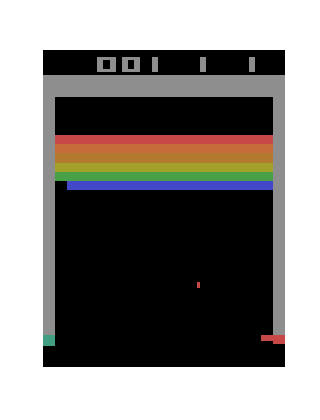
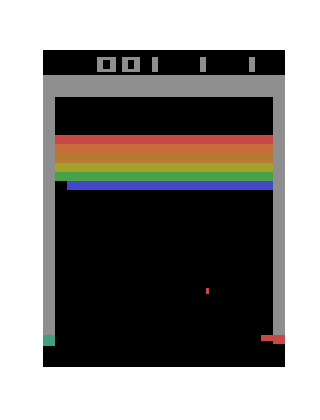
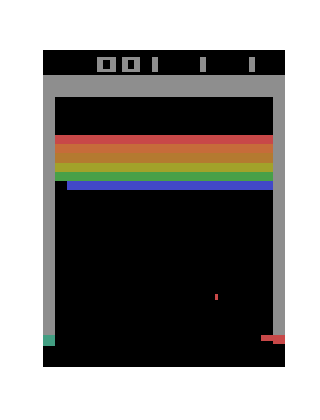
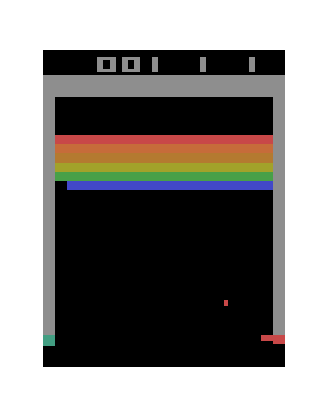
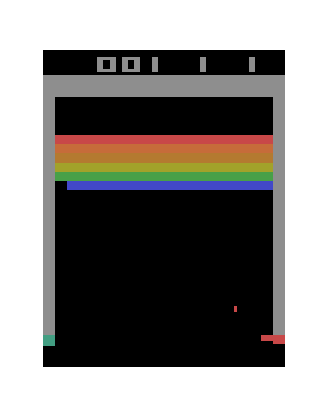
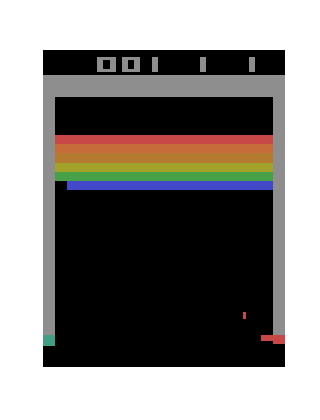
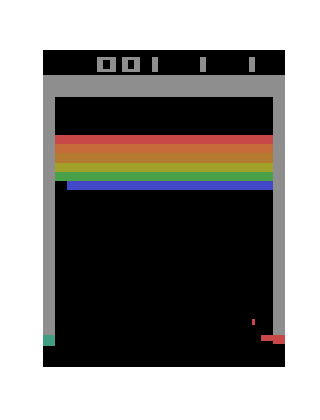
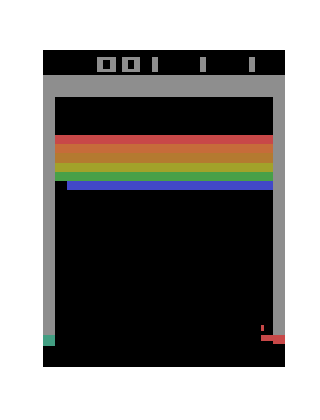
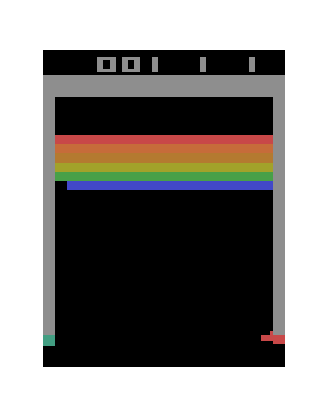
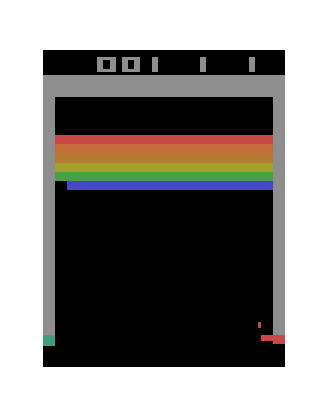
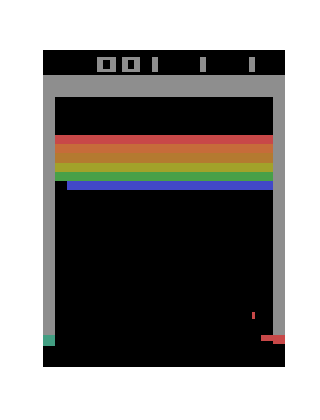
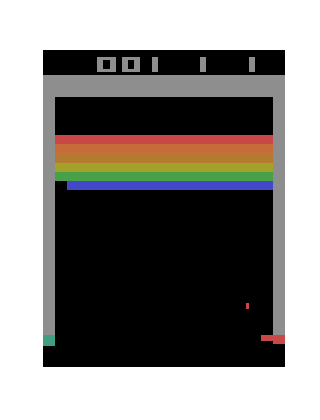
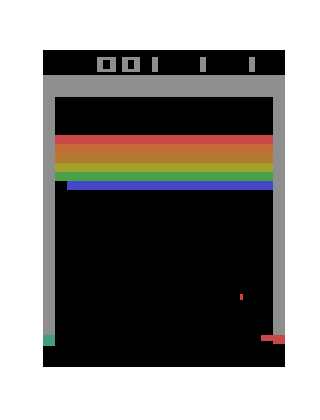
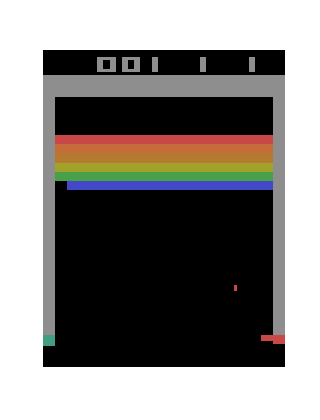
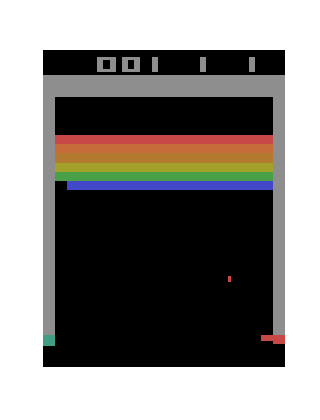
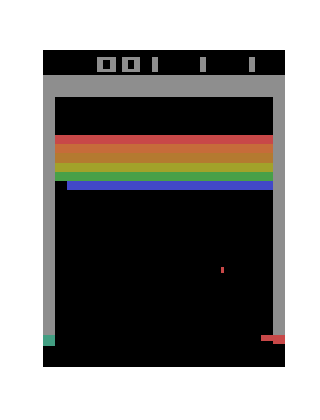
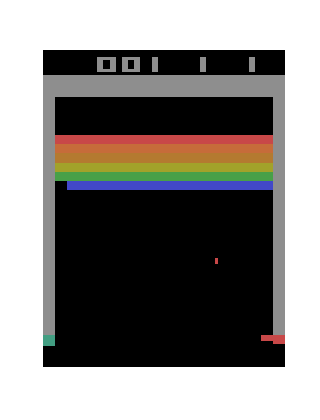
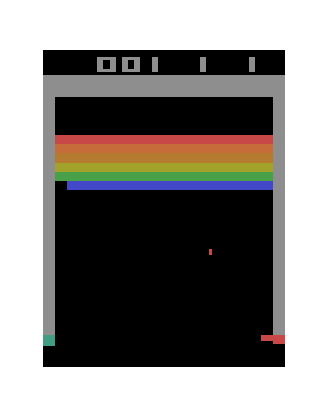
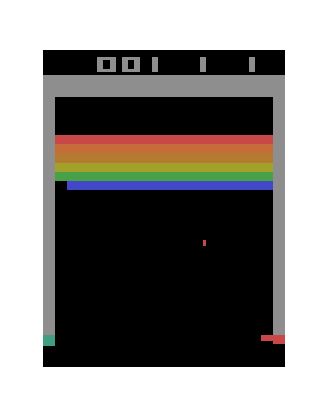
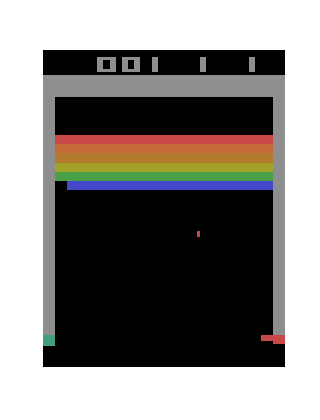
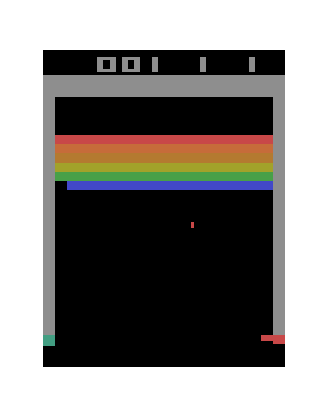
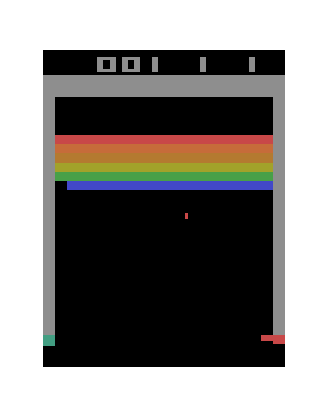
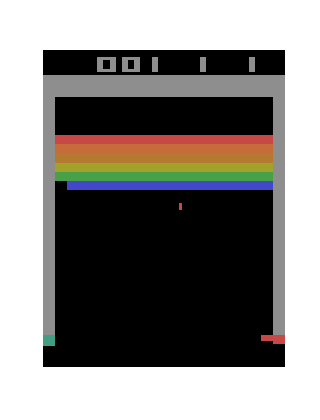
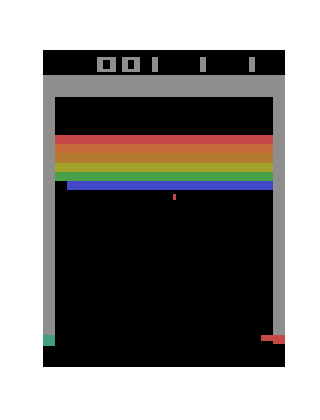
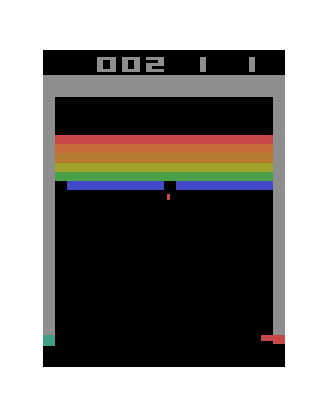
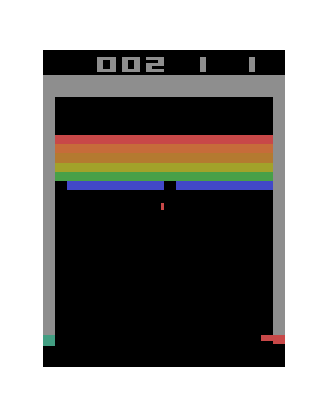
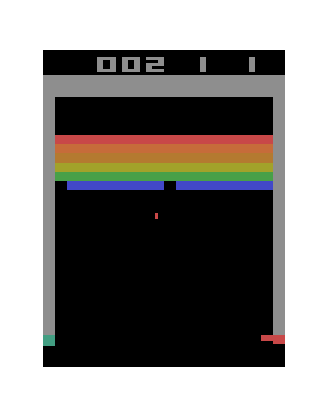
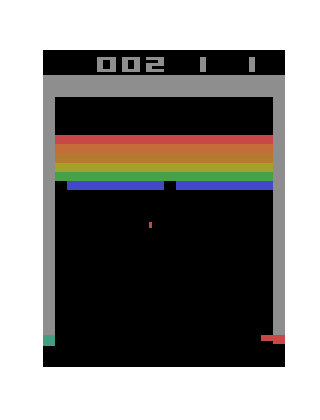
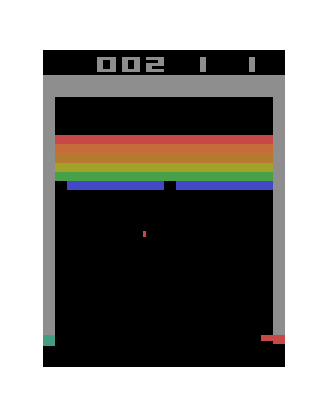
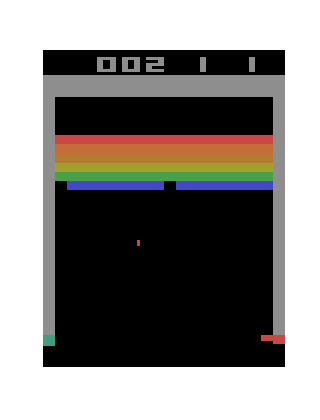
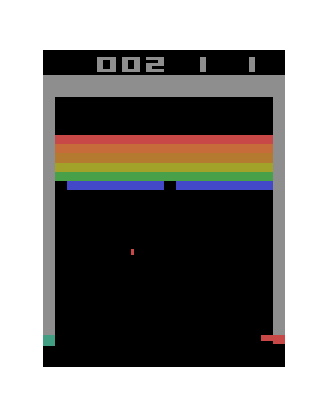
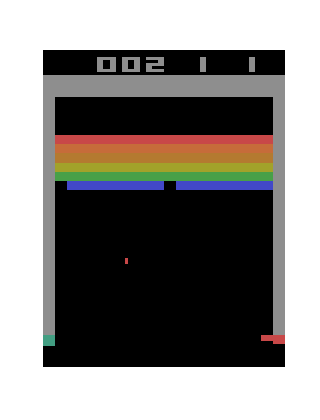
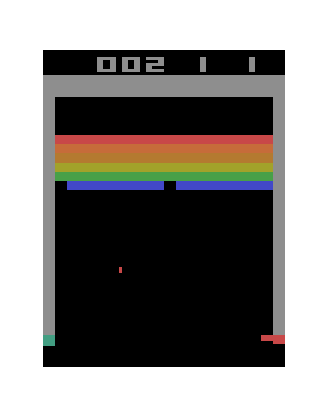
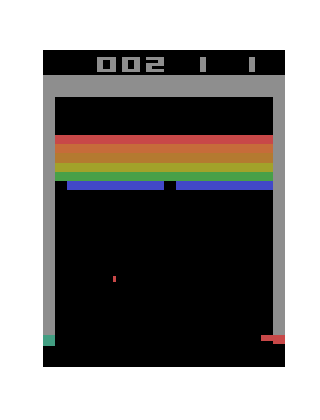
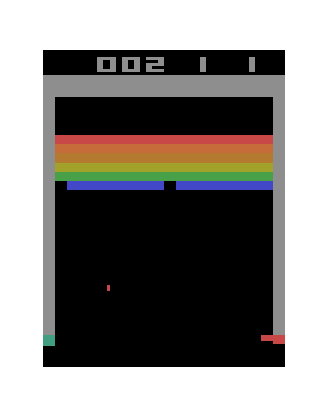
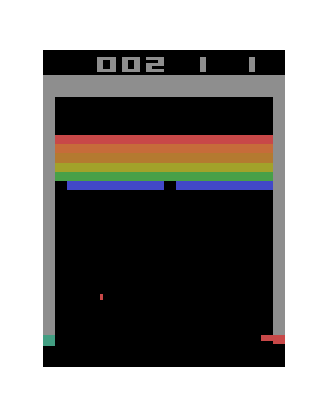
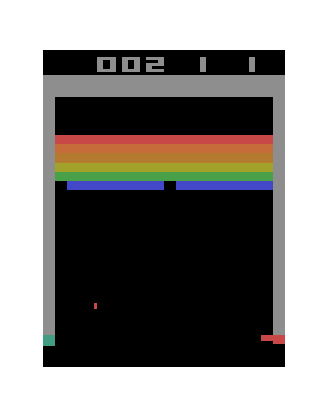
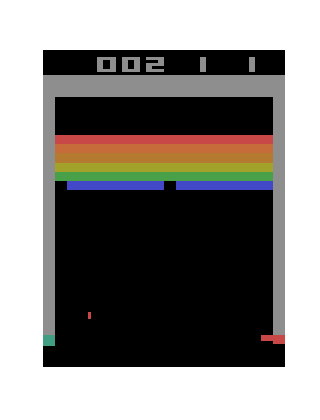
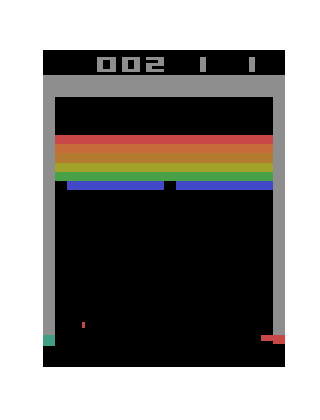
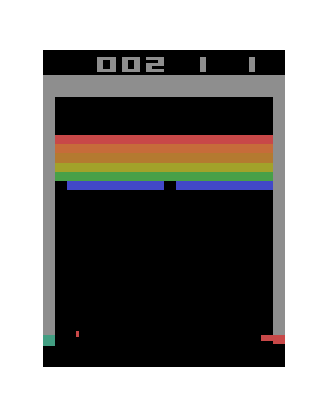
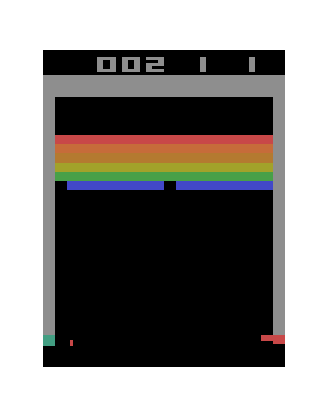
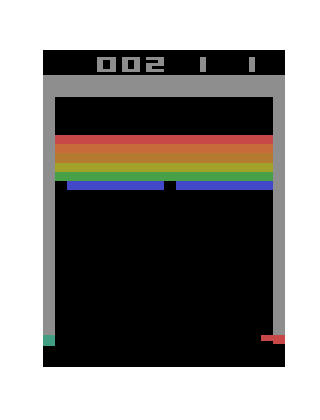
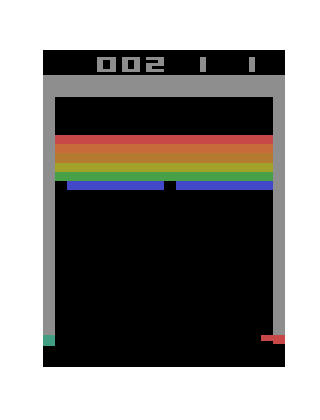
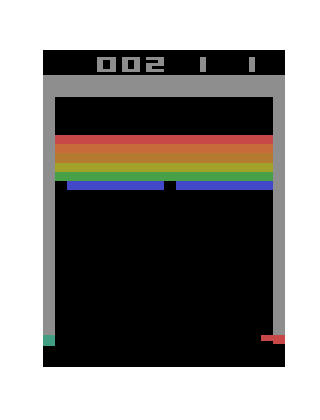
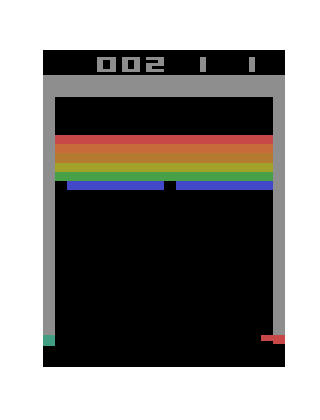
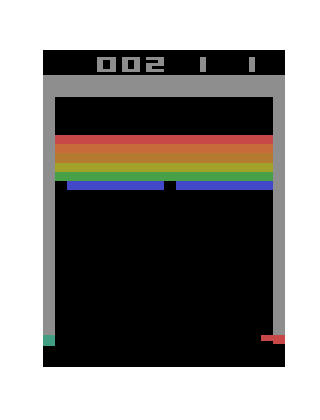
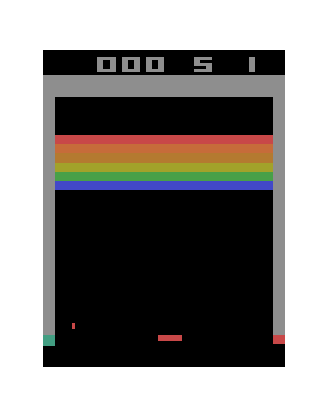
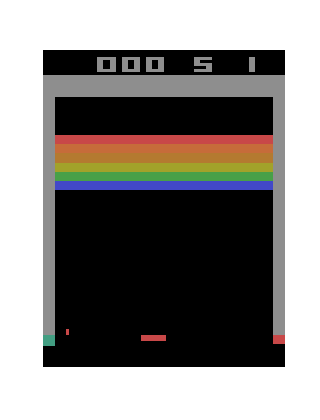
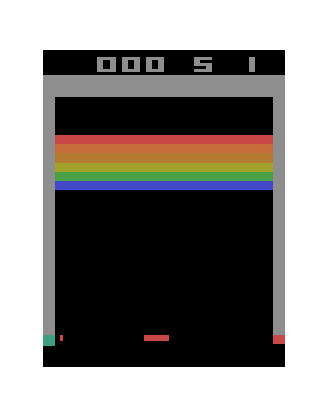
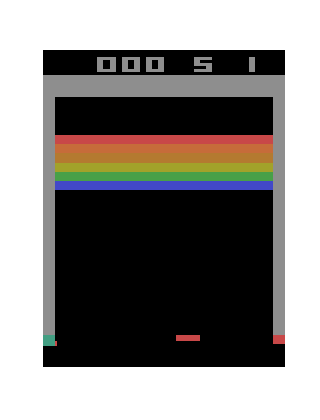
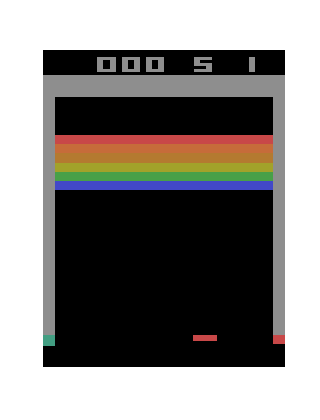
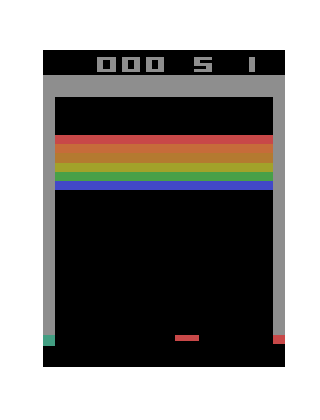
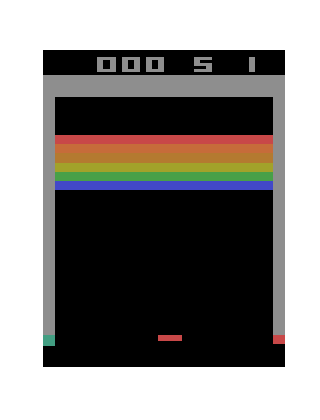
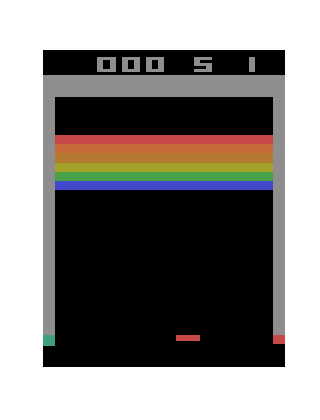
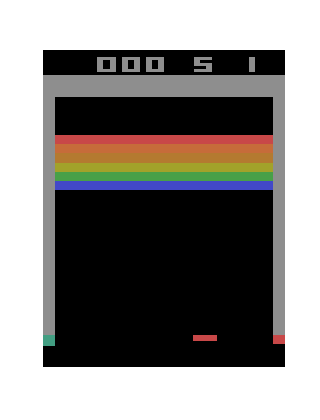
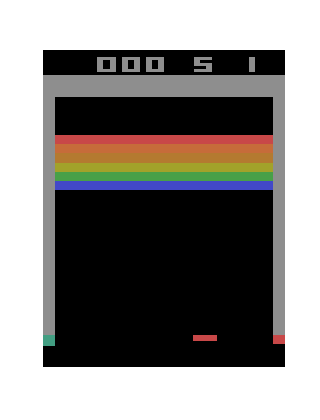
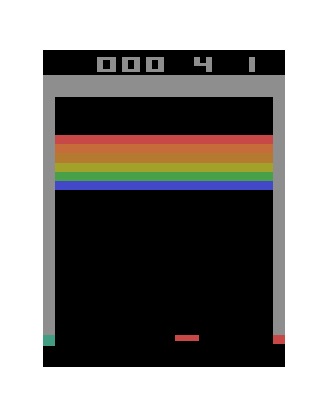
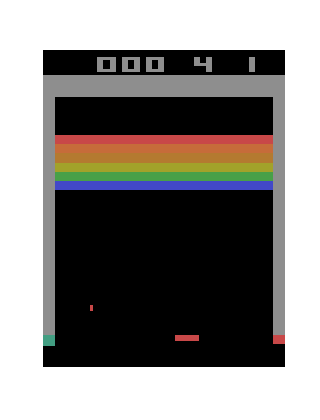
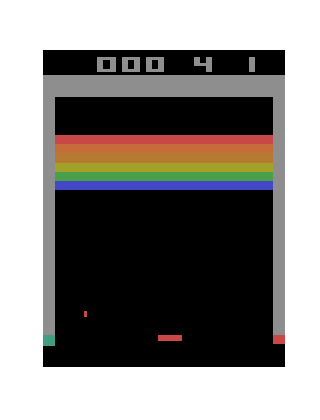
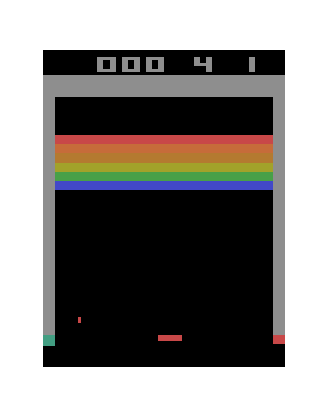
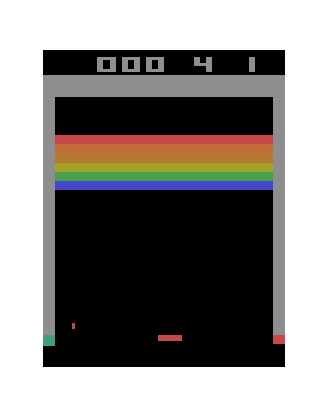
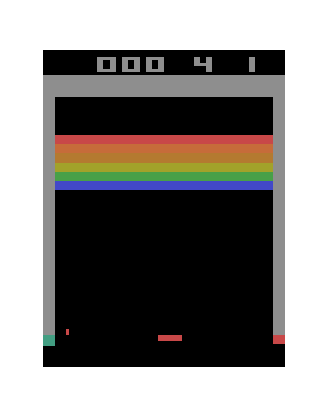
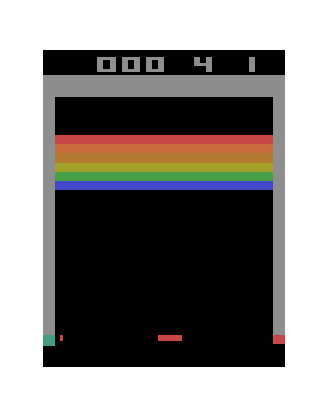
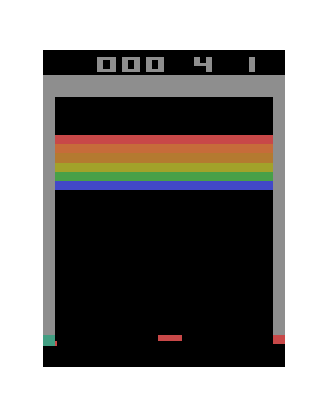
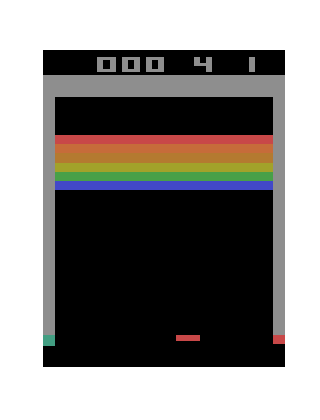
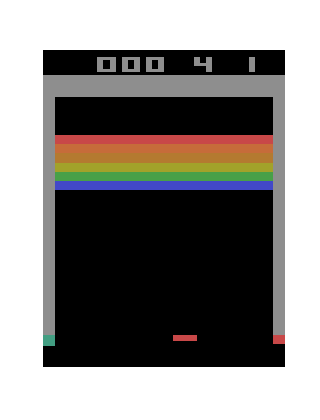
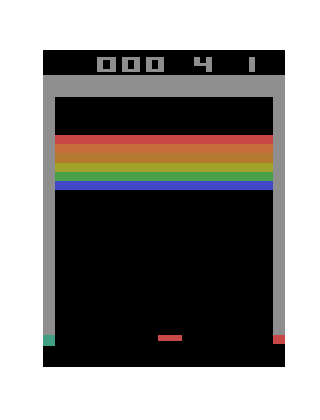
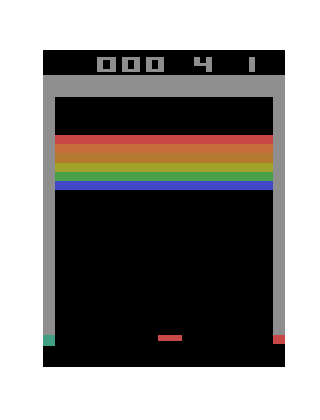
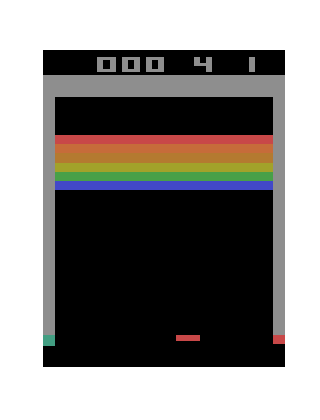
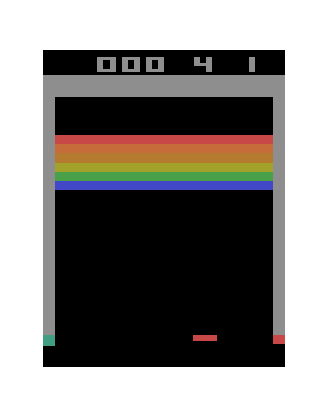
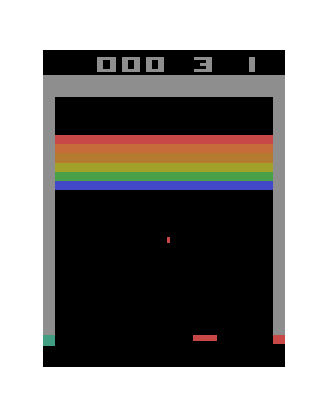
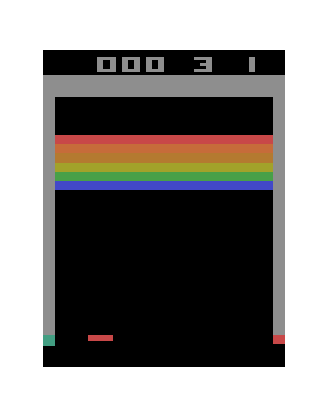
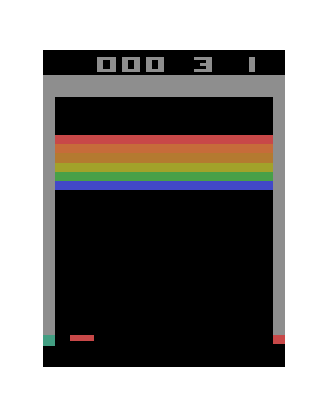
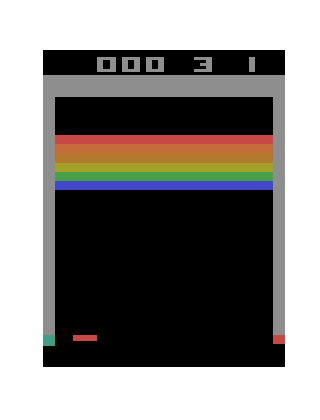
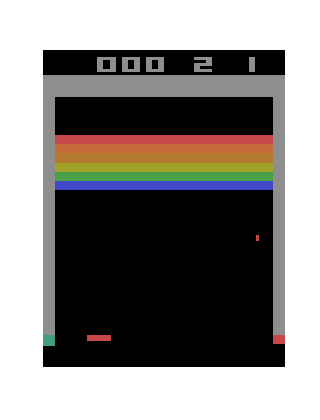
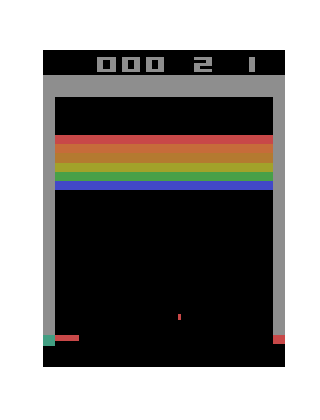
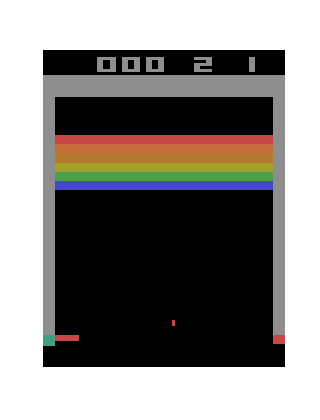
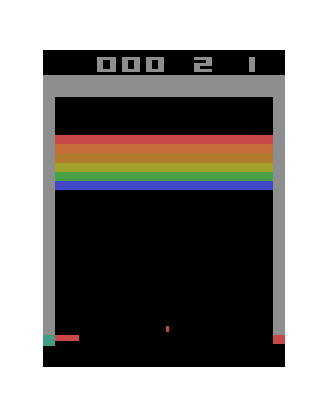
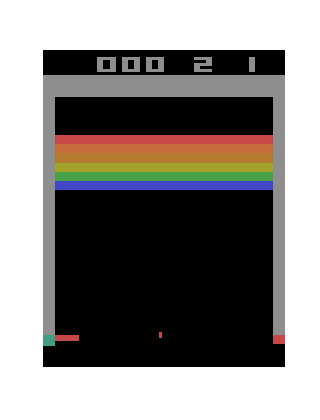
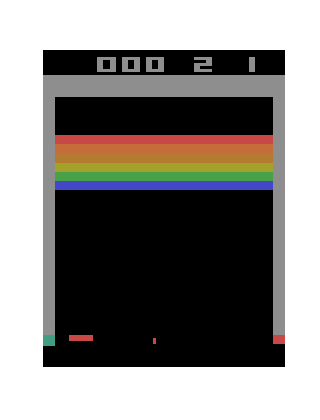
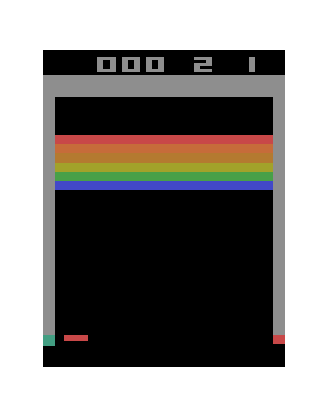
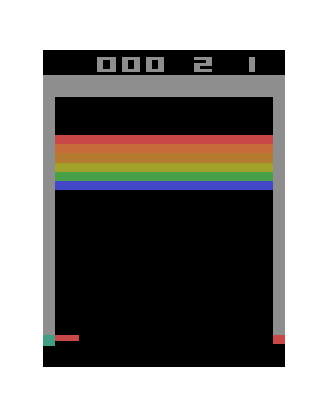
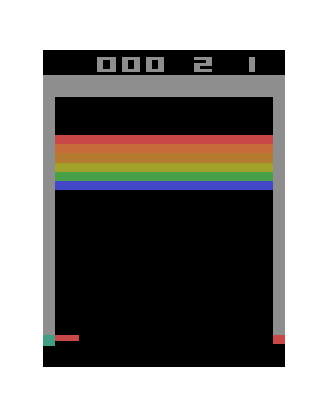
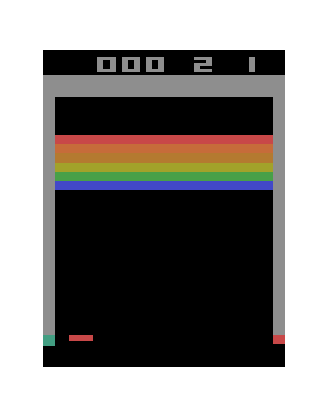
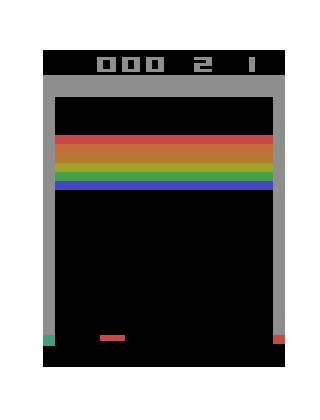
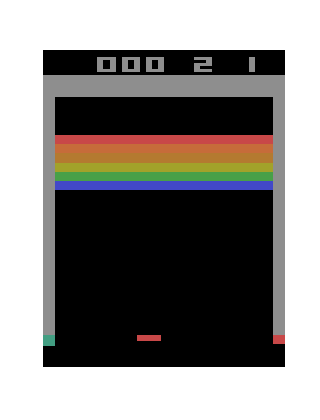
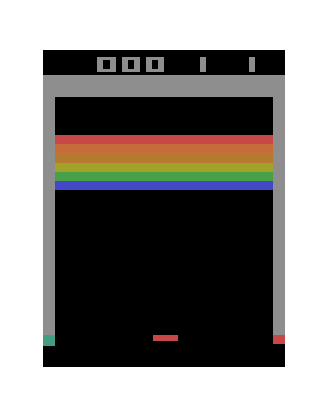
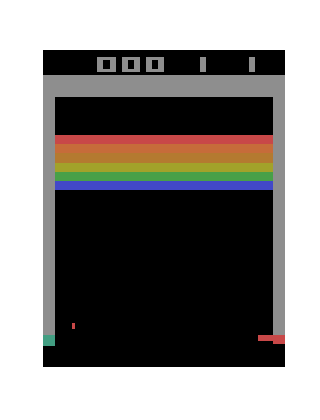
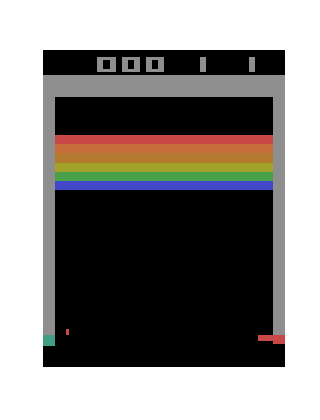
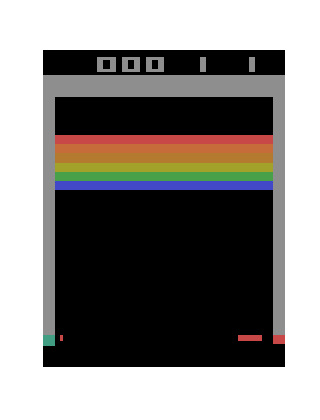
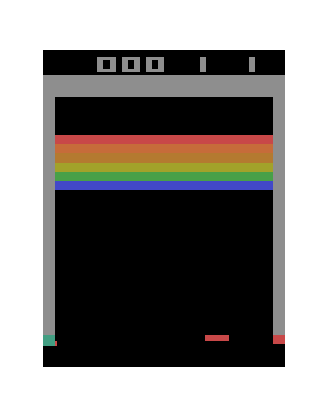
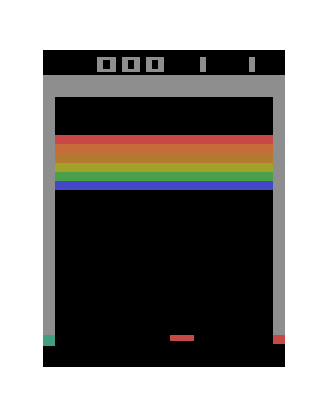
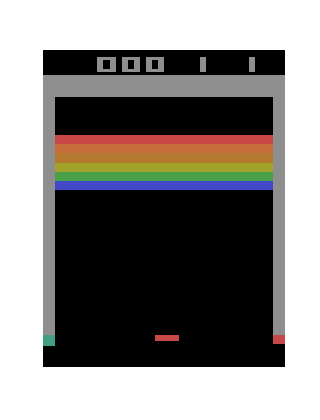
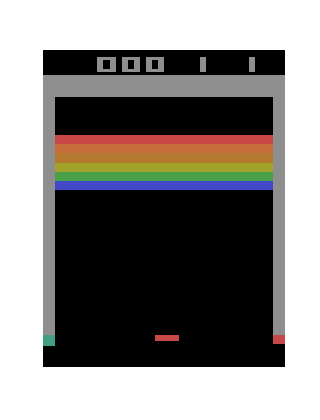
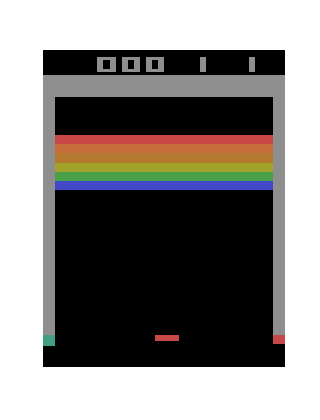
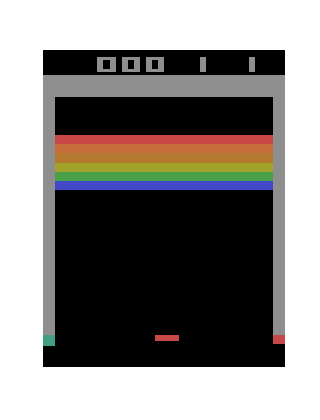
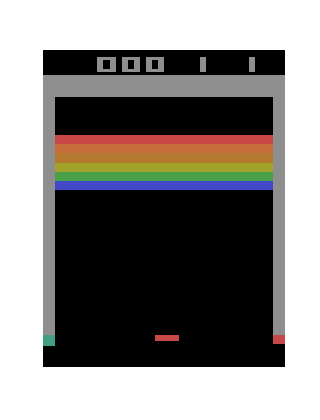
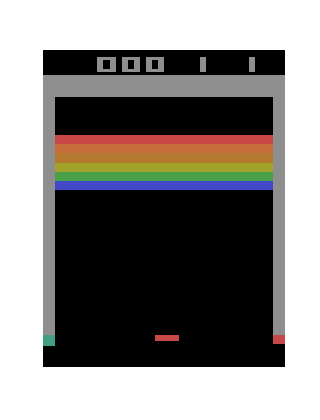
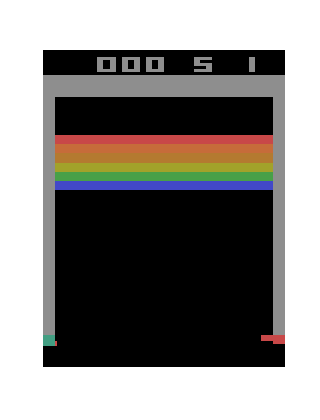
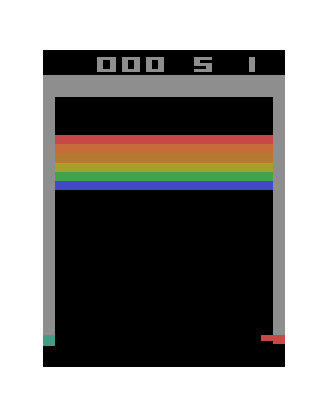
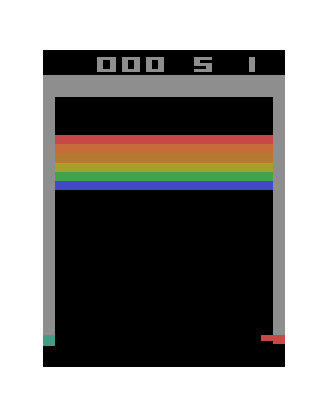
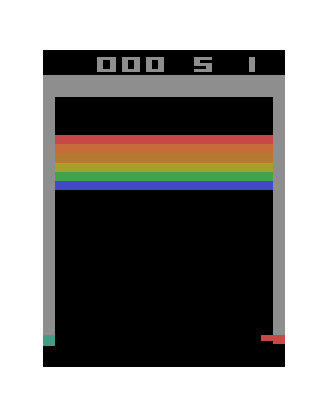
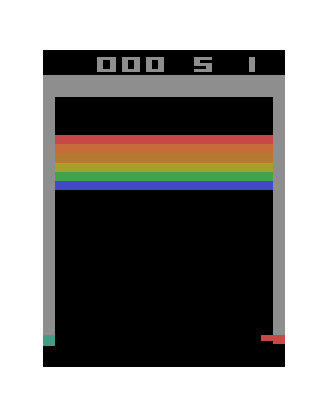
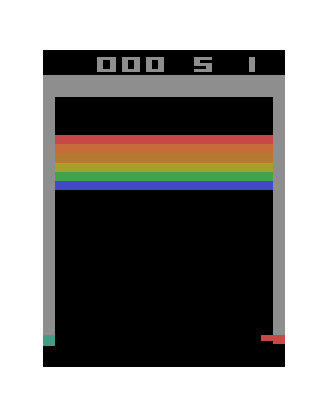
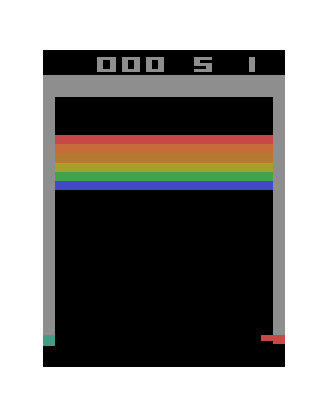
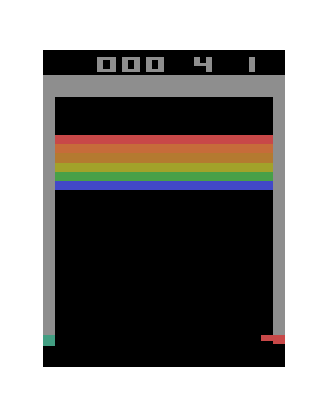
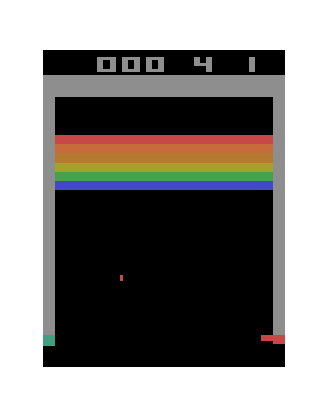
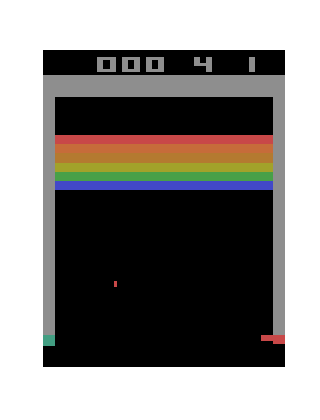
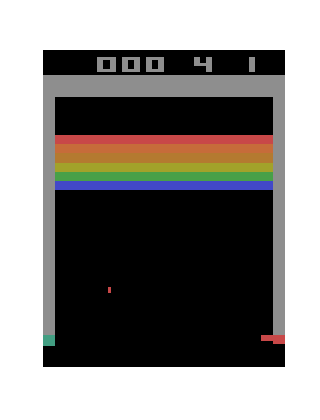
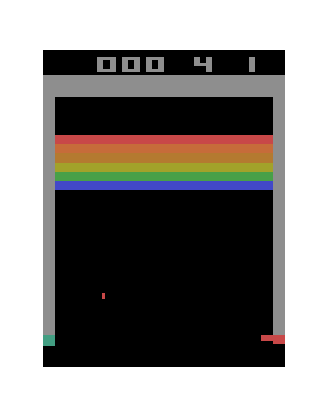
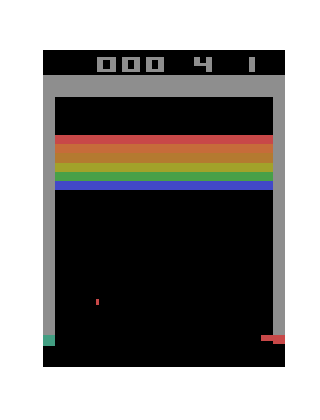
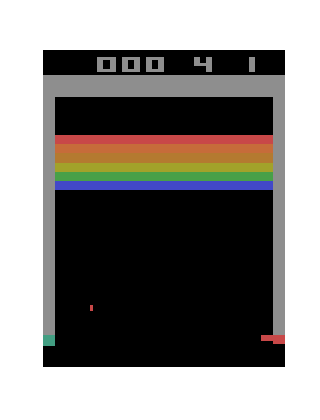
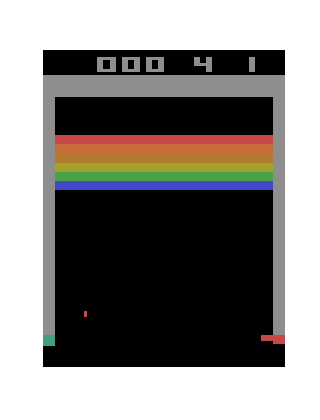
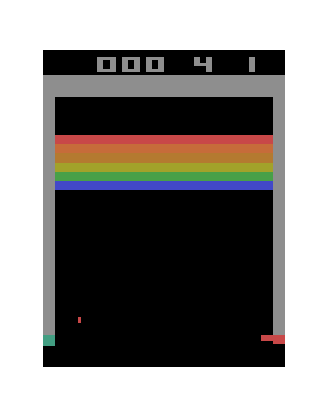
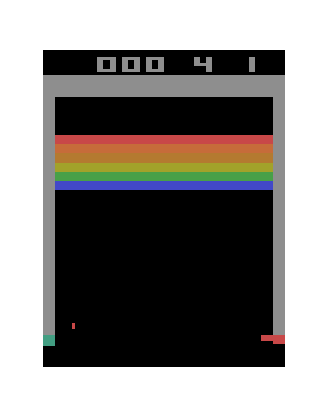
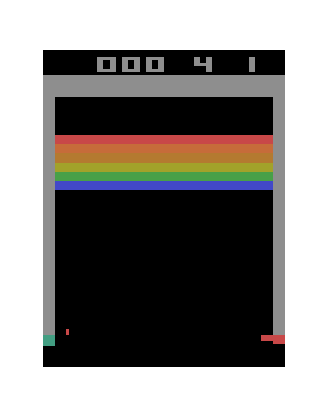
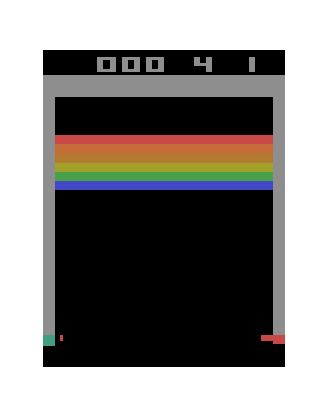
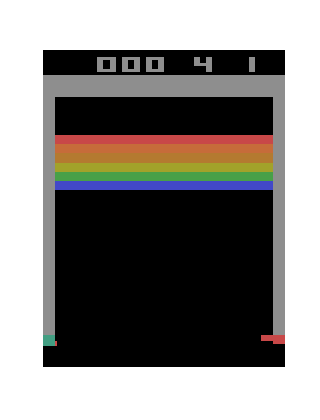
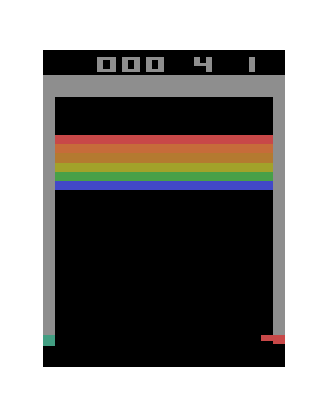
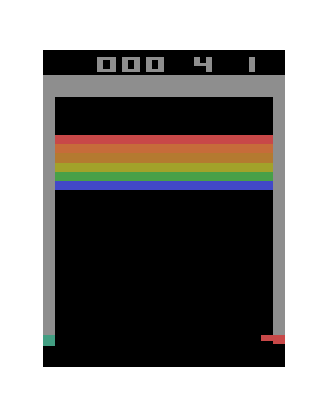
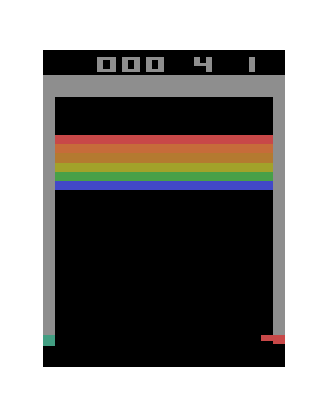
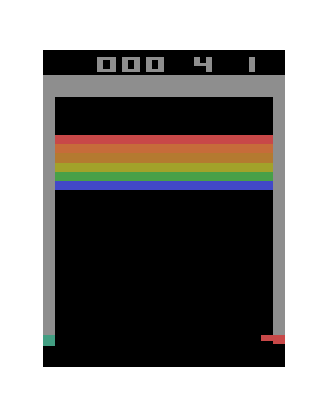
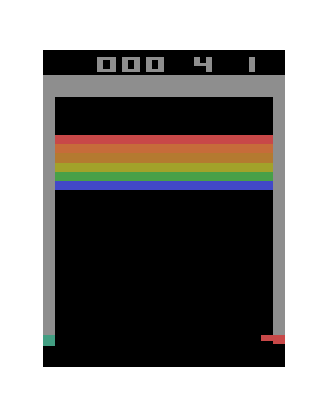
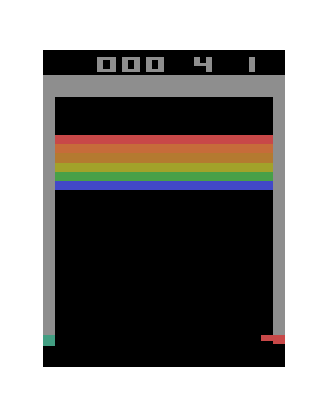
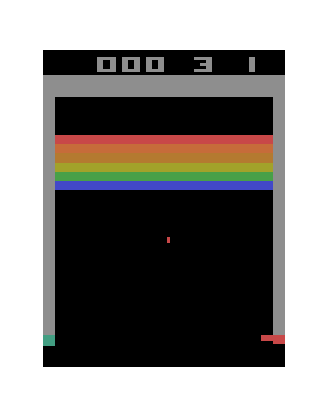
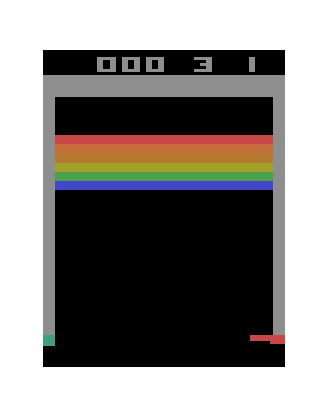
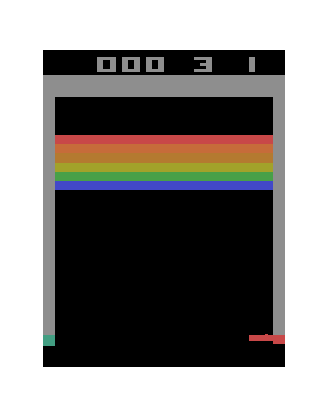
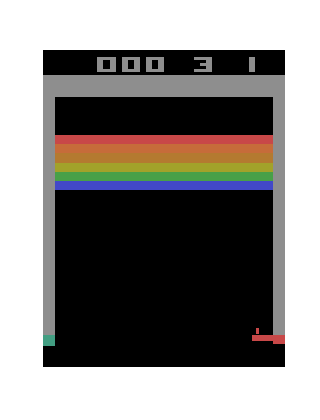
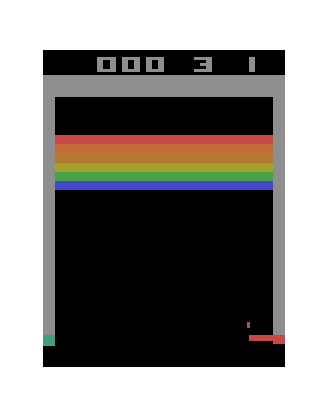
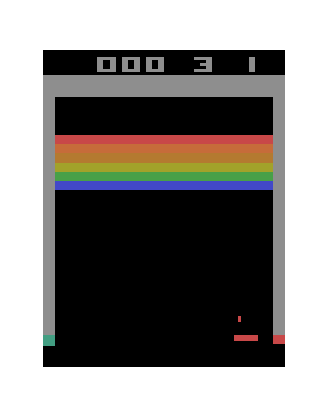
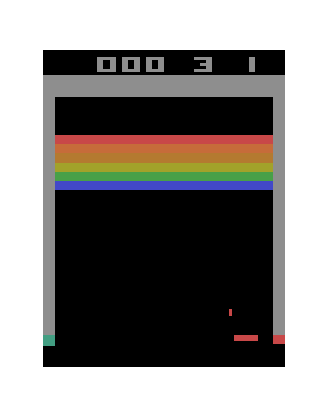
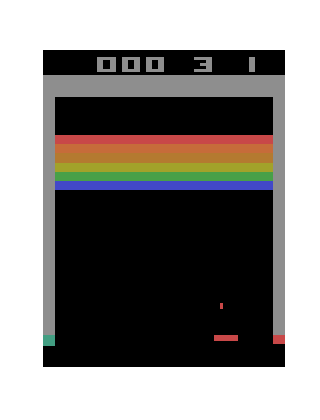
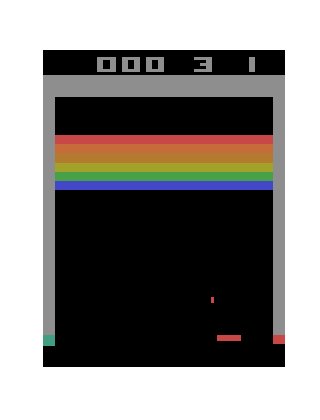
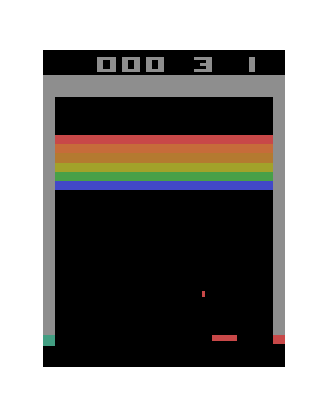
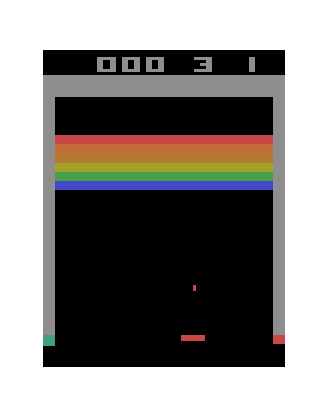
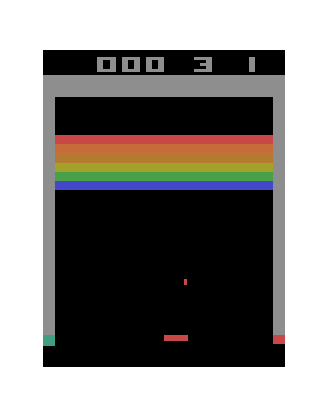
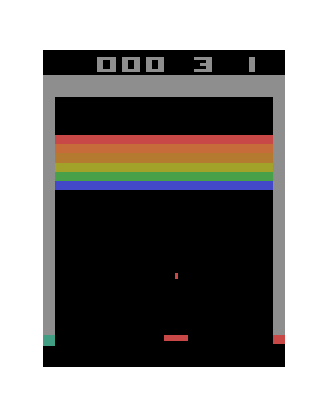
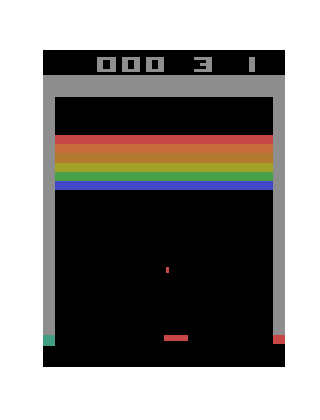
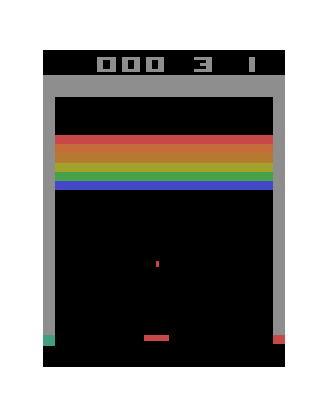
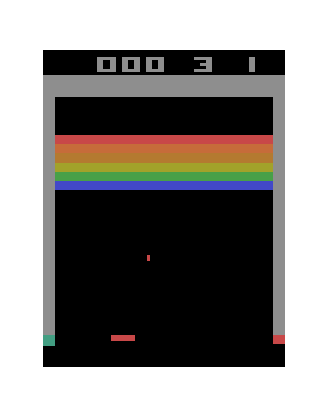
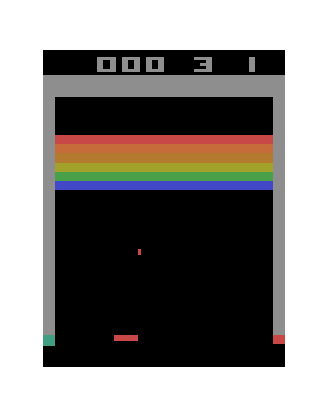
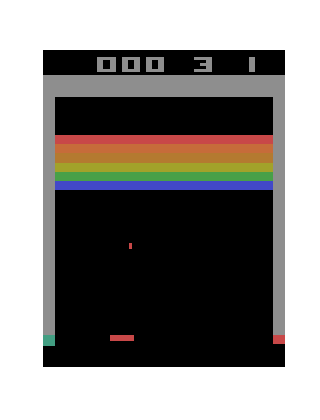
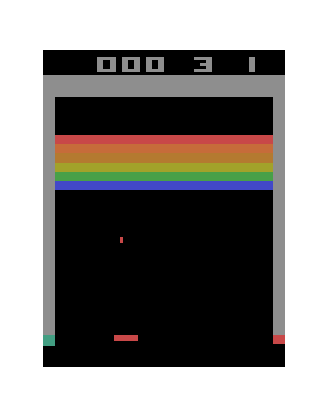
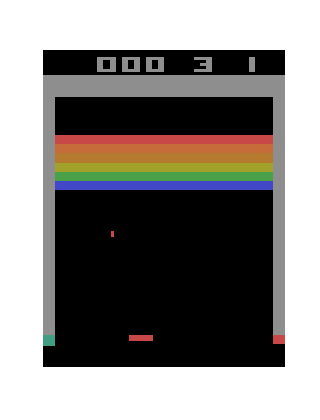
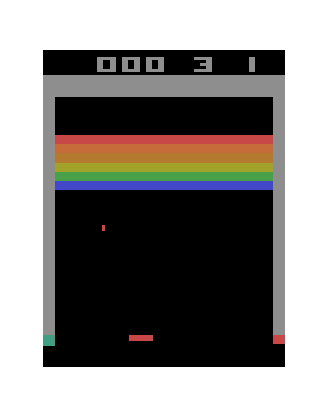
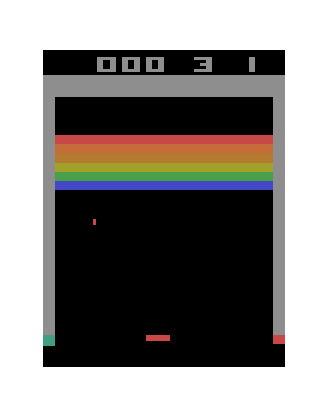
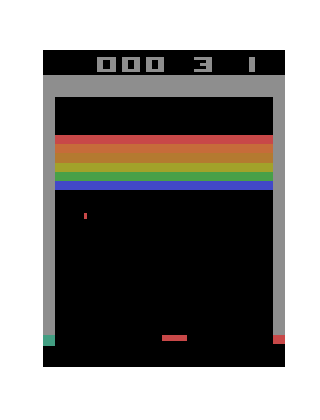
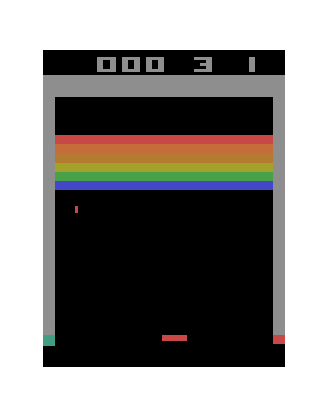
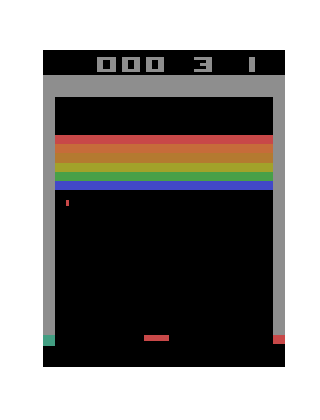
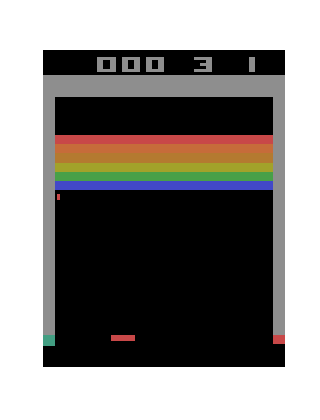
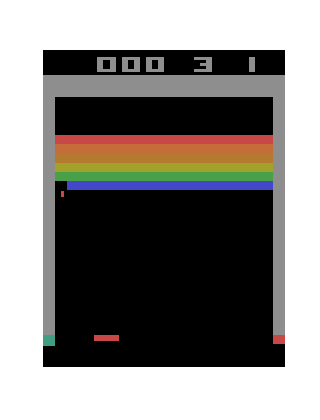
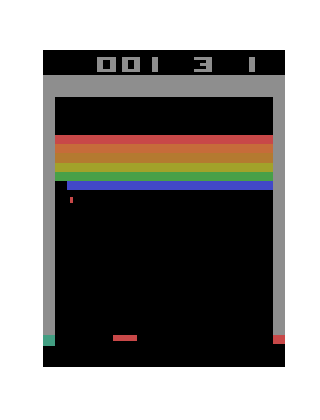
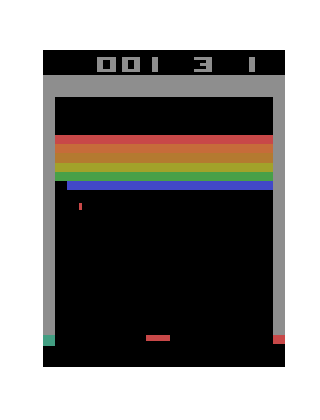
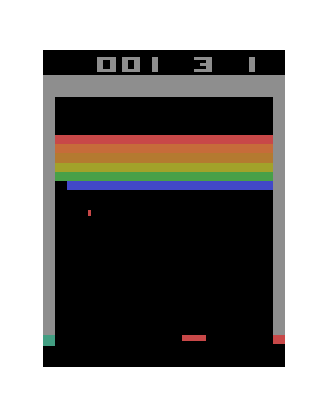
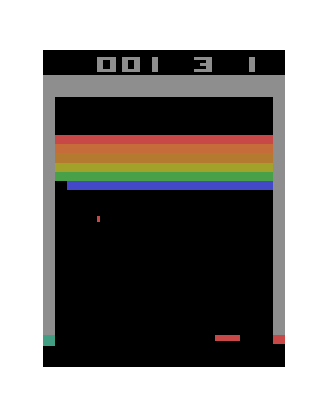
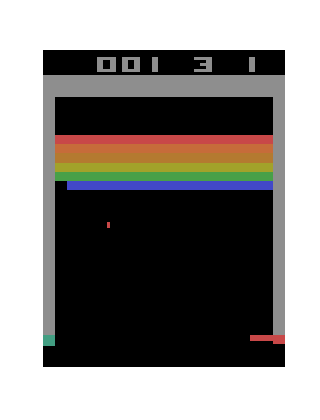
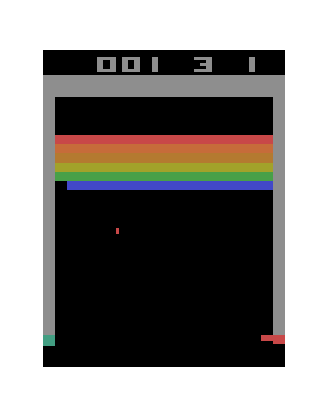
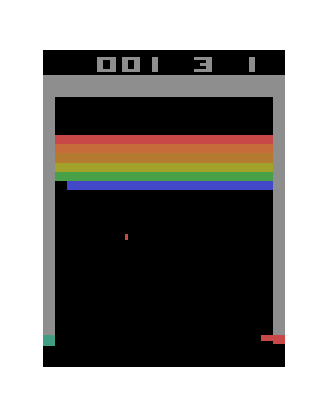
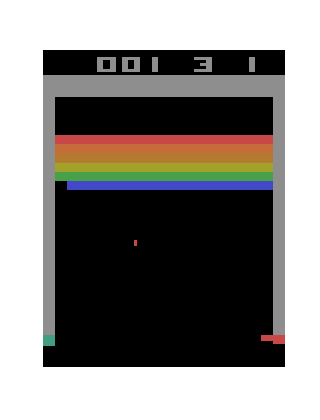
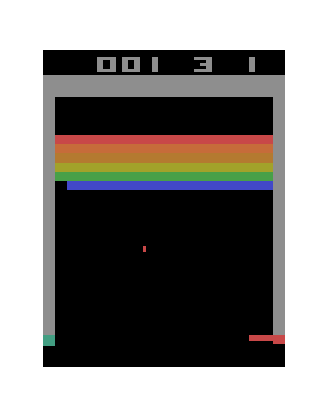
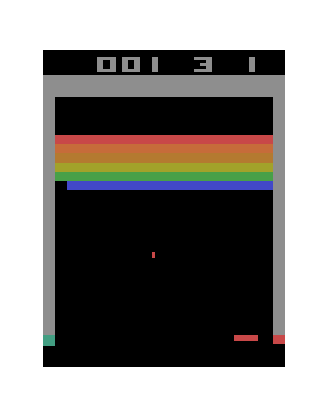
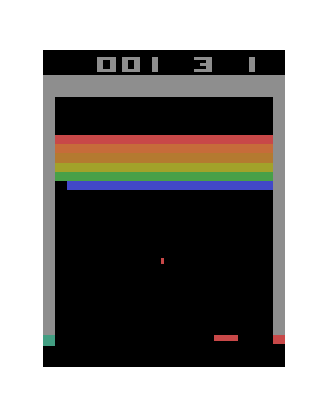
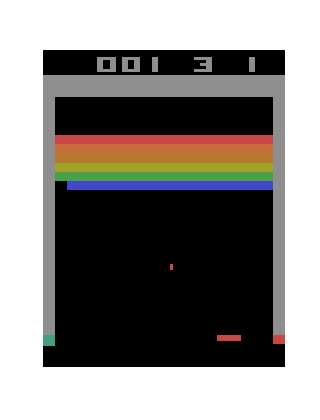
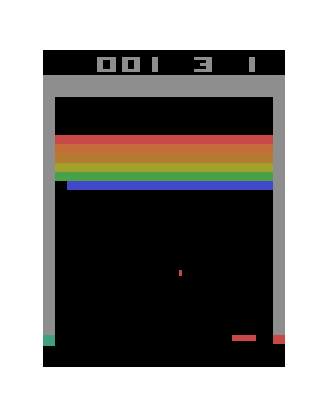
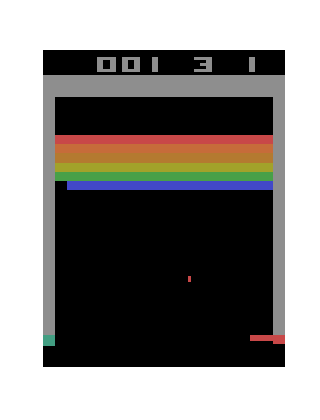
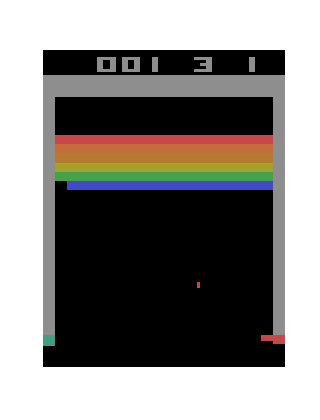
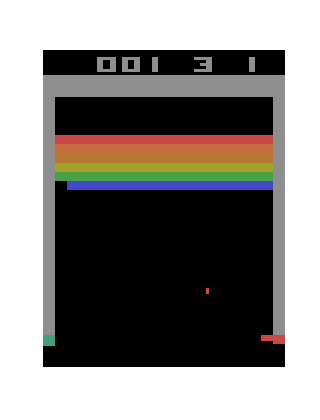
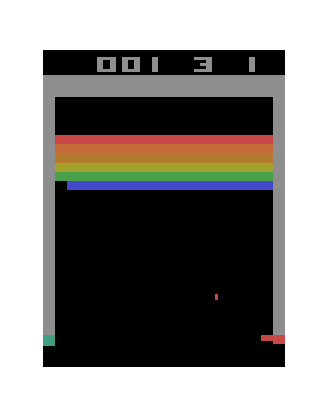
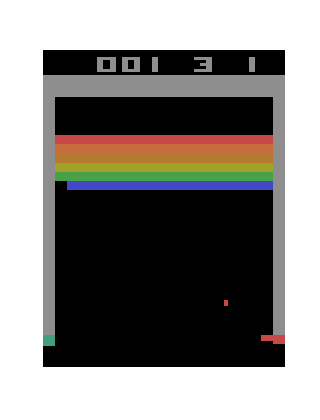
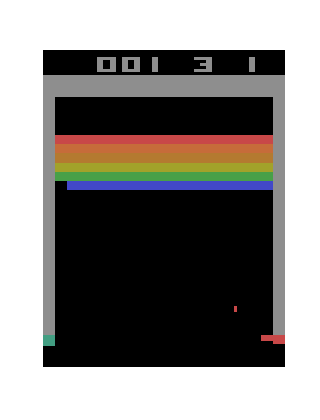
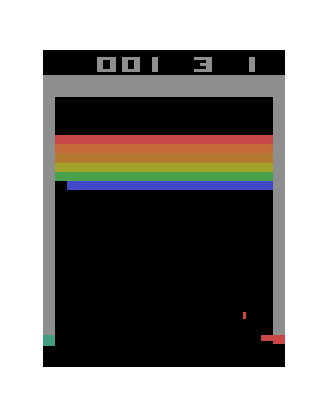
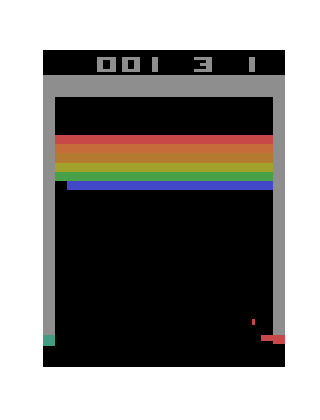
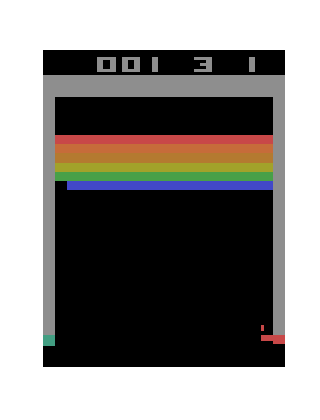
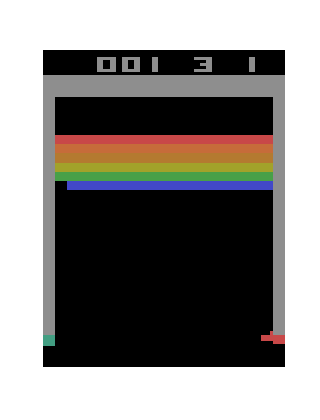
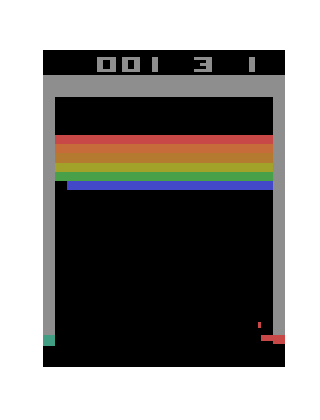
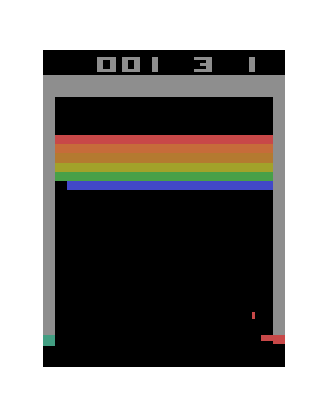
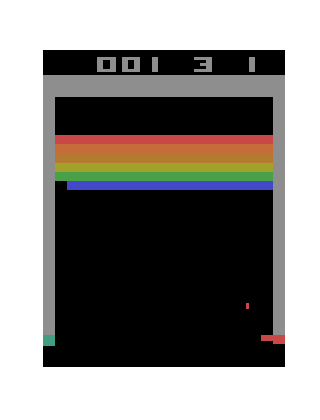
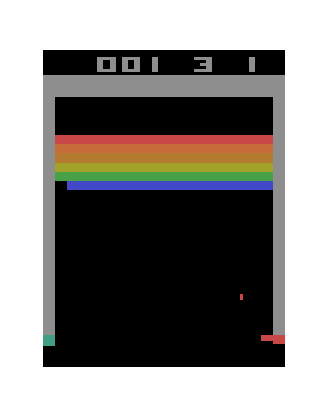
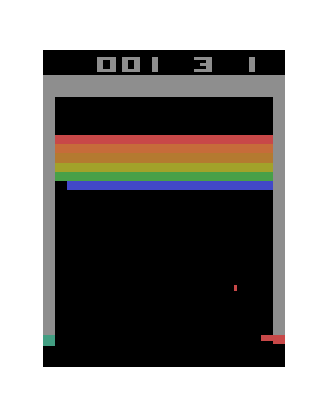
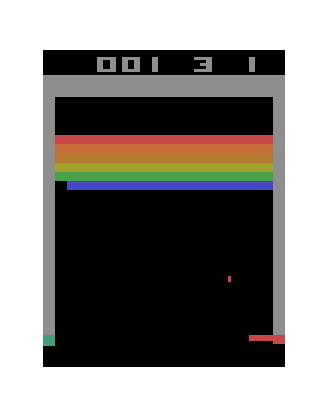
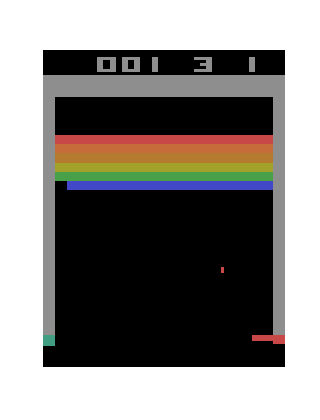
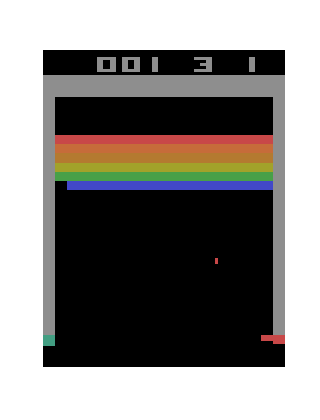
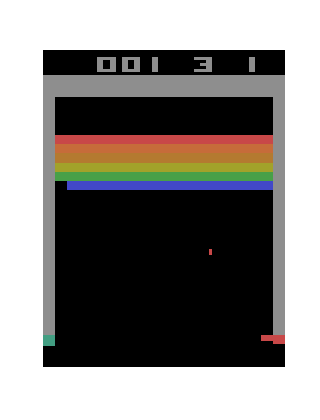
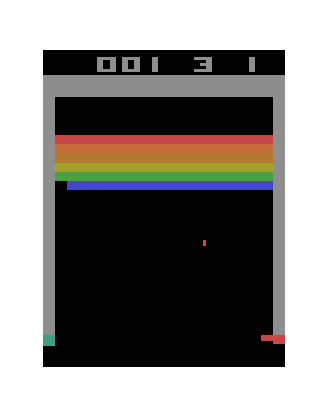
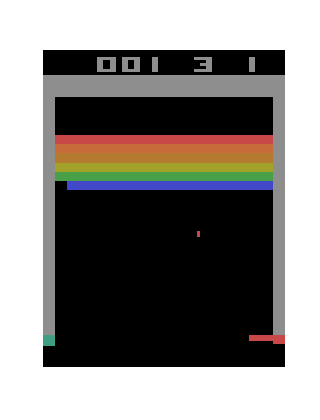
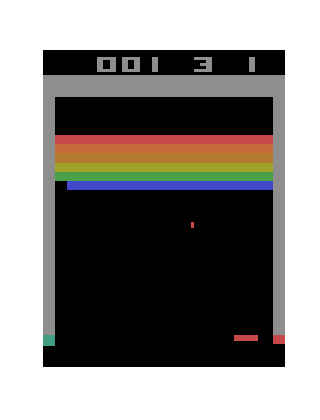
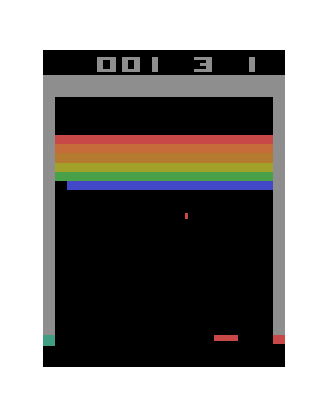
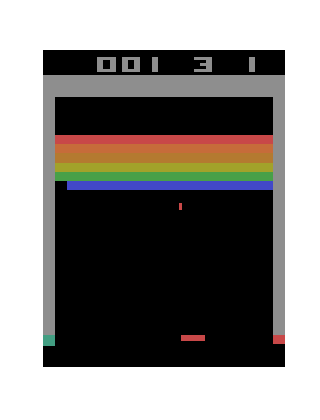
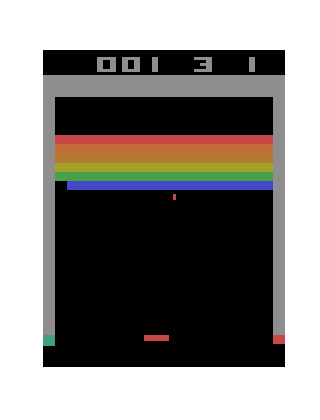
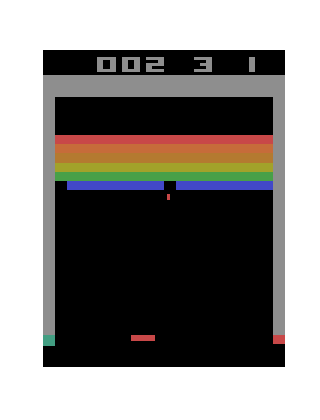
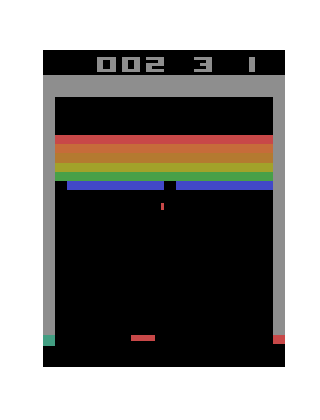
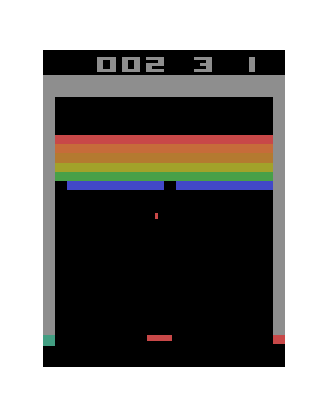
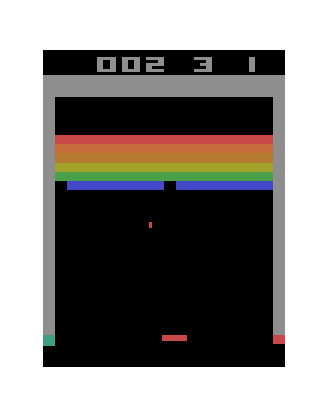
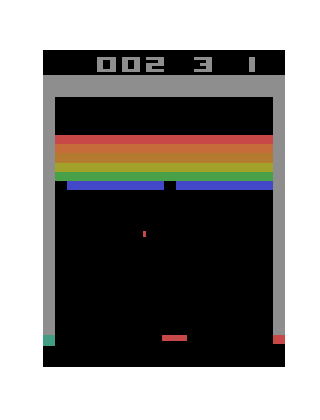
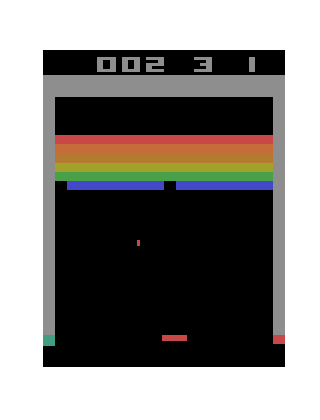
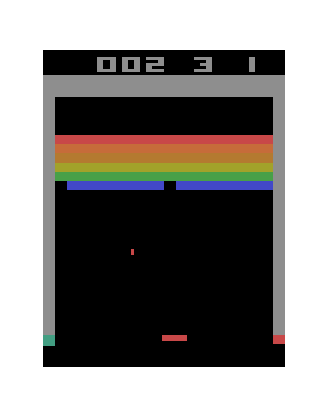
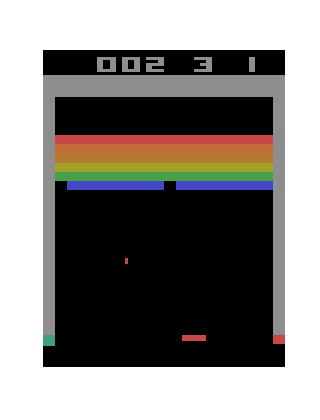
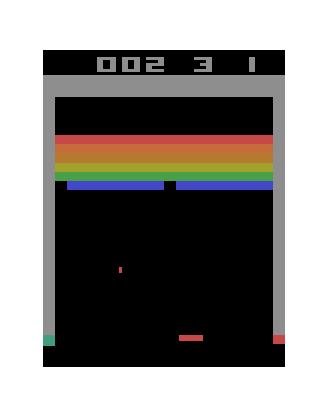
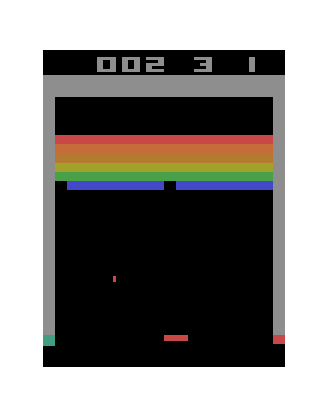
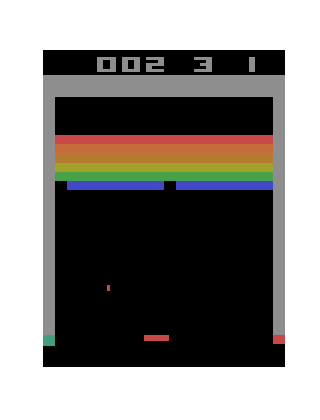
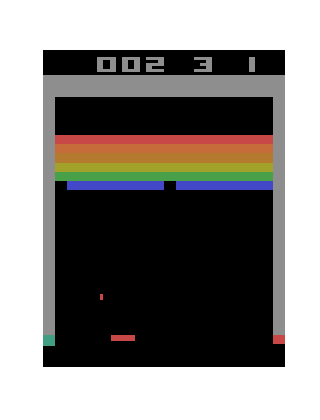
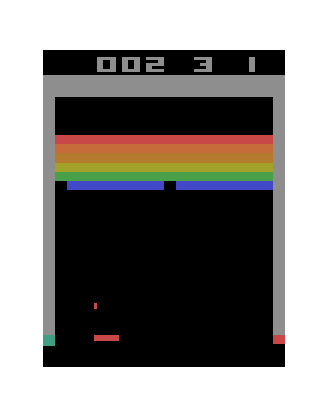
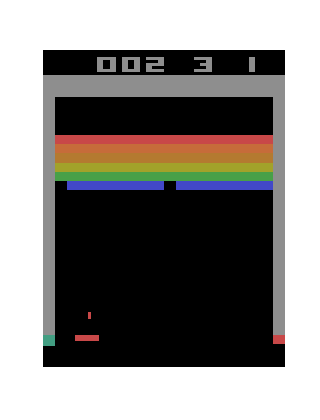
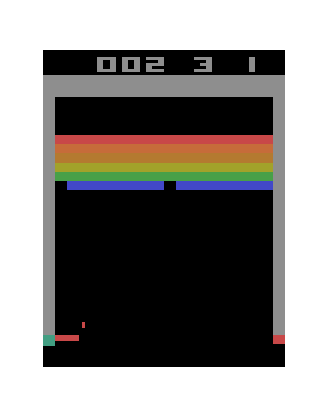
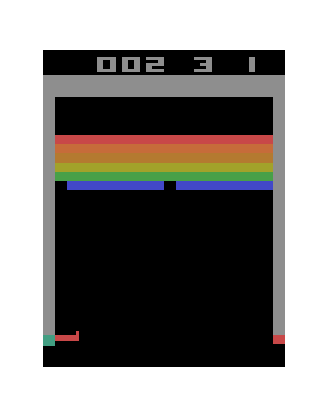
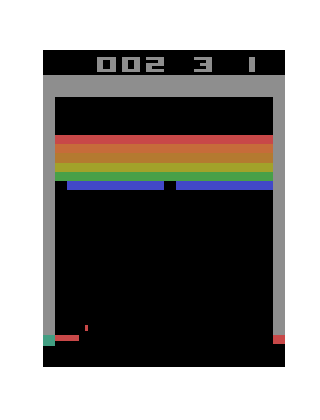
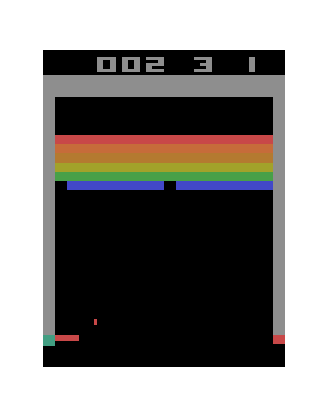
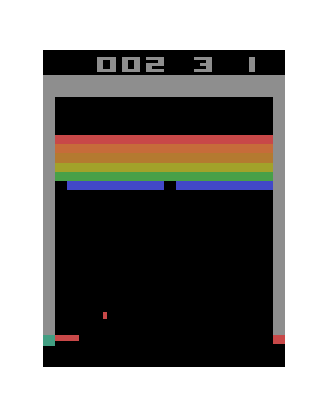
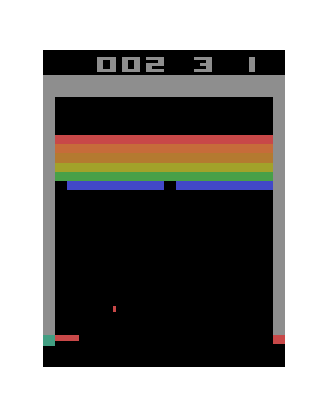
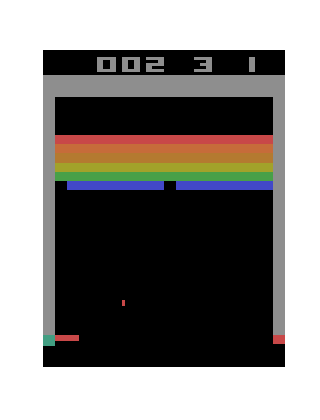
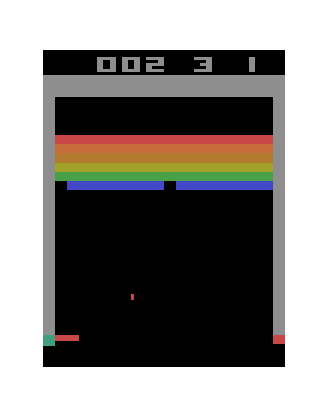
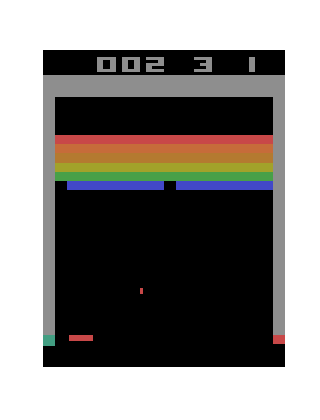
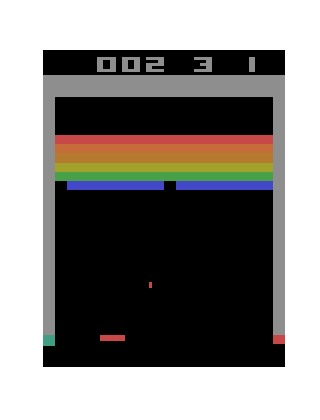
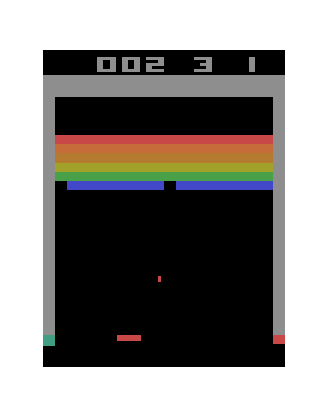
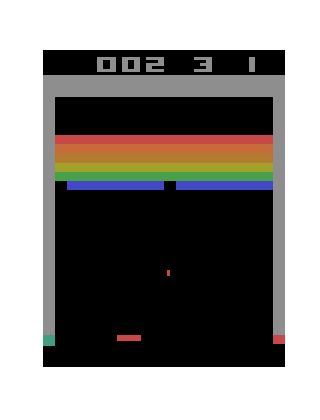
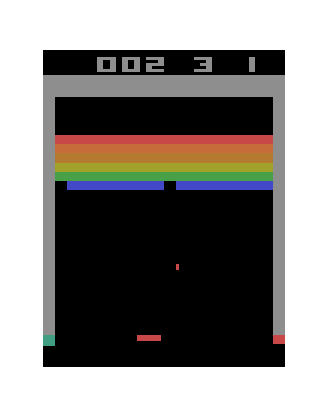
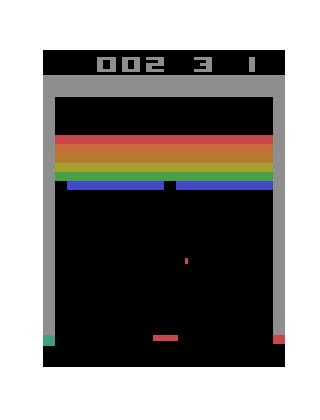
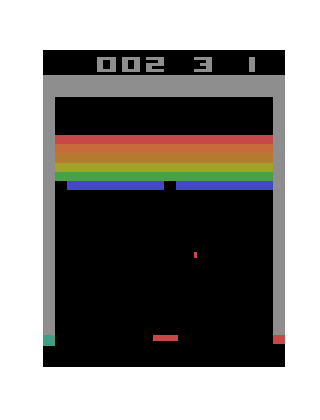
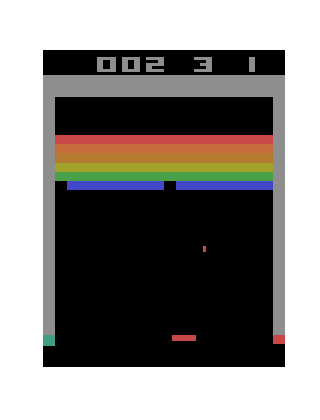
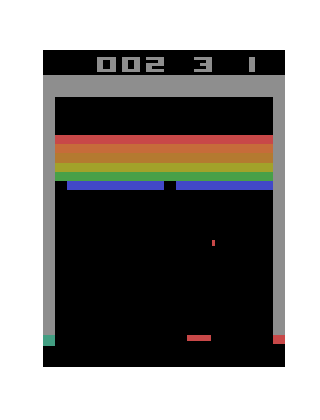
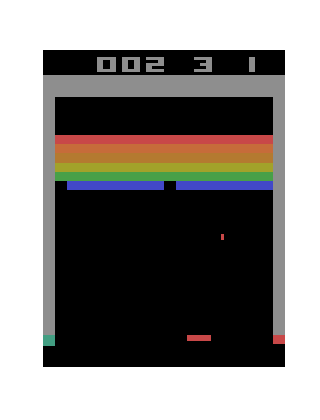
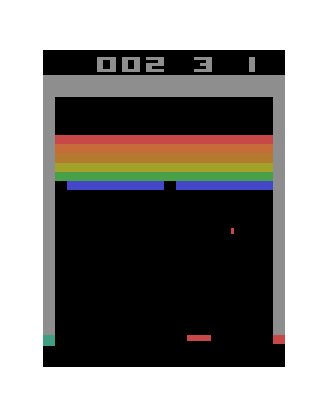
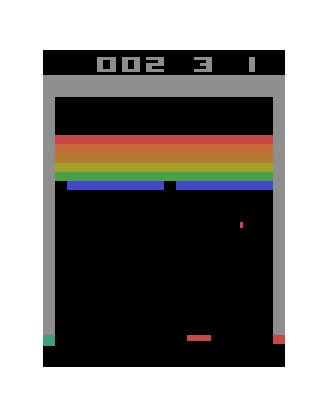
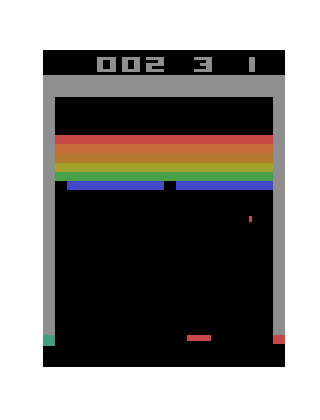
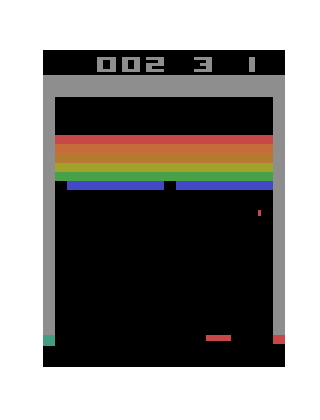
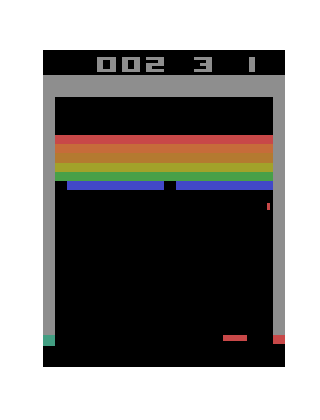
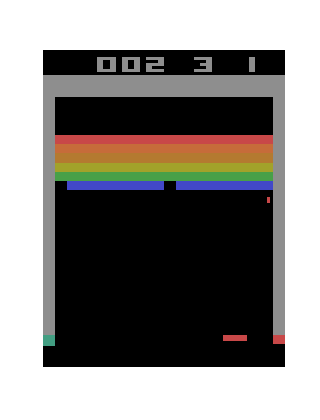
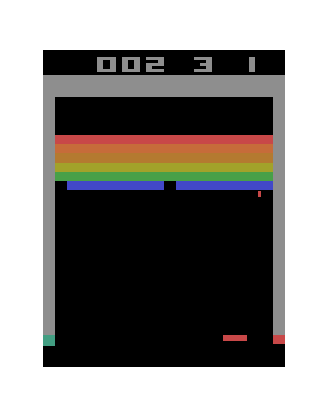
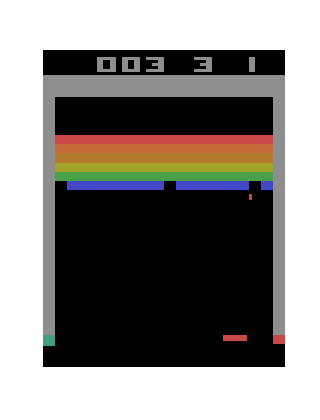
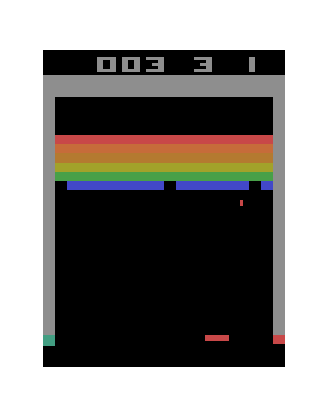
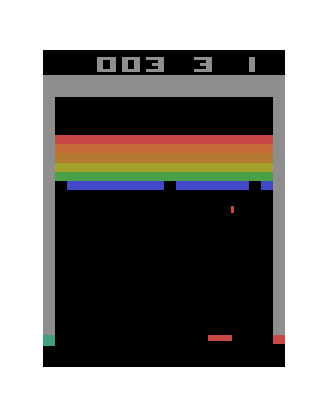
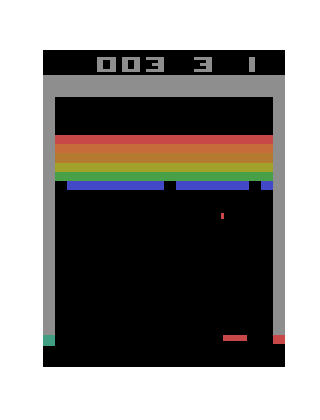
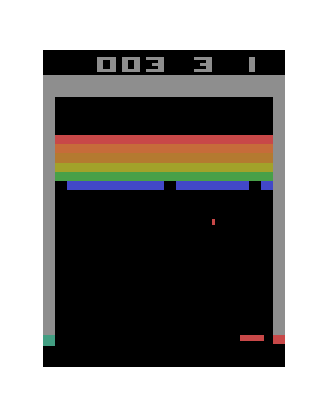
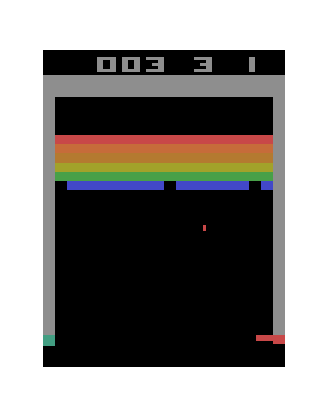
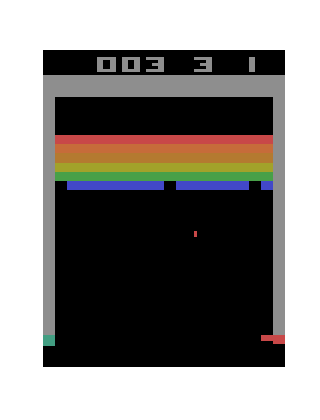
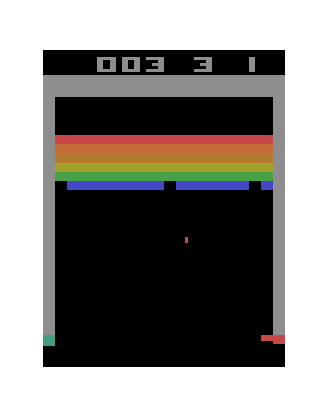
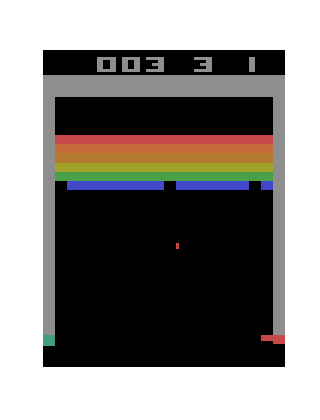
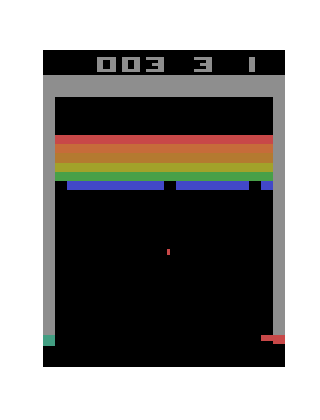
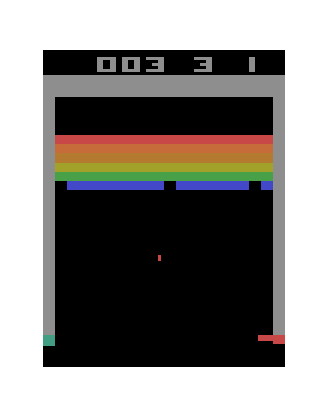
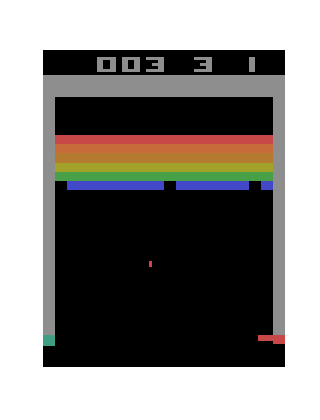
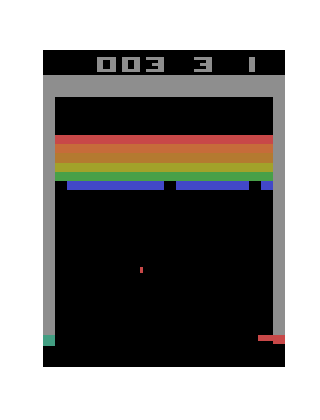
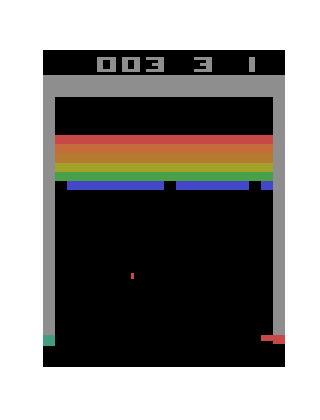
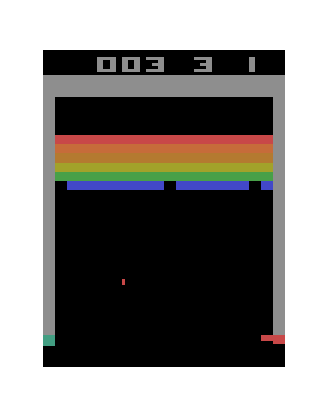
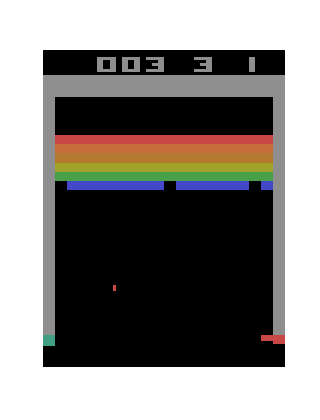
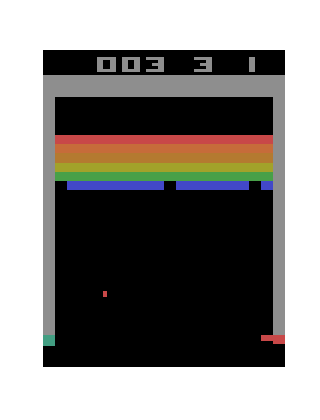
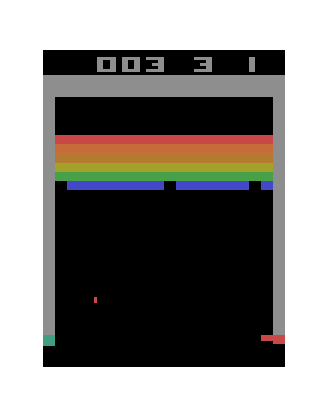
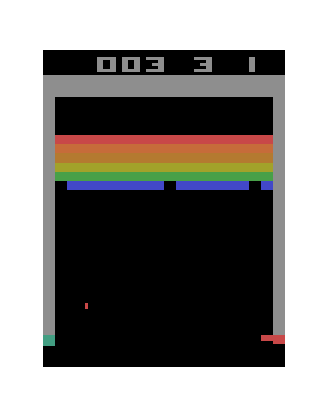
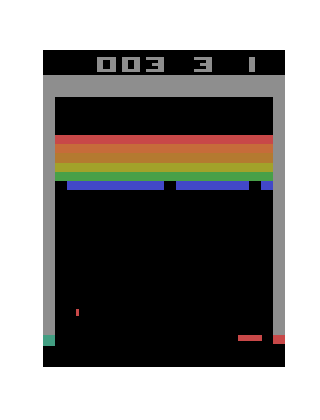
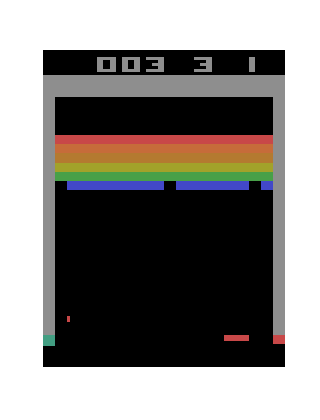
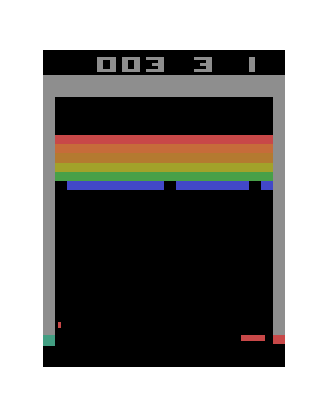
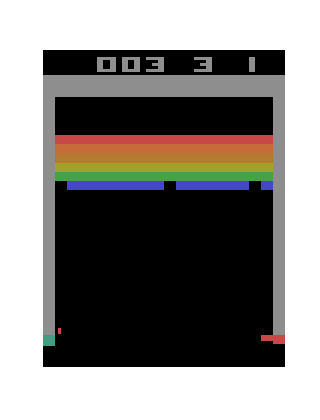
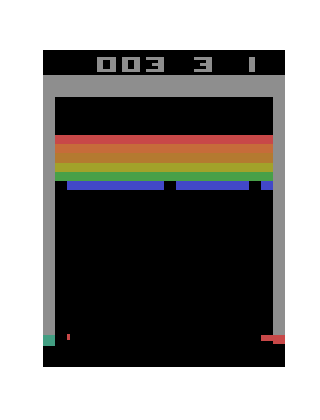
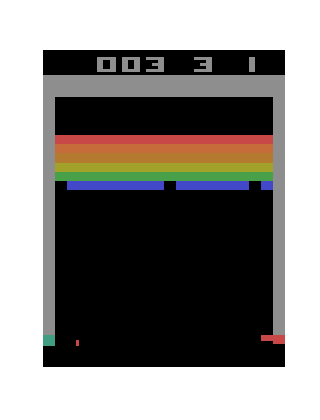
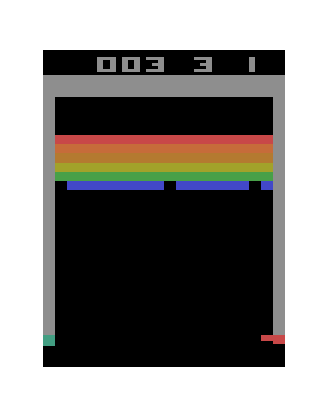
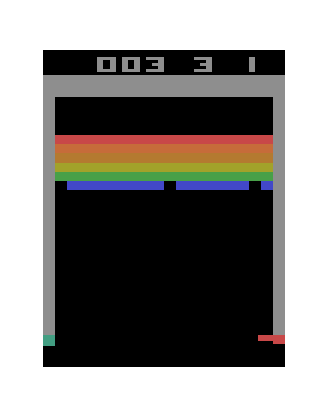
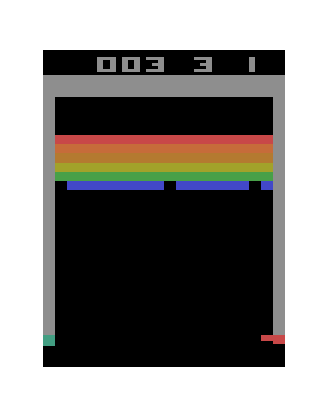
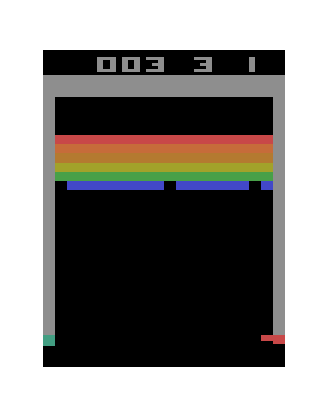
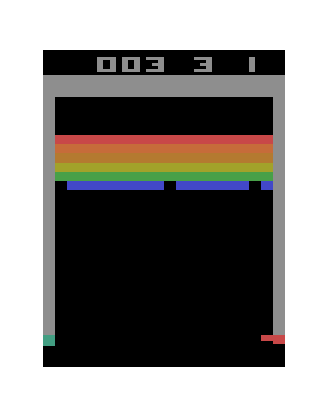
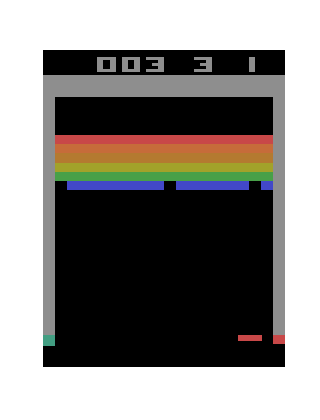
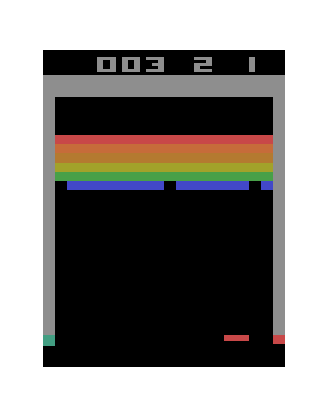
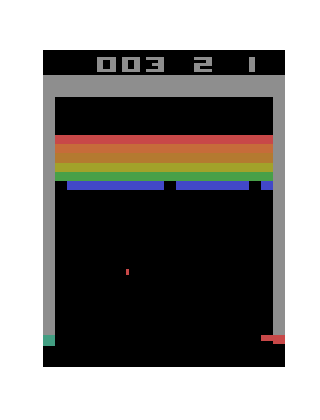
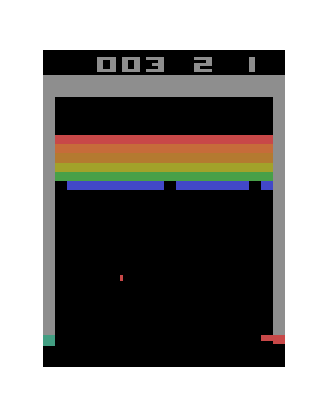
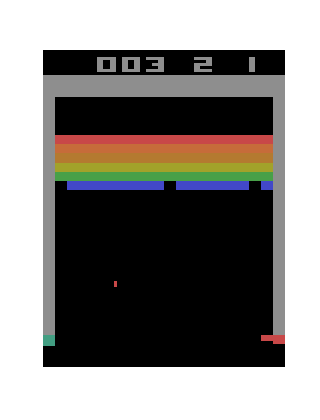
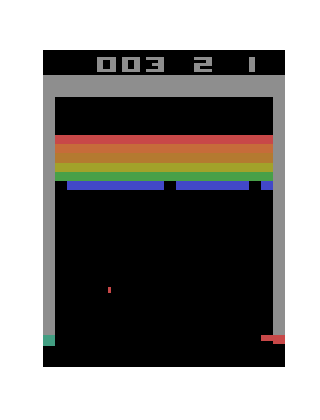
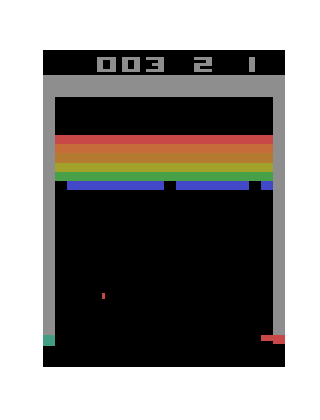
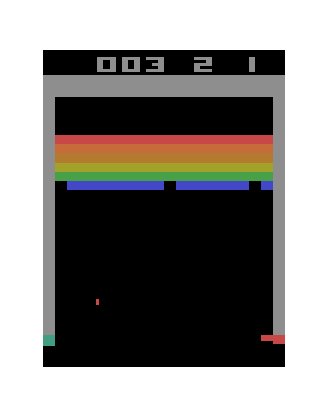
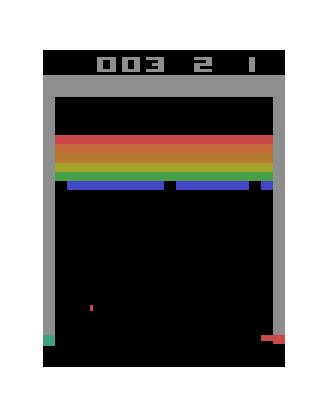
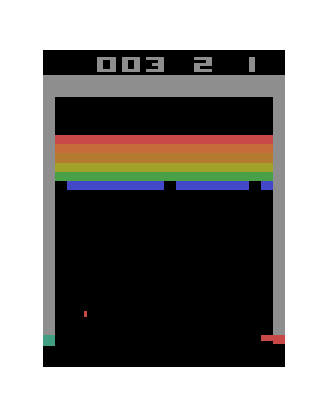
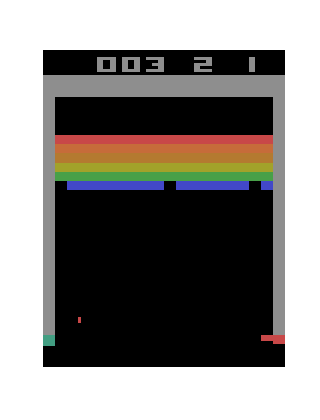
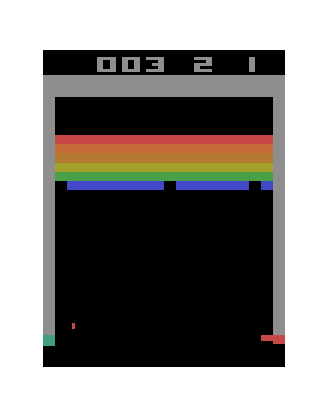
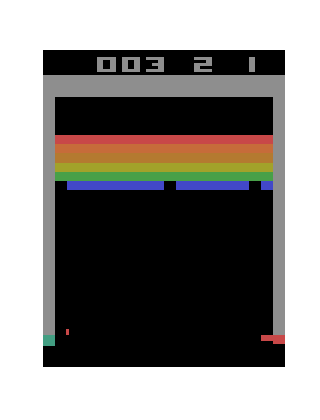
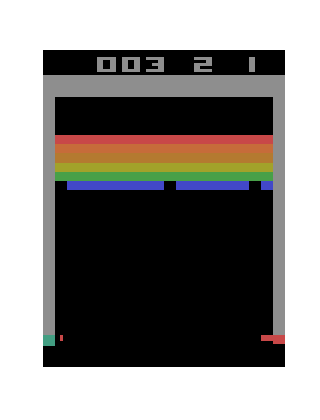
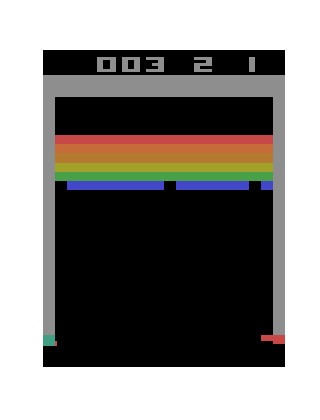
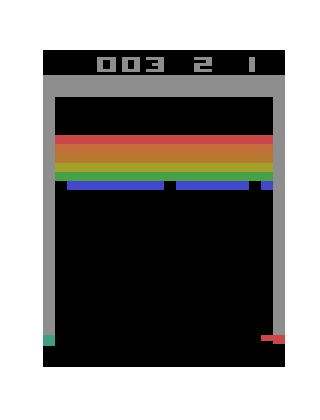
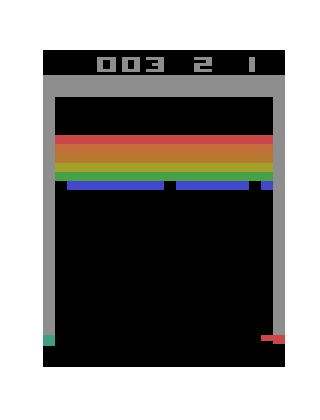
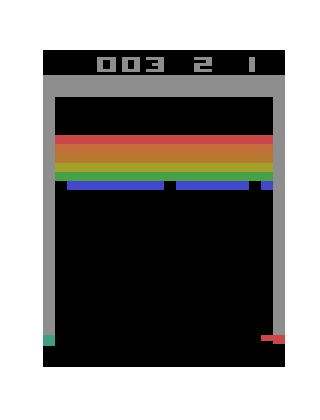
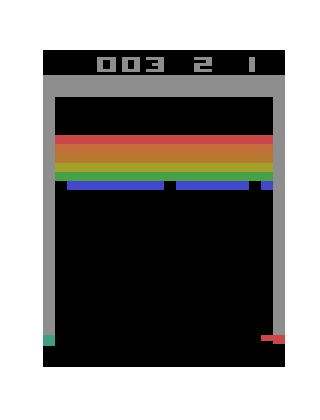
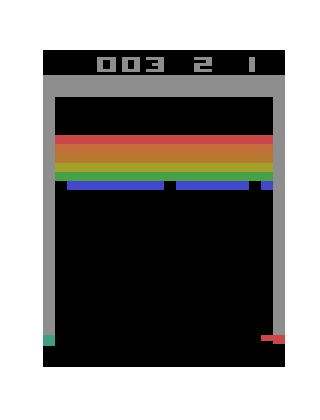
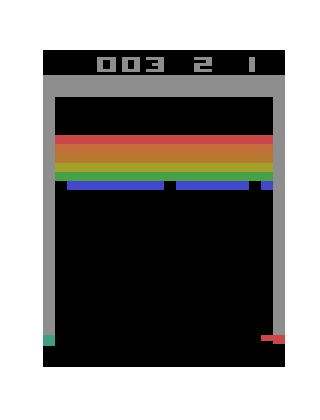
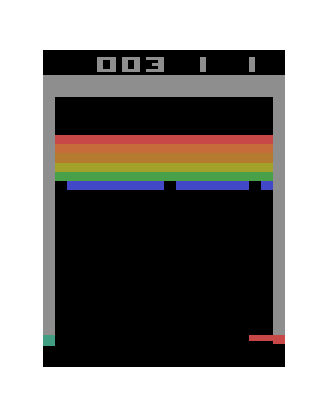
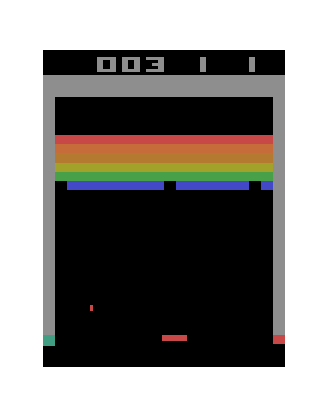
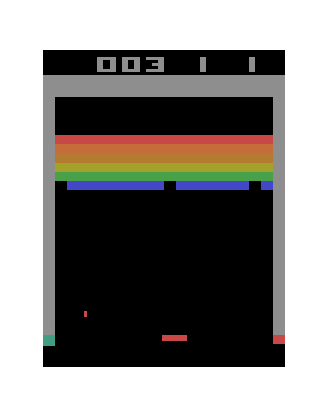
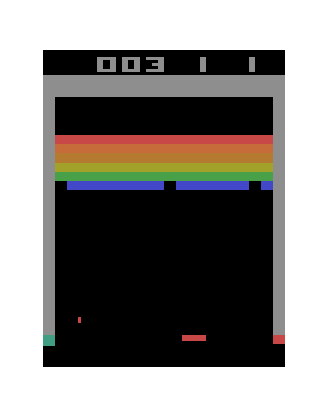
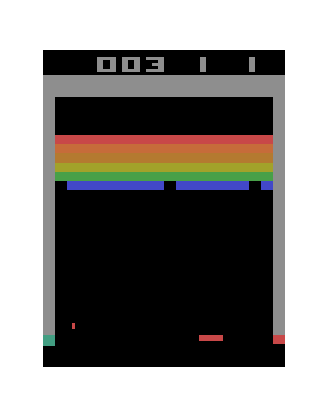
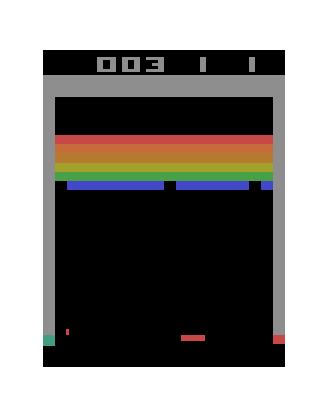
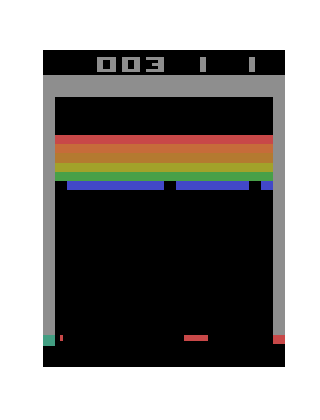
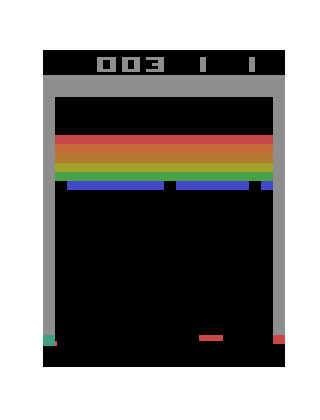
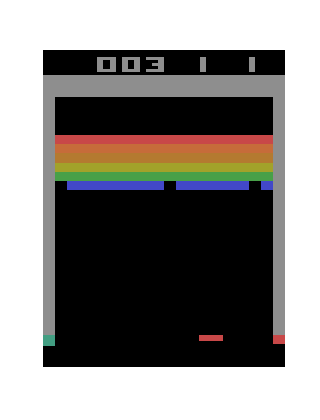
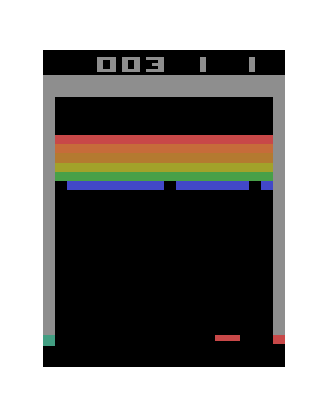
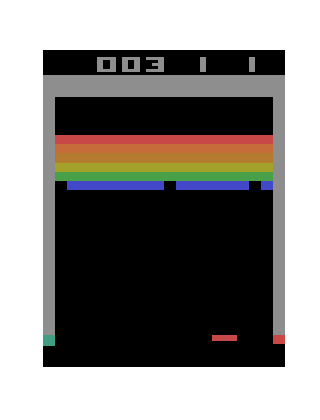
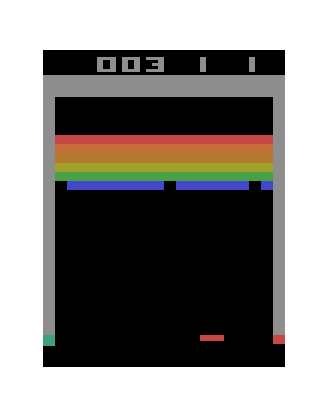
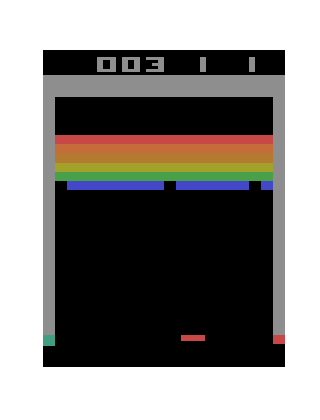
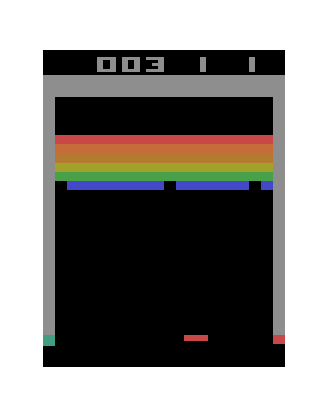
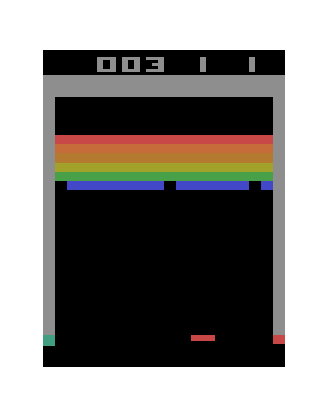
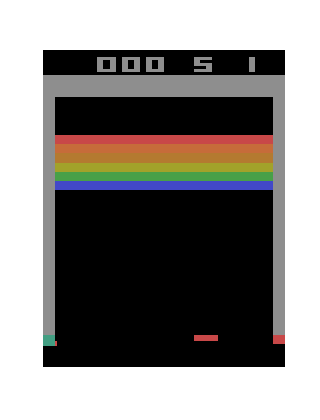
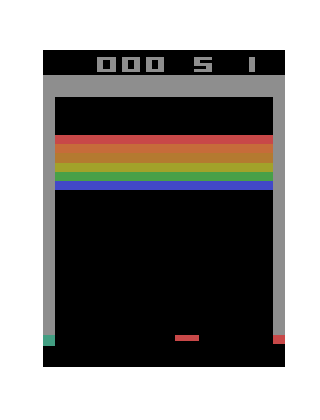
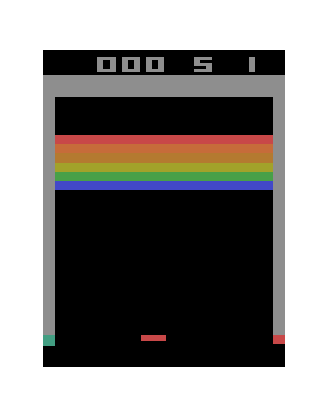
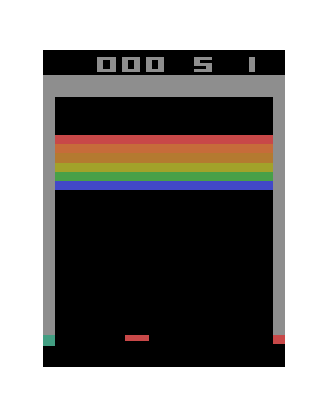
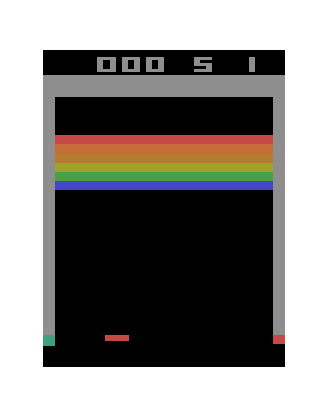
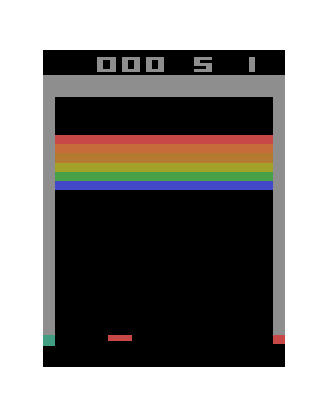
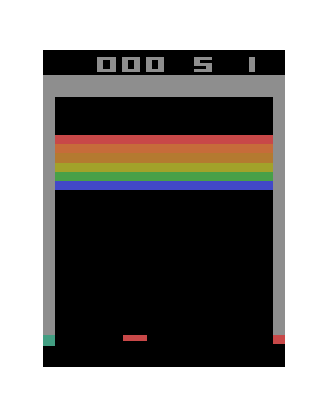
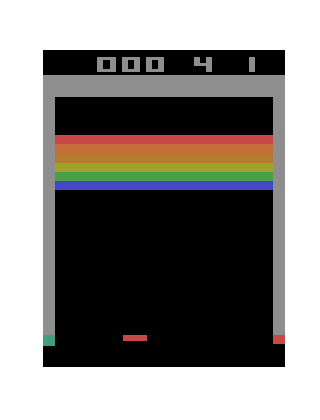
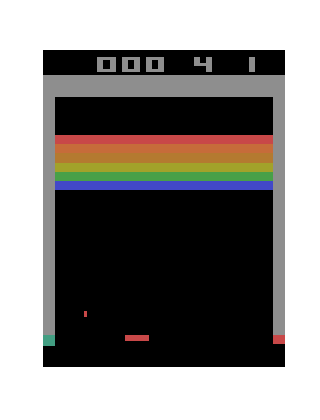
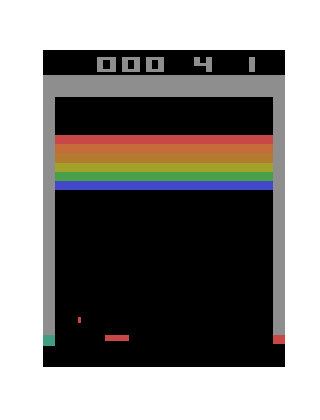
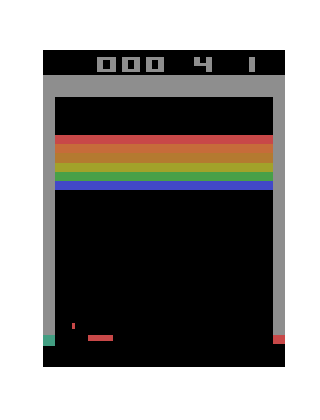
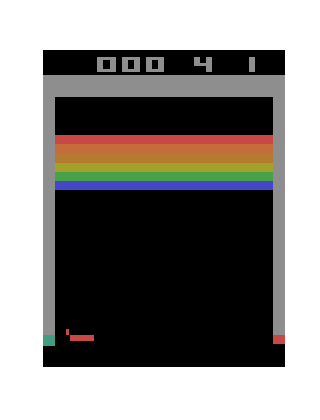
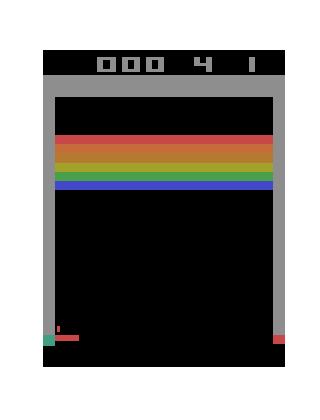
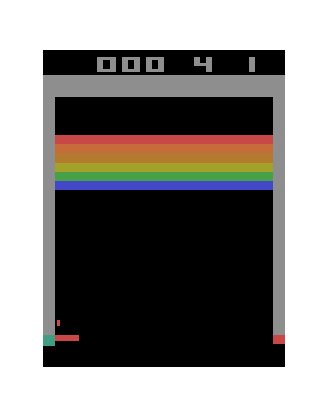
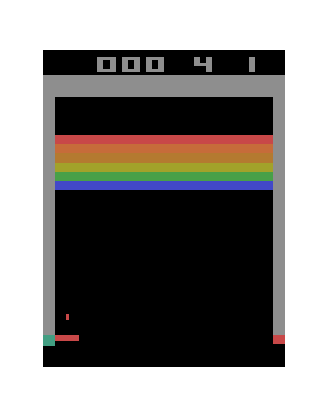
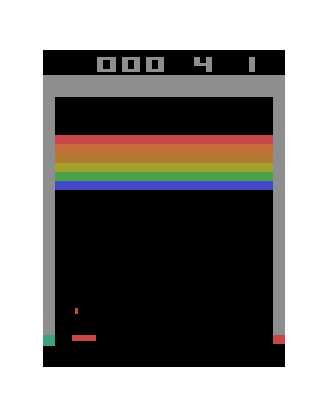
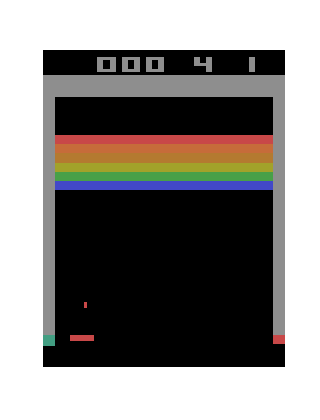
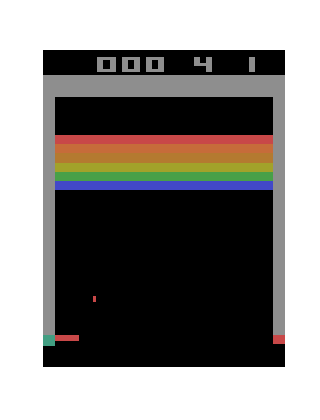
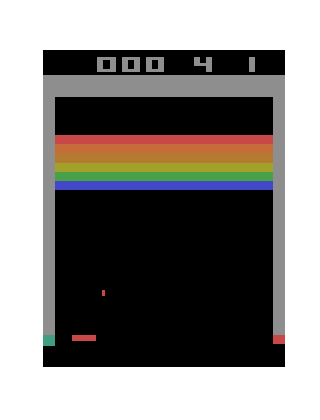
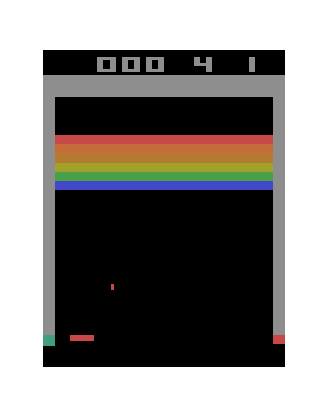
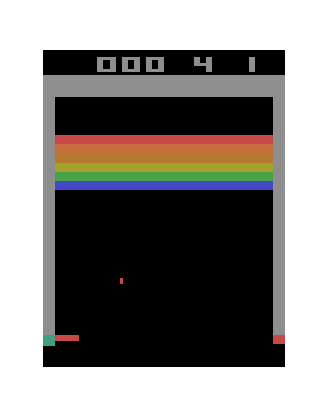
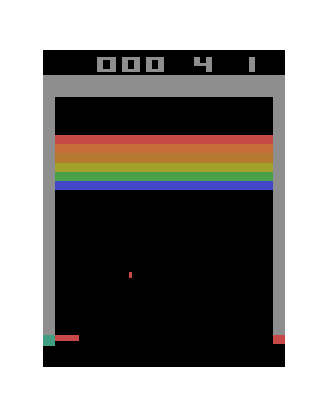
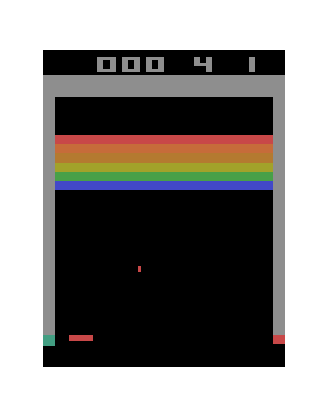
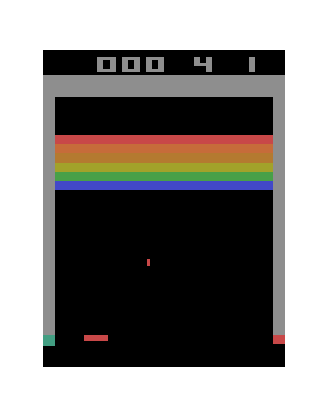
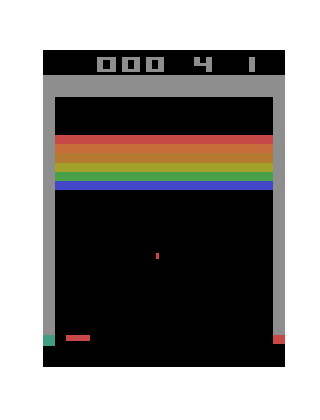
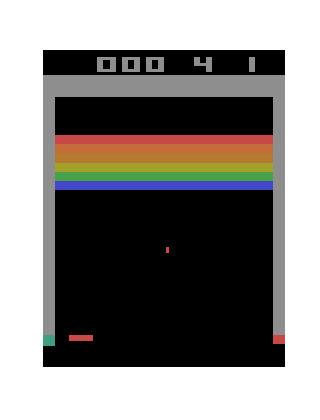
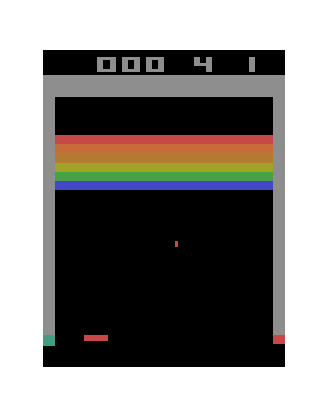
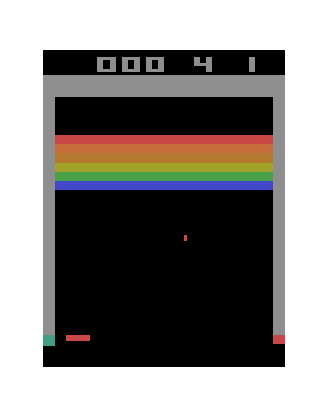
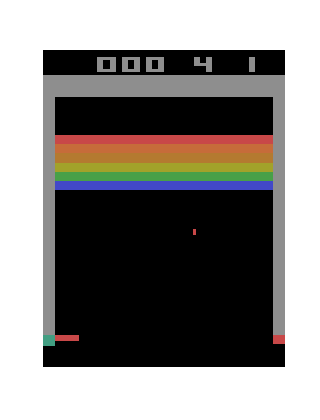
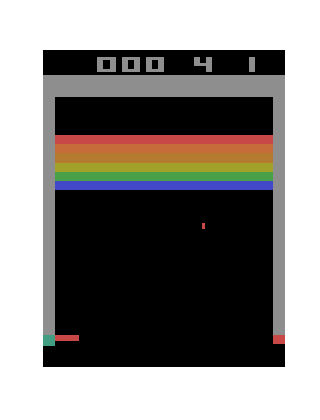
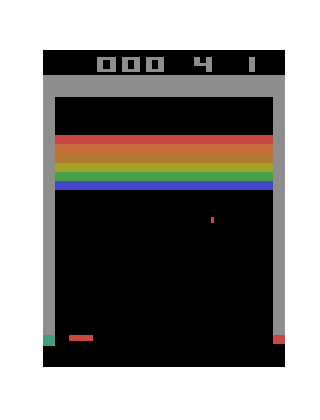
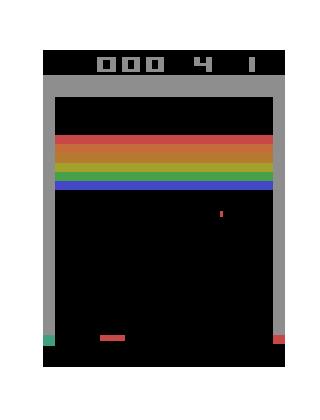
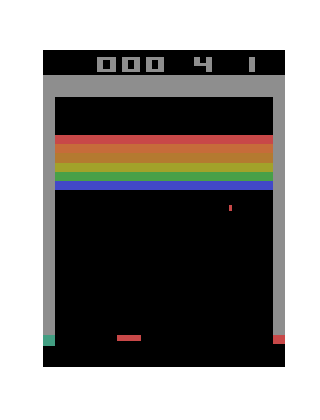
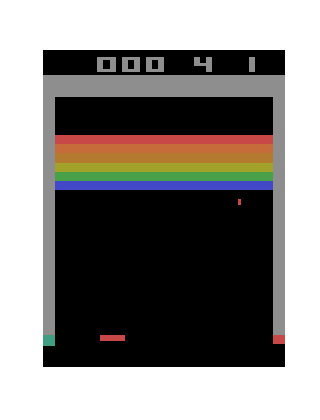
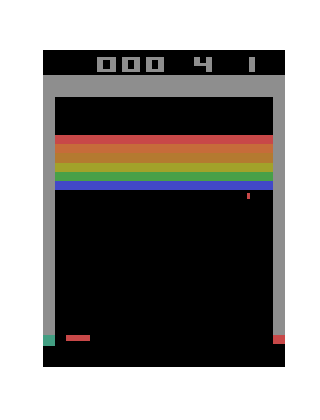
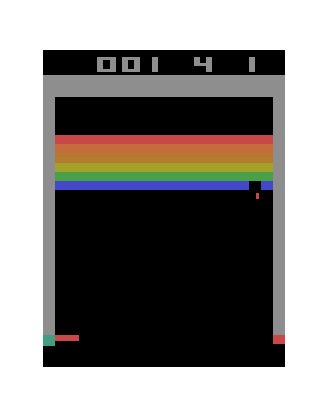
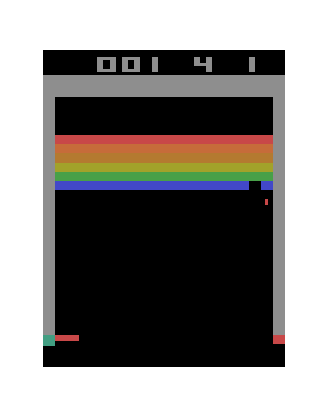
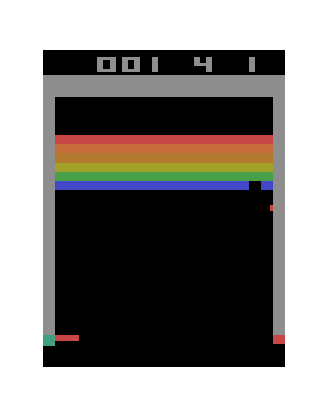
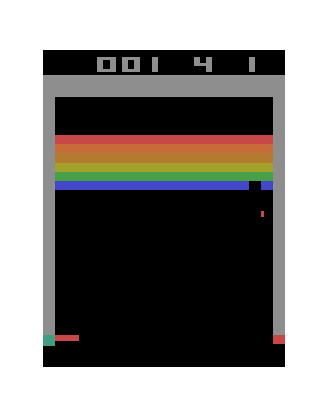
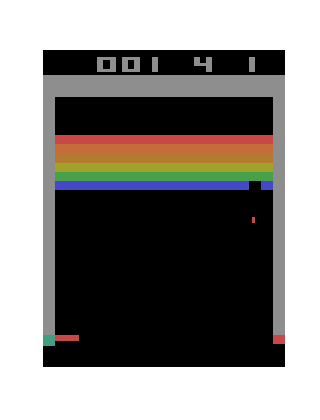
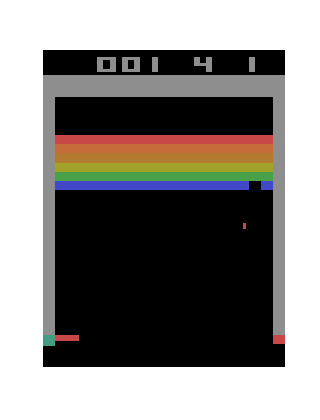
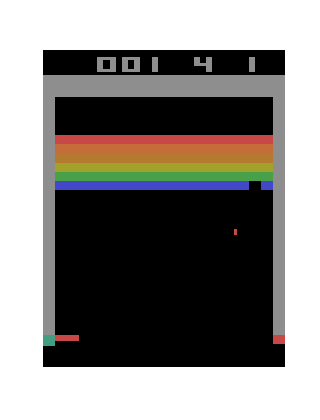
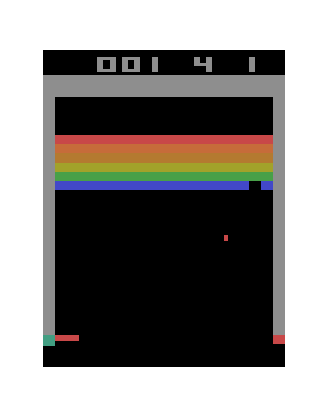
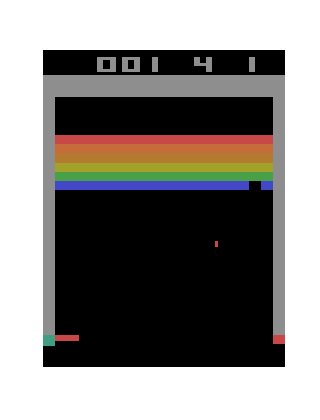
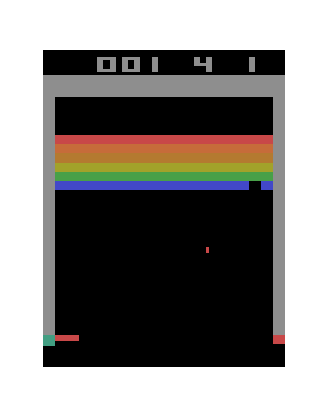
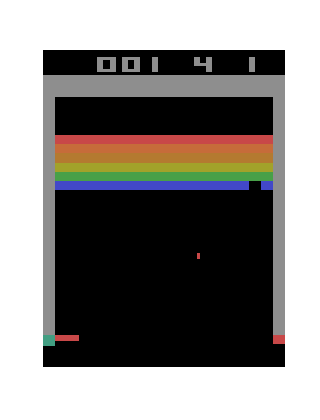
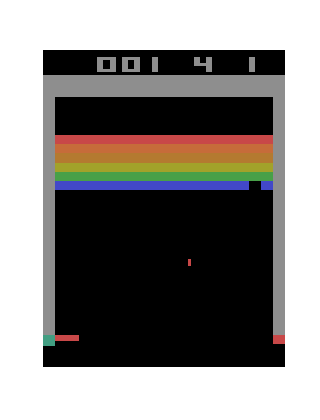
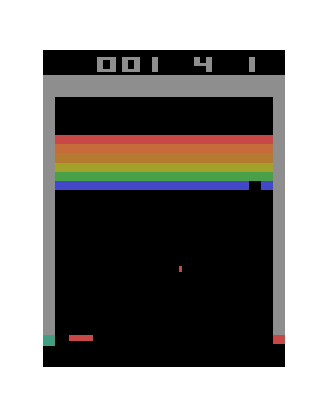
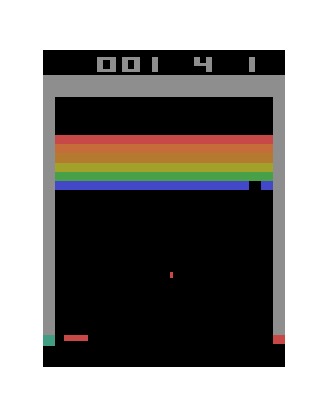
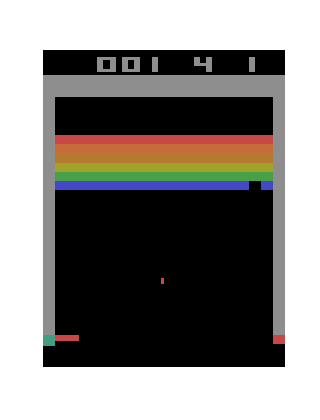
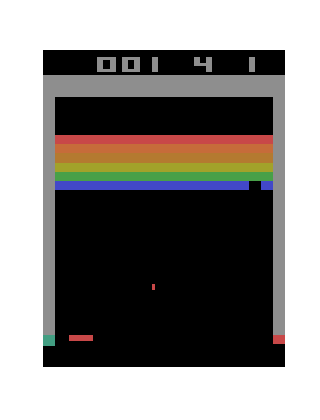
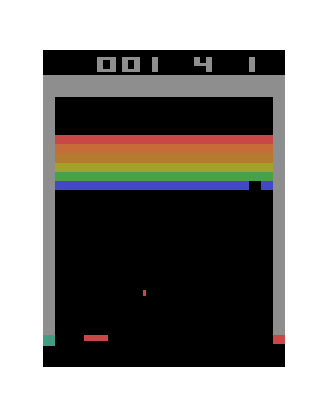
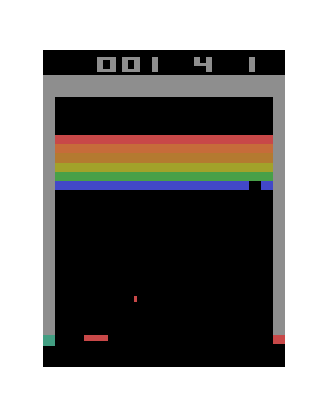
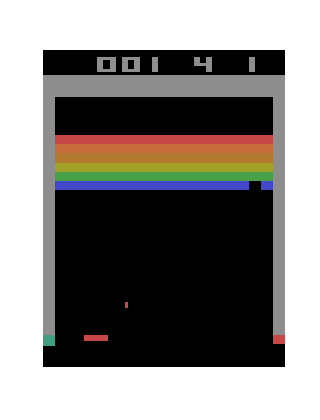
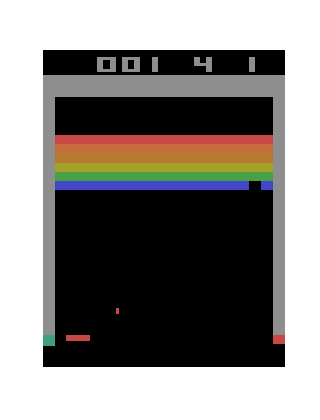
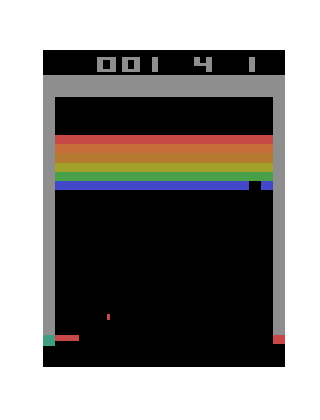
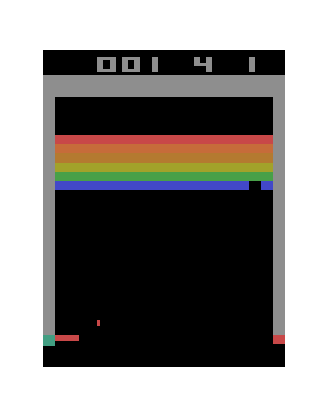
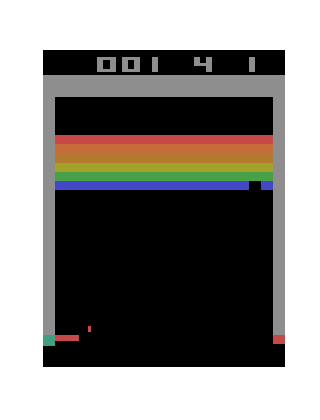
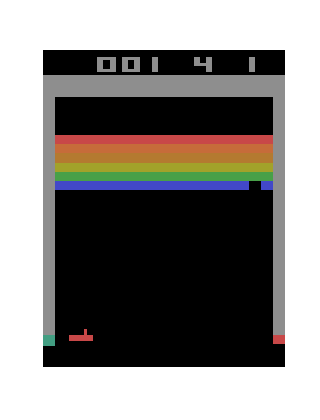
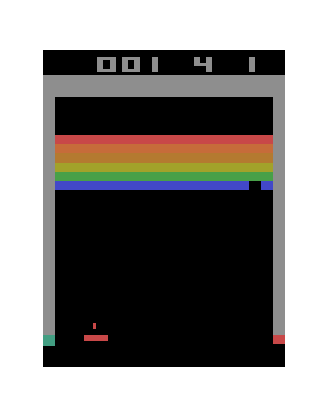
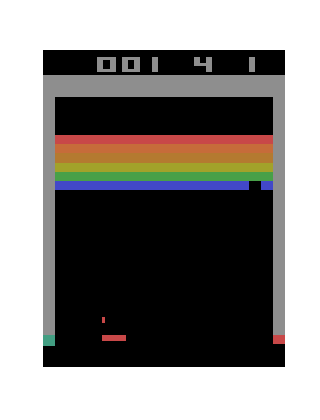
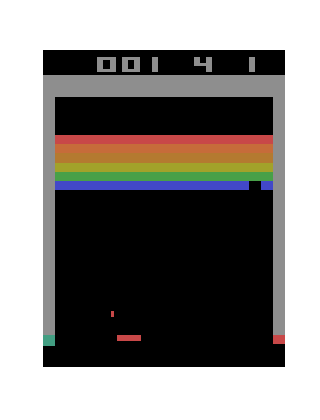
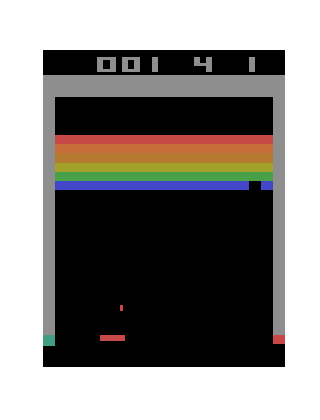
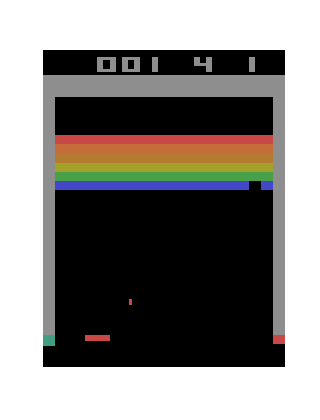
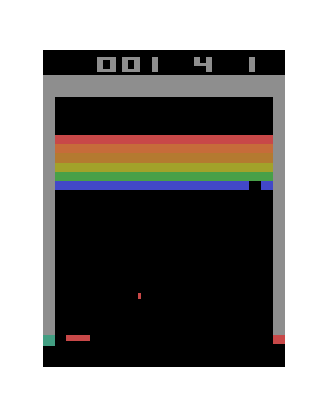
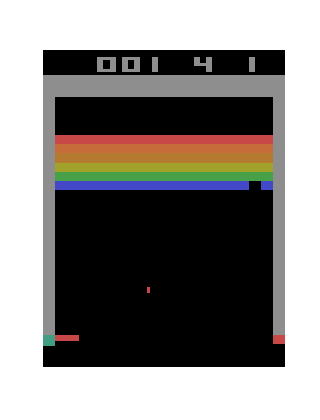
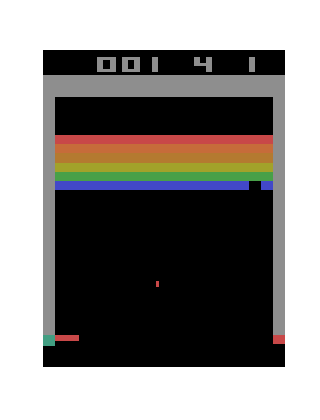
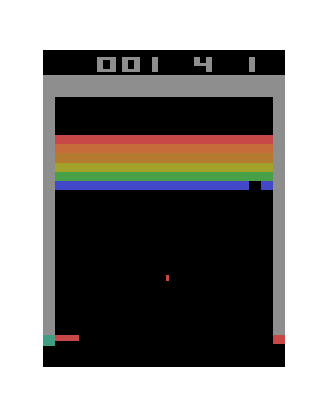
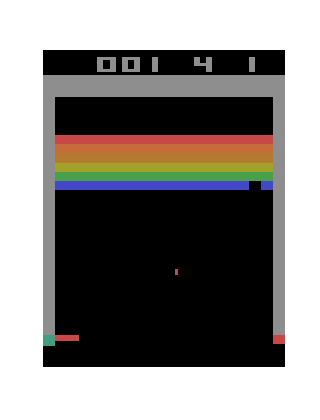
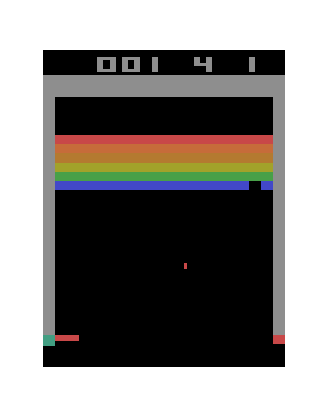
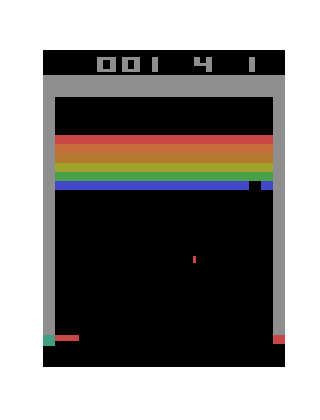
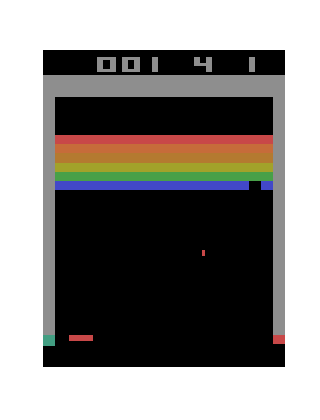
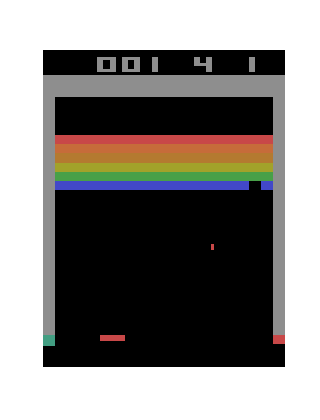
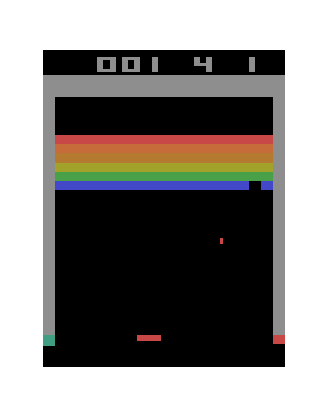
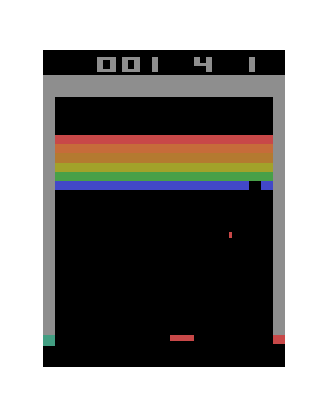
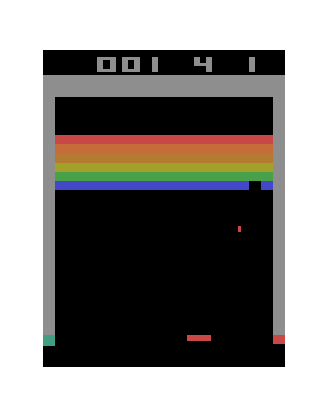
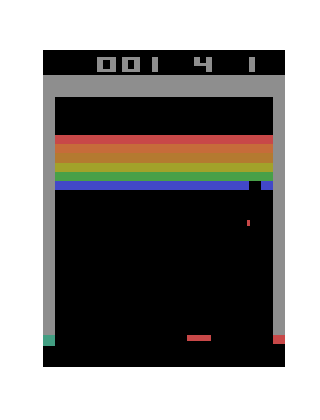
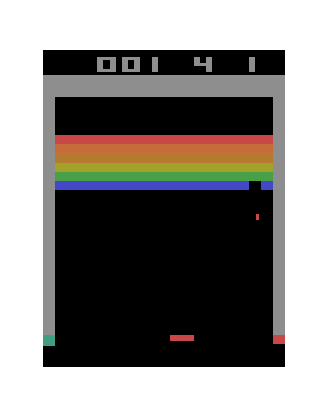
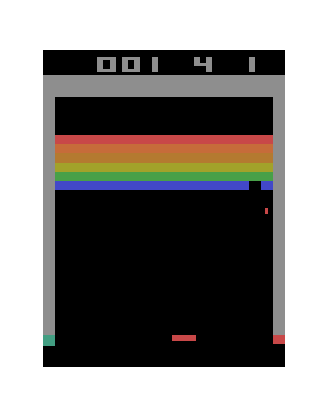
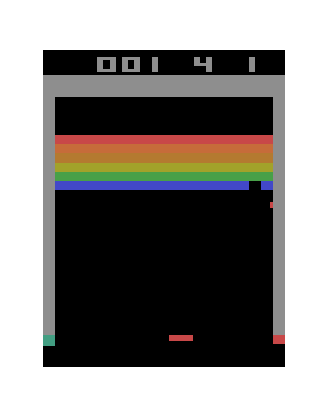
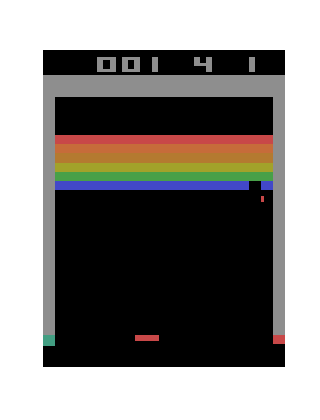
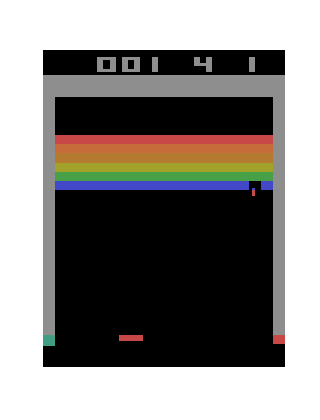
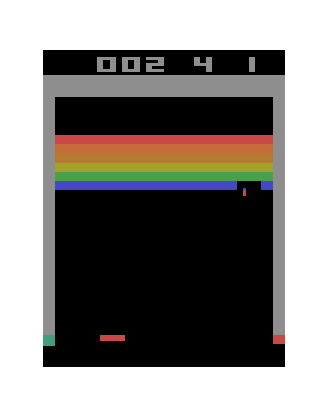
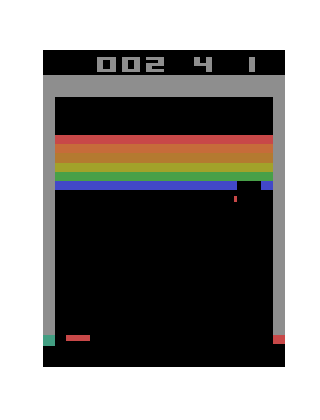
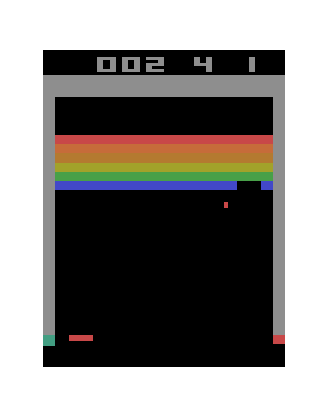
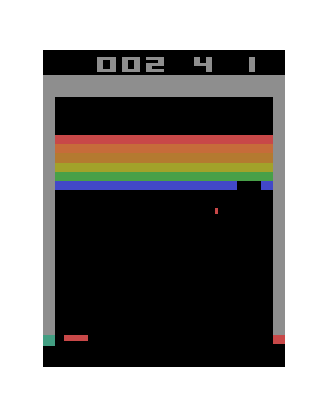
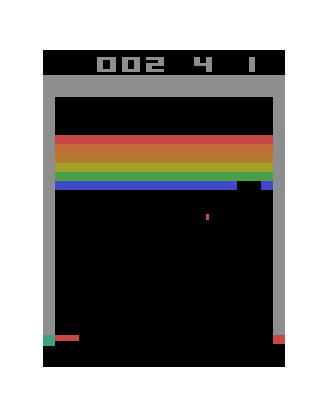
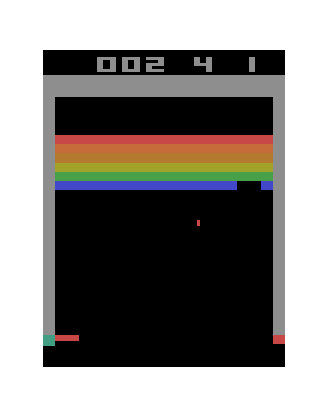
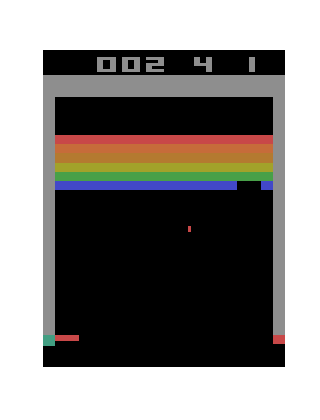
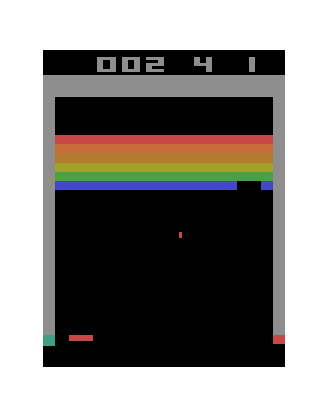
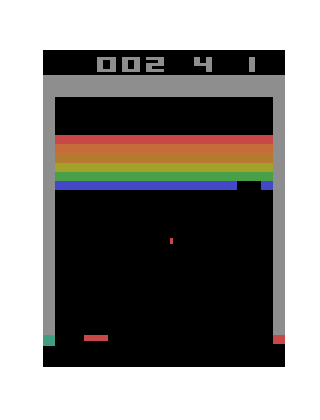
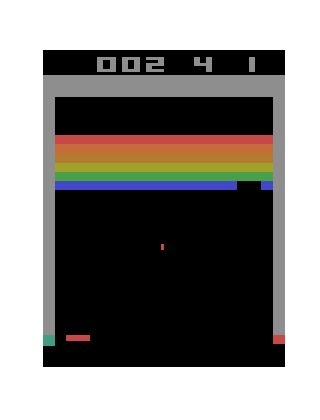
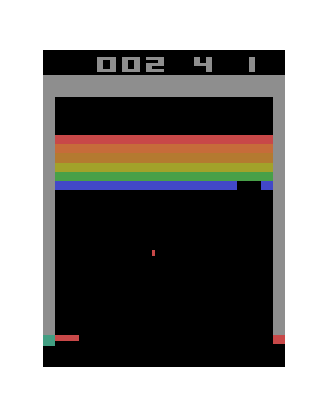
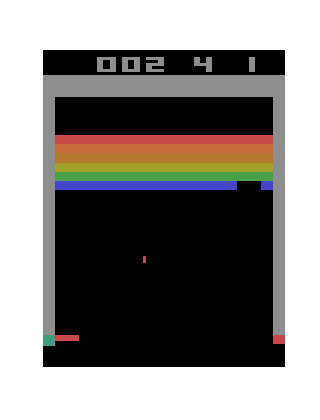
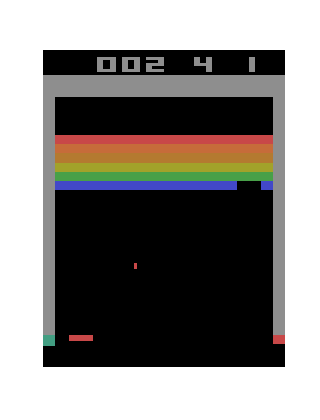
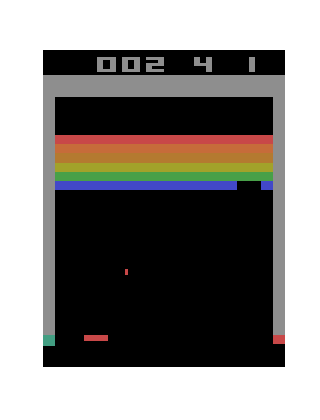
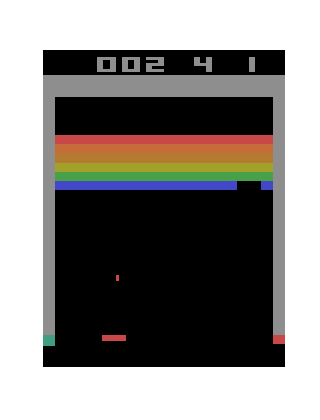
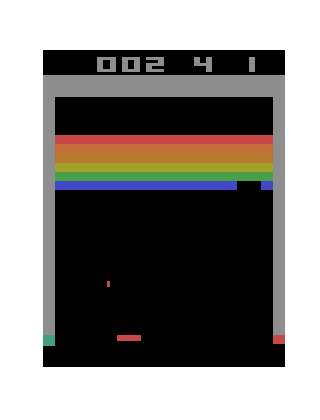
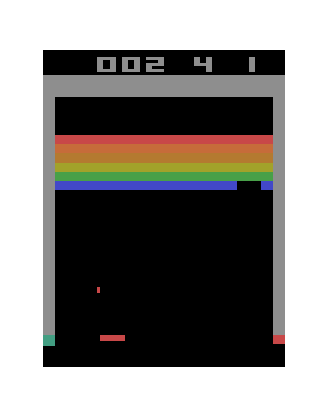
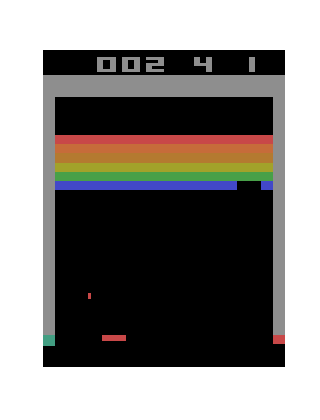
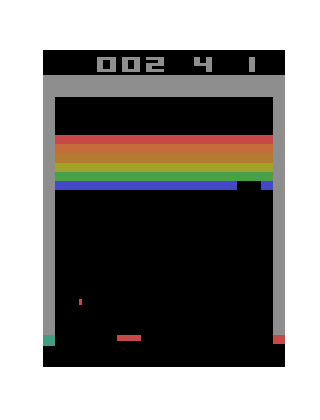
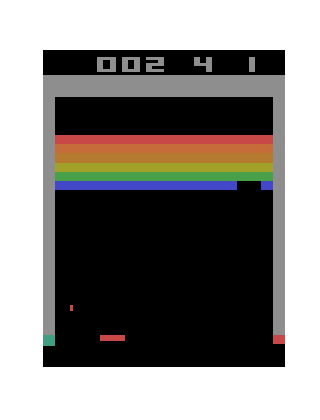
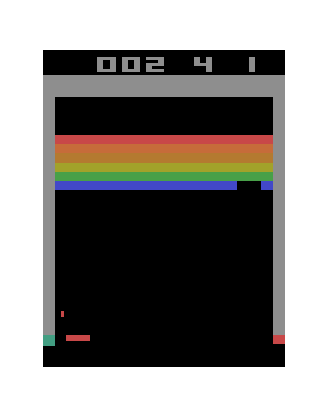
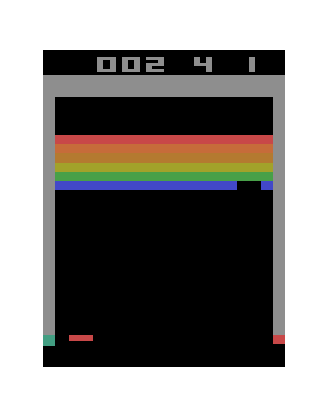
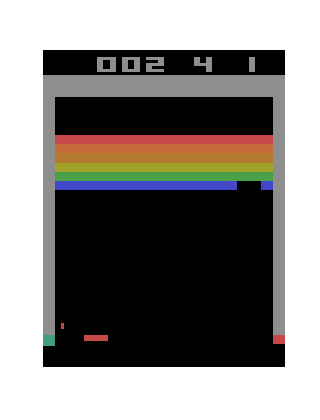
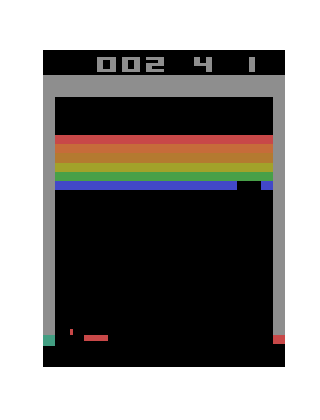
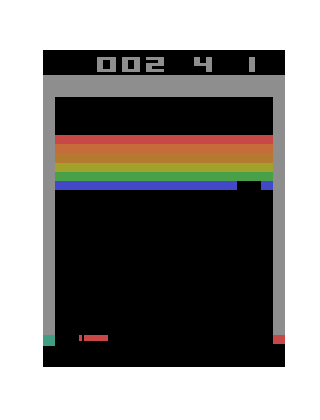
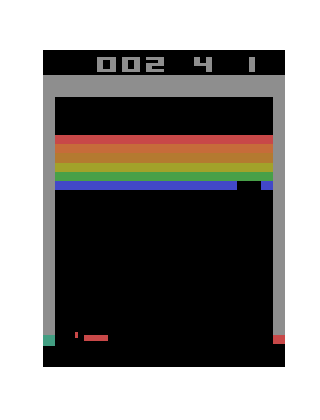
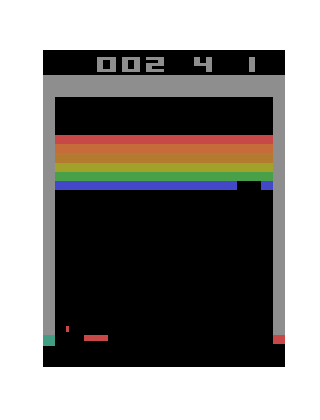
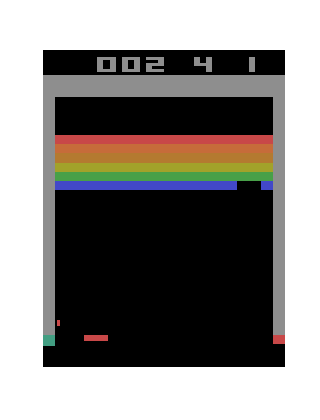
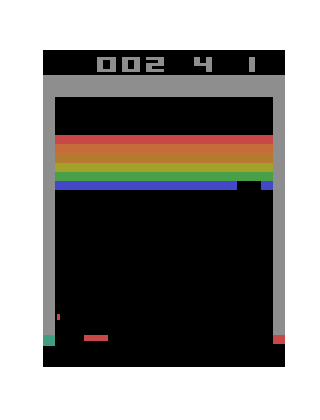
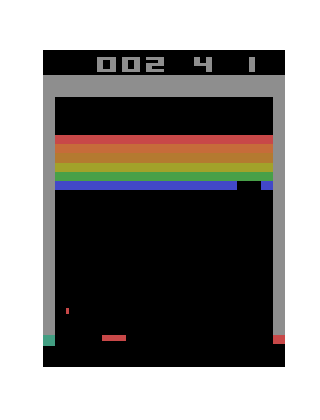
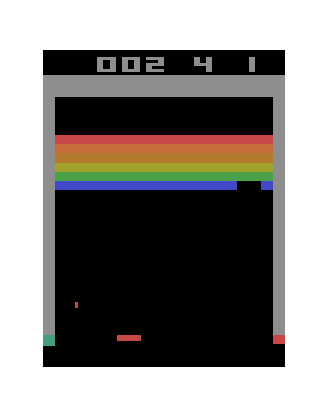
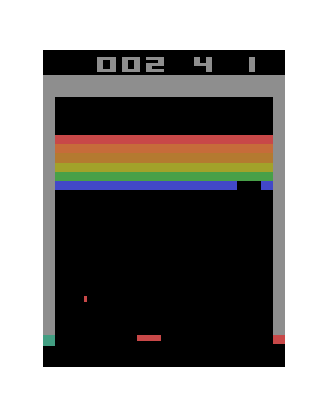
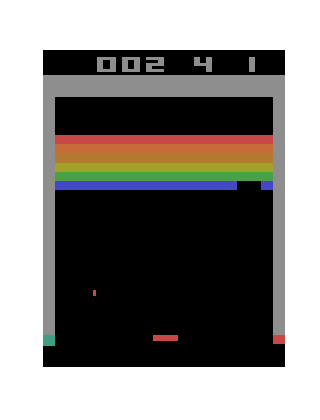
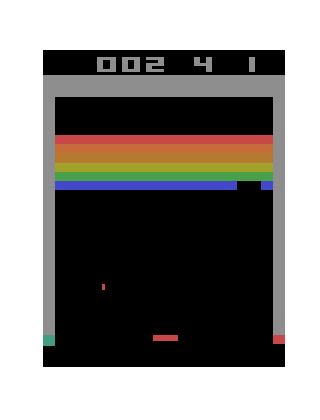
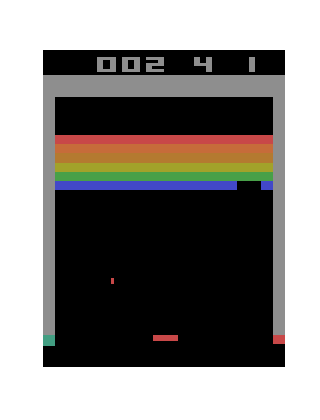
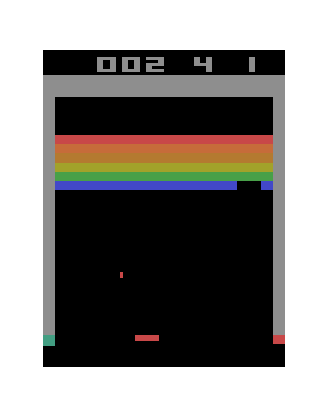
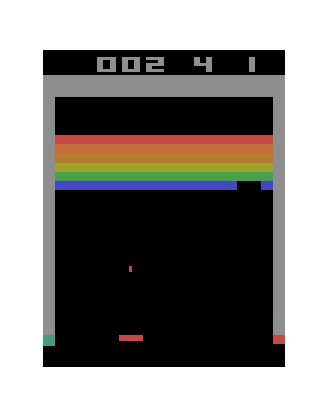
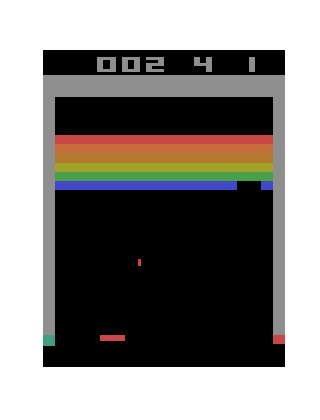
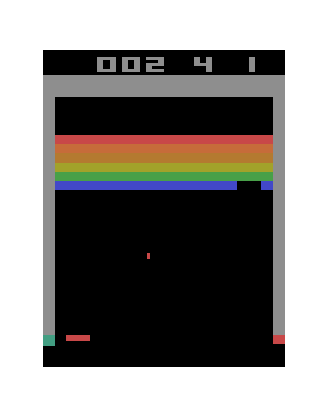
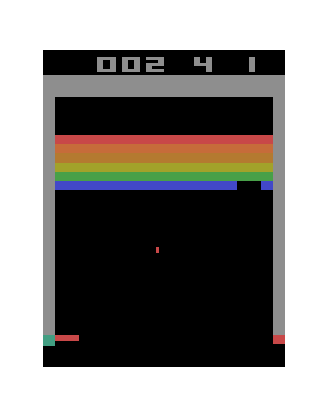
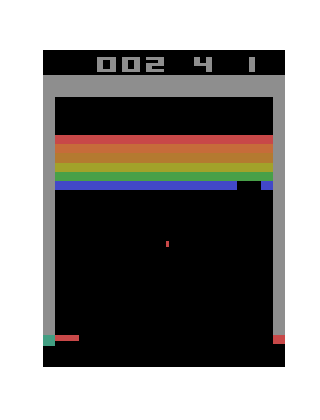
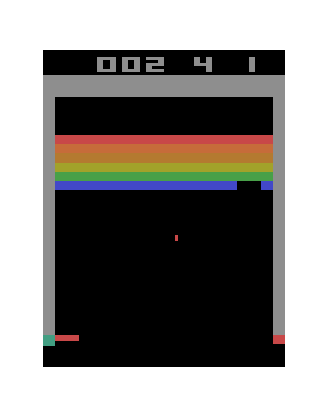
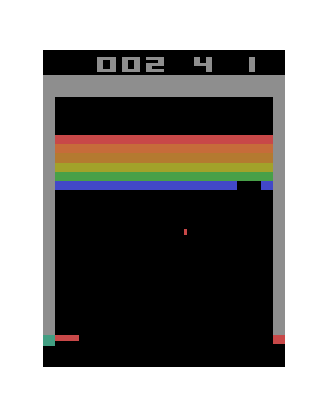
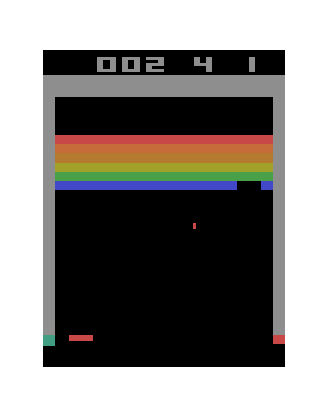
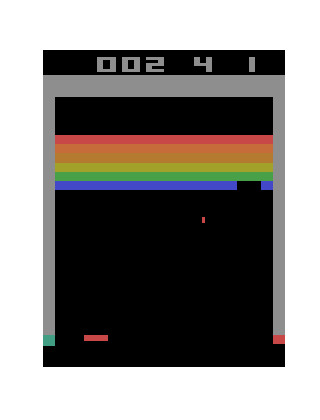
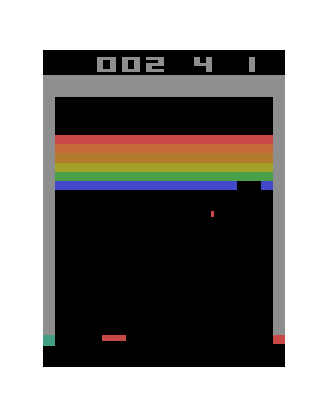
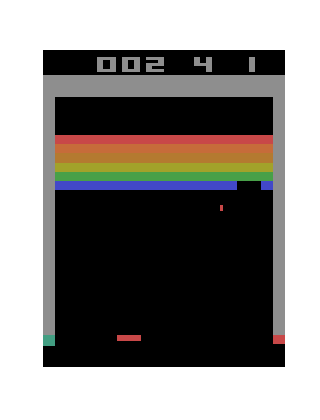
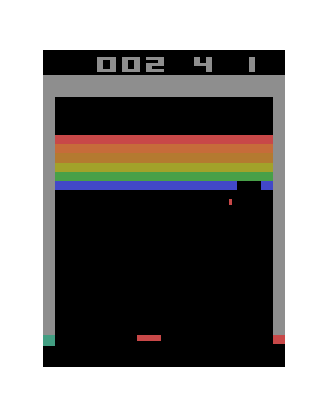
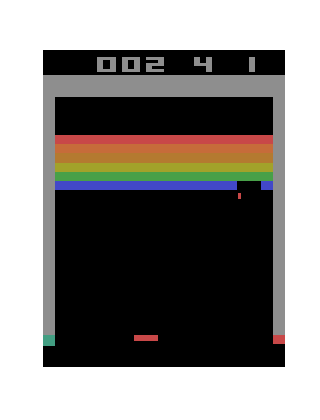
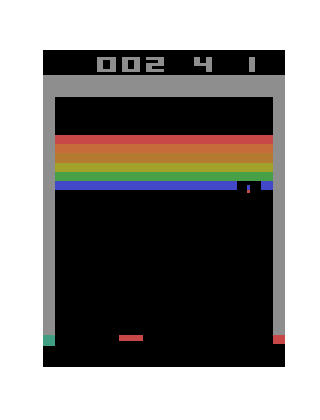
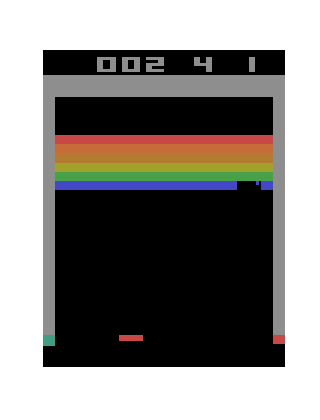
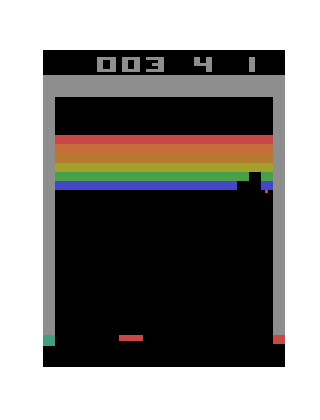
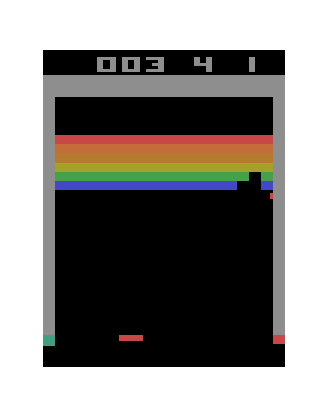
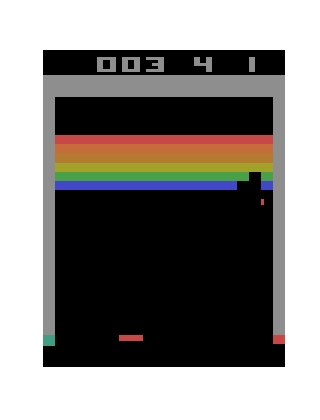
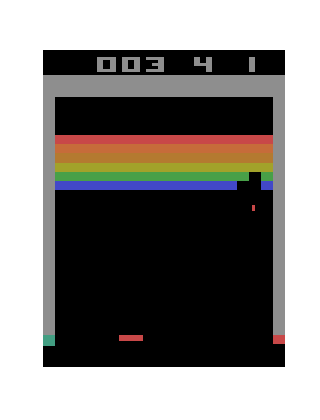
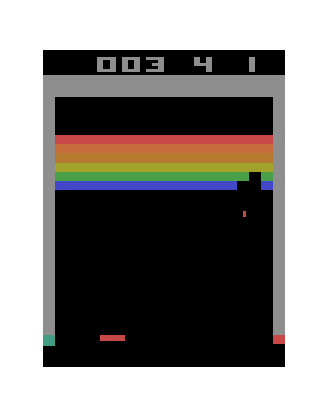
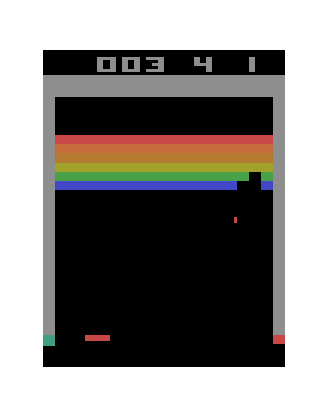
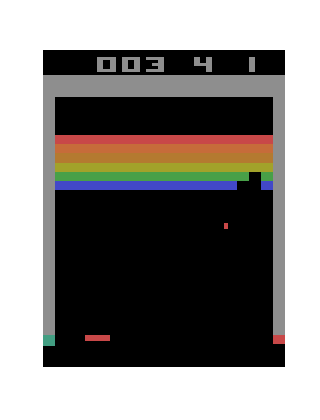
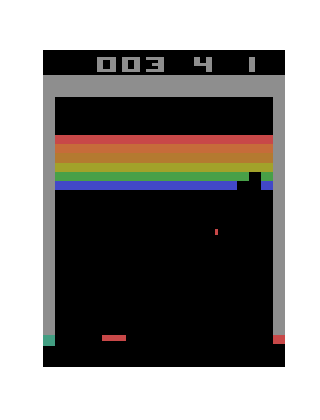
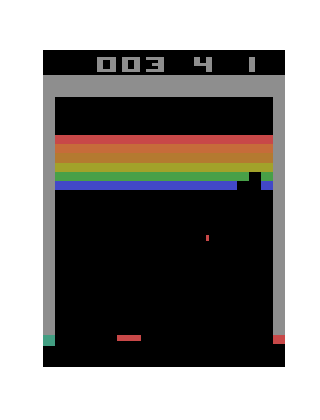
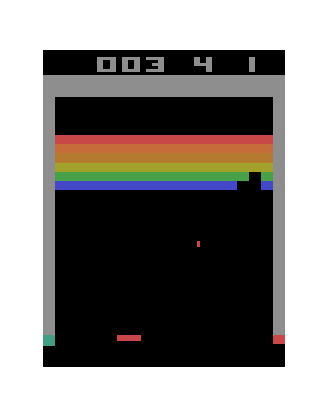
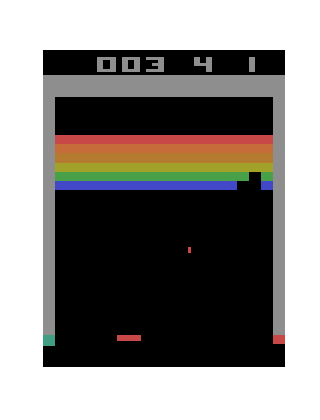
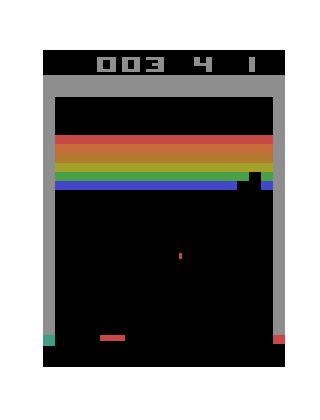
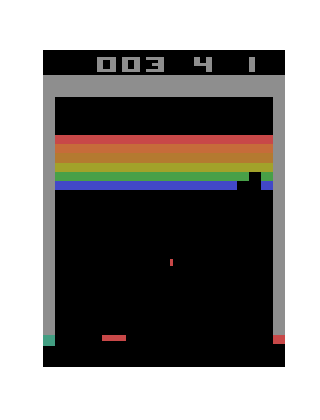
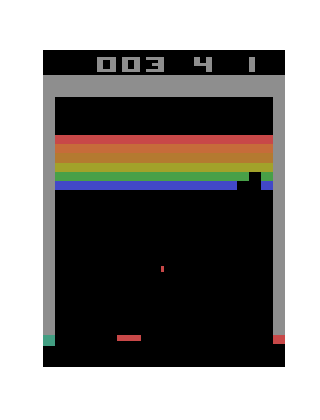
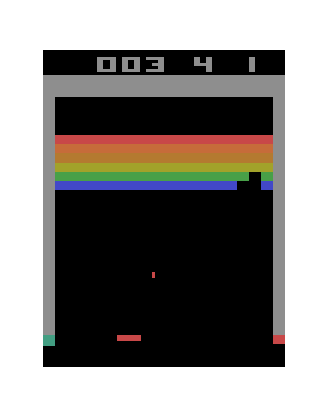
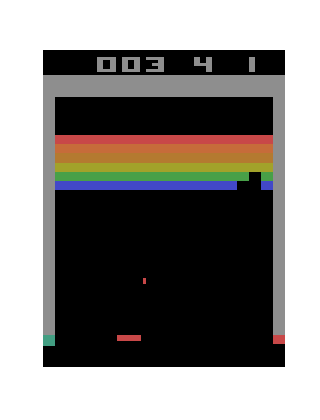
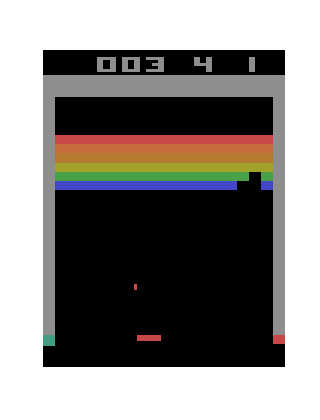
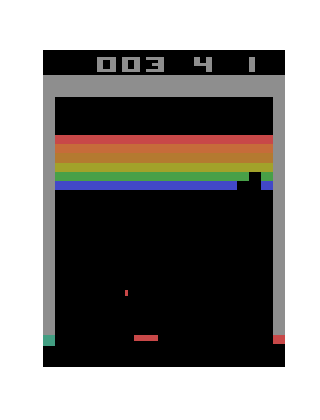
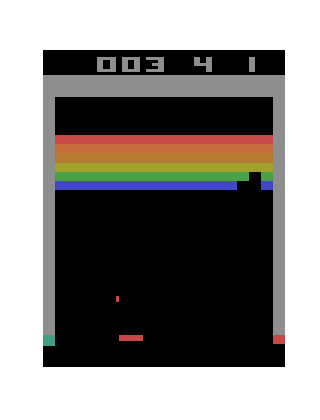
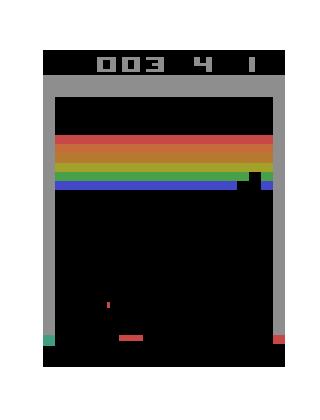
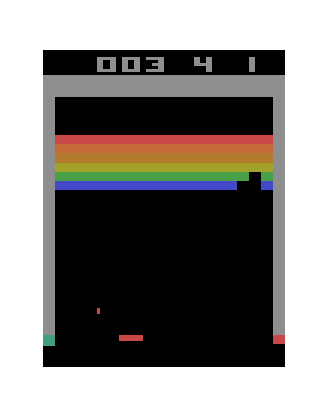
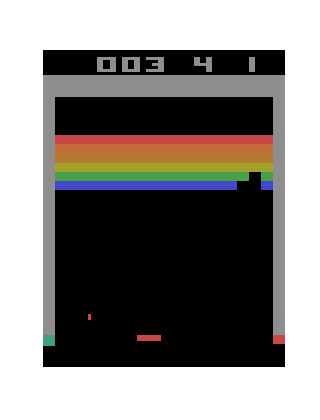
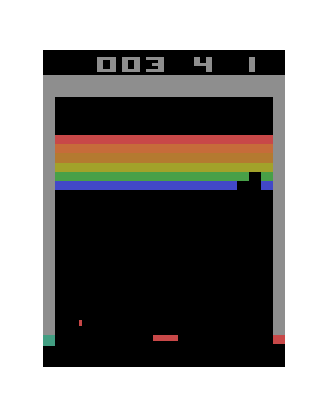
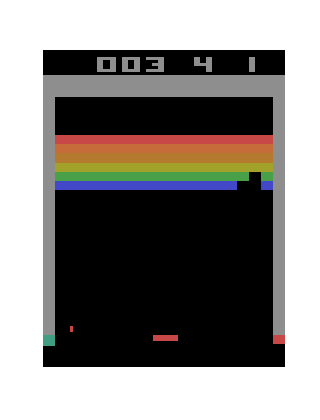
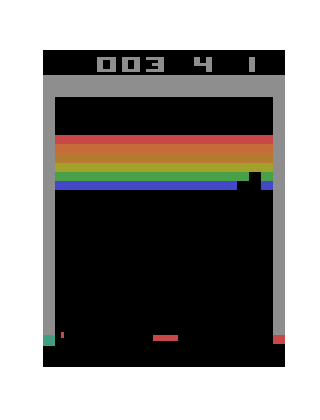
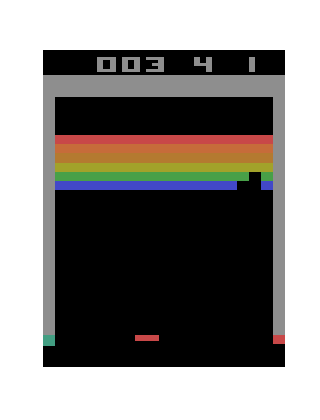
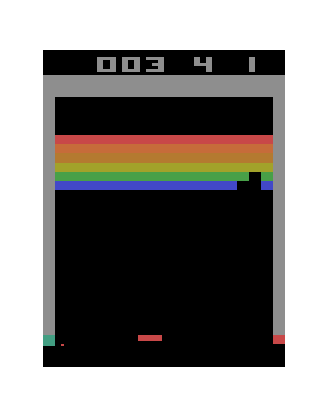
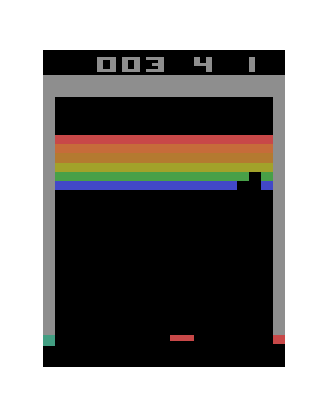
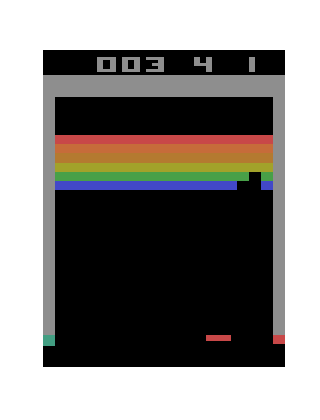
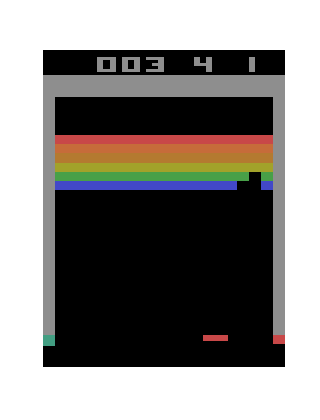
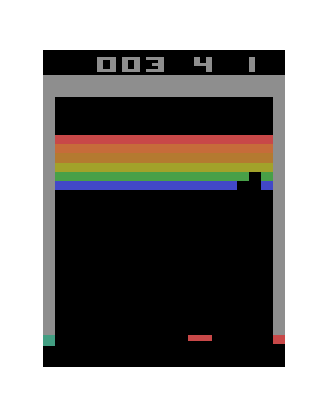
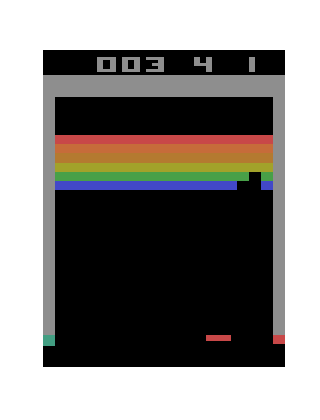
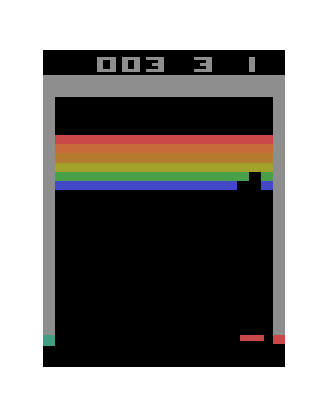
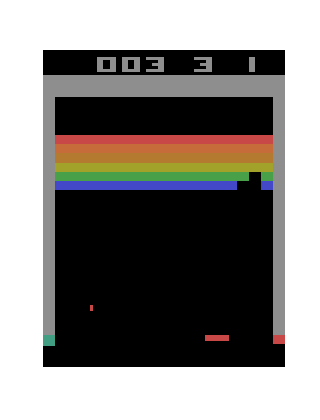
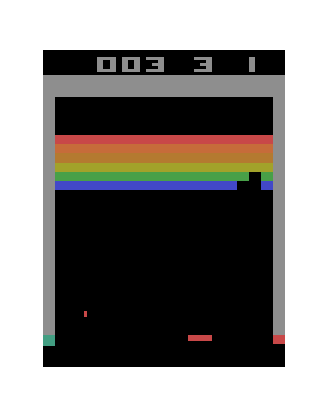
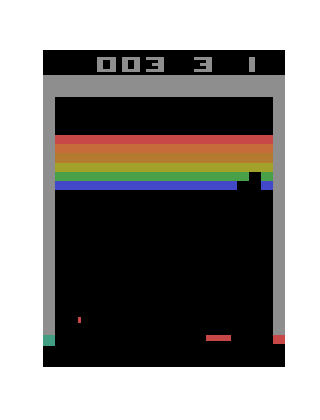
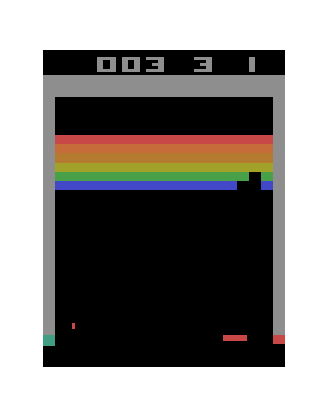
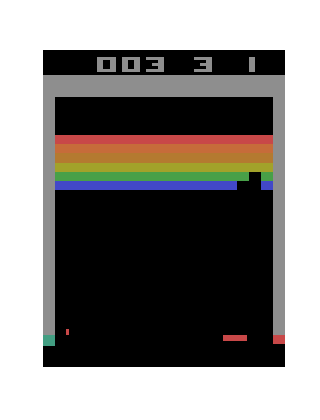
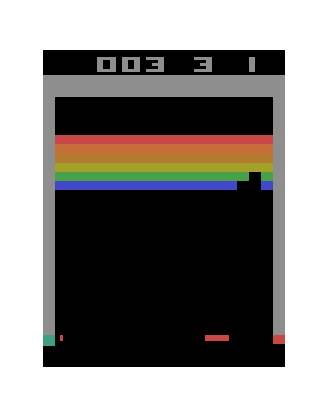
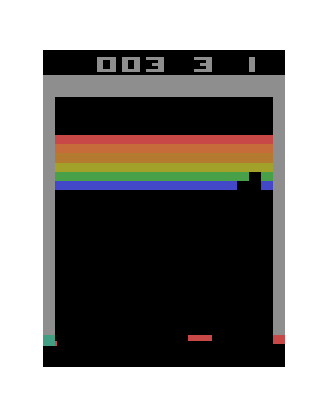
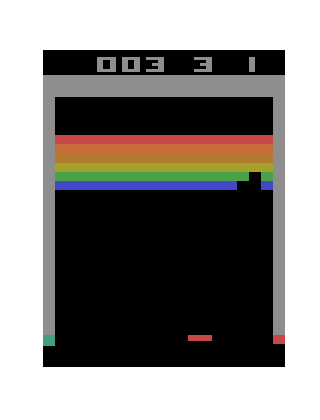
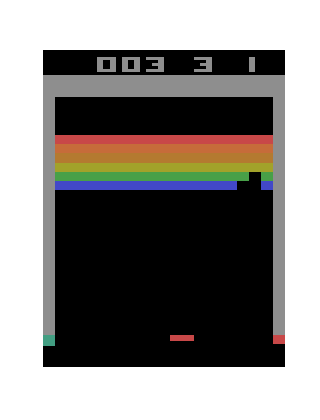
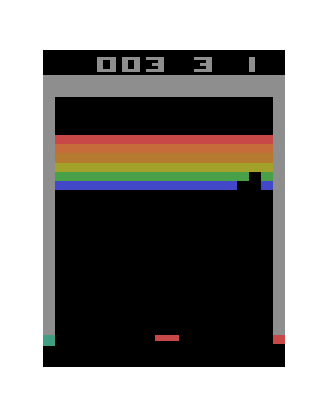
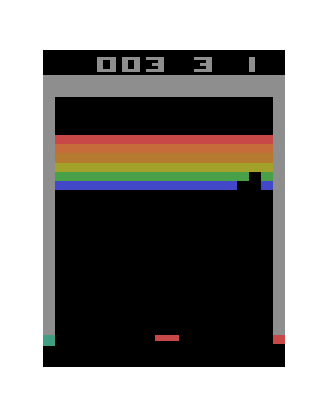
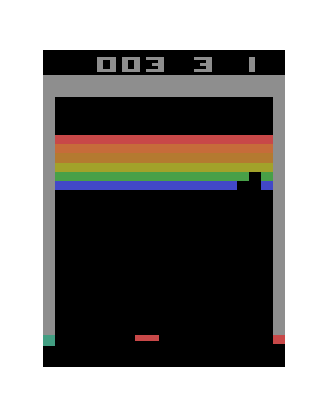
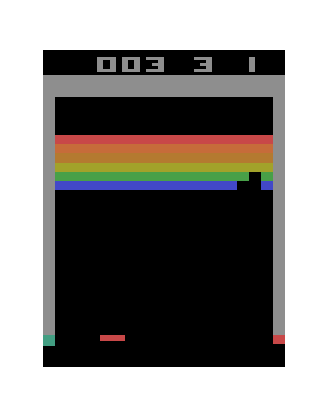
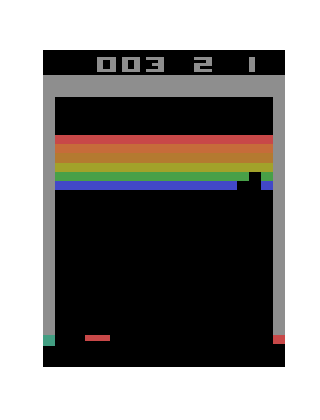
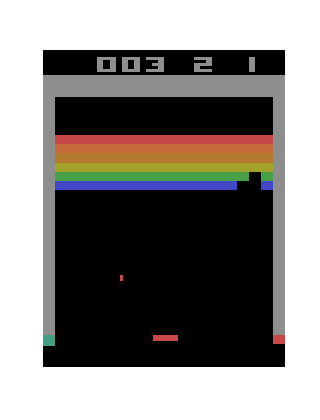
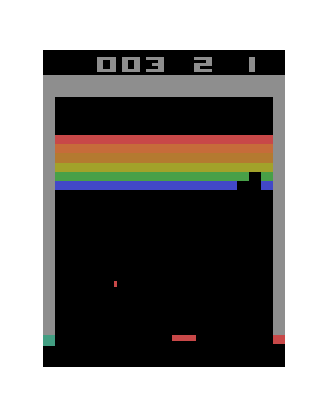
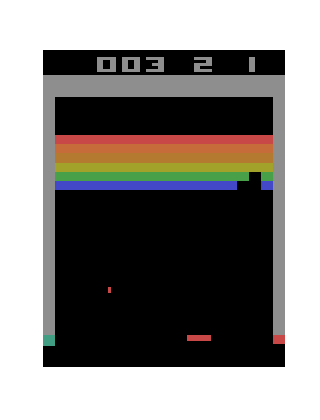
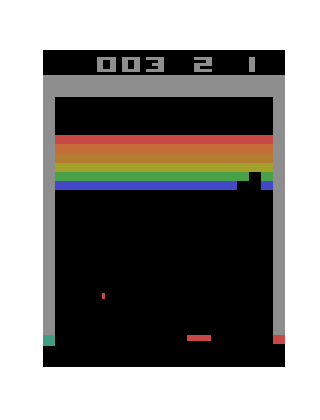
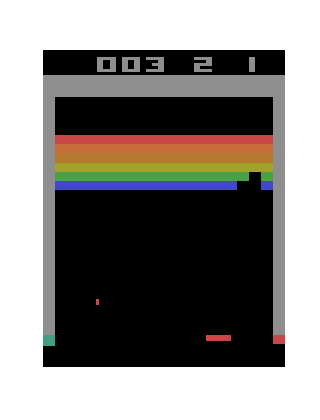
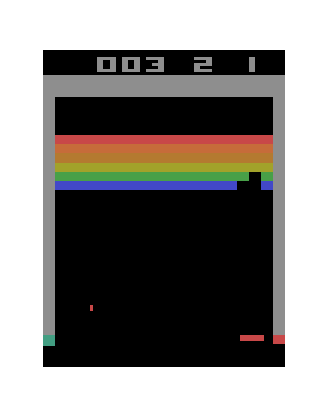
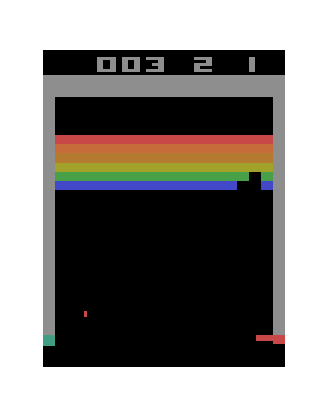
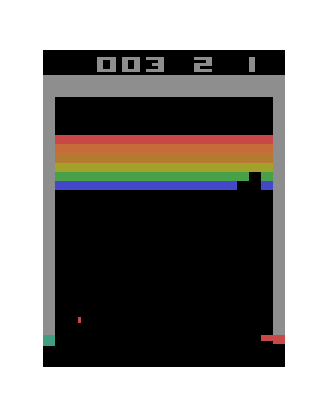
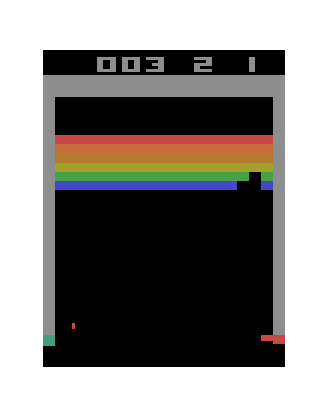
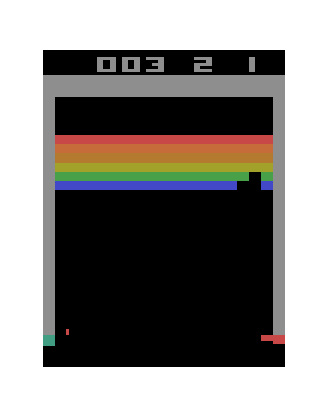
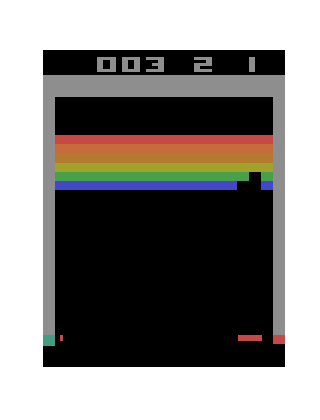
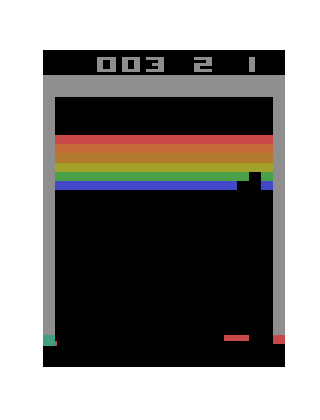
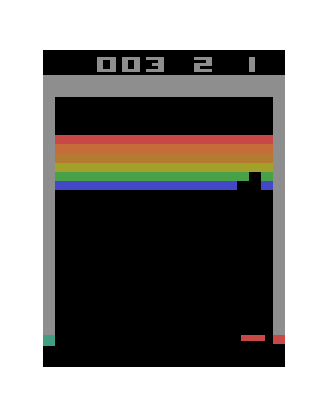
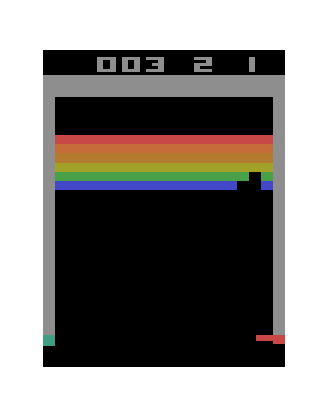
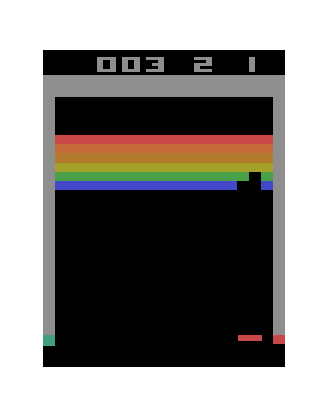
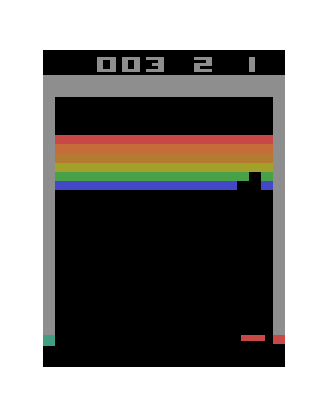
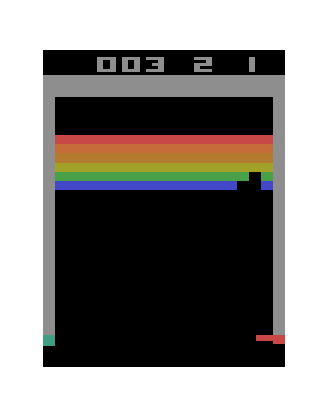
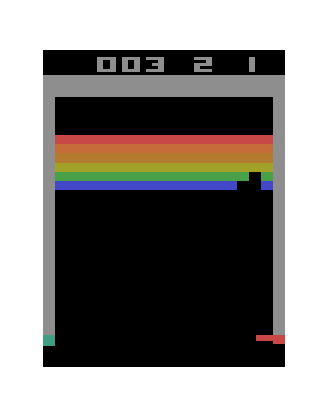
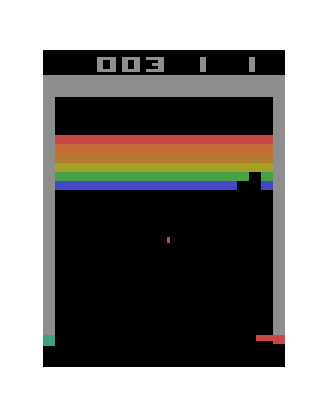
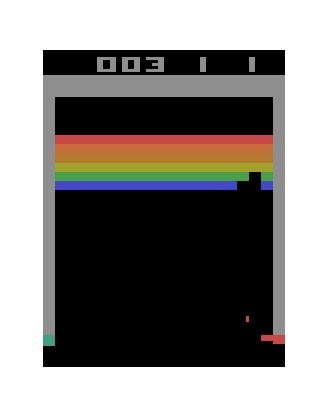
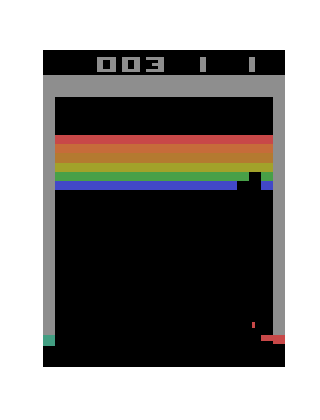
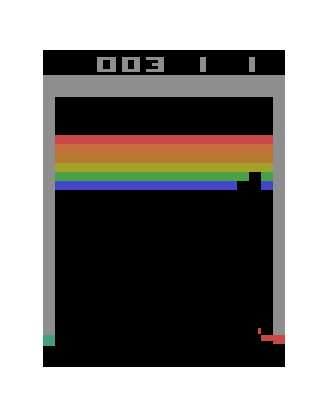
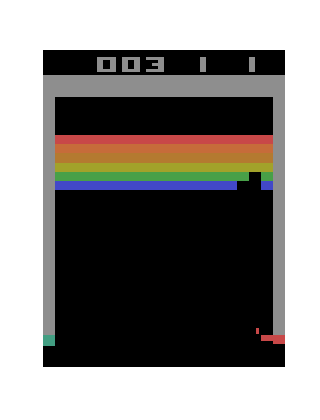
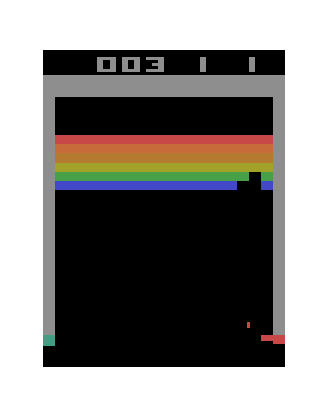
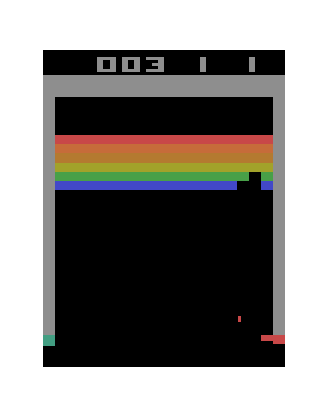
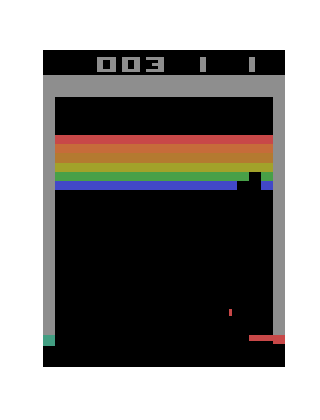
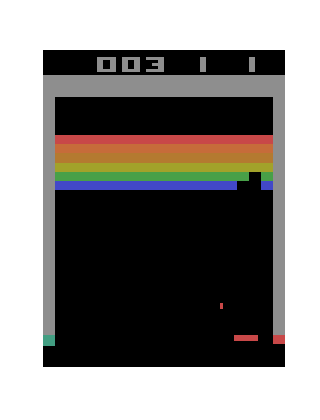
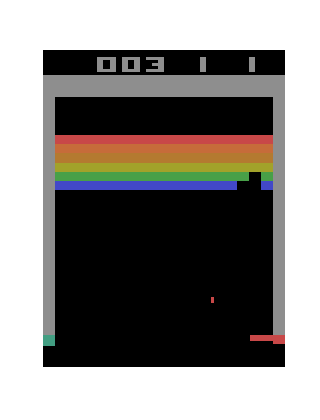
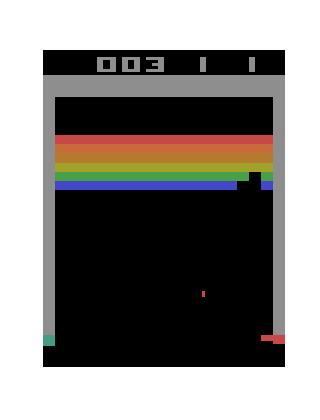
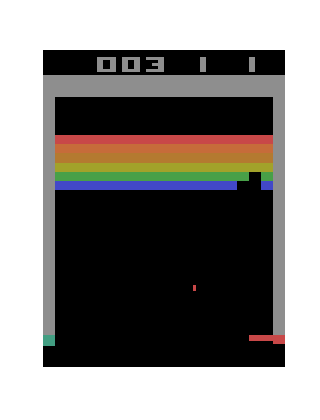
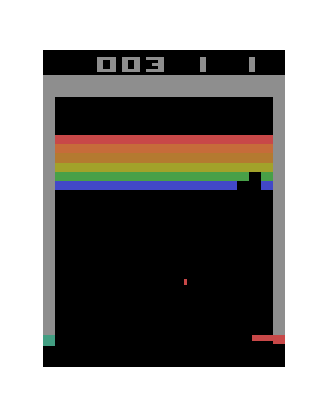
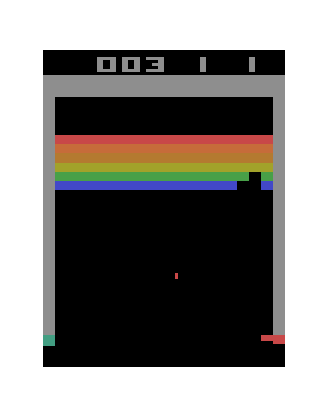
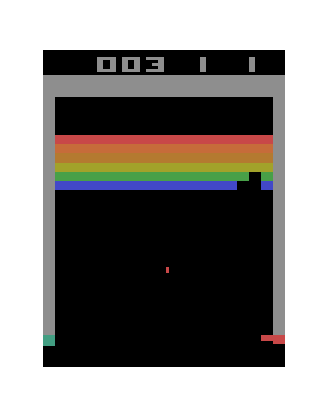
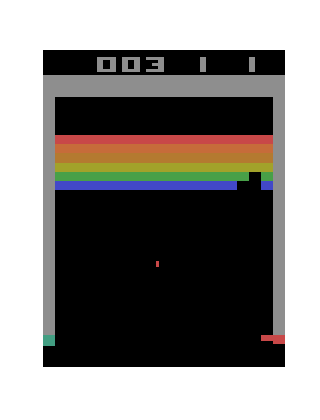
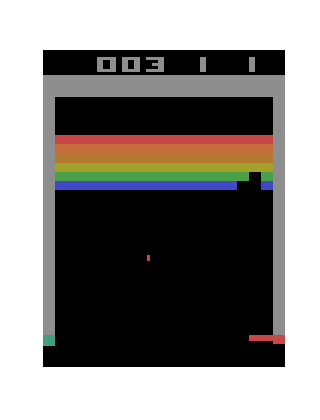
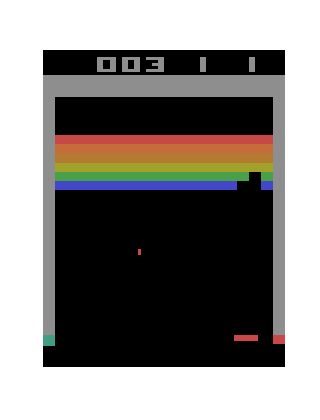
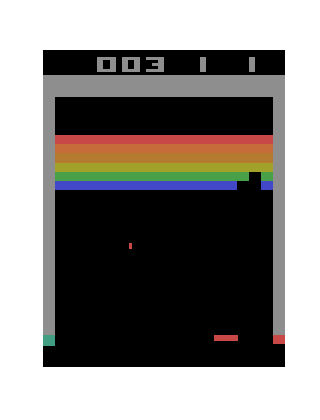
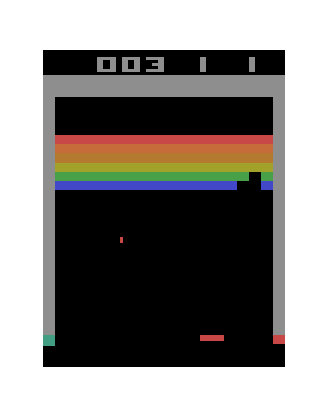
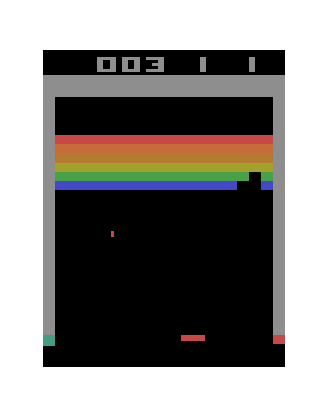
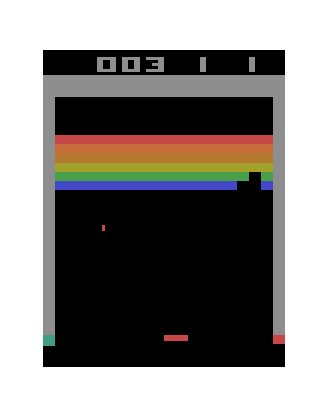
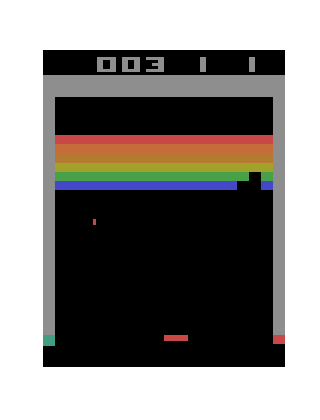
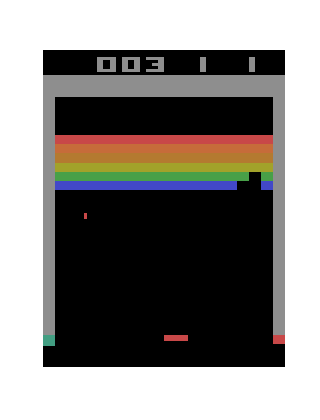
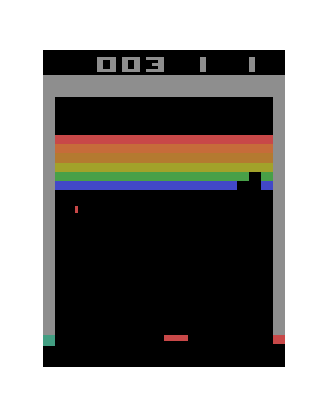
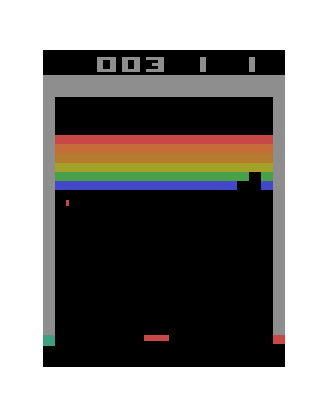
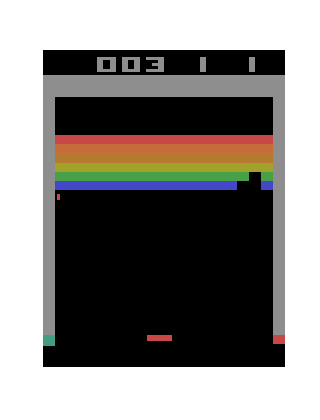
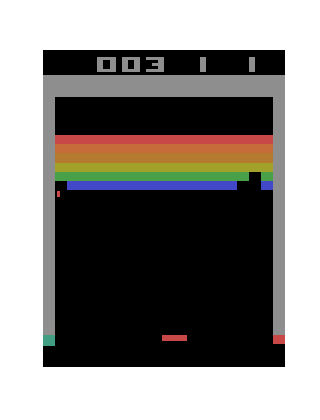
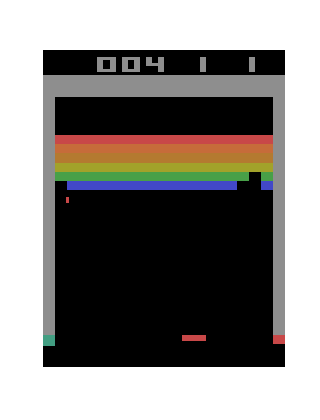
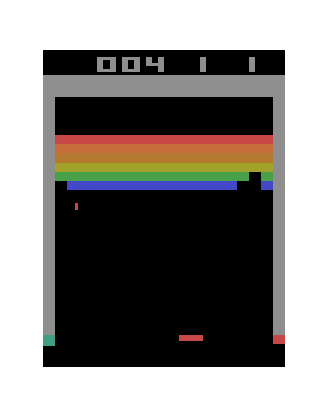
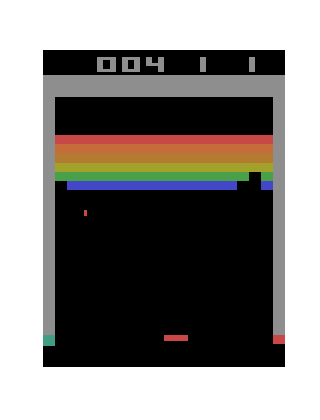
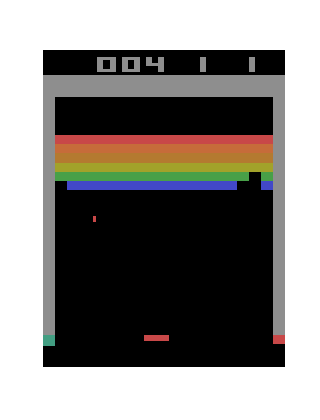
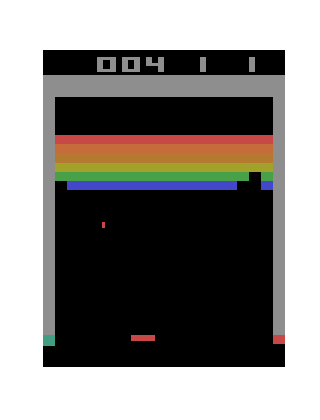
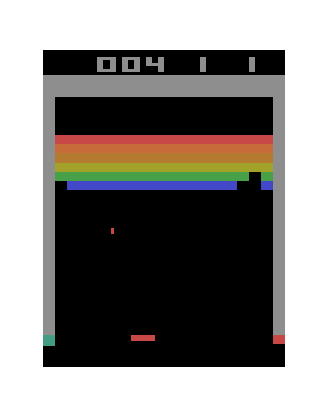
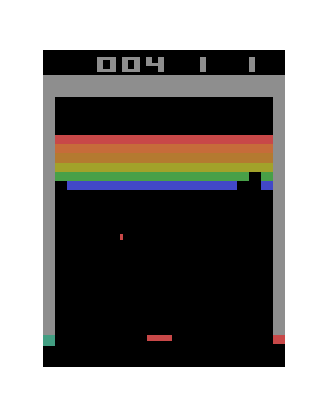
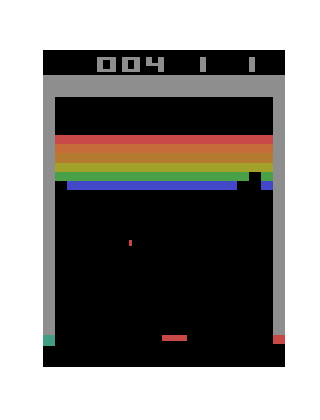
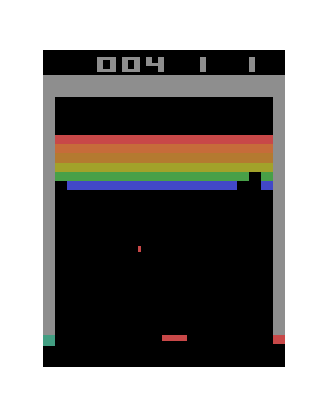
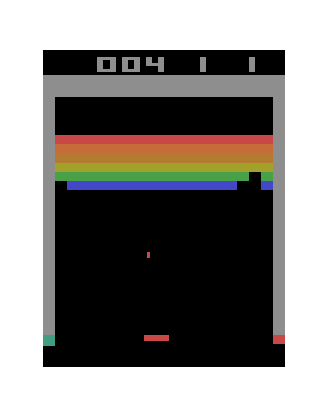
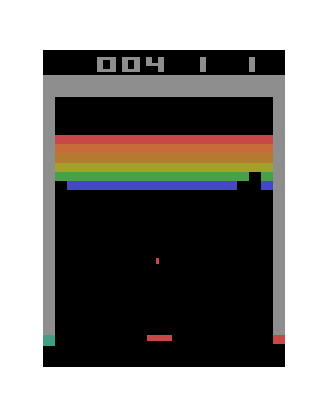
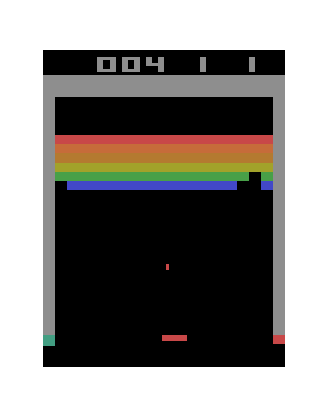
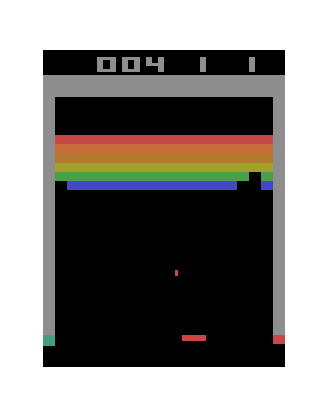
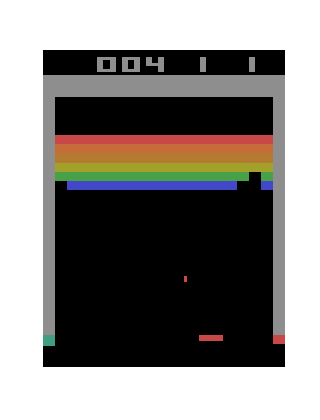
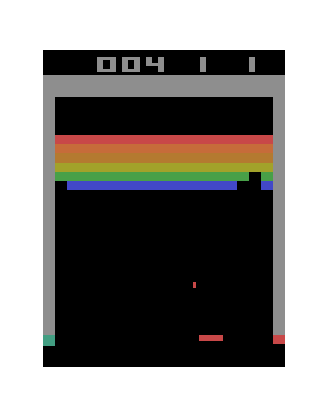
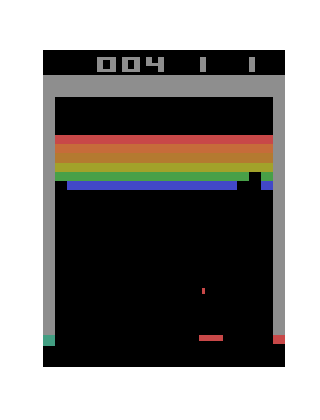
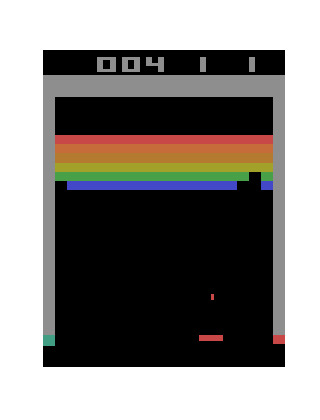
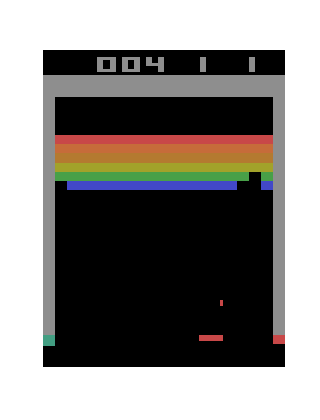
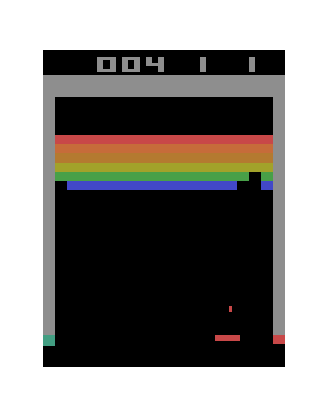
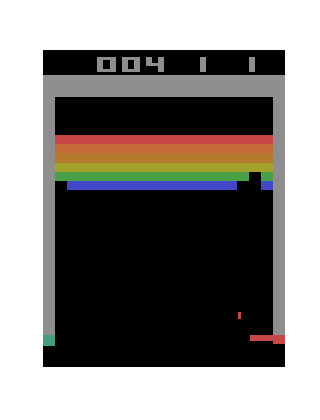
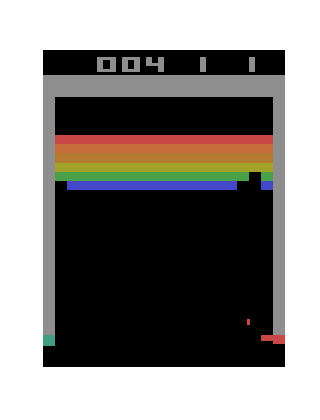
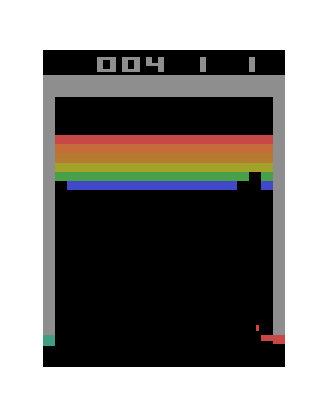
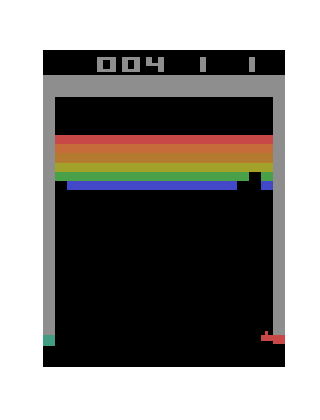
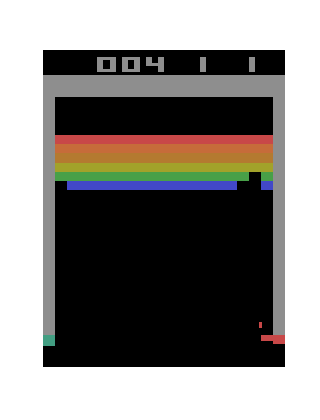
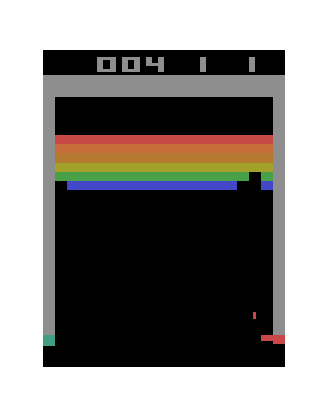
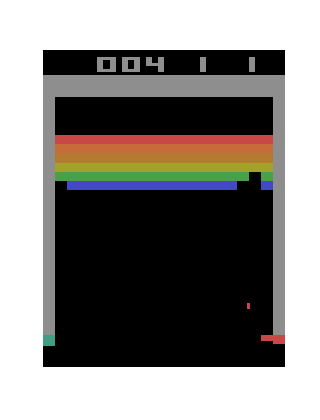
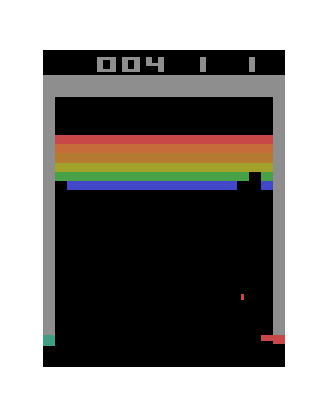
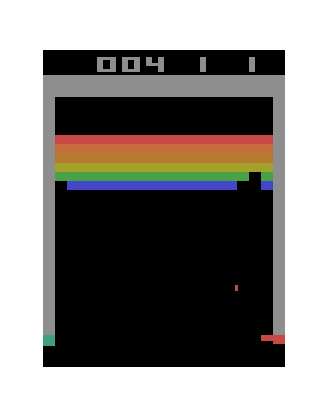
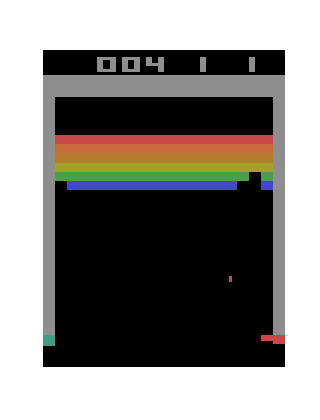
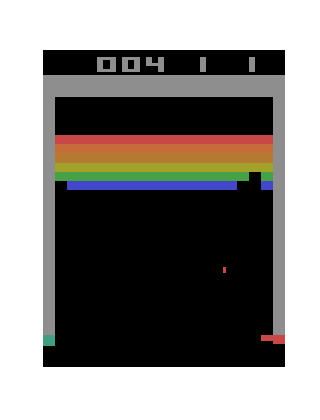
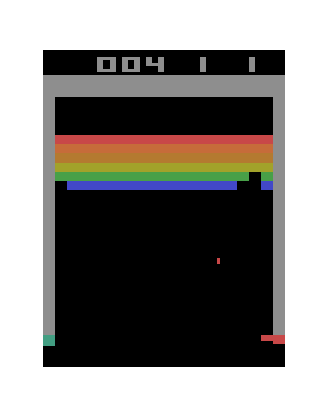
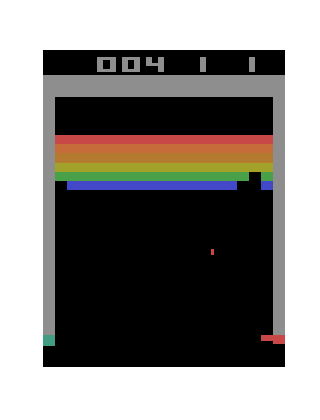
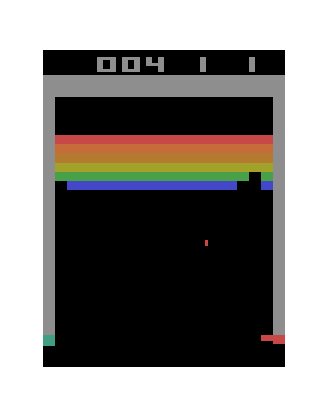
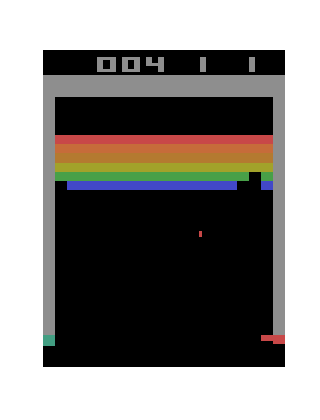
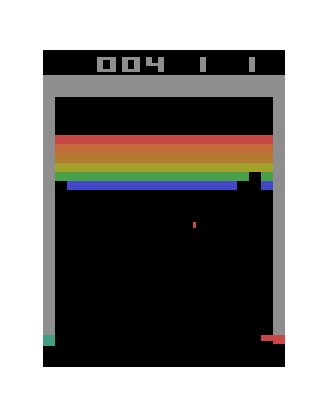
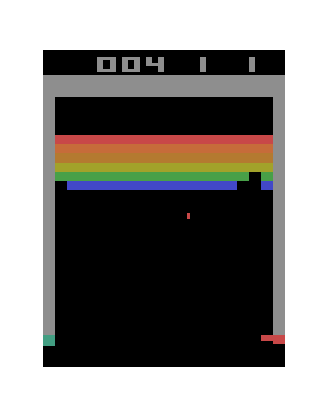
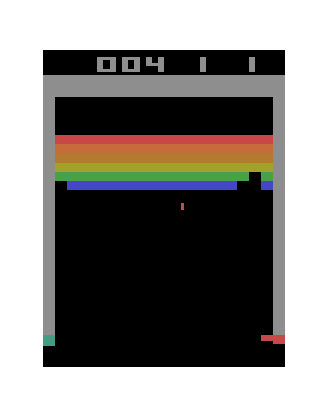
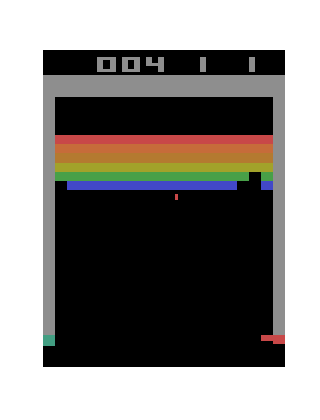
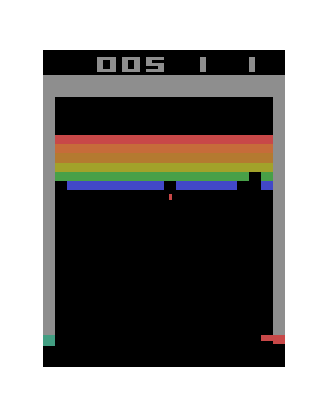
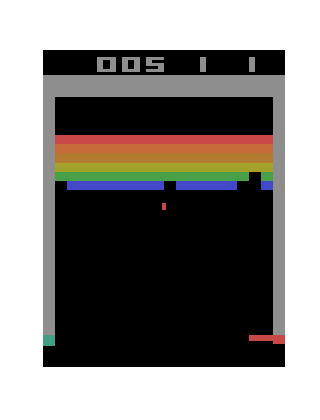
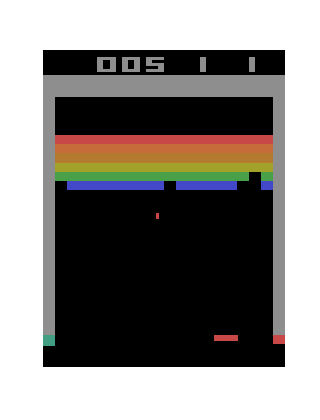
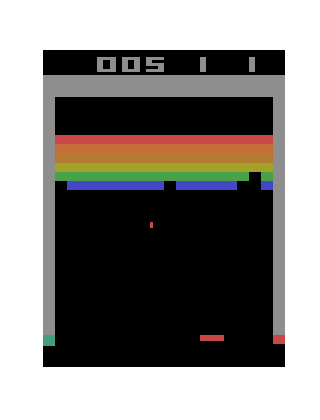
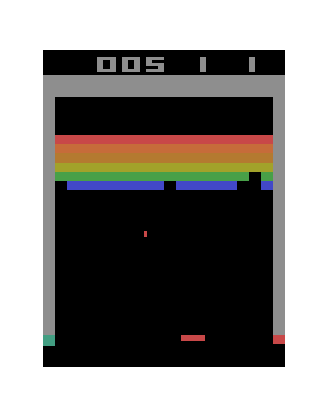
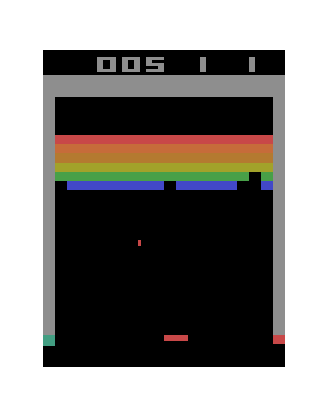
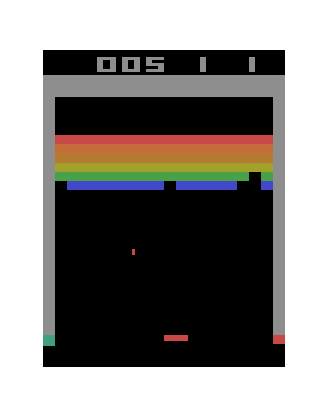
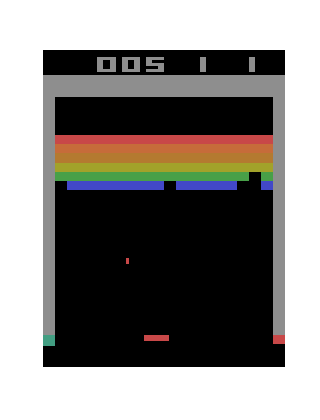
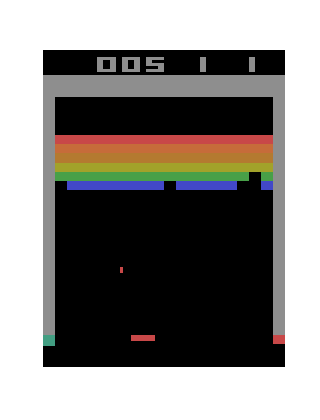
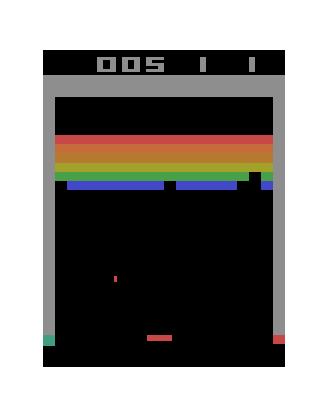
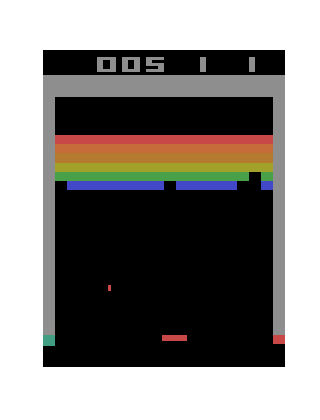
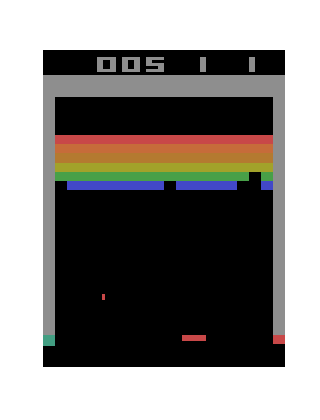
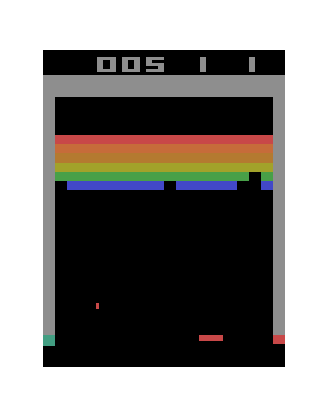
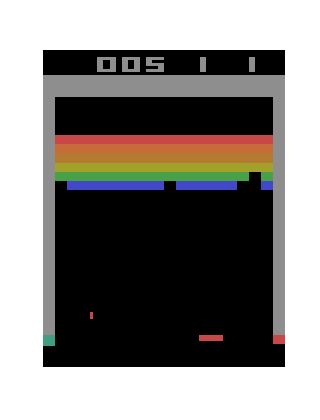
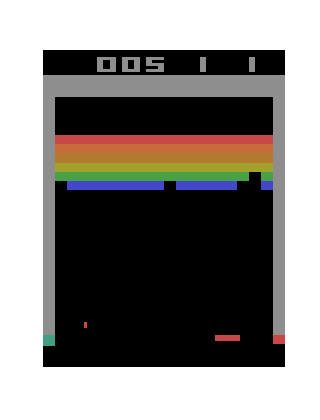
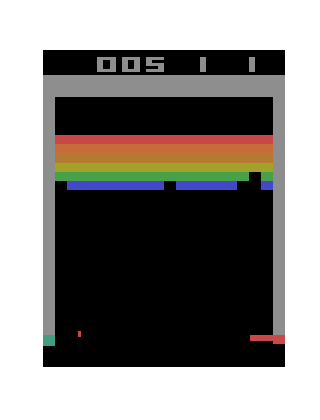
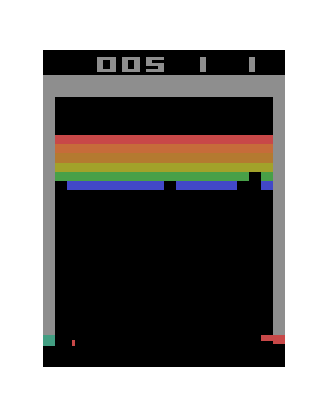
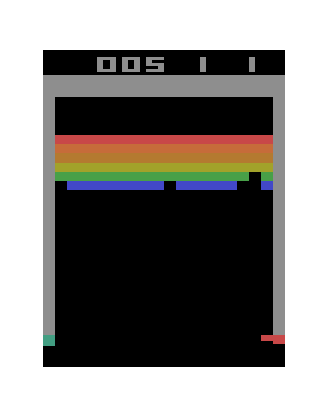
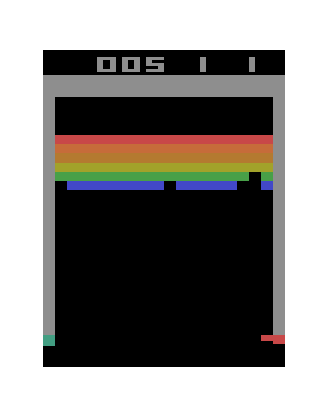
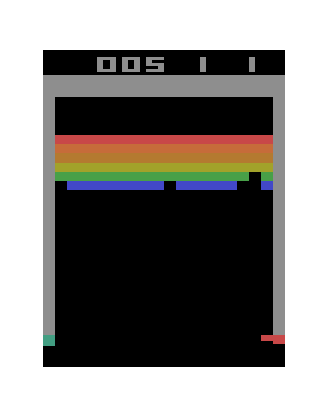
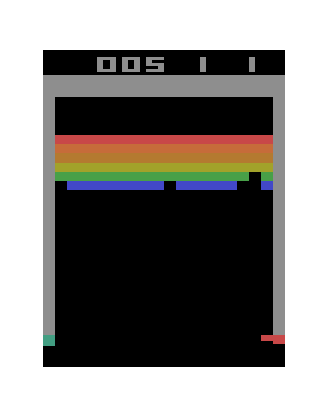
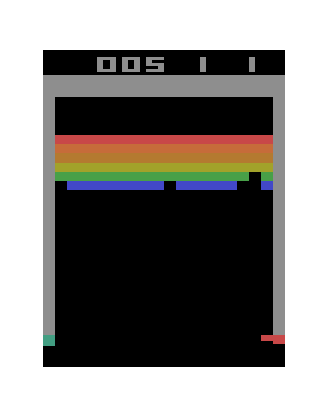
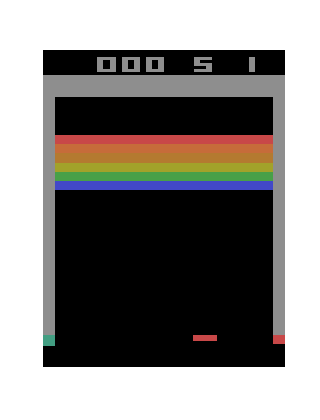
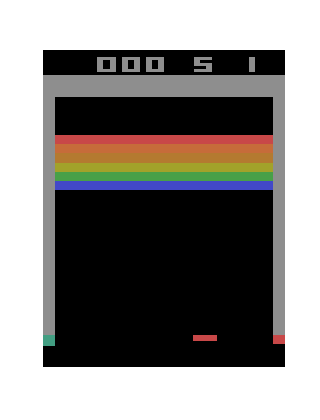
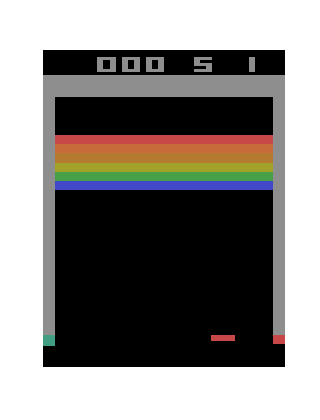
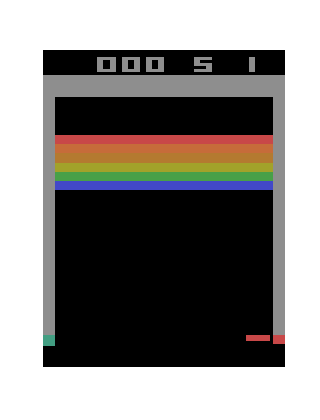
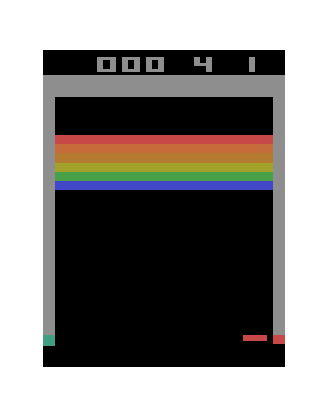
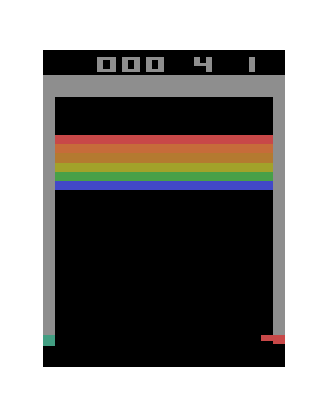
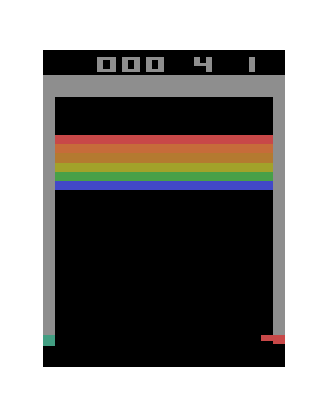
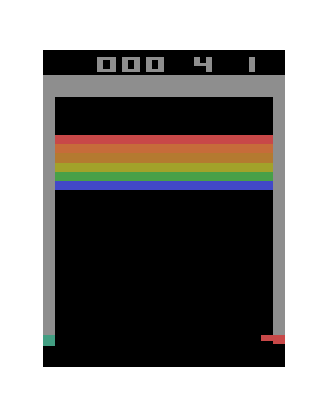
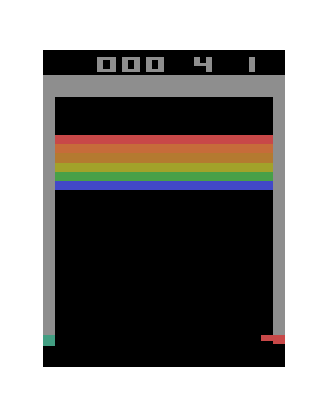
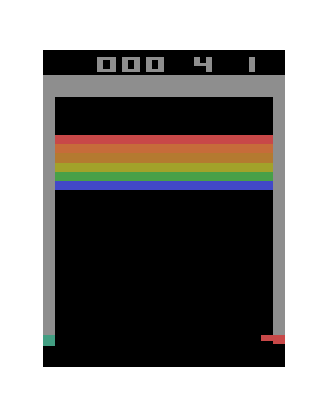
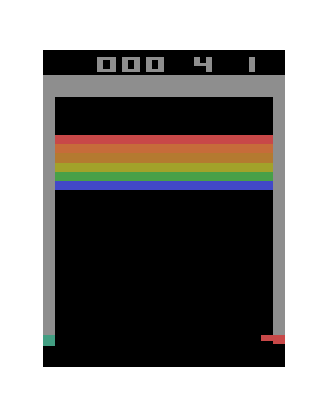
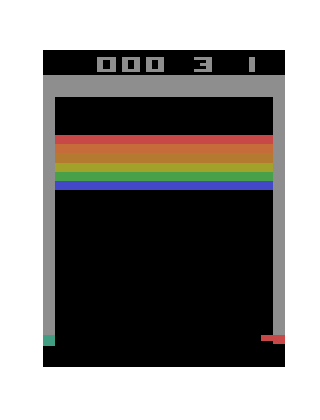
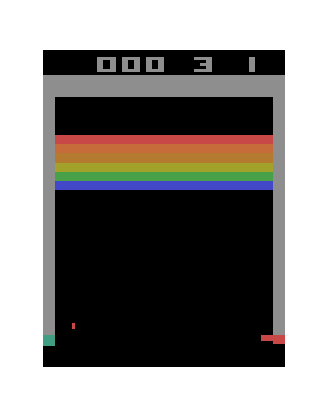
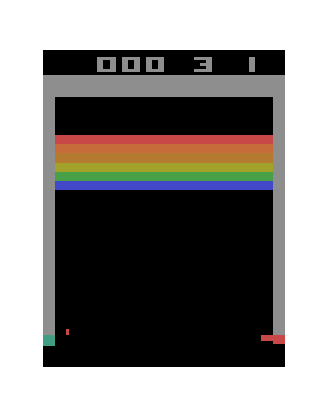
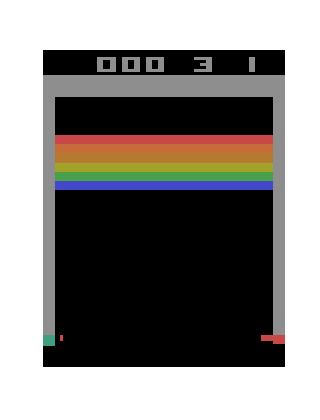
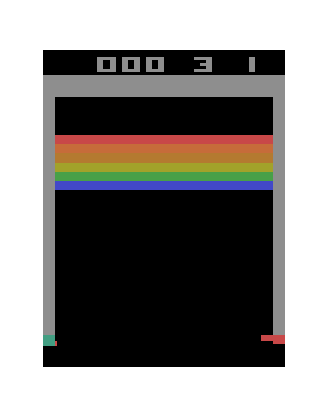
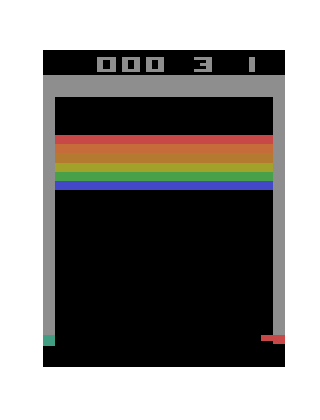
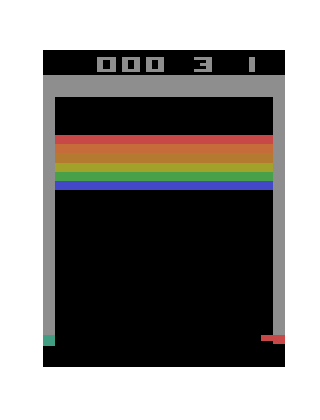
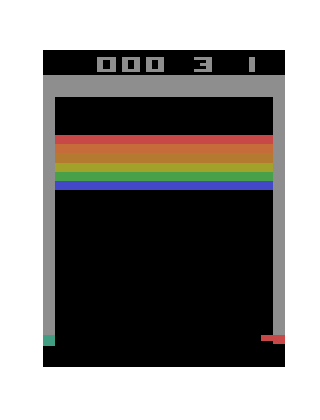
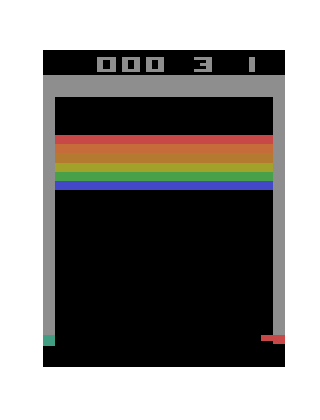
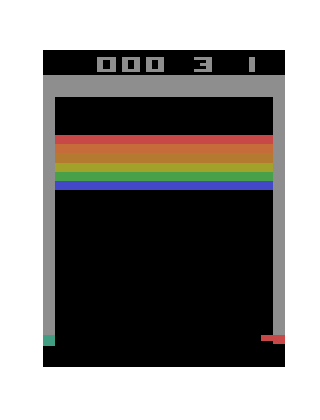
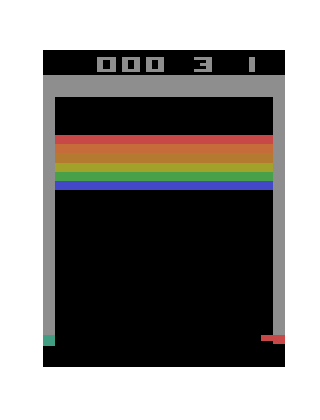
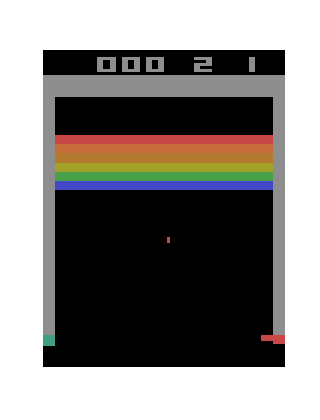
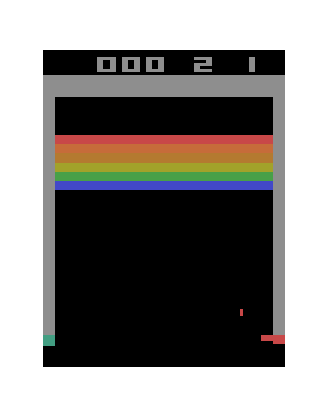
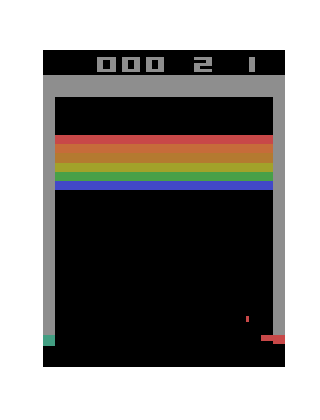
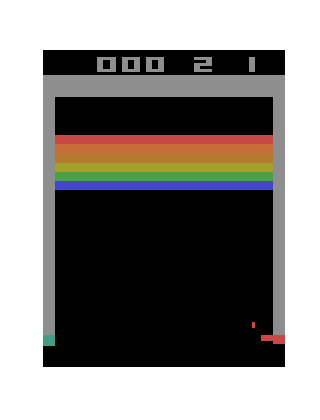
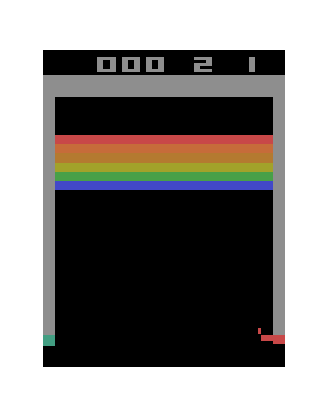
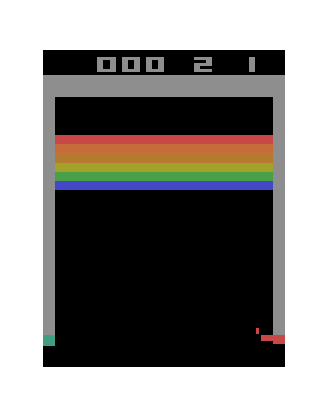
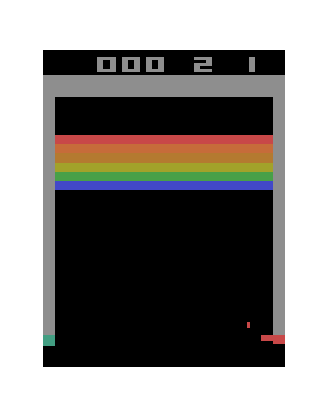
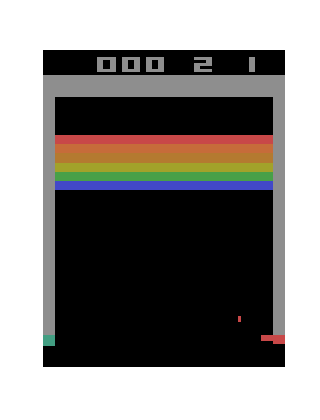
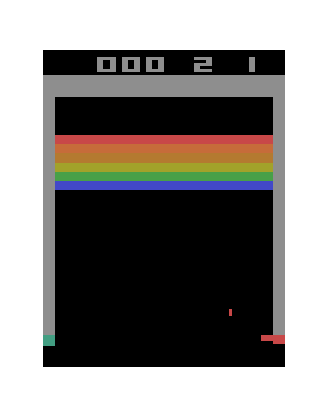
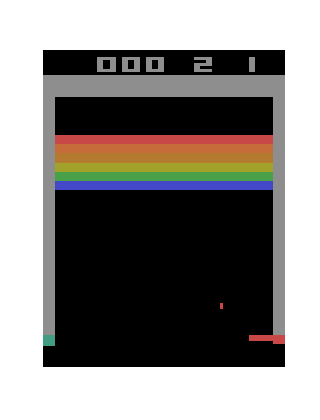
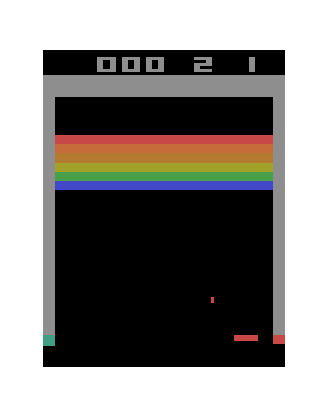
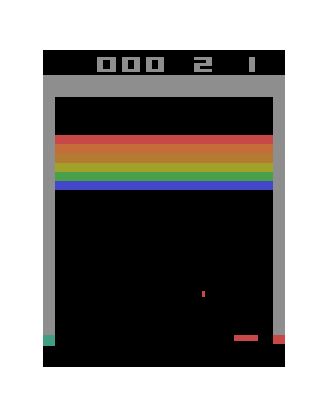
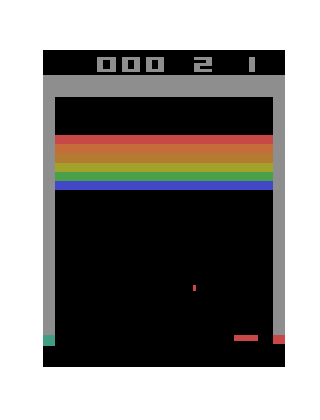
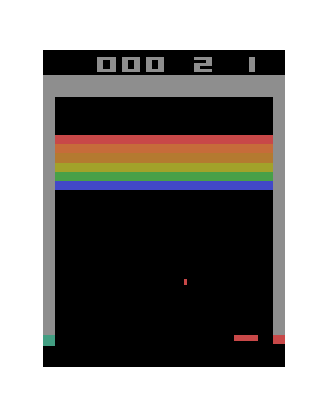
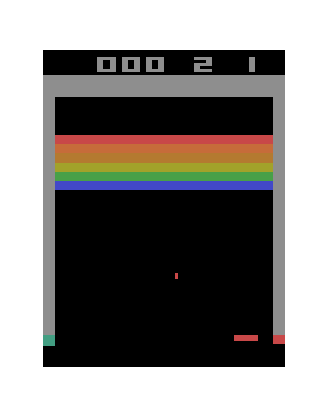
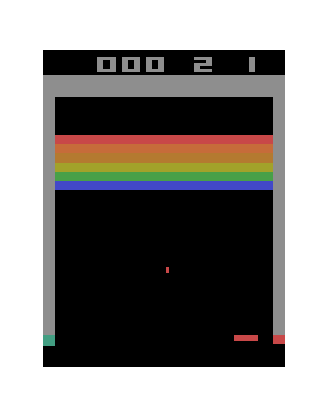
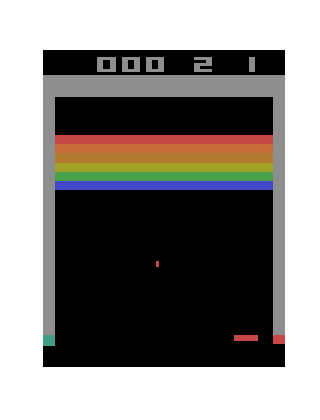
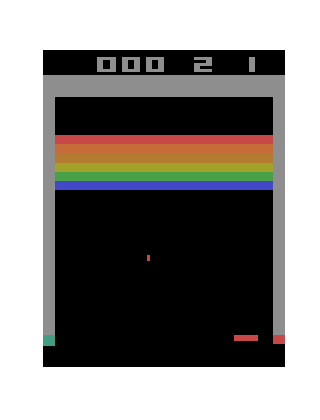
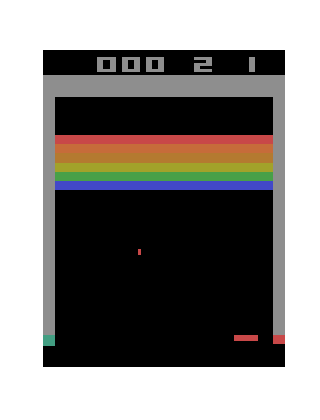
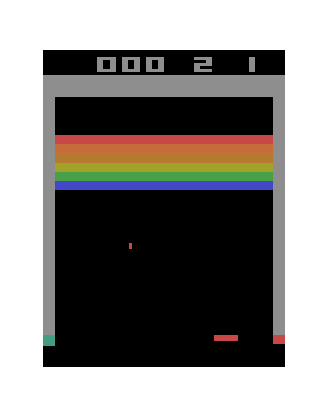
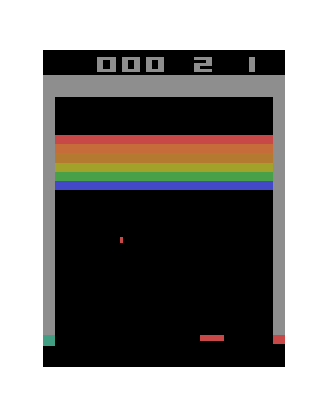
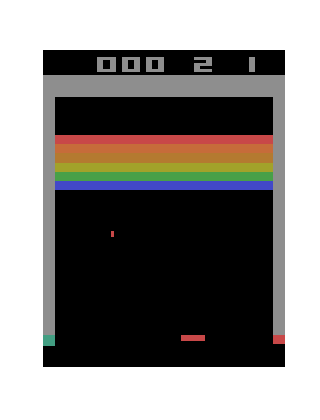
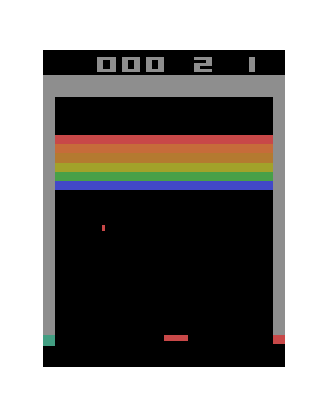
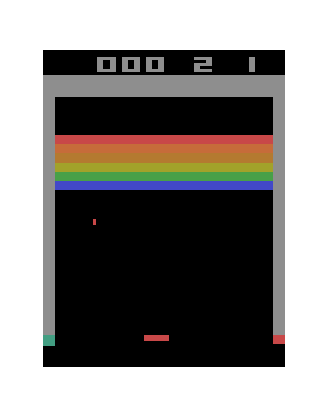
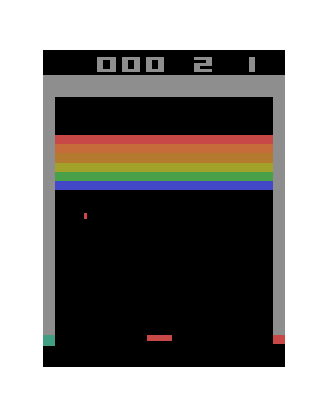
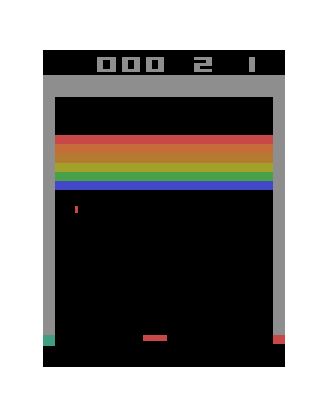
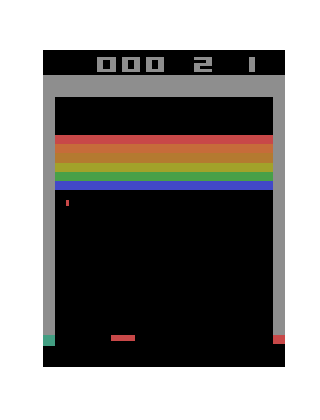
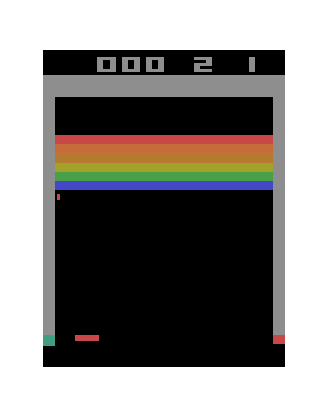
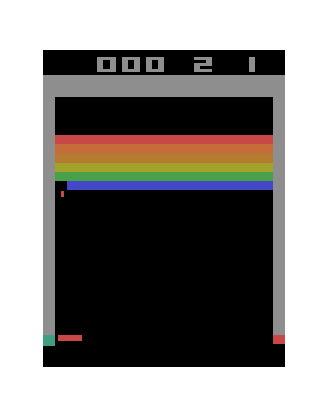
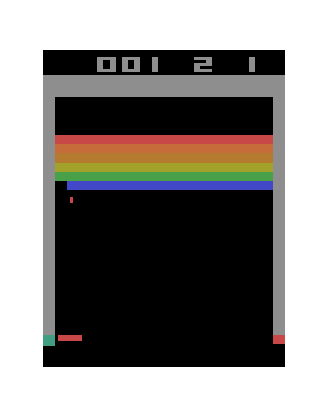
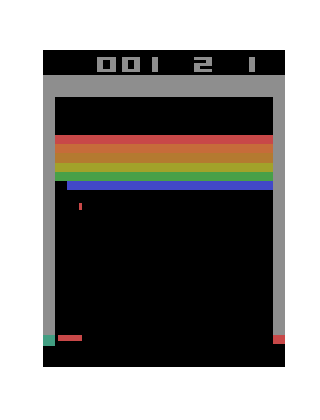
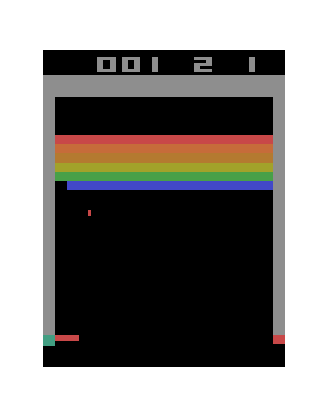
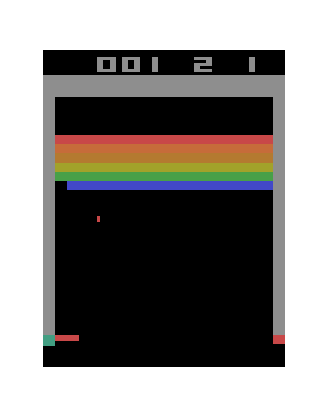
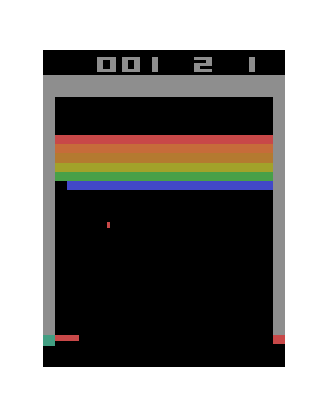
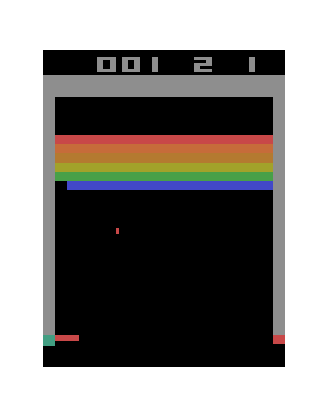
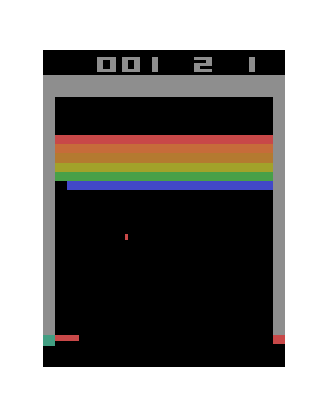
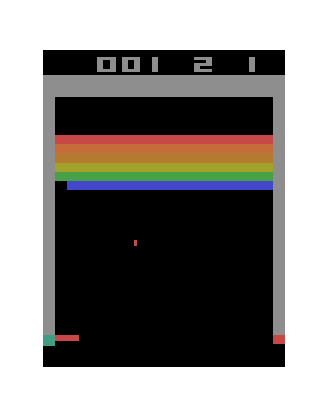
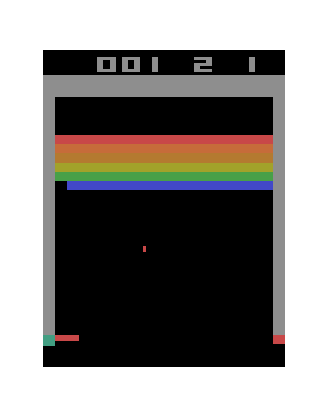
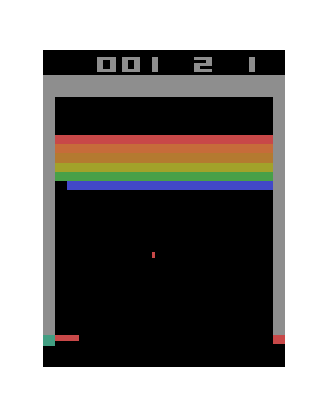
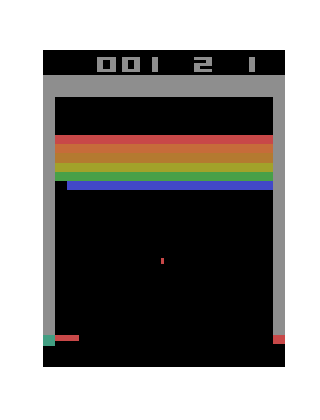
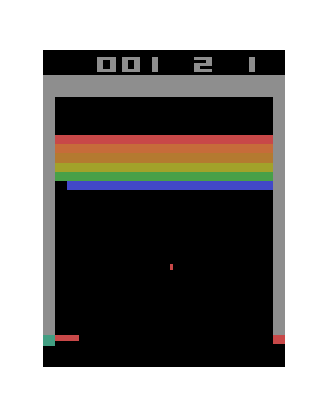
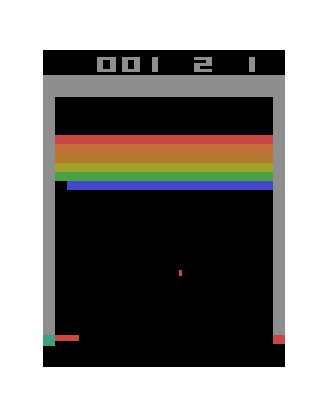
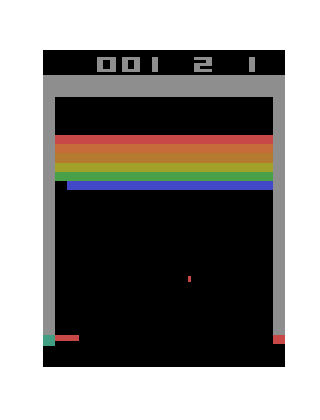
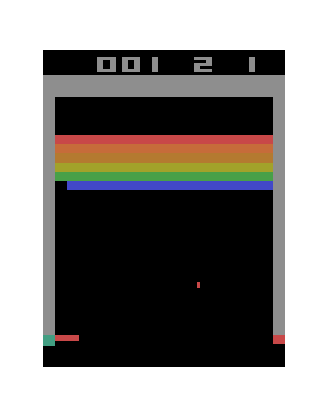
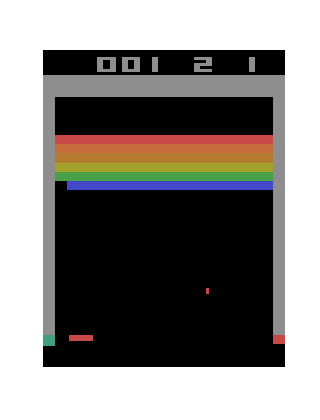
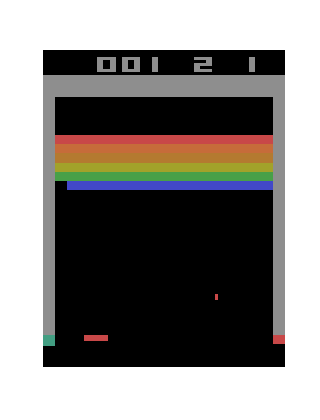
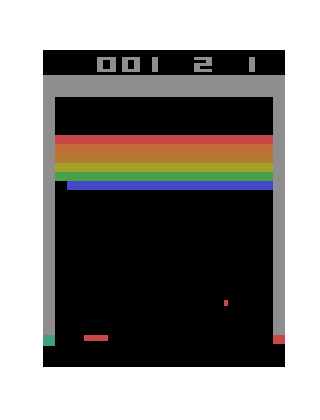
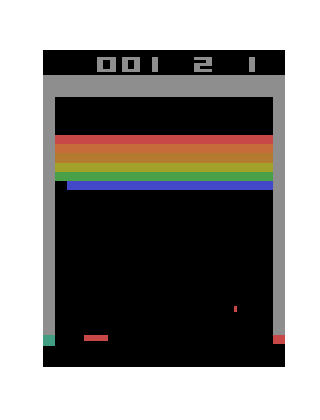
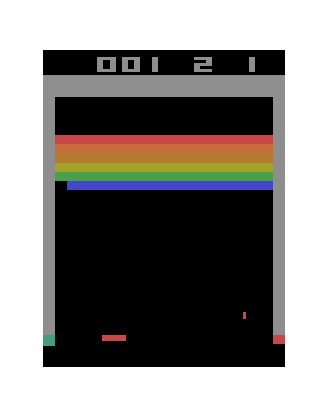
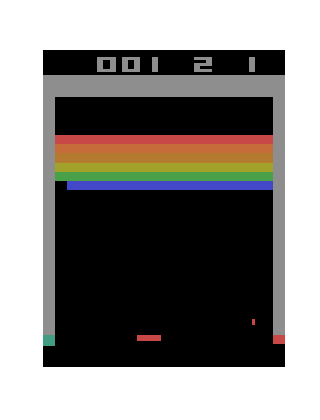
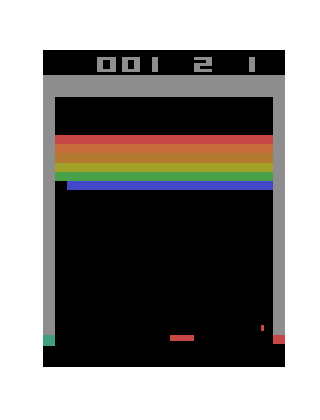
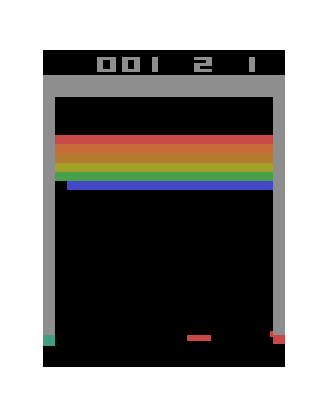
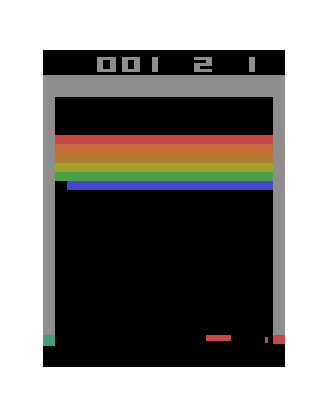
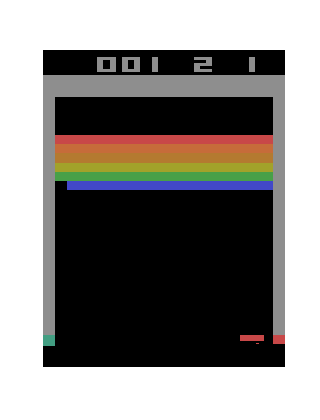
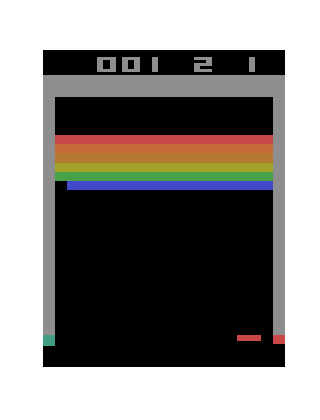
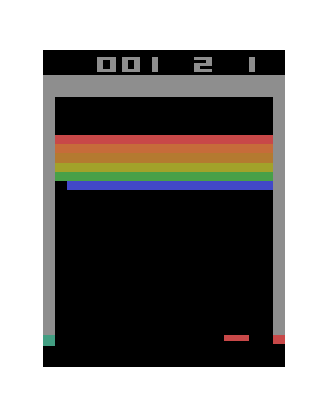
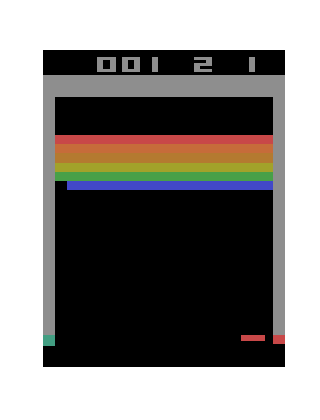
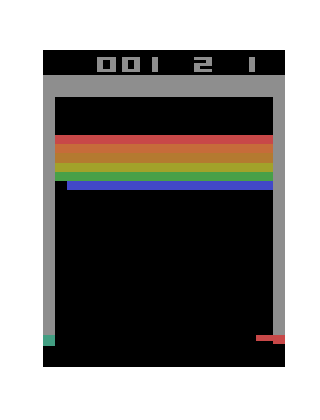
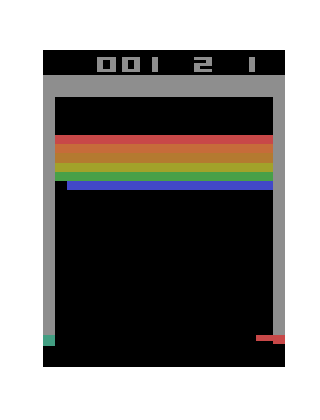
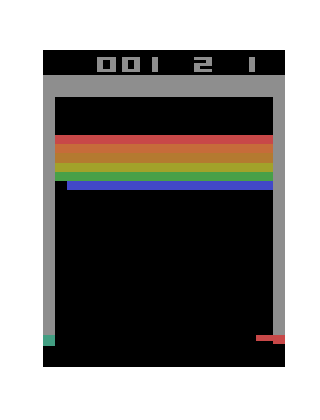
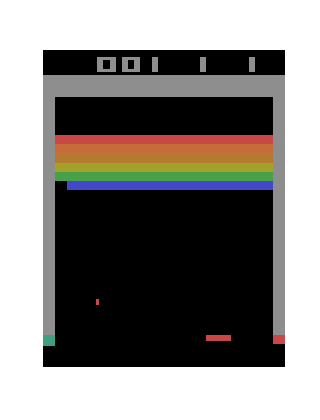
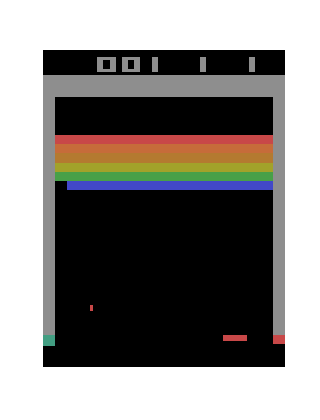
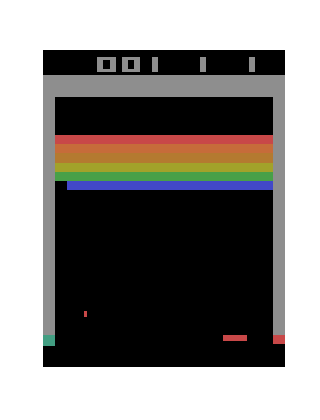
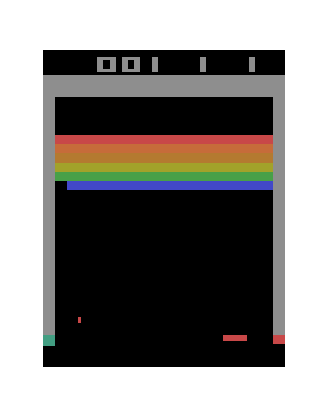
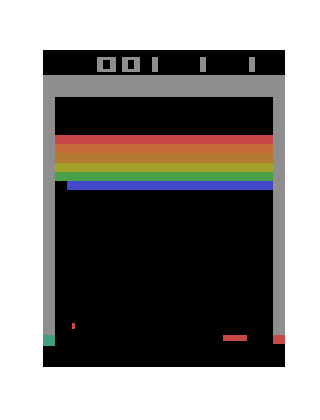
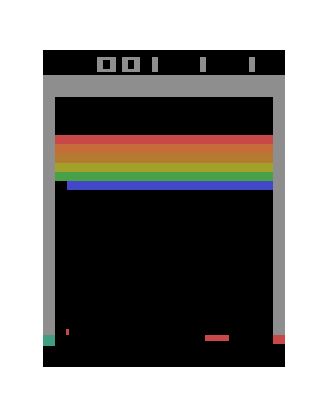
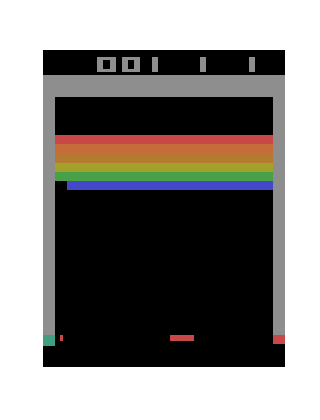
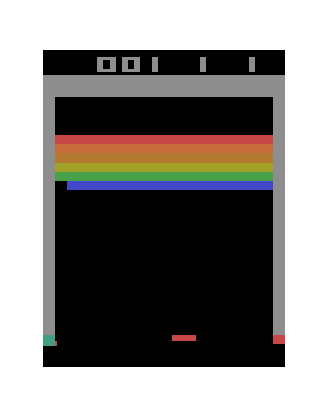
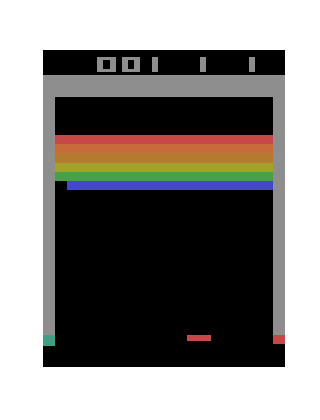
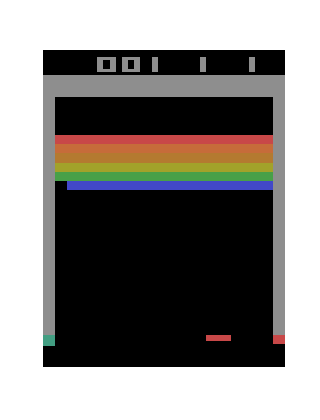
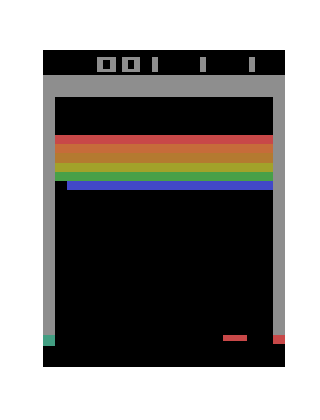
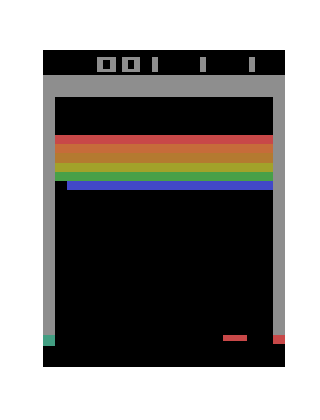
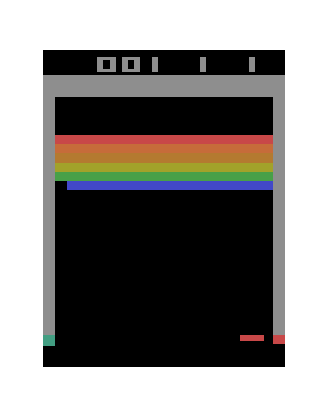
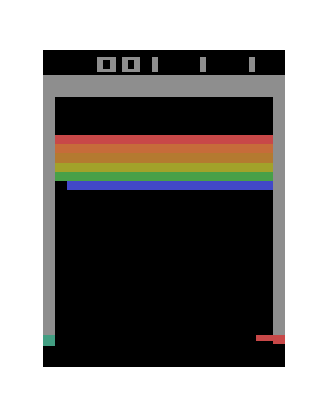
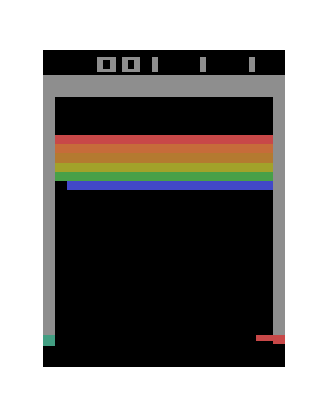
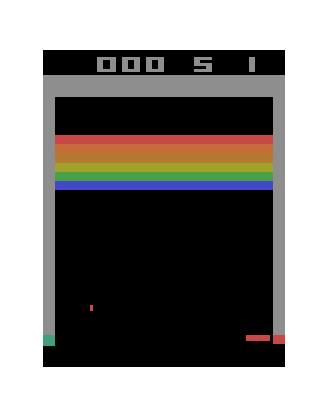
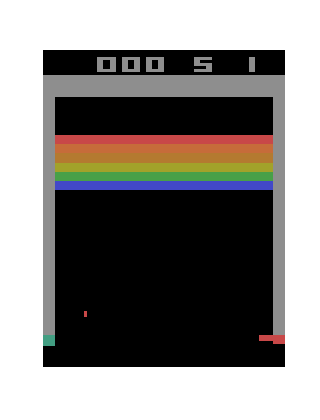
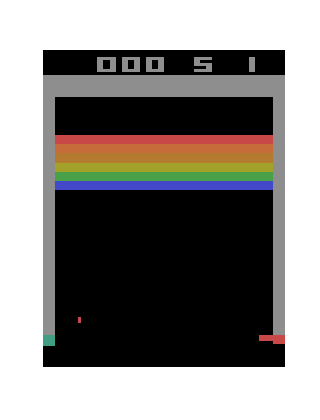
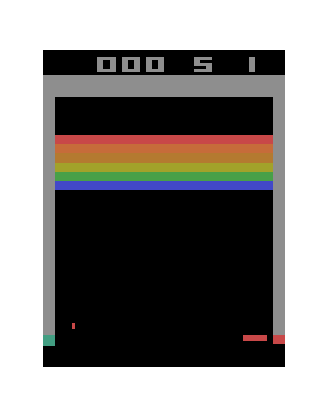
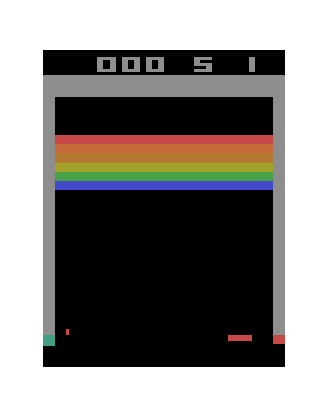
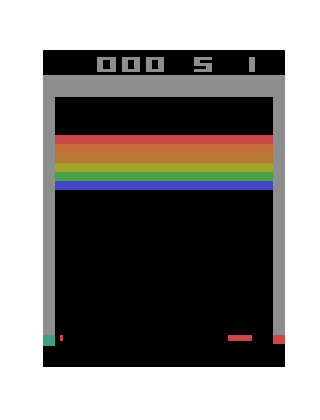
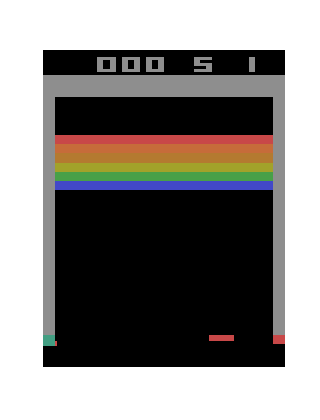
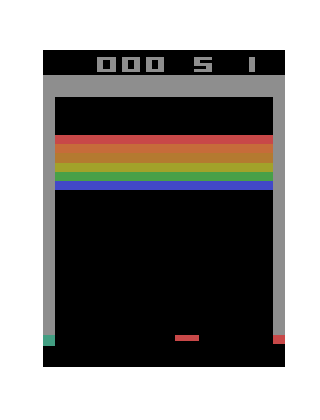
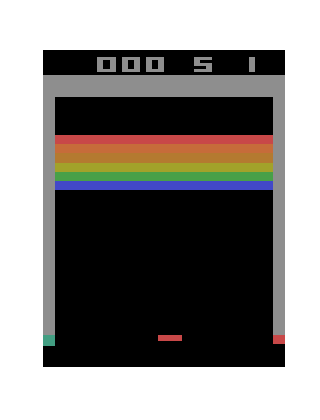
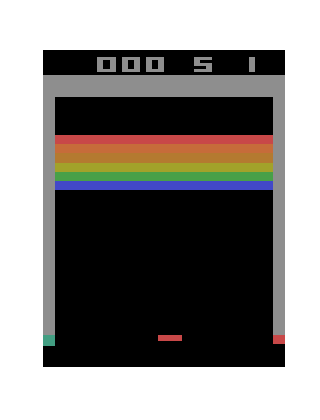
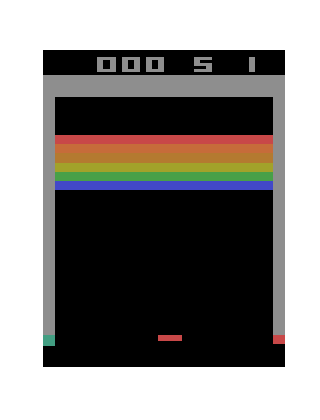
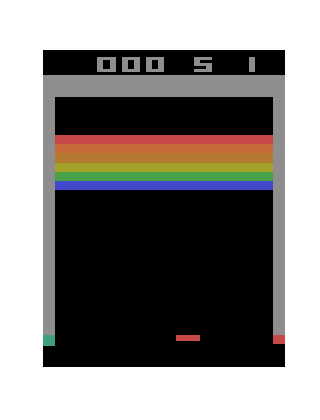
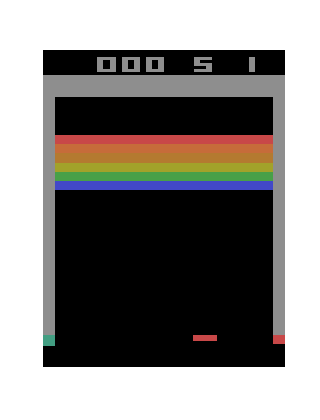
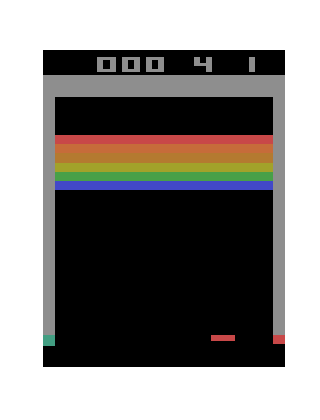
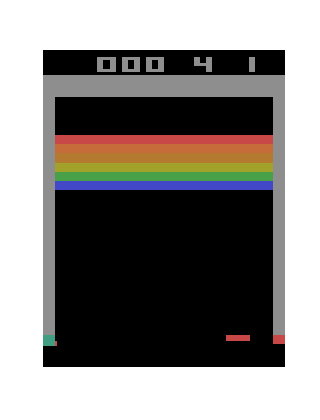
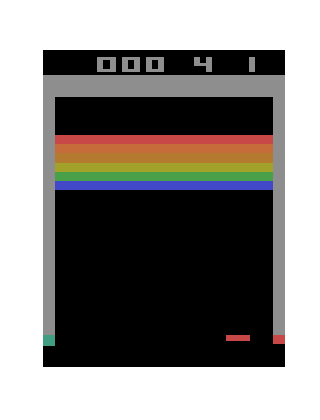
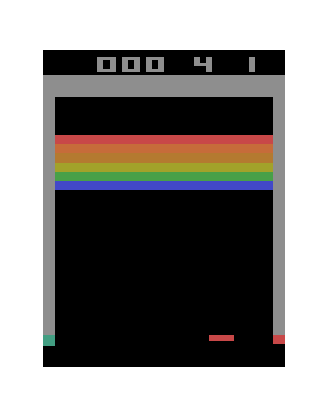
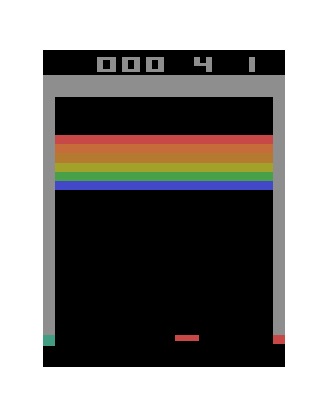
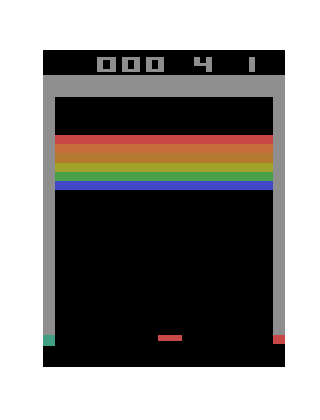
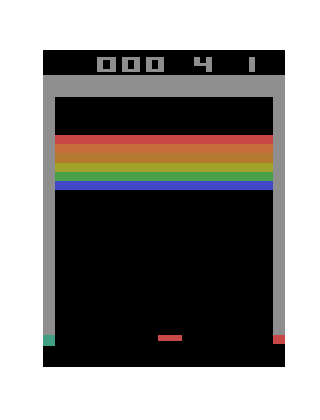
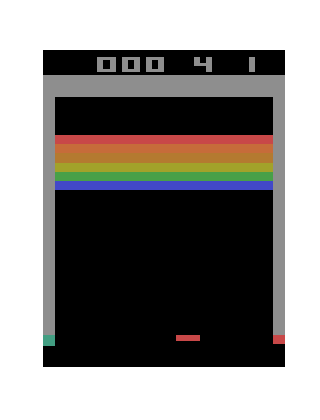
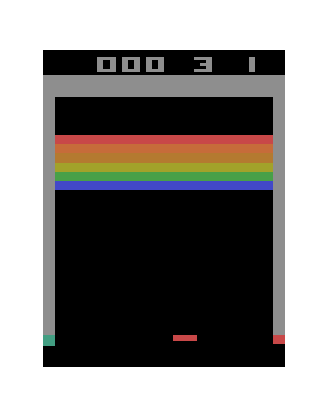
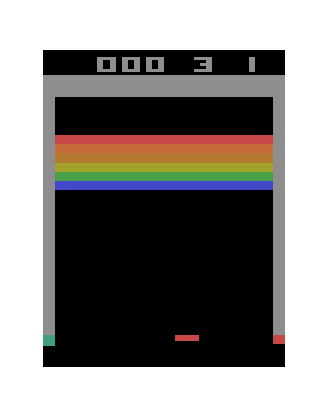
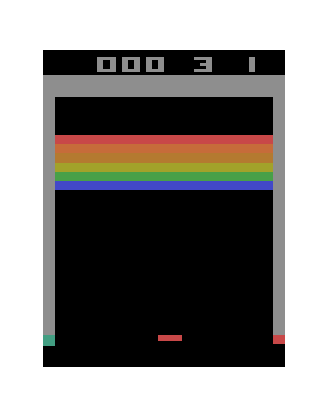
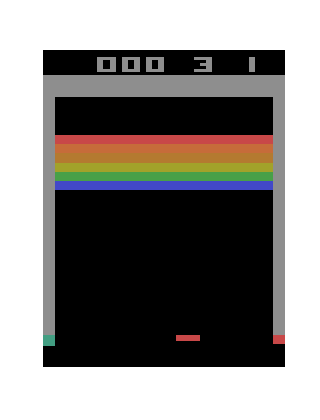
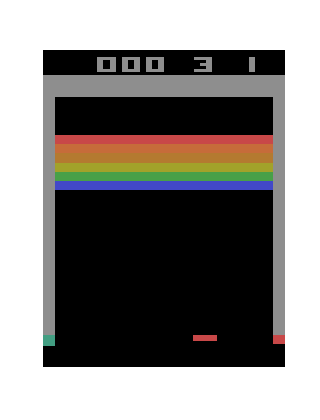
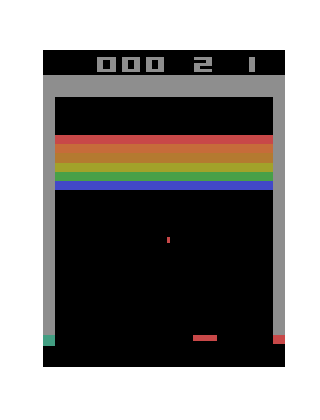
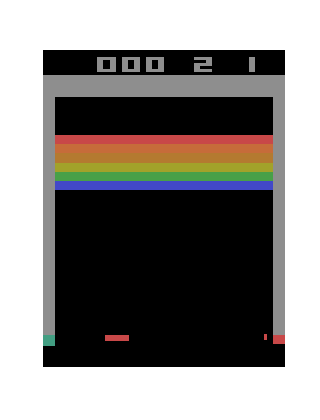
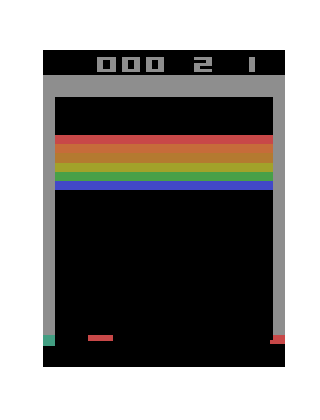
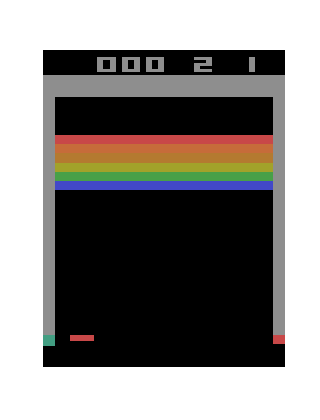
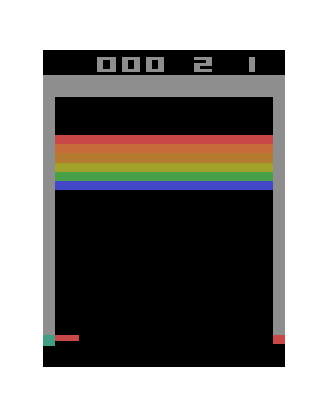
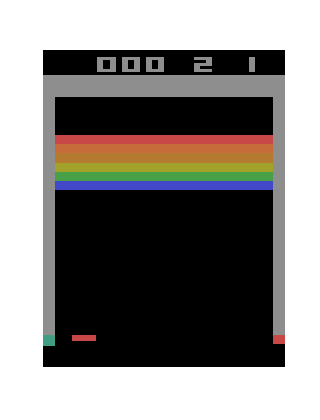
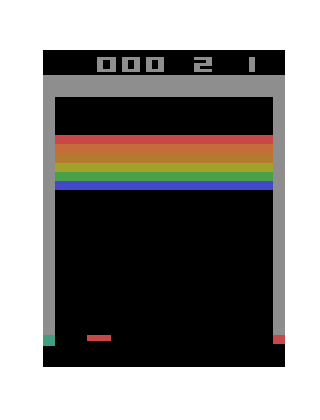
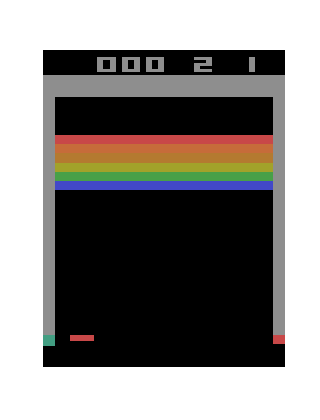
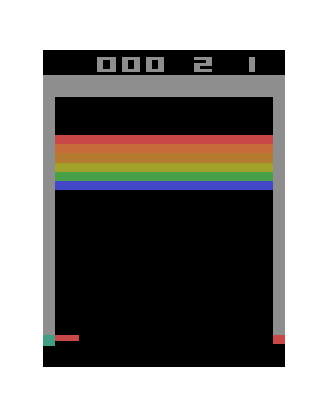
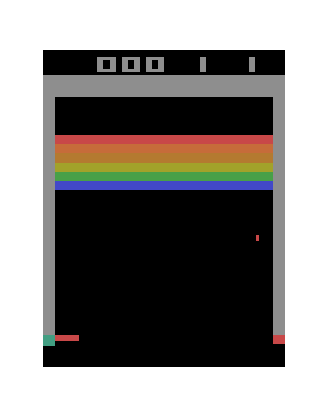
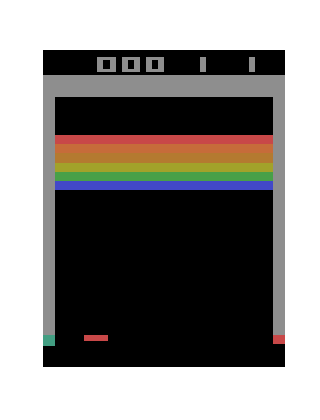
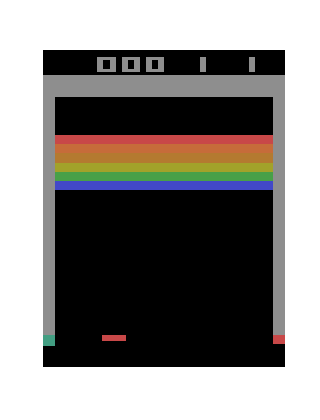
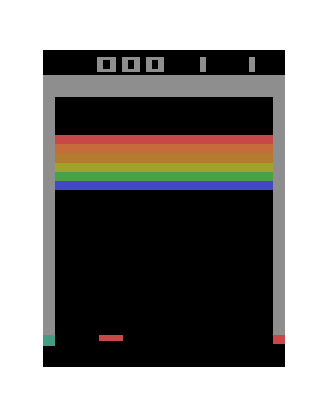
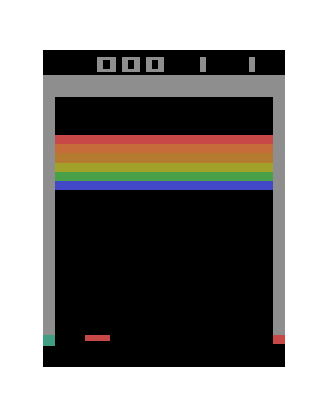
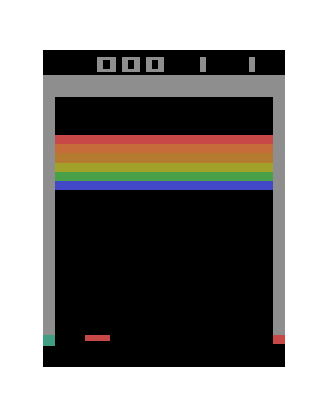
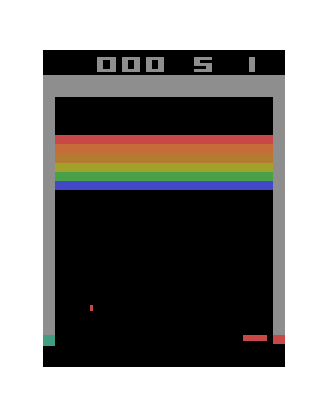
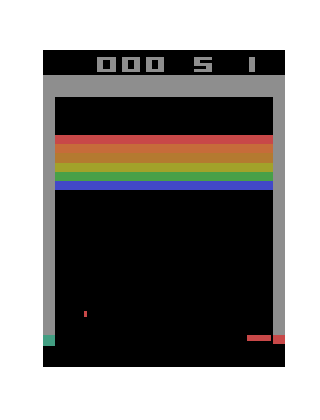
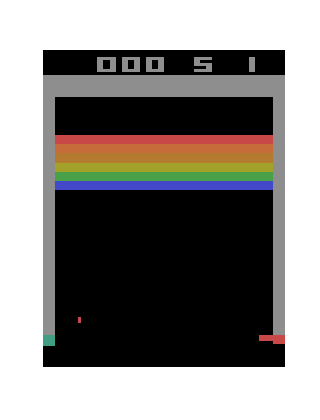
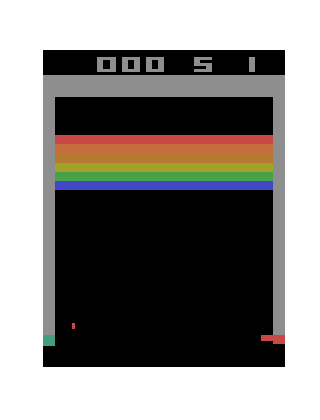
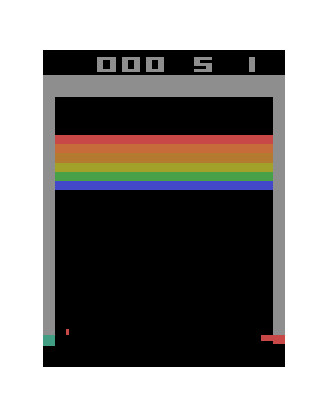
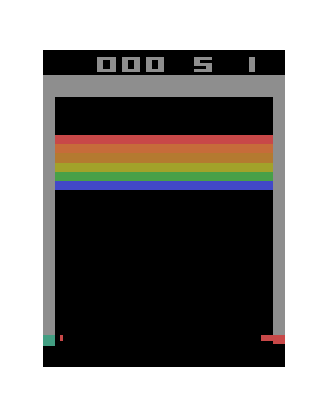
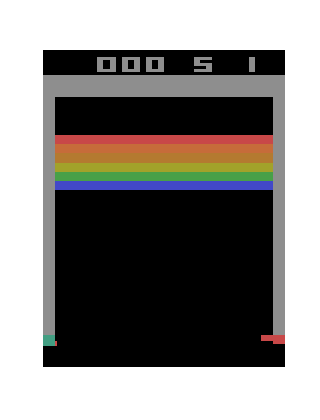
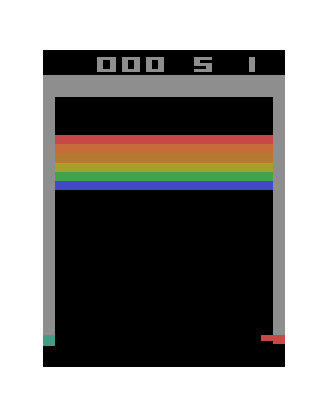
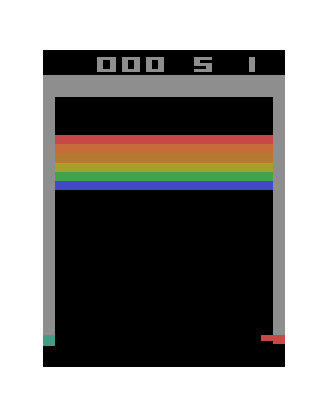
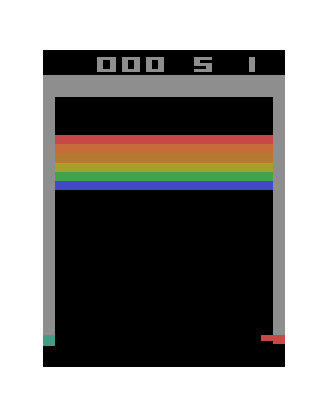
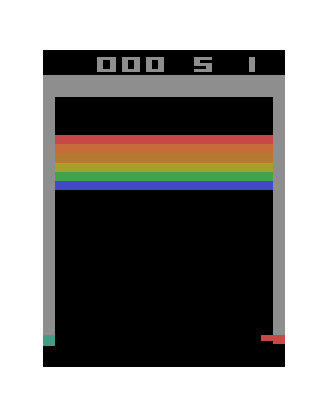
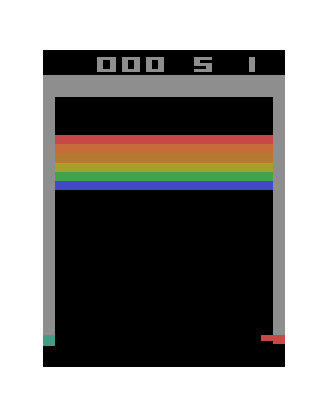
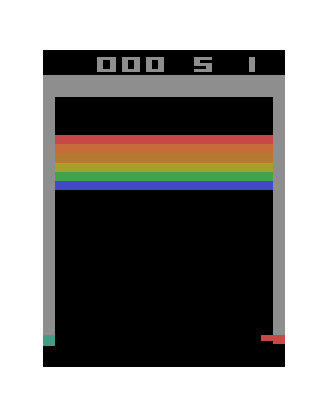
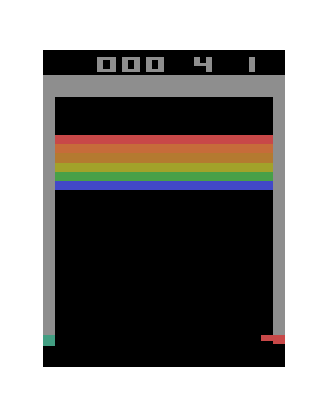
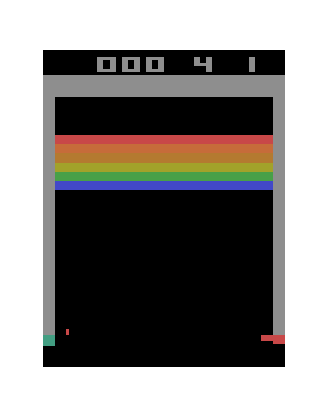
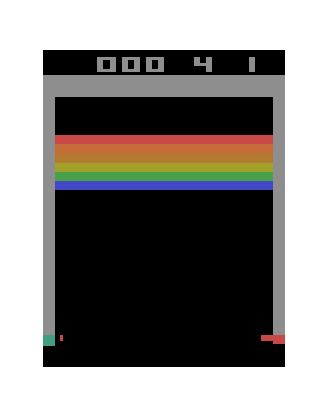
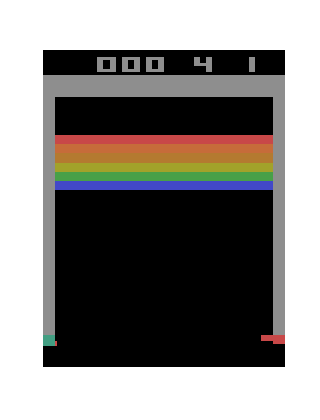
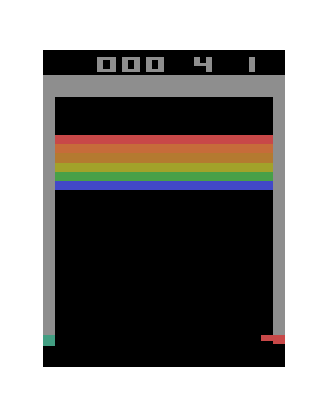
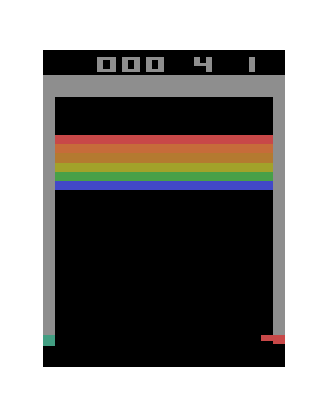
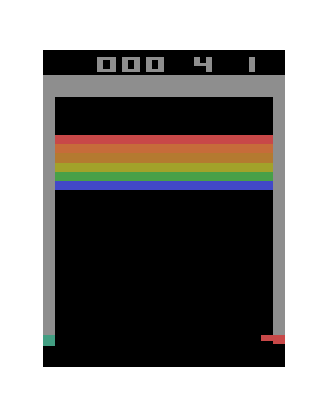
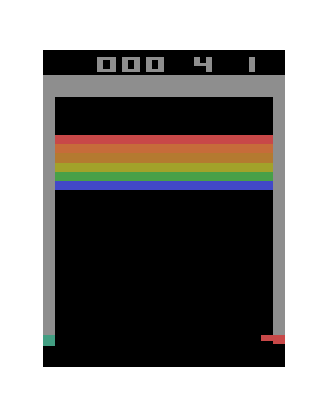
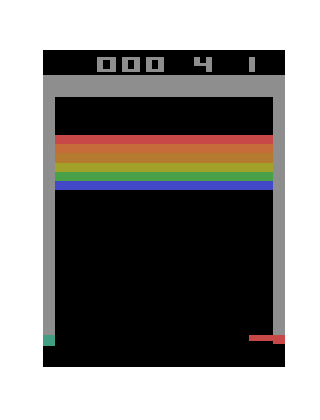
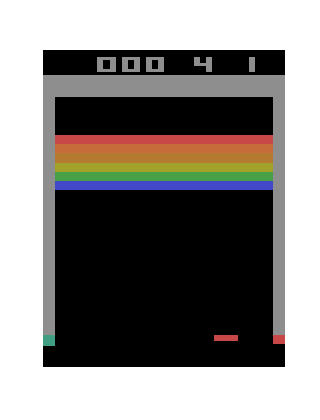
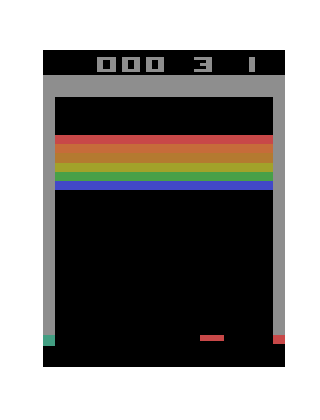
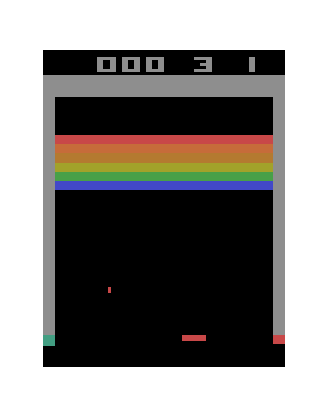
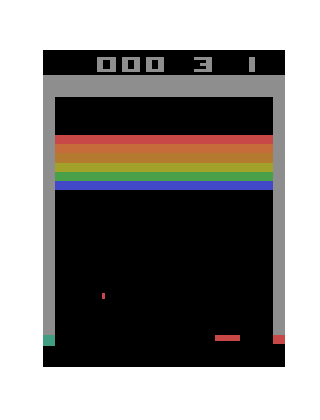
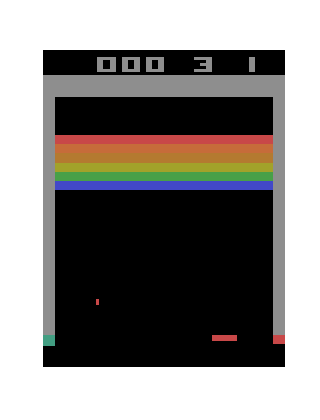
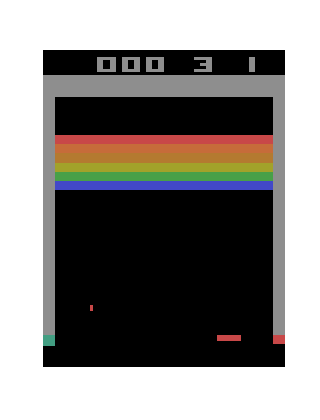
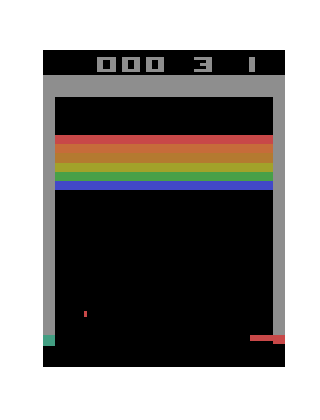
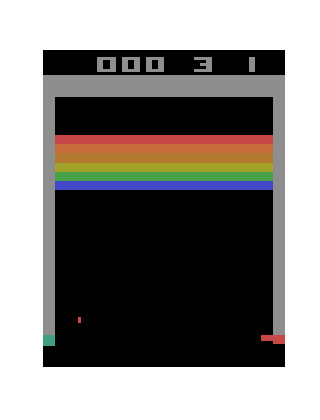
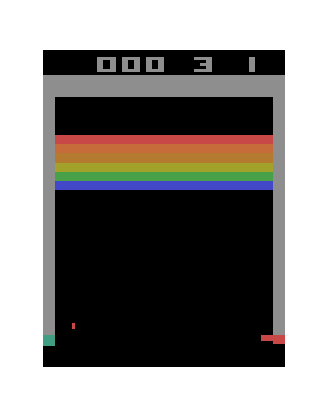
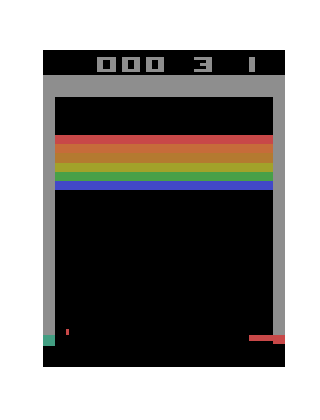
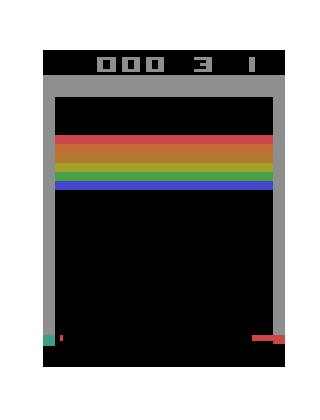
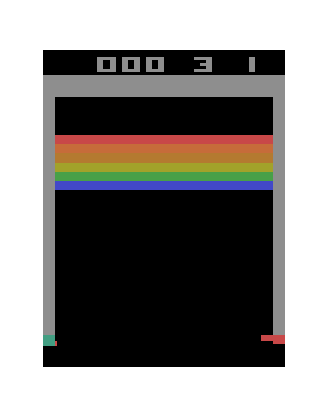
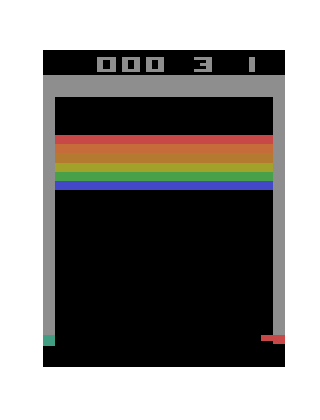
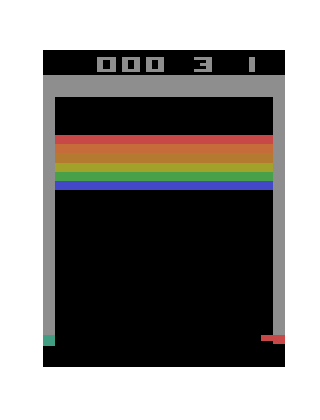
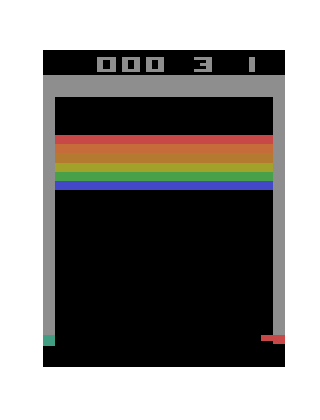
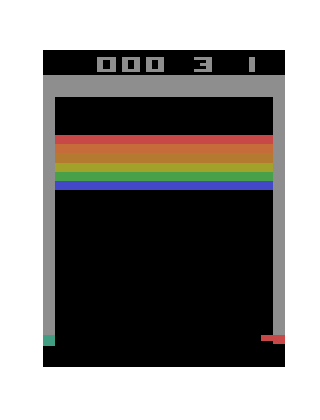
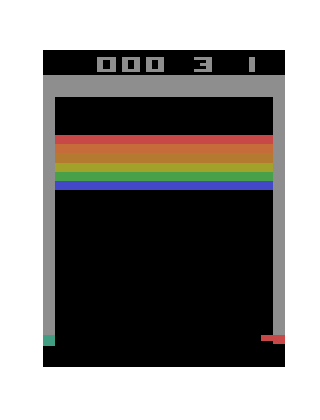
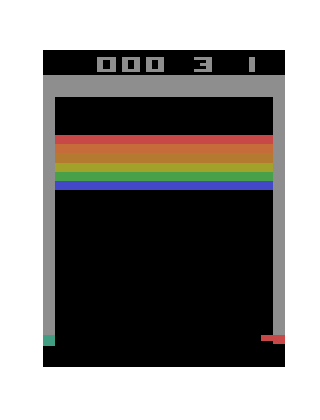
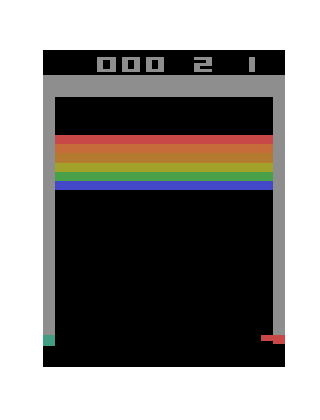
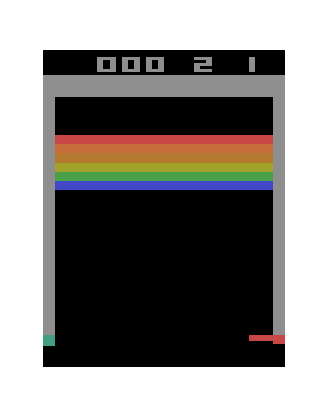
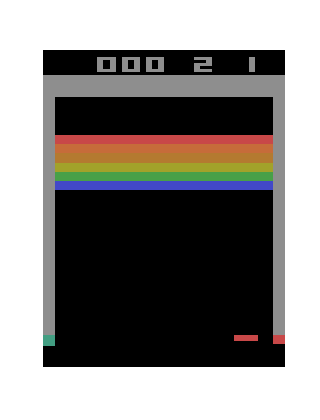
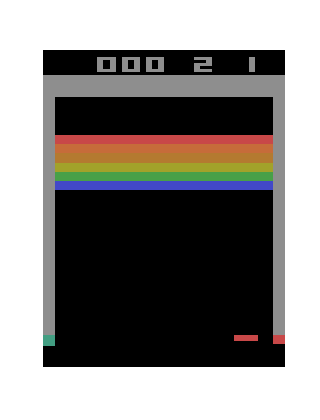
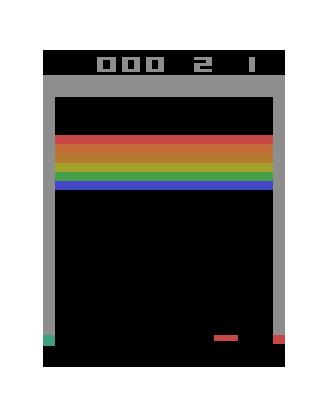
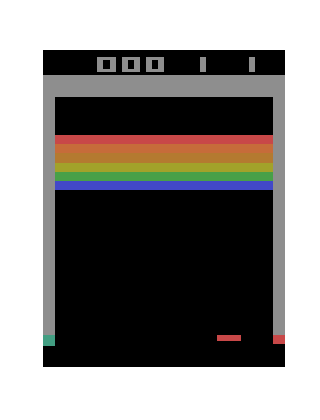
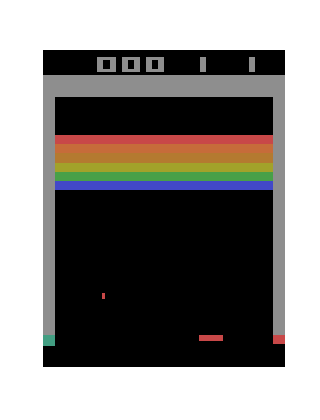
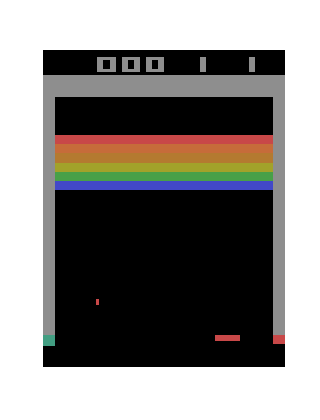
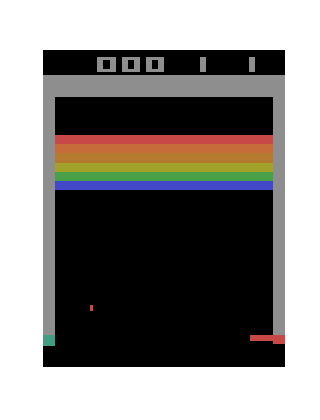
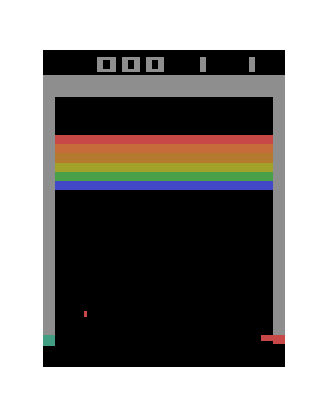
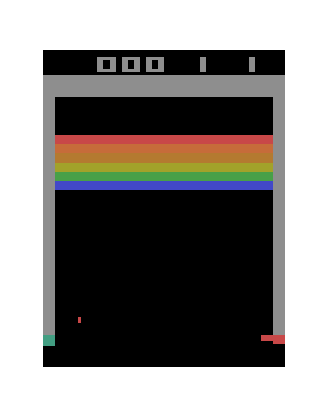
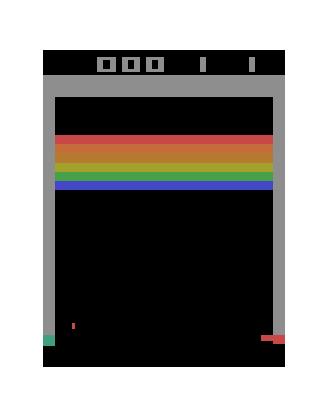
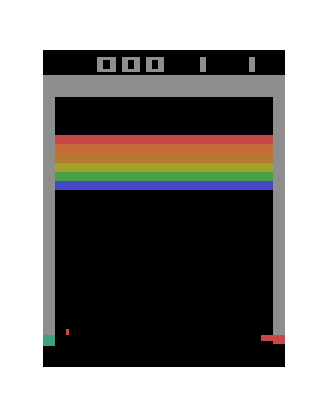
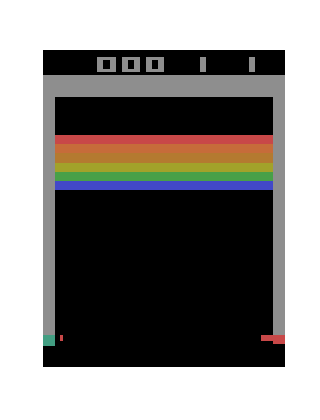
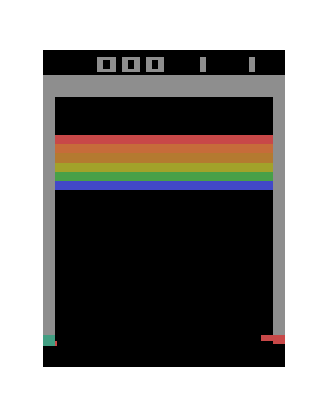
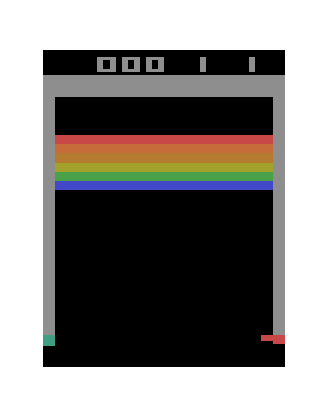
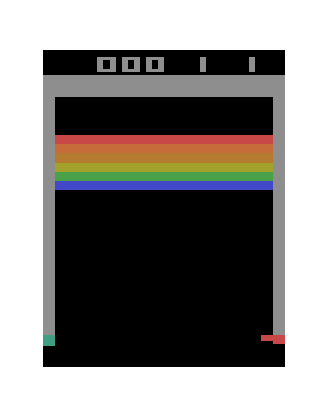
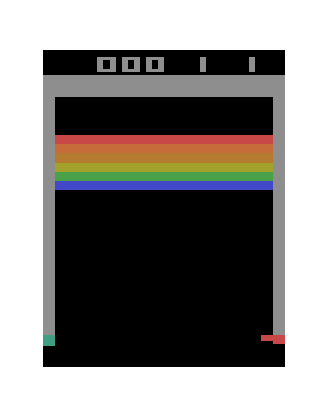
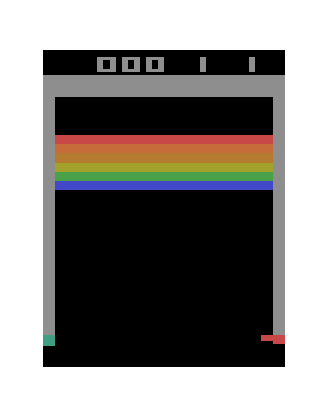
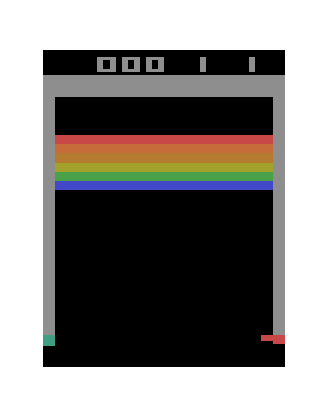
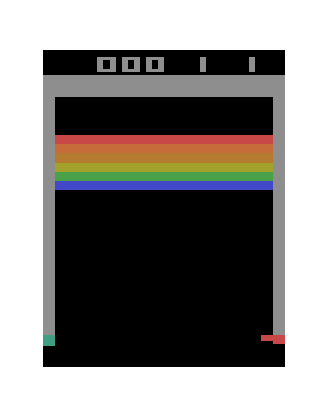
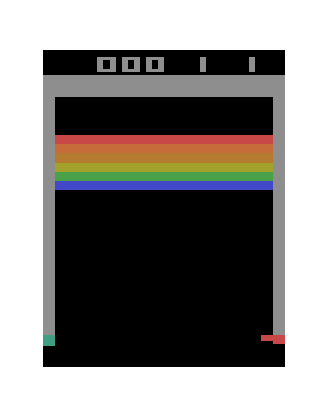
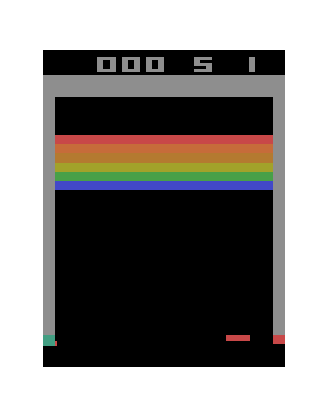
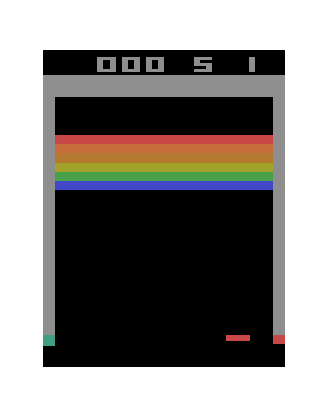
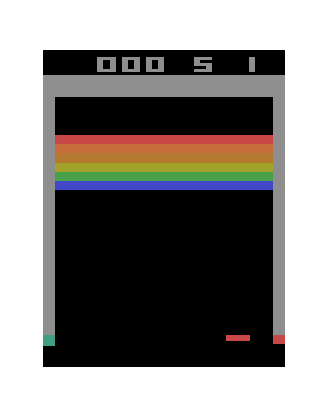
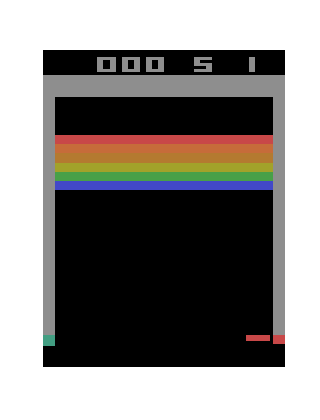
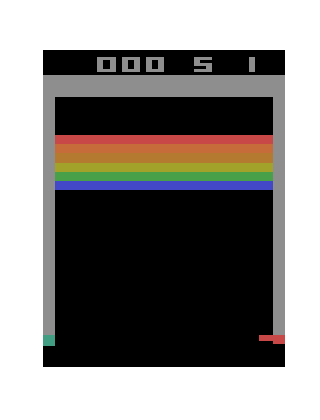
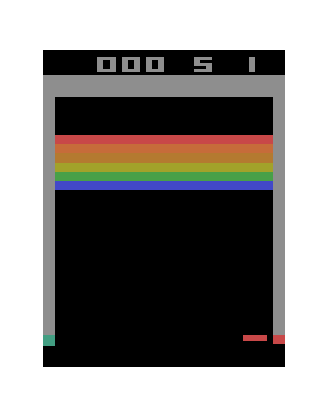
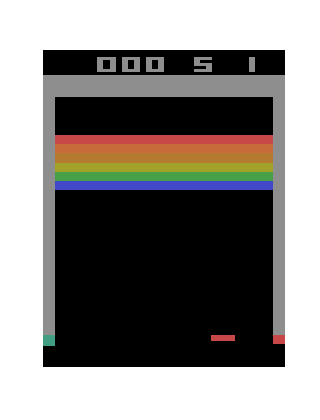
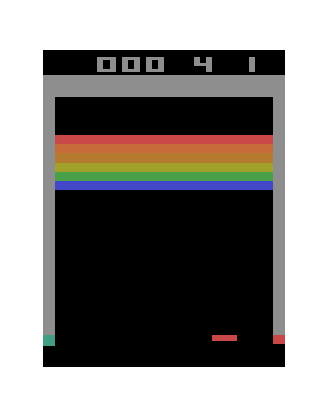
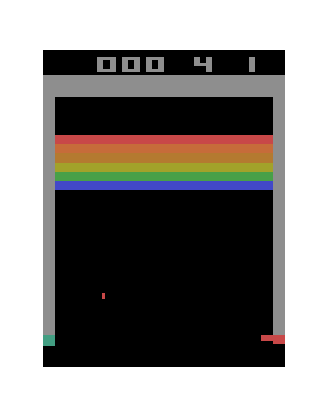
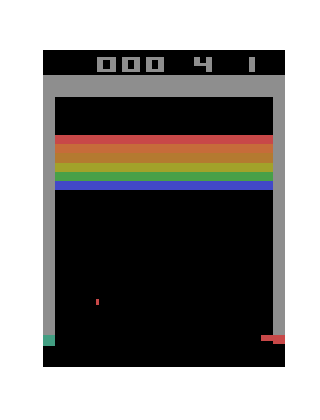
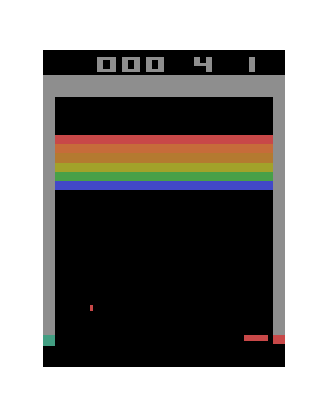
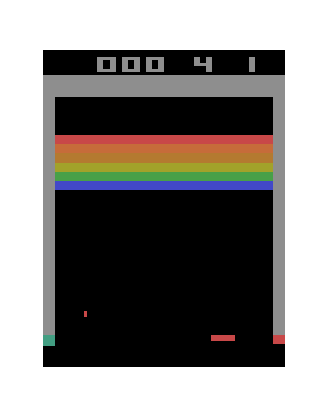
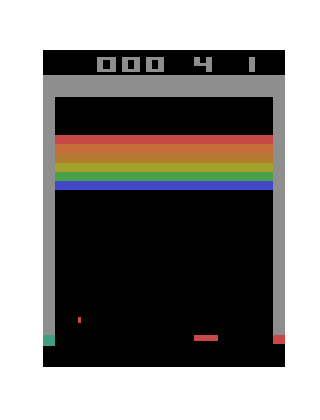
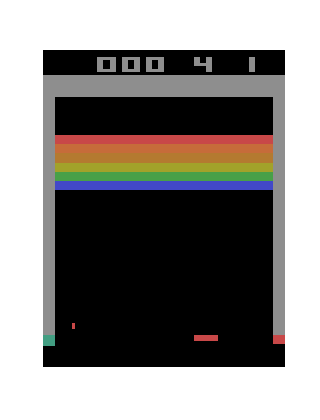
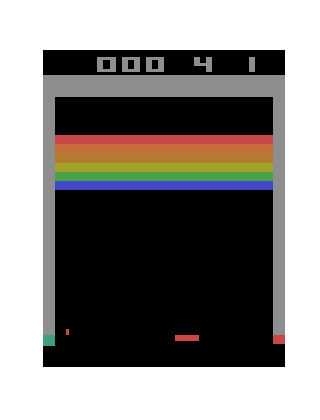
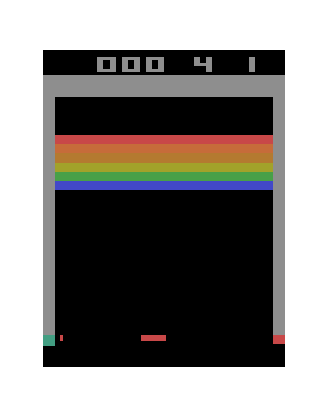
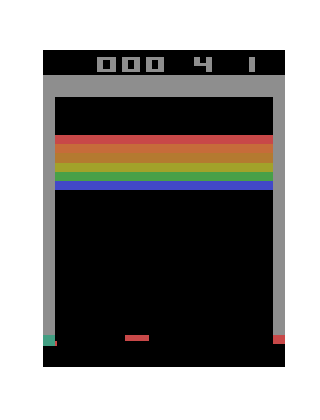
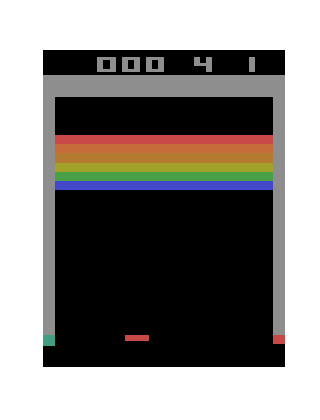
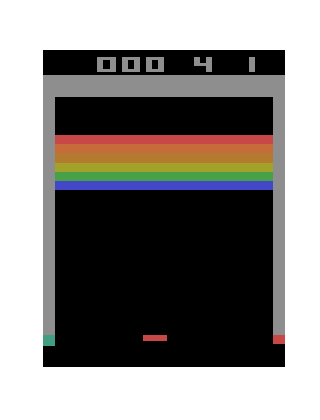
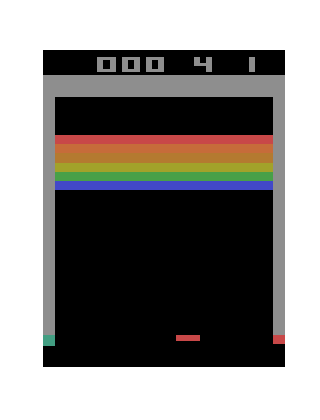
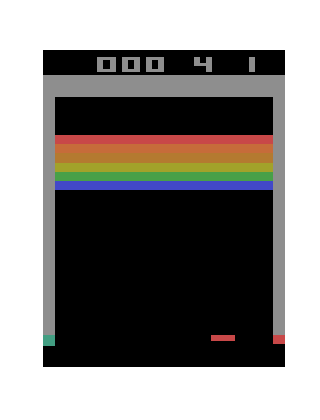
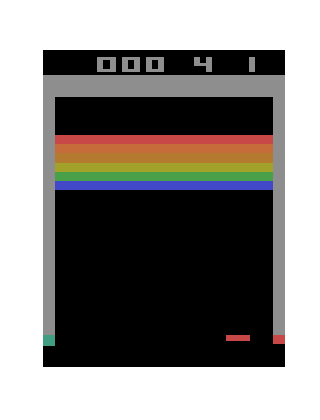
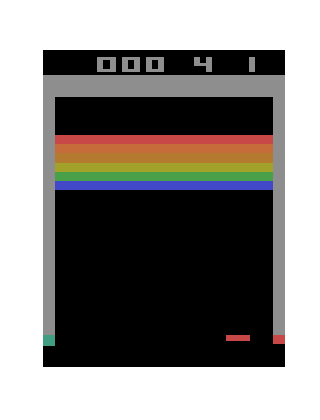
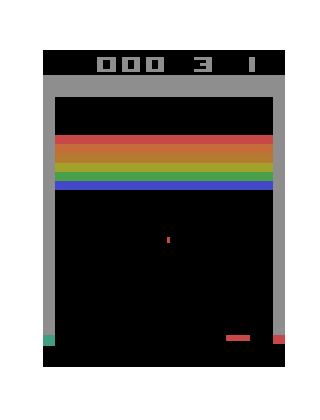
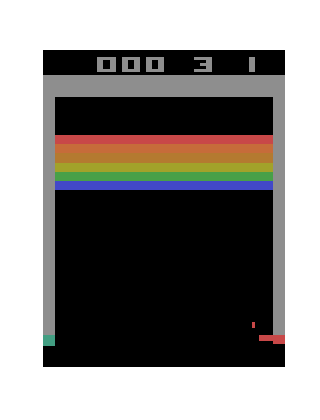
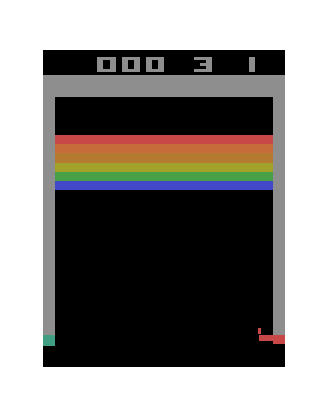
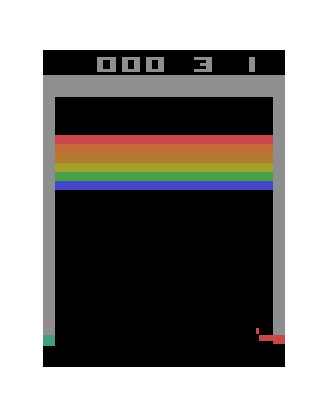
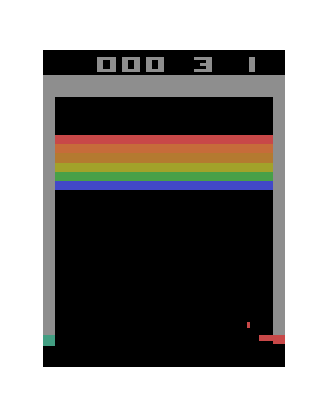
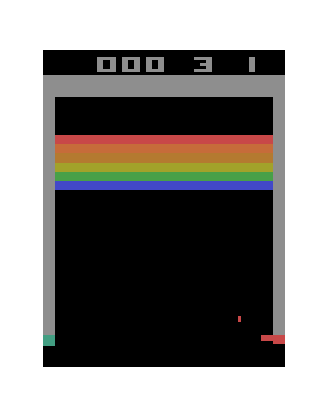
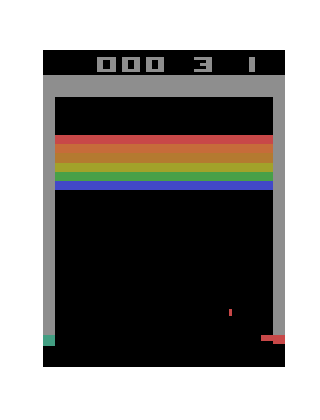
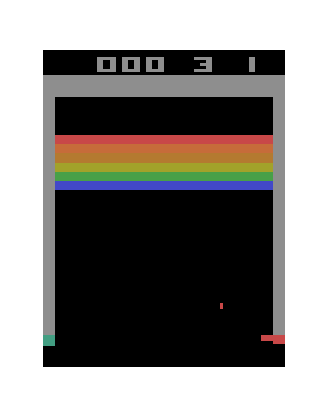
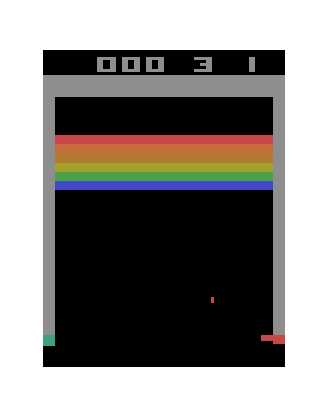
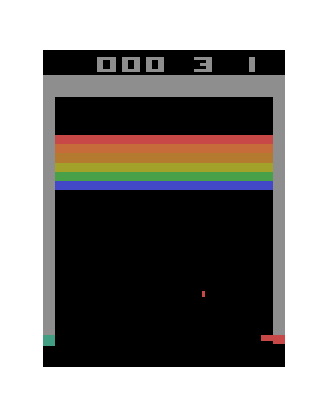
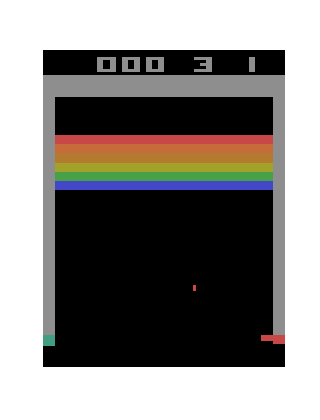
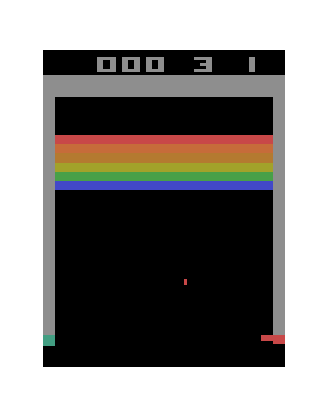
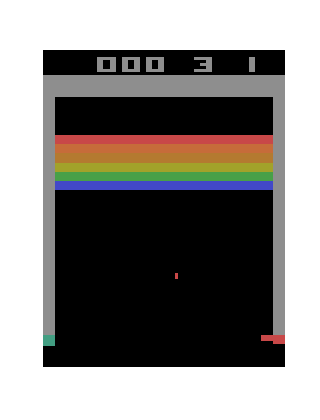
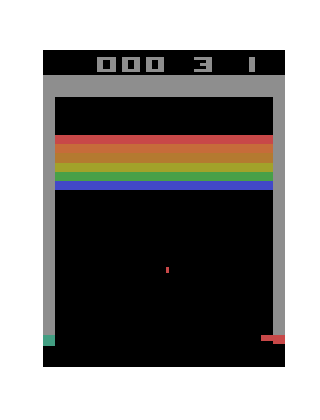
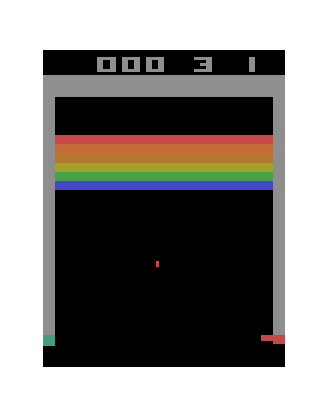
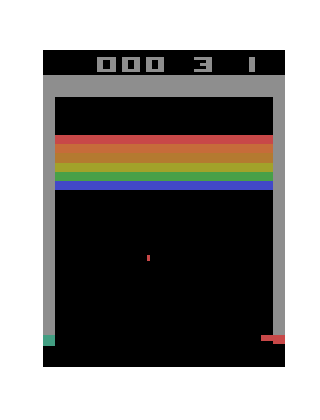
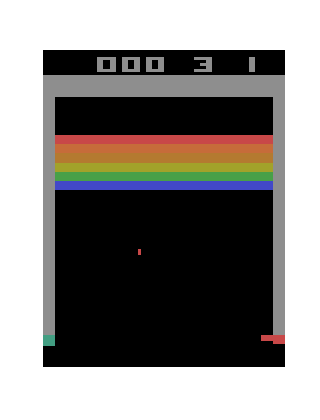
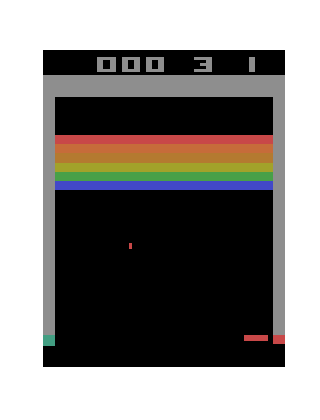
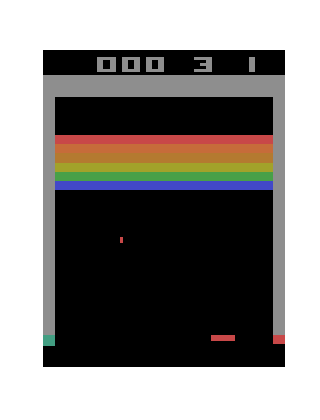
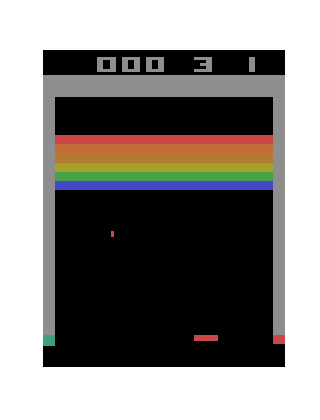
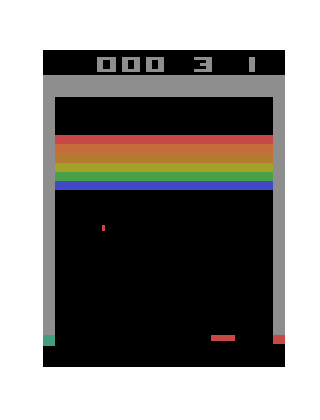
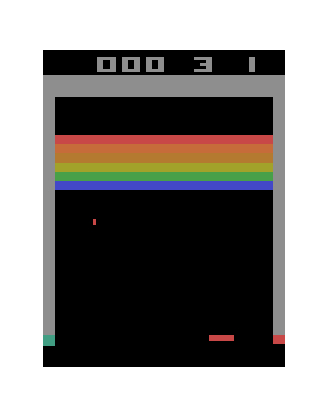
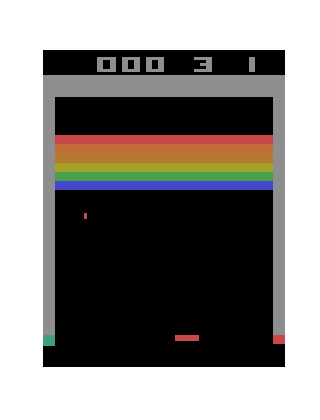
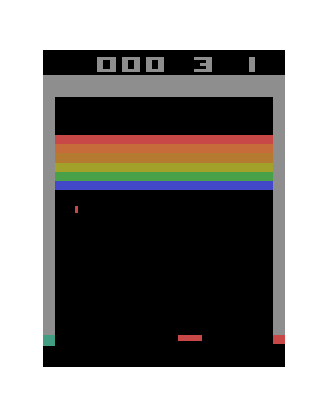
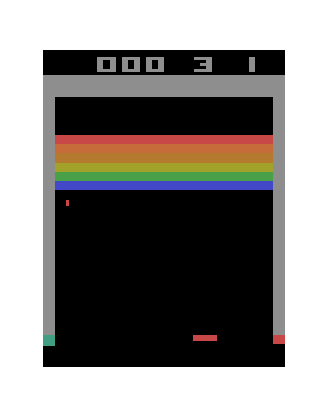
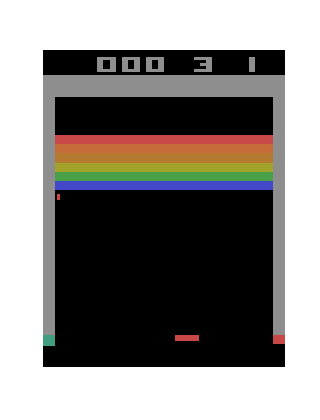
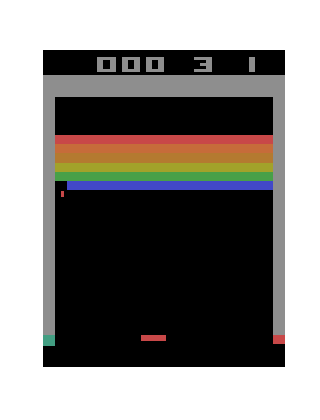
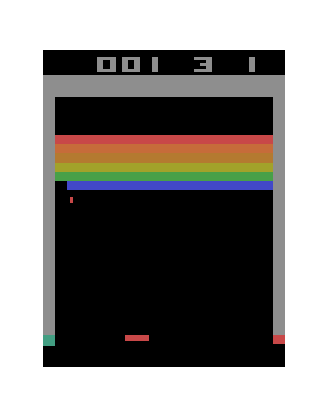
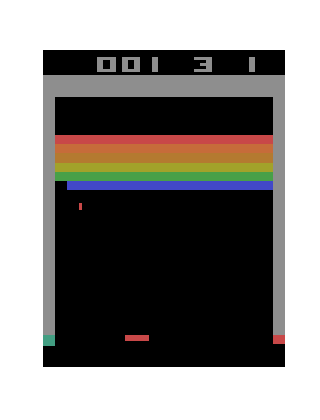
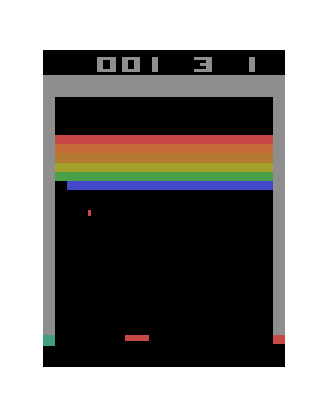
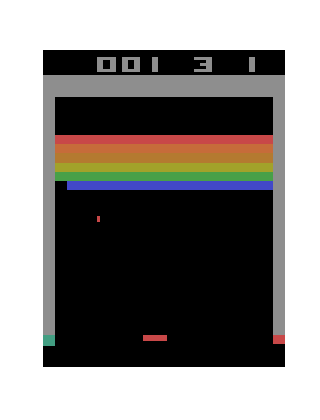
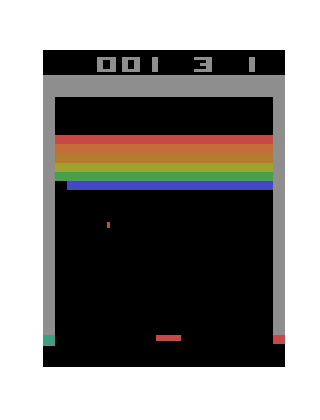
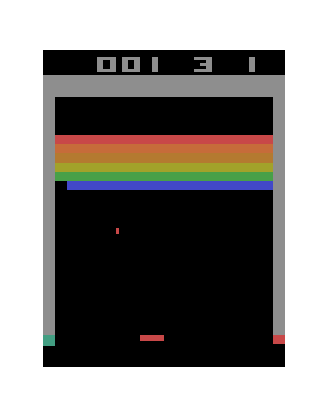
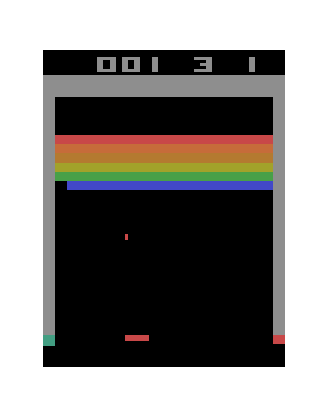
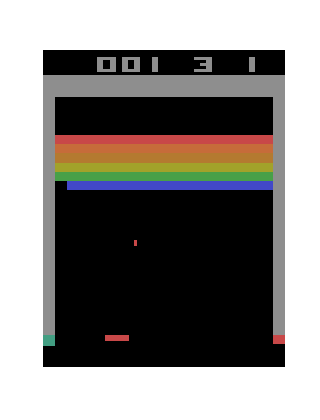
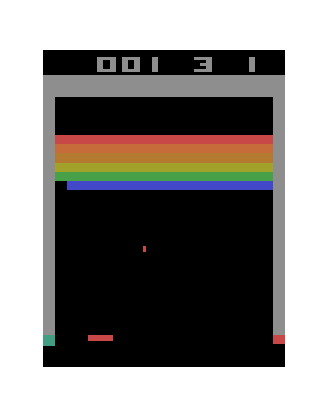
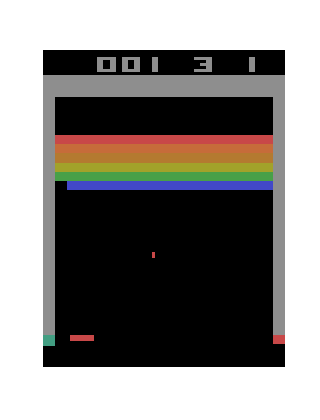
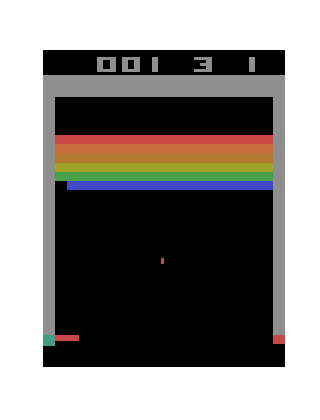
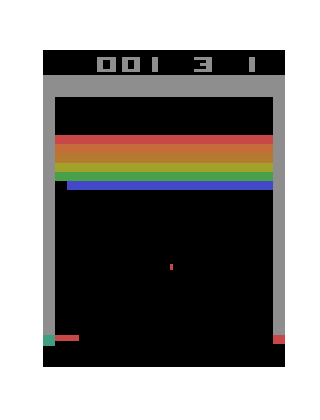
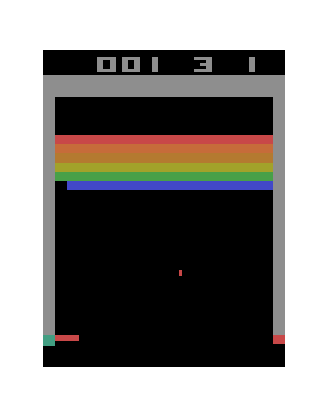
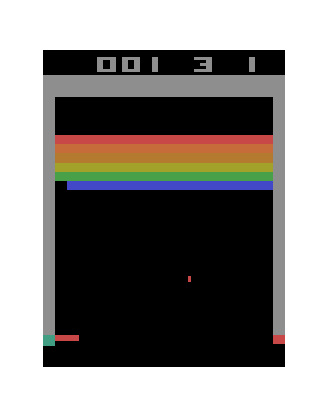
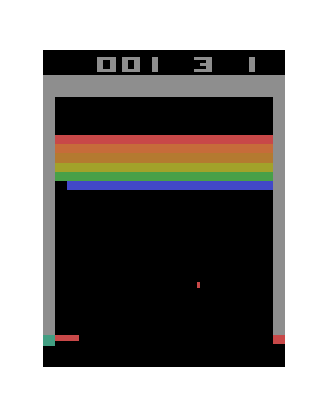
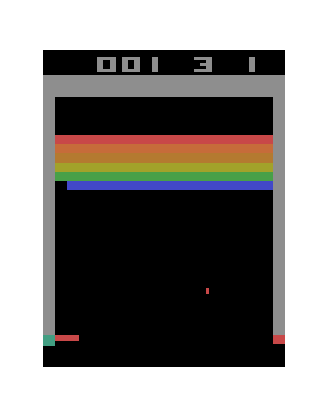
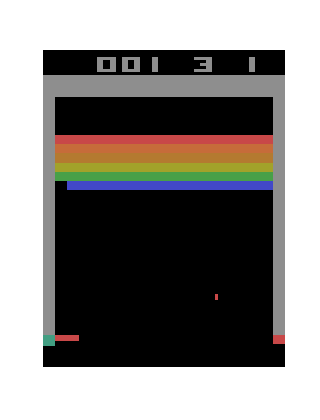
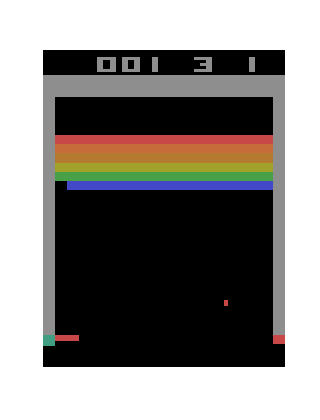
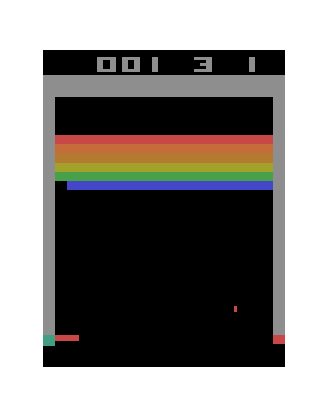
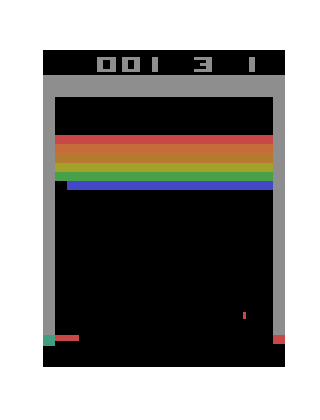
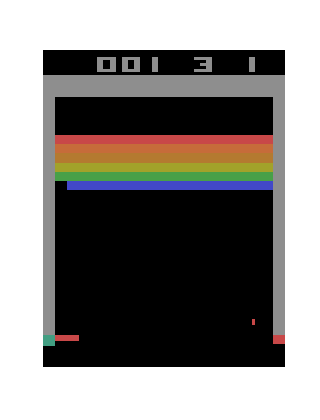
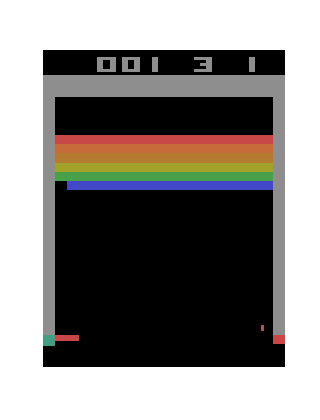
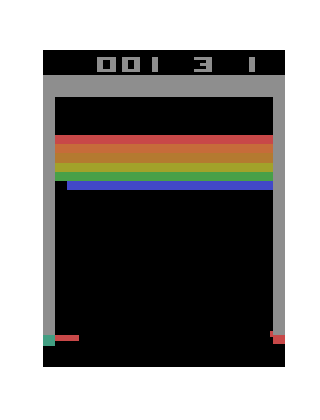
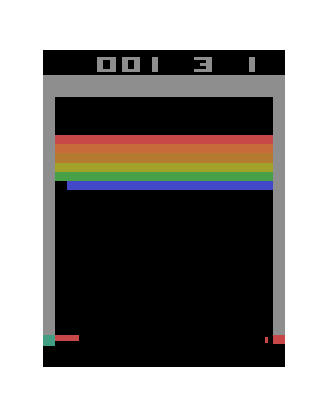
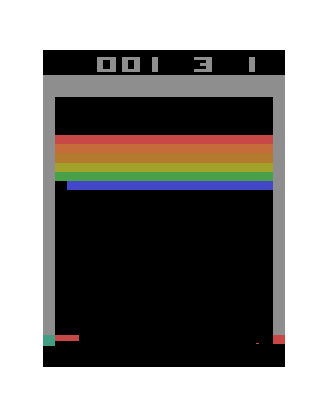
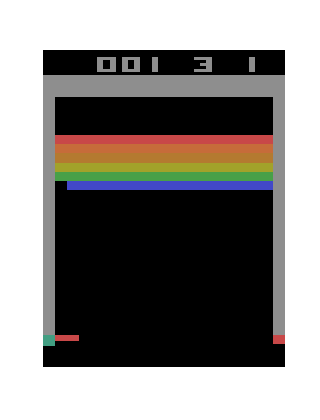
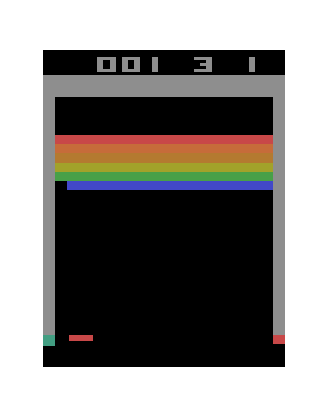
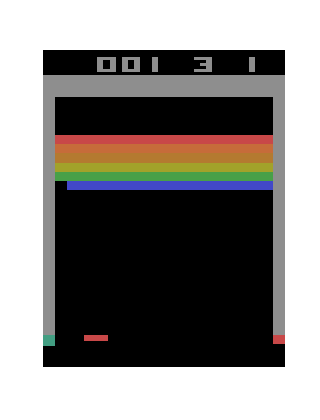
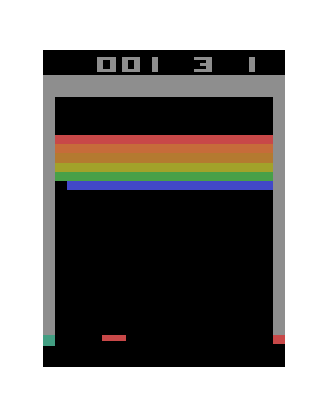
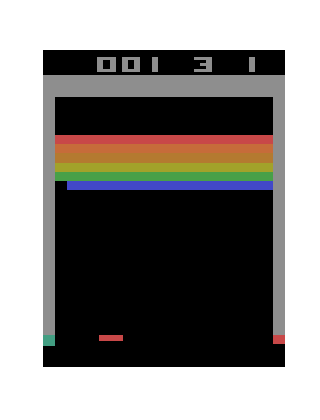
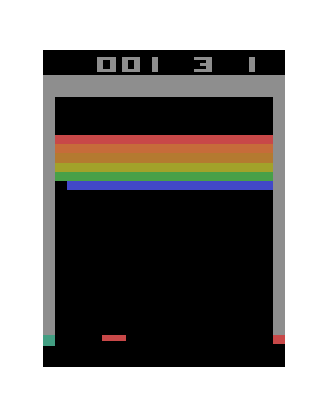
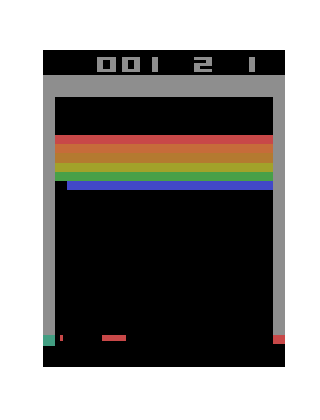
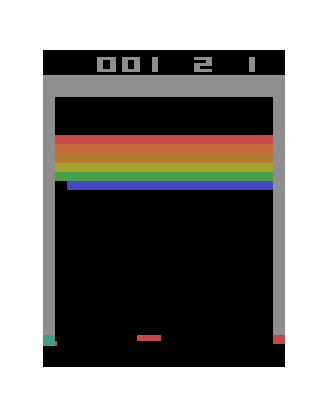
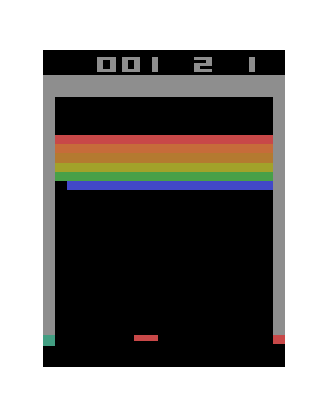
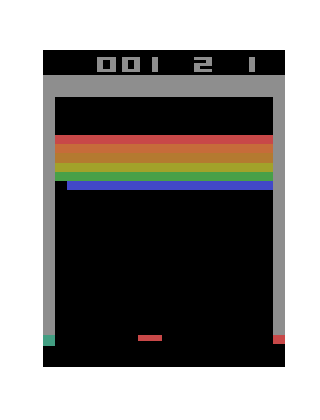
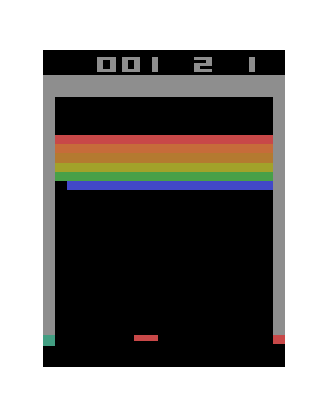
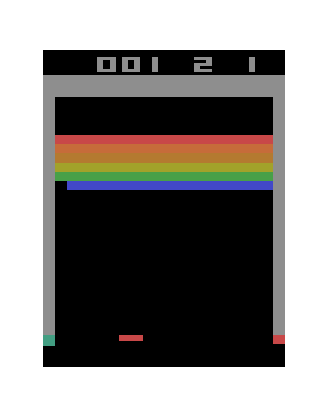
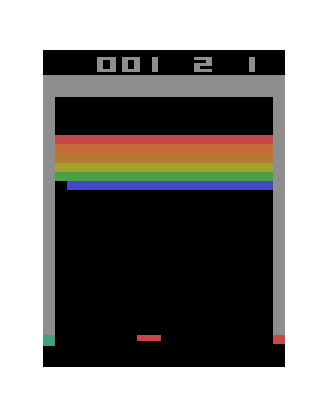
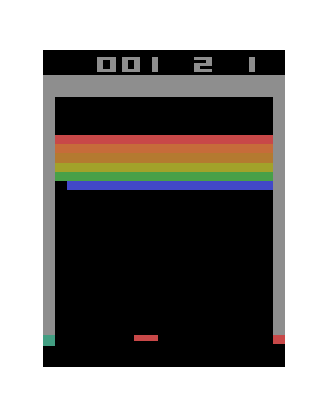
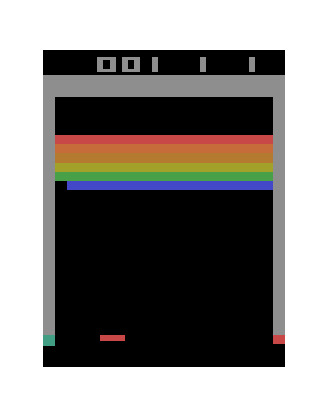
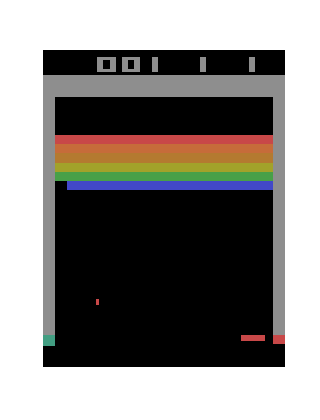
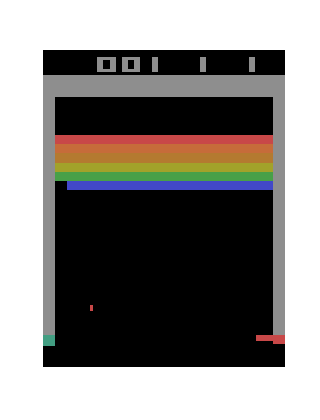
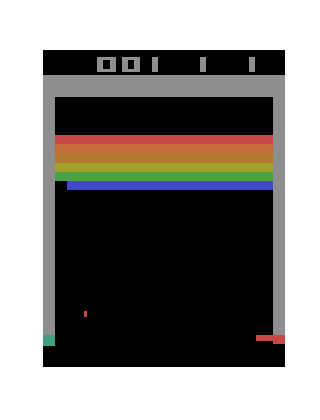
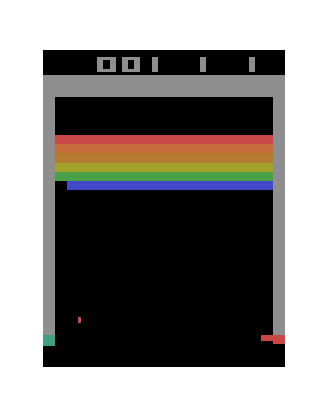
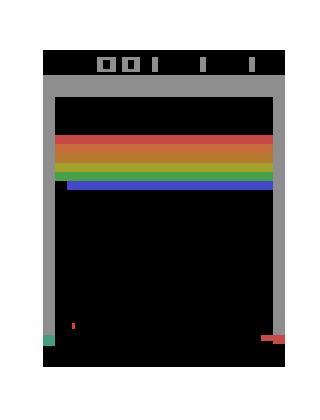
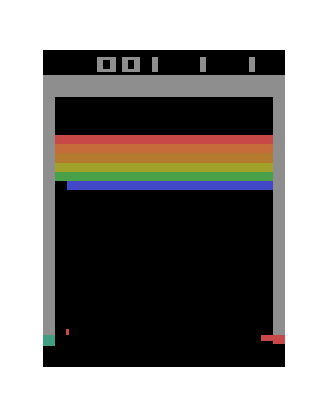
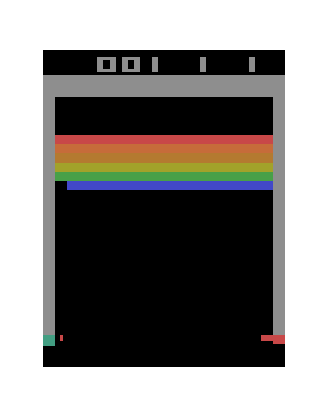
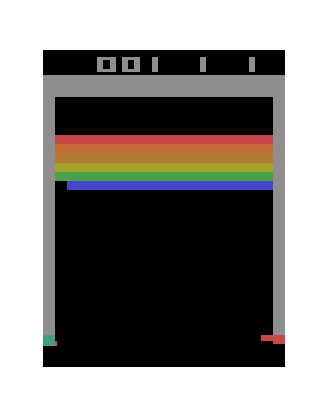
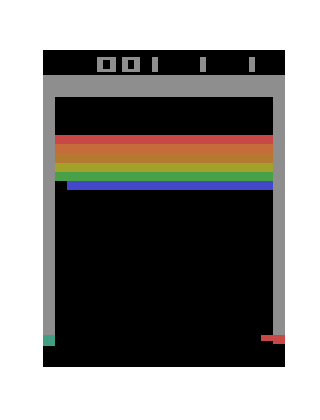
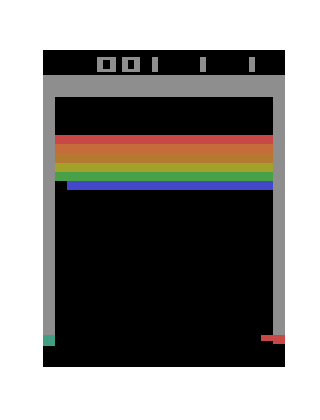
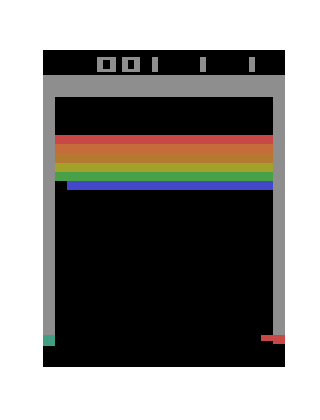
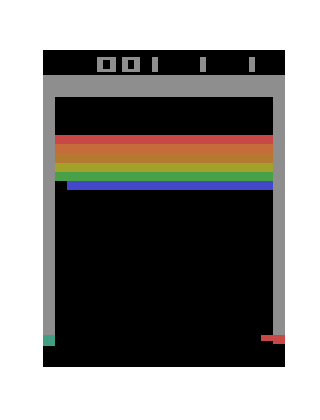
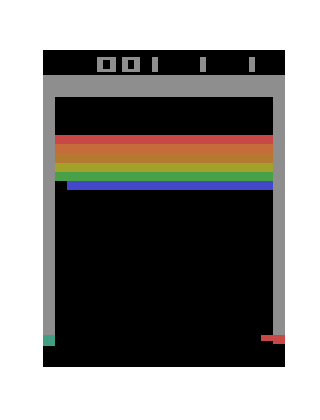
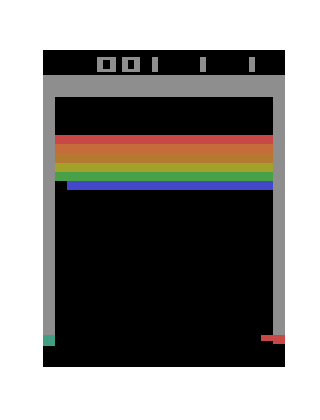
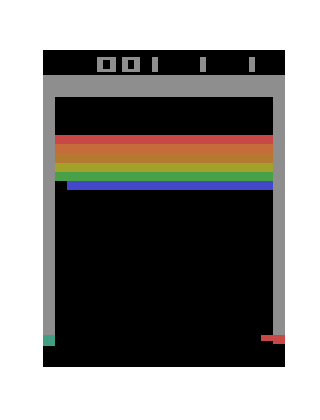
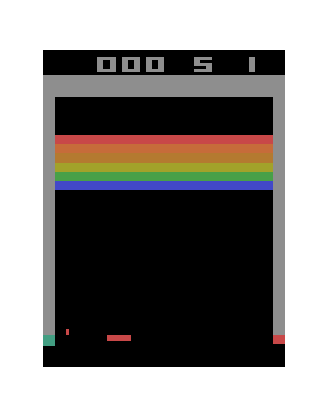
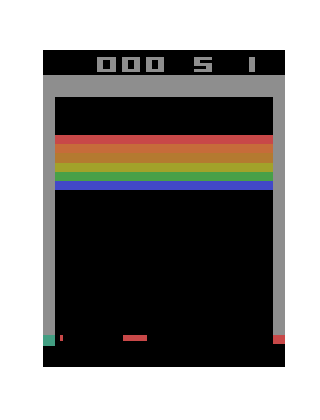
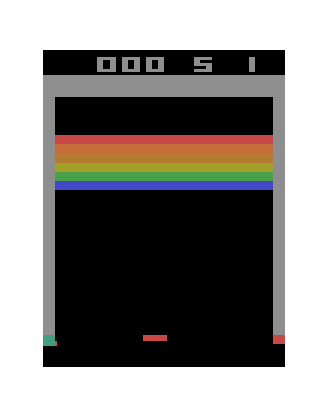
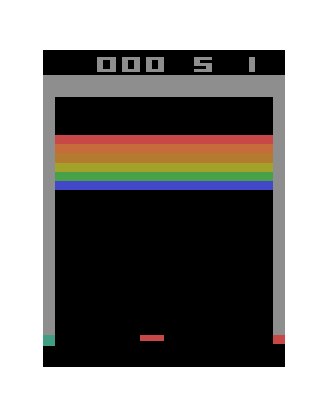
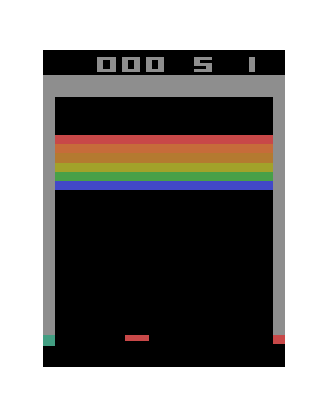
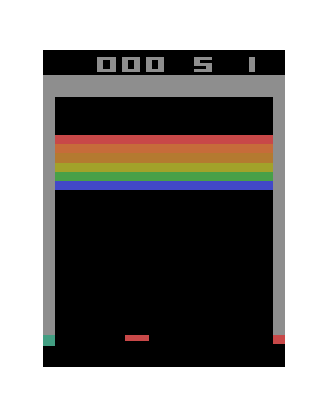
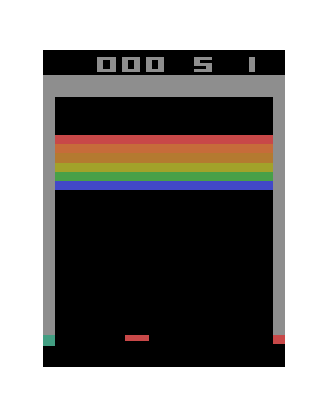
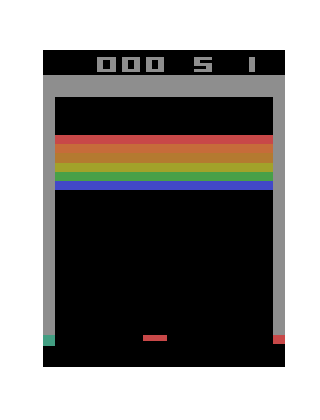
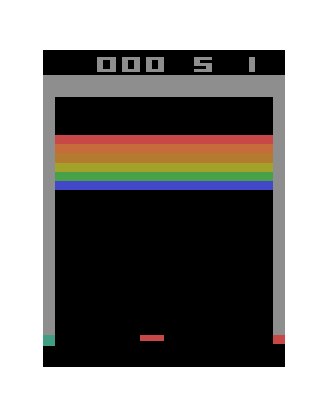
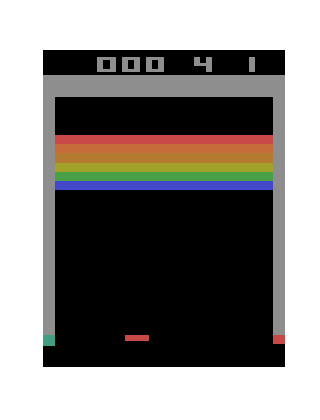
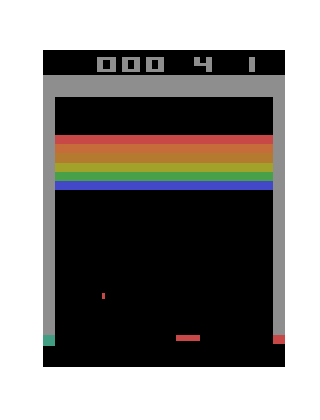
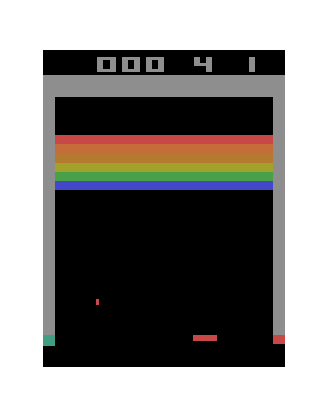
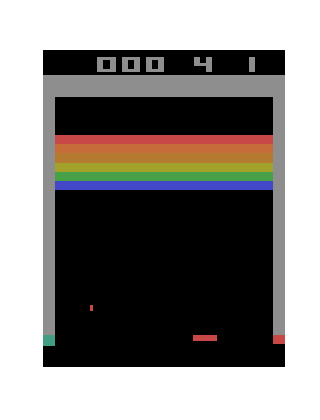
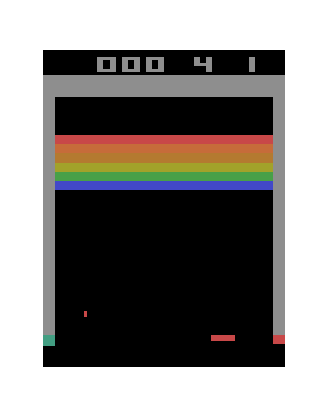
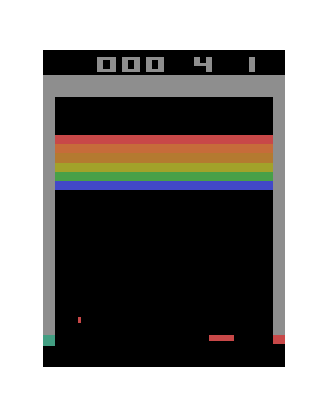
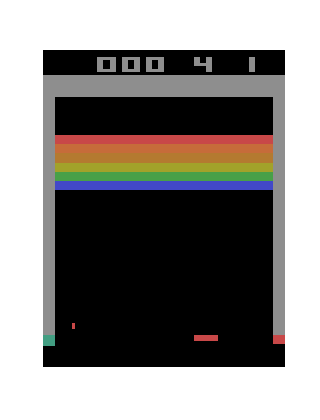
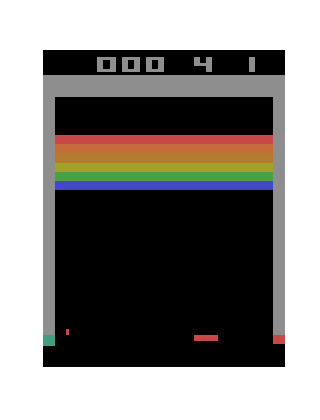
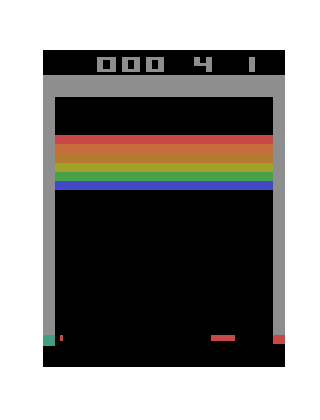
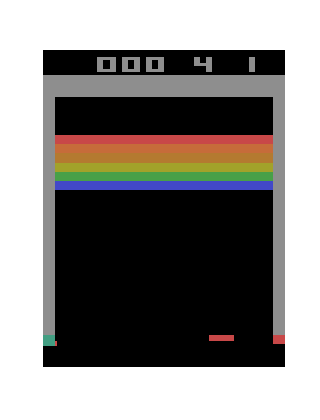
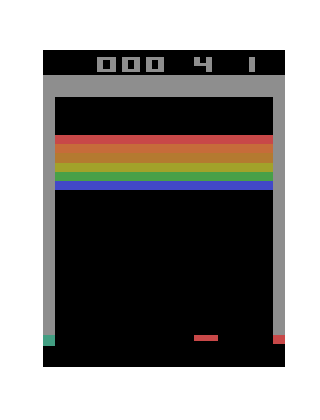
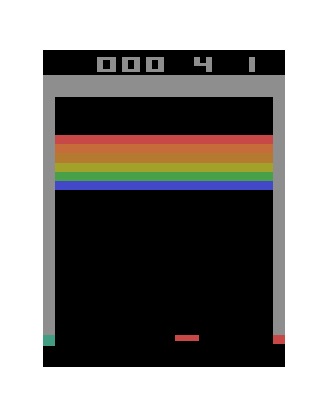
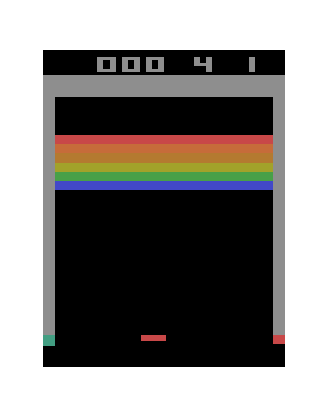
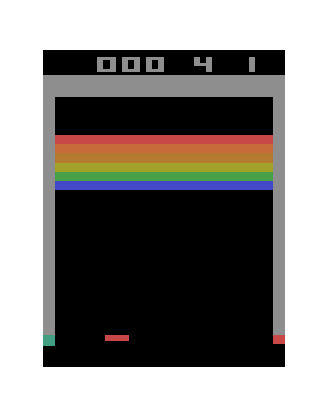
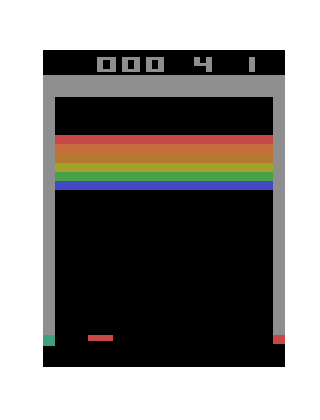
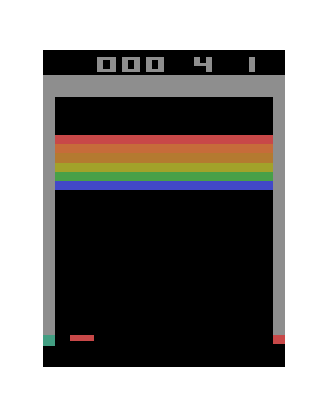
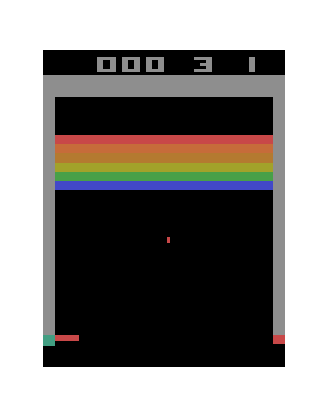
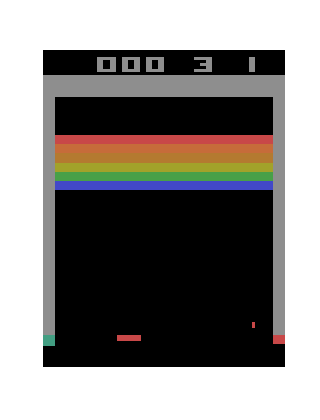
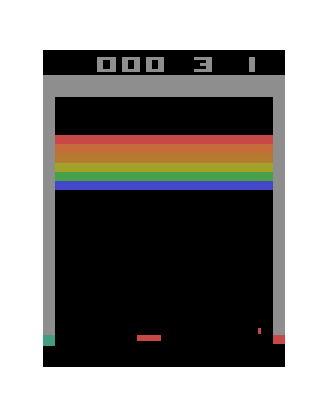
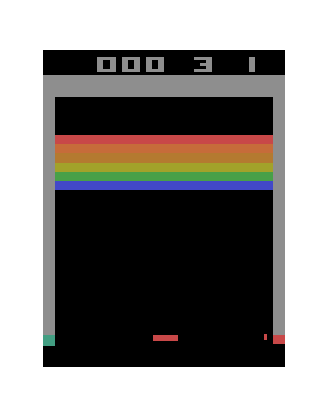
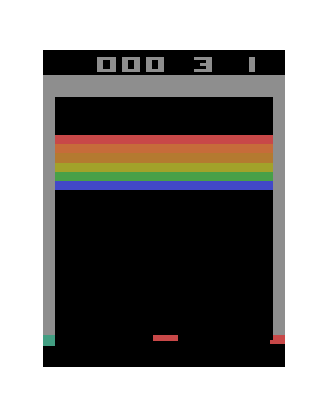
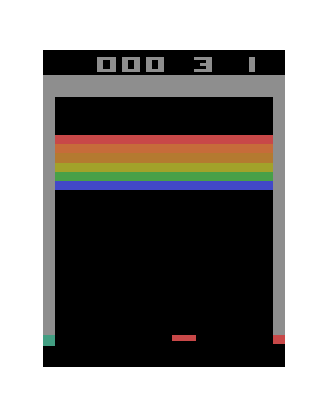
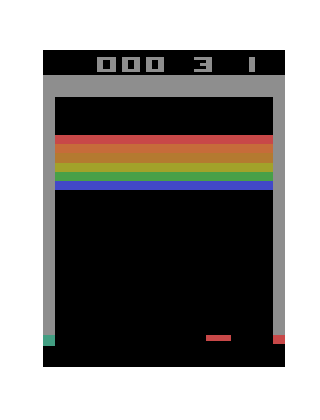
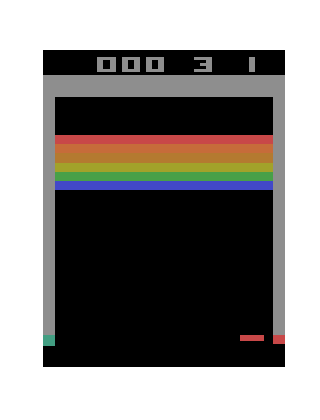

In [11]:
from renom_rl.utility import MaxNodeChooser
a2c.test_node_selector=ProbNodeChooser()
Env.test=True
a2c.test(test_step=1000)
Env.test=False
Env.animation.run()
Env.animation.reset()

In [12]:
model2.save("model3.h5")